# CLAIM DENIAL PREDICTION

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

from sklearn.ensemble import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
from pylab import rcParams
rcParams['figure.figsize'] = 22, 10
import tensorflow as tf
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# EDA

In [2]:
data = pd.read_csv('D:/AR/book1.csv')

In [3]:
data.shape

(163410, 95)

In [4]:
df = data.copy()

In [5]:
df.columns = data.columns.str.replace(' ','_')

In [6]:
df['Denial_Ind'].fillna('None',inplace = True)

In [7]:
df['Denial_Ind'][df['Denial_Code']=='None' ].value_counts()

Series([], Name: Denial_Ind, dtype: int64)

In [8]:
df.columns

Index(['Client_ID', 'Charge_ID', 'Transaction_ID', 'Patient_ID',
       'Patient_Name', 'Patient_Email', 'Guarantor_ID', 'Guarantor_Name',
       'Accession_ID', 'Medical_Record_ID', 'Date_Of_Birth', 'Address_1',
       'Address_2', 'City', 'State', 'Zip', 'Statement_Control',
       'Trans_Type_ID', 'Report_Class', 'Transaction_Code',
       'Transaction_Code_Desc', 'Payment_Category', 'Payment_Source',
       'Payment_Source_Name', 'Amount', 'Allowed_Amount', 'Deductible_Amount',
       'Coinsurance_Amount', 'Denial_Ind', 'Denial_Reason_ID', 'Denial_Reason',
       'Denial_Group', 'Denial_Code', 'Check_Number', 'Batch_ID',
       'Remittance_Batch_ID', 'Global_Payment_Batch_ID', 'User_ID', 'Position',
       'Paying_Carrier_ID', 'Paying_Carrier_Name', 'Paying_Carrier_Group',
       'Paying_Carrier_Type', 'Paying_Financial_Class_1',
       'Paying_Financial_Class_2', 'Paying_Trading_Partner',
       'Primary_Carrier_ID', 'Primary_Carrier_Name', 'Primary_Carrier_Type',
       'Primary_

## Paying_Financial_Class is the assigned to the Payer/Insurance by the billing department.

<AxesSubplot:title={'center':'Ins Class'}, ylabel='Paying_Financial_Class_1'>

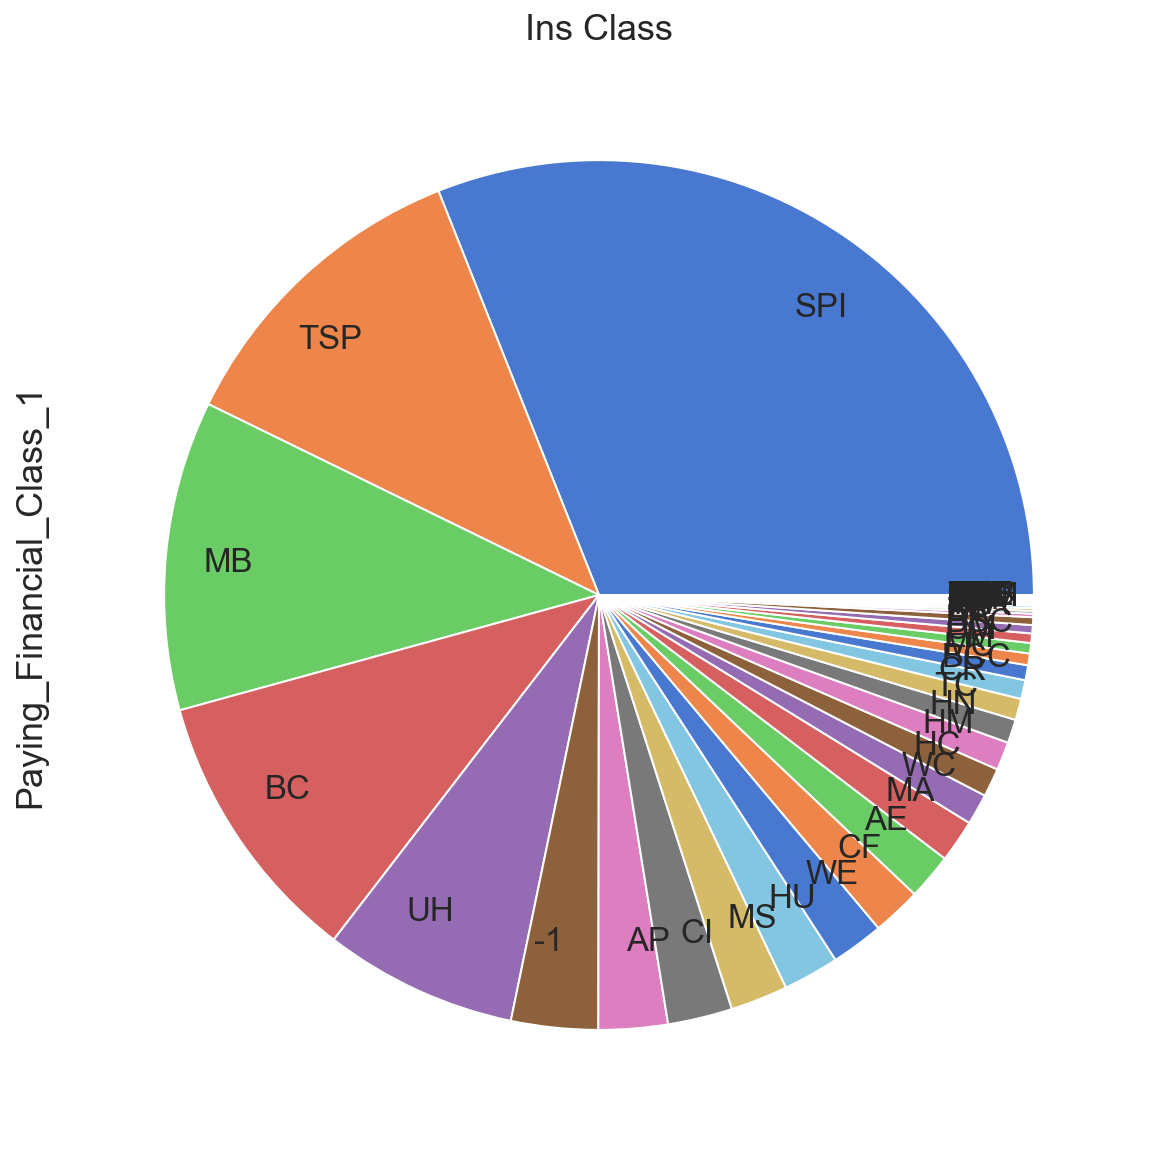

In [99]:
df['Paying_Financial_Class_1'].value_counts().plot(kind='pie',title='Ins Class', labeldistance=0.8)

## Claims paid is indicated by N and Y for denial

<AxesSubplot:title={'center':'Denial Indicator'}>

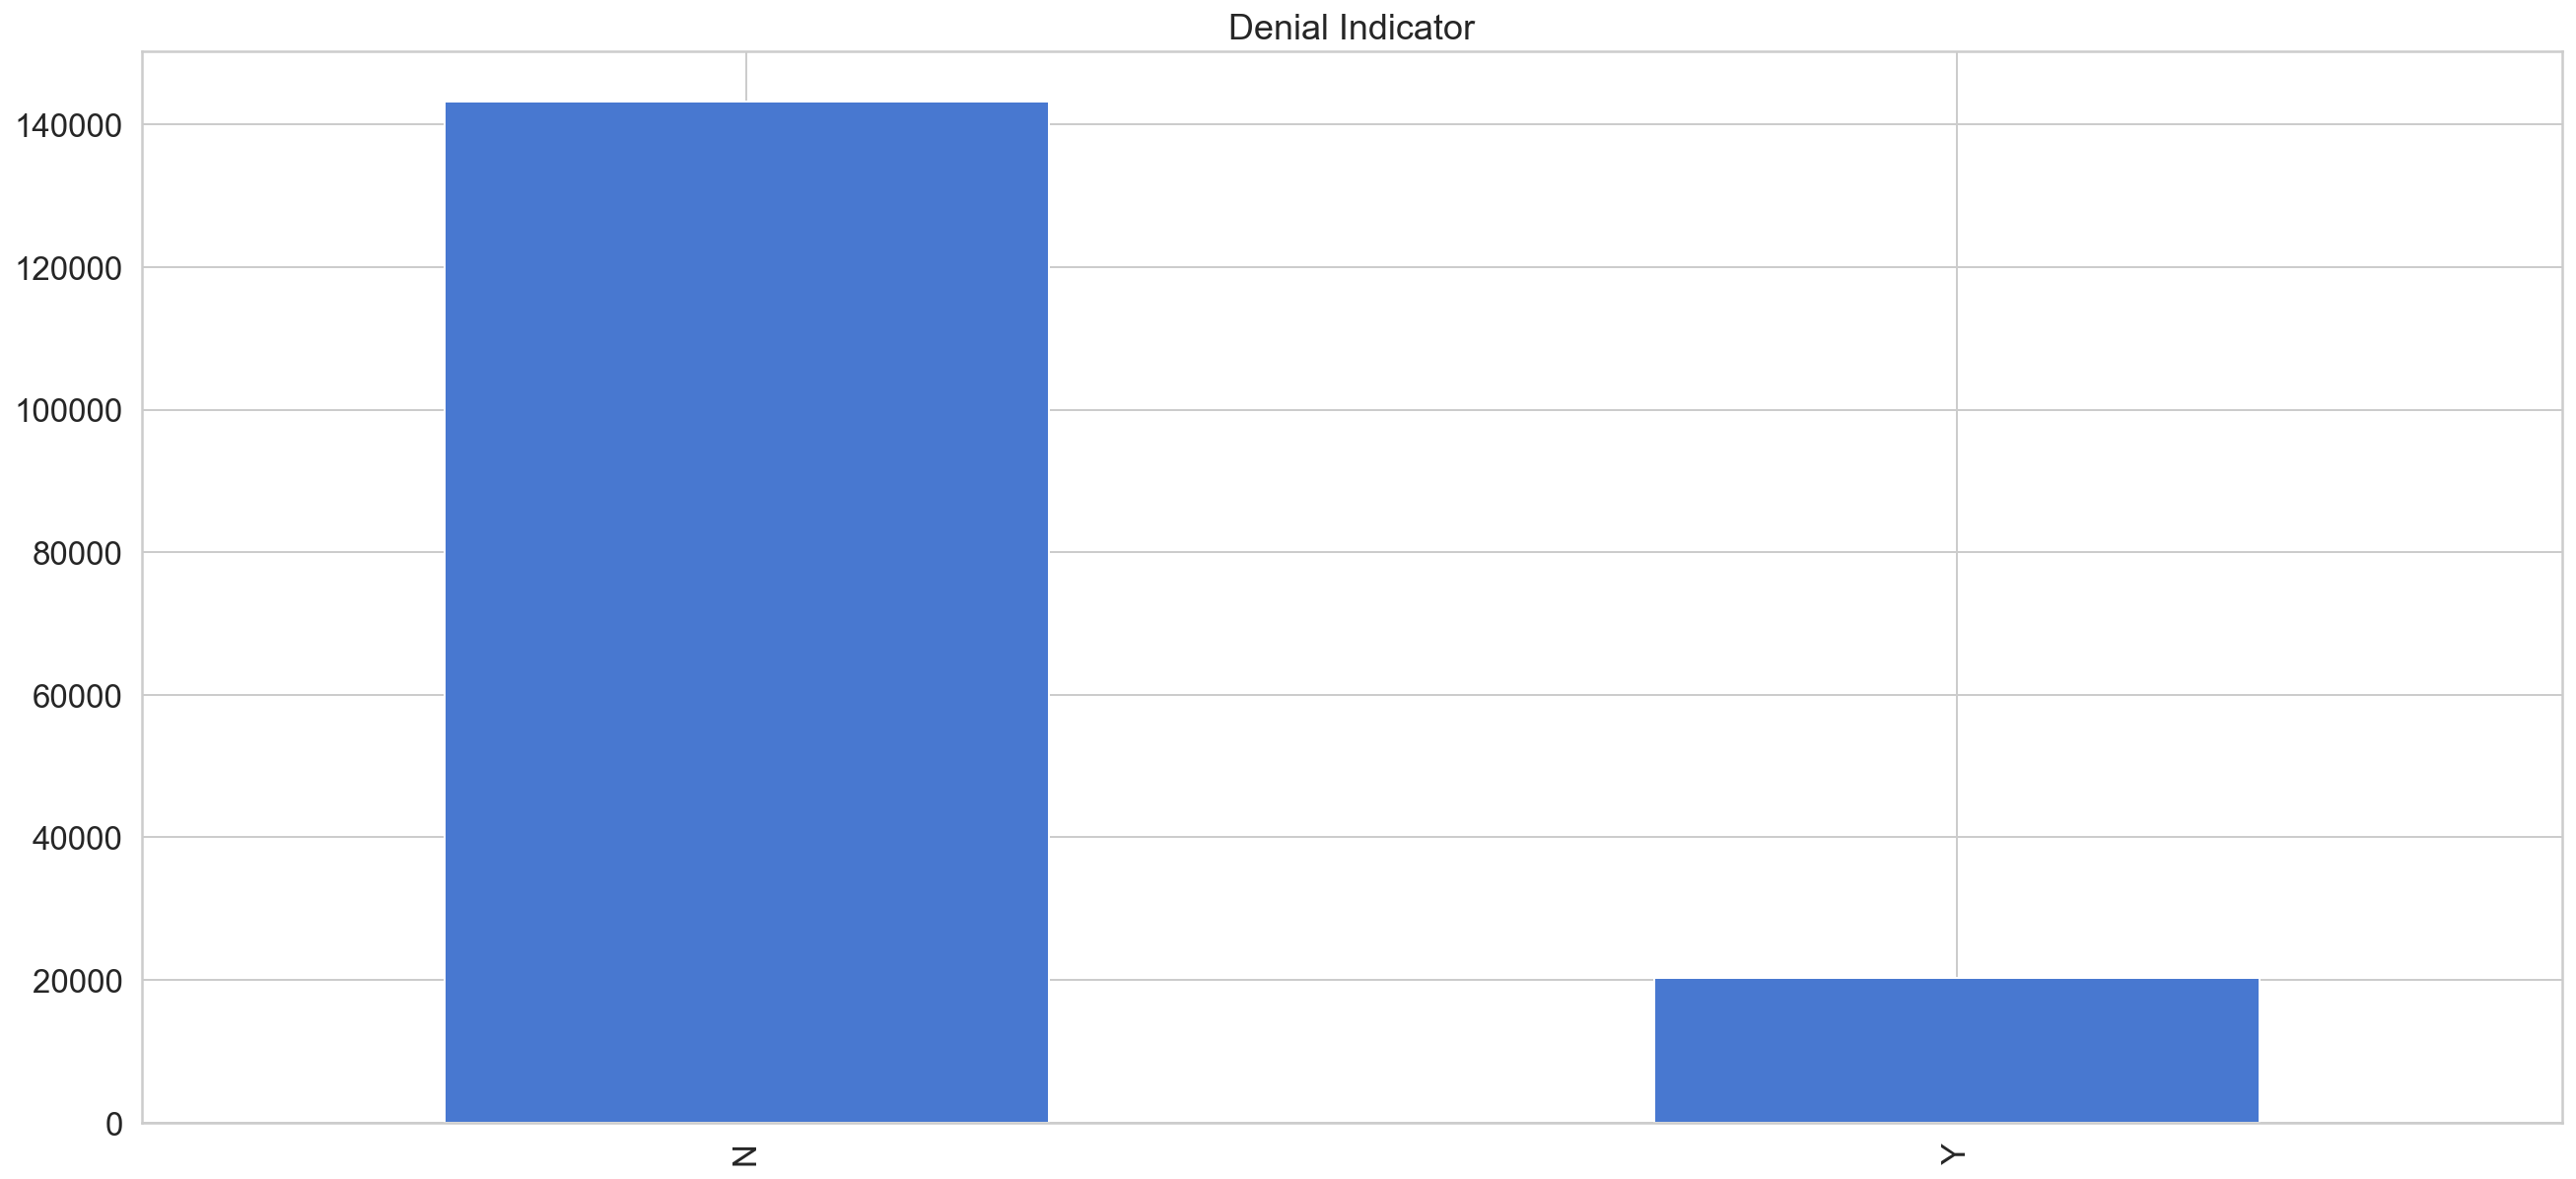

In [100]:
df['Denial_Ind'].value_counts().plot(kind='bar',title='Denial Indicator')

In [101]:
carr_id = df['Paying_Financial_Class_1'].value_counts()

In [102]:
carr_id = carr_id.reset_index() 
carr_id.columns = ['carr_id','counts']

In [103]:
carr_id['percentage'] = carr_id['counts']/carr_id['counts'].sum()
carr_id['cum_percentage'] = 100*(carr_id.counts.cumsum() / carr_id.counts.sum())

In [104]:
carr_id = carr_id[carr_id['cum_percentage']<=80]

## Each Payer/Insurance is assiged with Carrior ID below is Carrior id contributes 80 percent of the volume

<AxesSubplot:>

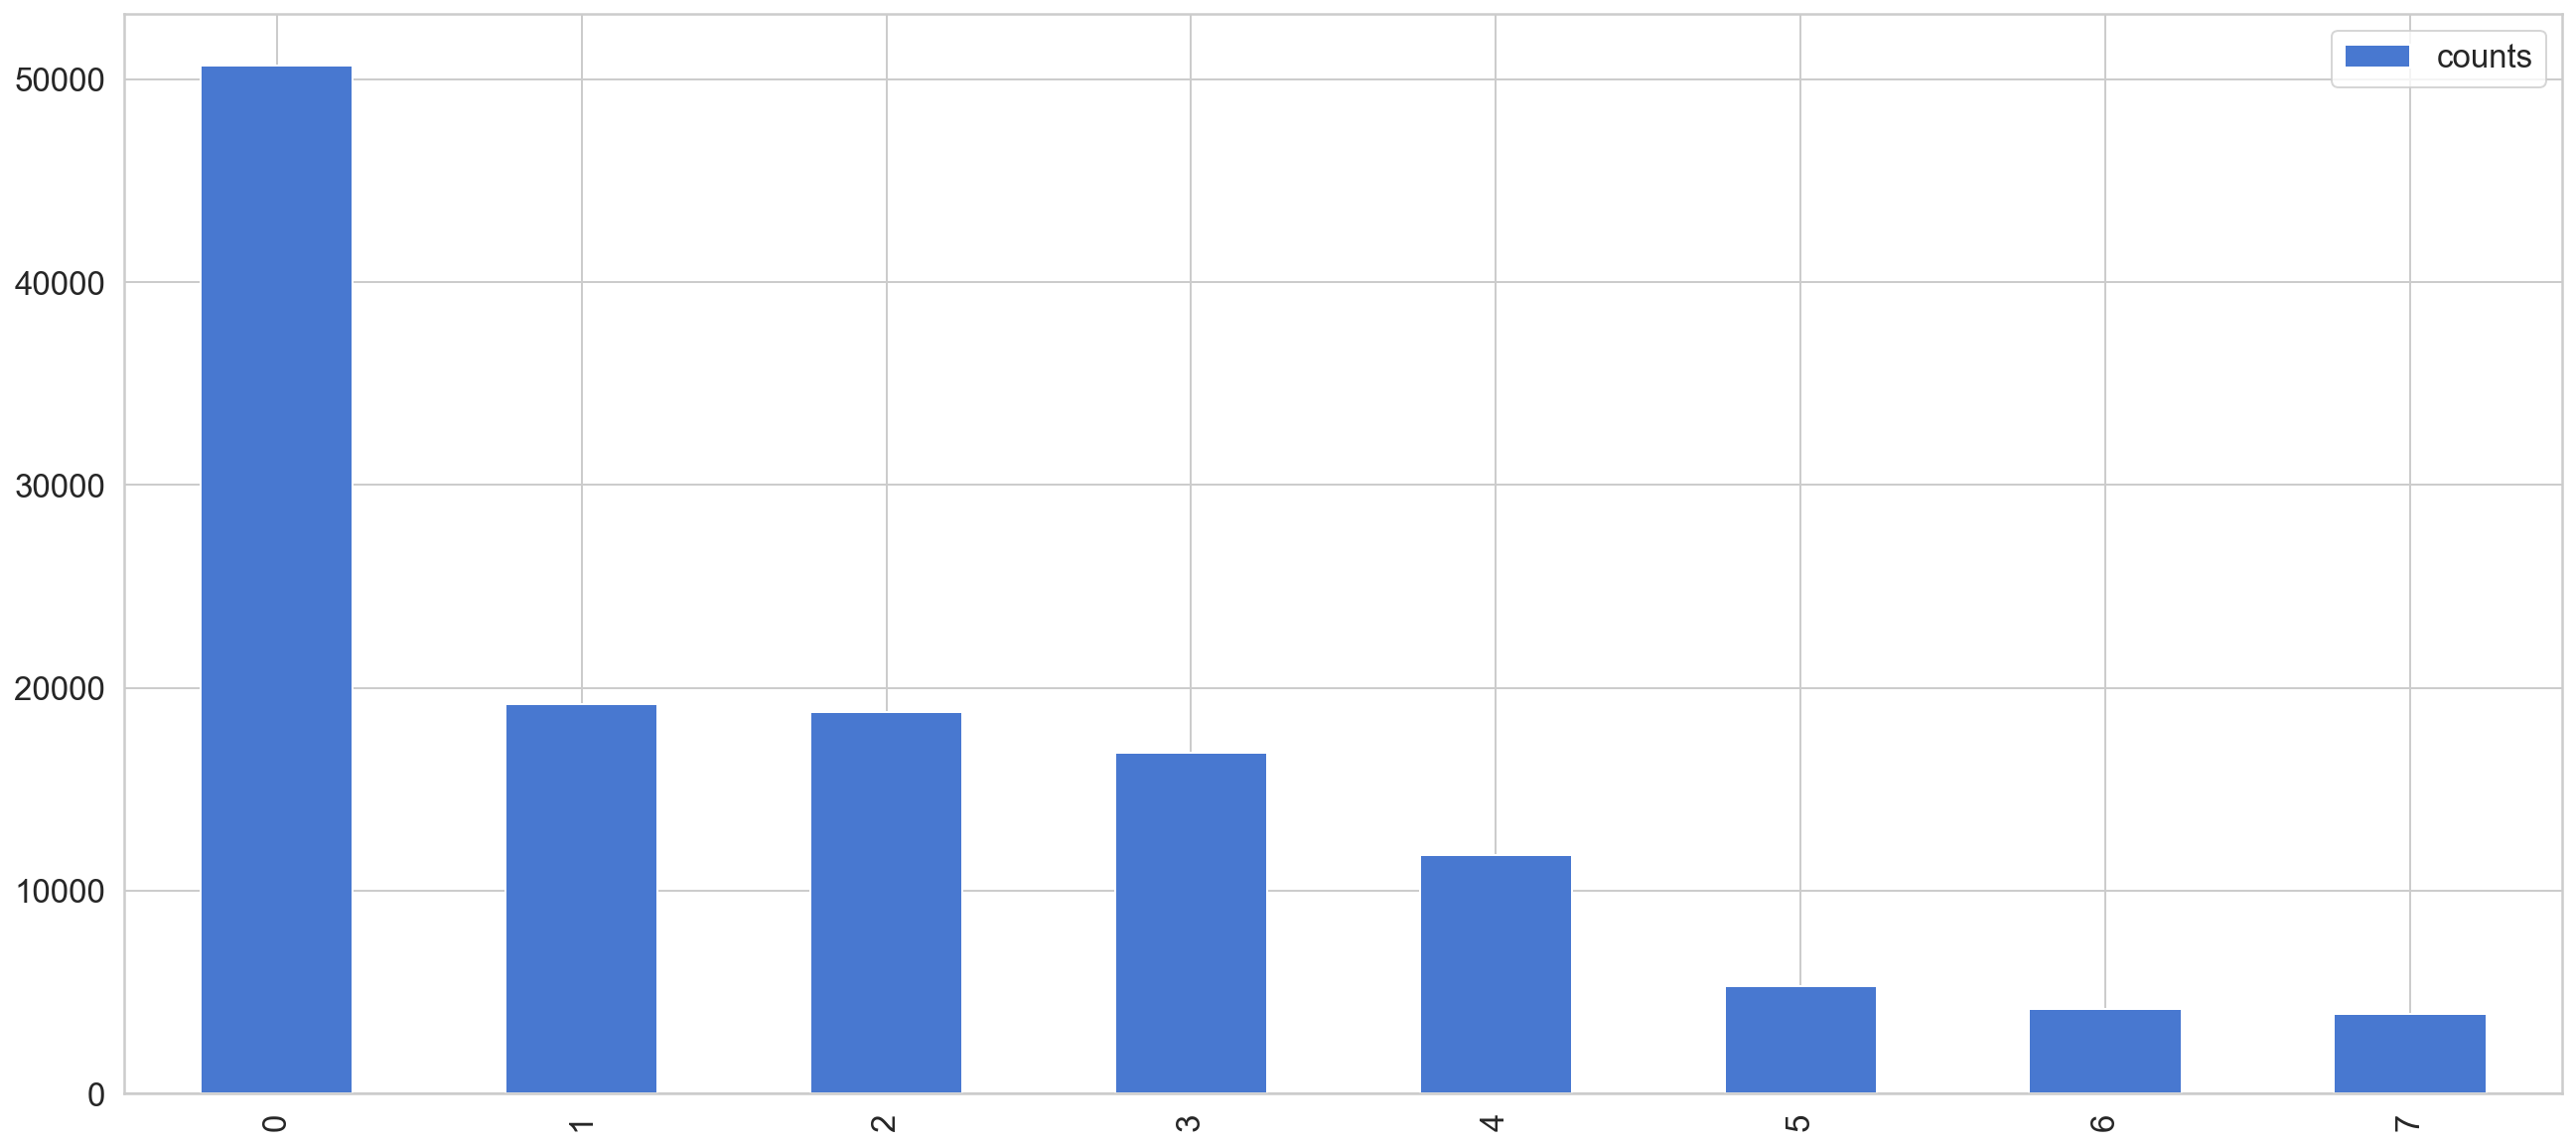

In [105]:
carr_id[['carr_id','counts']].plot(kind='bar')

In [106]:
 mean_payer_fsc = list(carr_id['carr_id'])

In [107]:
mean_payer_fsc

['SPI', 'TSP', 'MB', 'BC', 'UH', '-1', 'AP', 'CI']

In [108]:
df['payer_wgt'] = ''
for i in range(0,df['Paying_Financial_Class_1'].shape[0]):
    if df['Paying_Financial_Class_1'][i] in mean_payer_fsc:
        df['payer_wgt'][i] = 'below80'
    else:
        df['payer_wgt'][i] = 'above80'

In [109]:
df['payer_wgt'].value_counts()

below80    130638
above80     32772
Name: payer_wgt, dtype: int64

In [110]:
df = df[df['payer_wgt']=='below80']

In [111]:
df['Denial_Group'].unique()

array(['Not Denied', 'PREVIOUSLY PAID', 'NON COVERED SERVICE',
       'COORDINATION OF BENEFITS', 'PATIENT RESP', 'REGISTRATION ISSUE',
       'DUPLICATE SERVICE', 'ADDITIONAL INFORMATION NEEDED',
       'DIAGNOSIS OR PROCEDURE ISSUE', 'APPEALABLE', 'Not Specified',
       'AUTHORIZATION ISSUE', 'BUNDLED SERVICE ISSUE', 'TIMELY FILING',
       'MEDICAL NECESSITY', 'PAYMENT ADJUSTMENT ISSUE',
       'CREDENTIALING ISSUE', 'CLAIM FILING ISSUE', 'OTHER/UNSPECIFIED',
       'SERVICE NOT COVERED- APPEAL DENIED', 'APPROPRIATE NON PAYABLE',
       'REFERRING PROVIDER ISSUE', 'CERTIFICATION ISSUE',
       'ADDITIONAL INFORMATION REQUESTED', 'NON COVERED DIAGNOSIS',
       'ADDITIONAL INFORMATION'], dtype=object)

In [112]:
df['denial_catogary']=''
non_predictable_denials =  ["REGISTRATION ISSUE",
                                "NON COVERED SERVICE",
                                "PATIENT RESP",
                             'TIMELY FILING',
                            'REGISTRATION ISSUE',
                                "COORDINATION OF BENEFITS",
                                "SERVICE NOT COVERED- APPEAL DENIED",
                                "CREDENTIALING ISSUE",
                                "REFERRING PROVIDER ISSUE",
                                
                                'PREVIOUSLY PAID']
for i in range(0,df.shape[0]):

    if (df['Denial_Group'].iloc[i] in non_predictable_denials): 
        df['denial_catogary'].iloc[i]= 'non_predicatable_denial'
    elif(df['Denial_Group'].iloc[i] in ['Not Denied']):
        df['denial_catogary'].iloc[i]= 'paid'
    else:
        df['denial_catogary'].iloc[i]= 'predicatable'

## DENIAL CATEGORY AND ITS DISTRIBUTION

<AxesSubplot:>

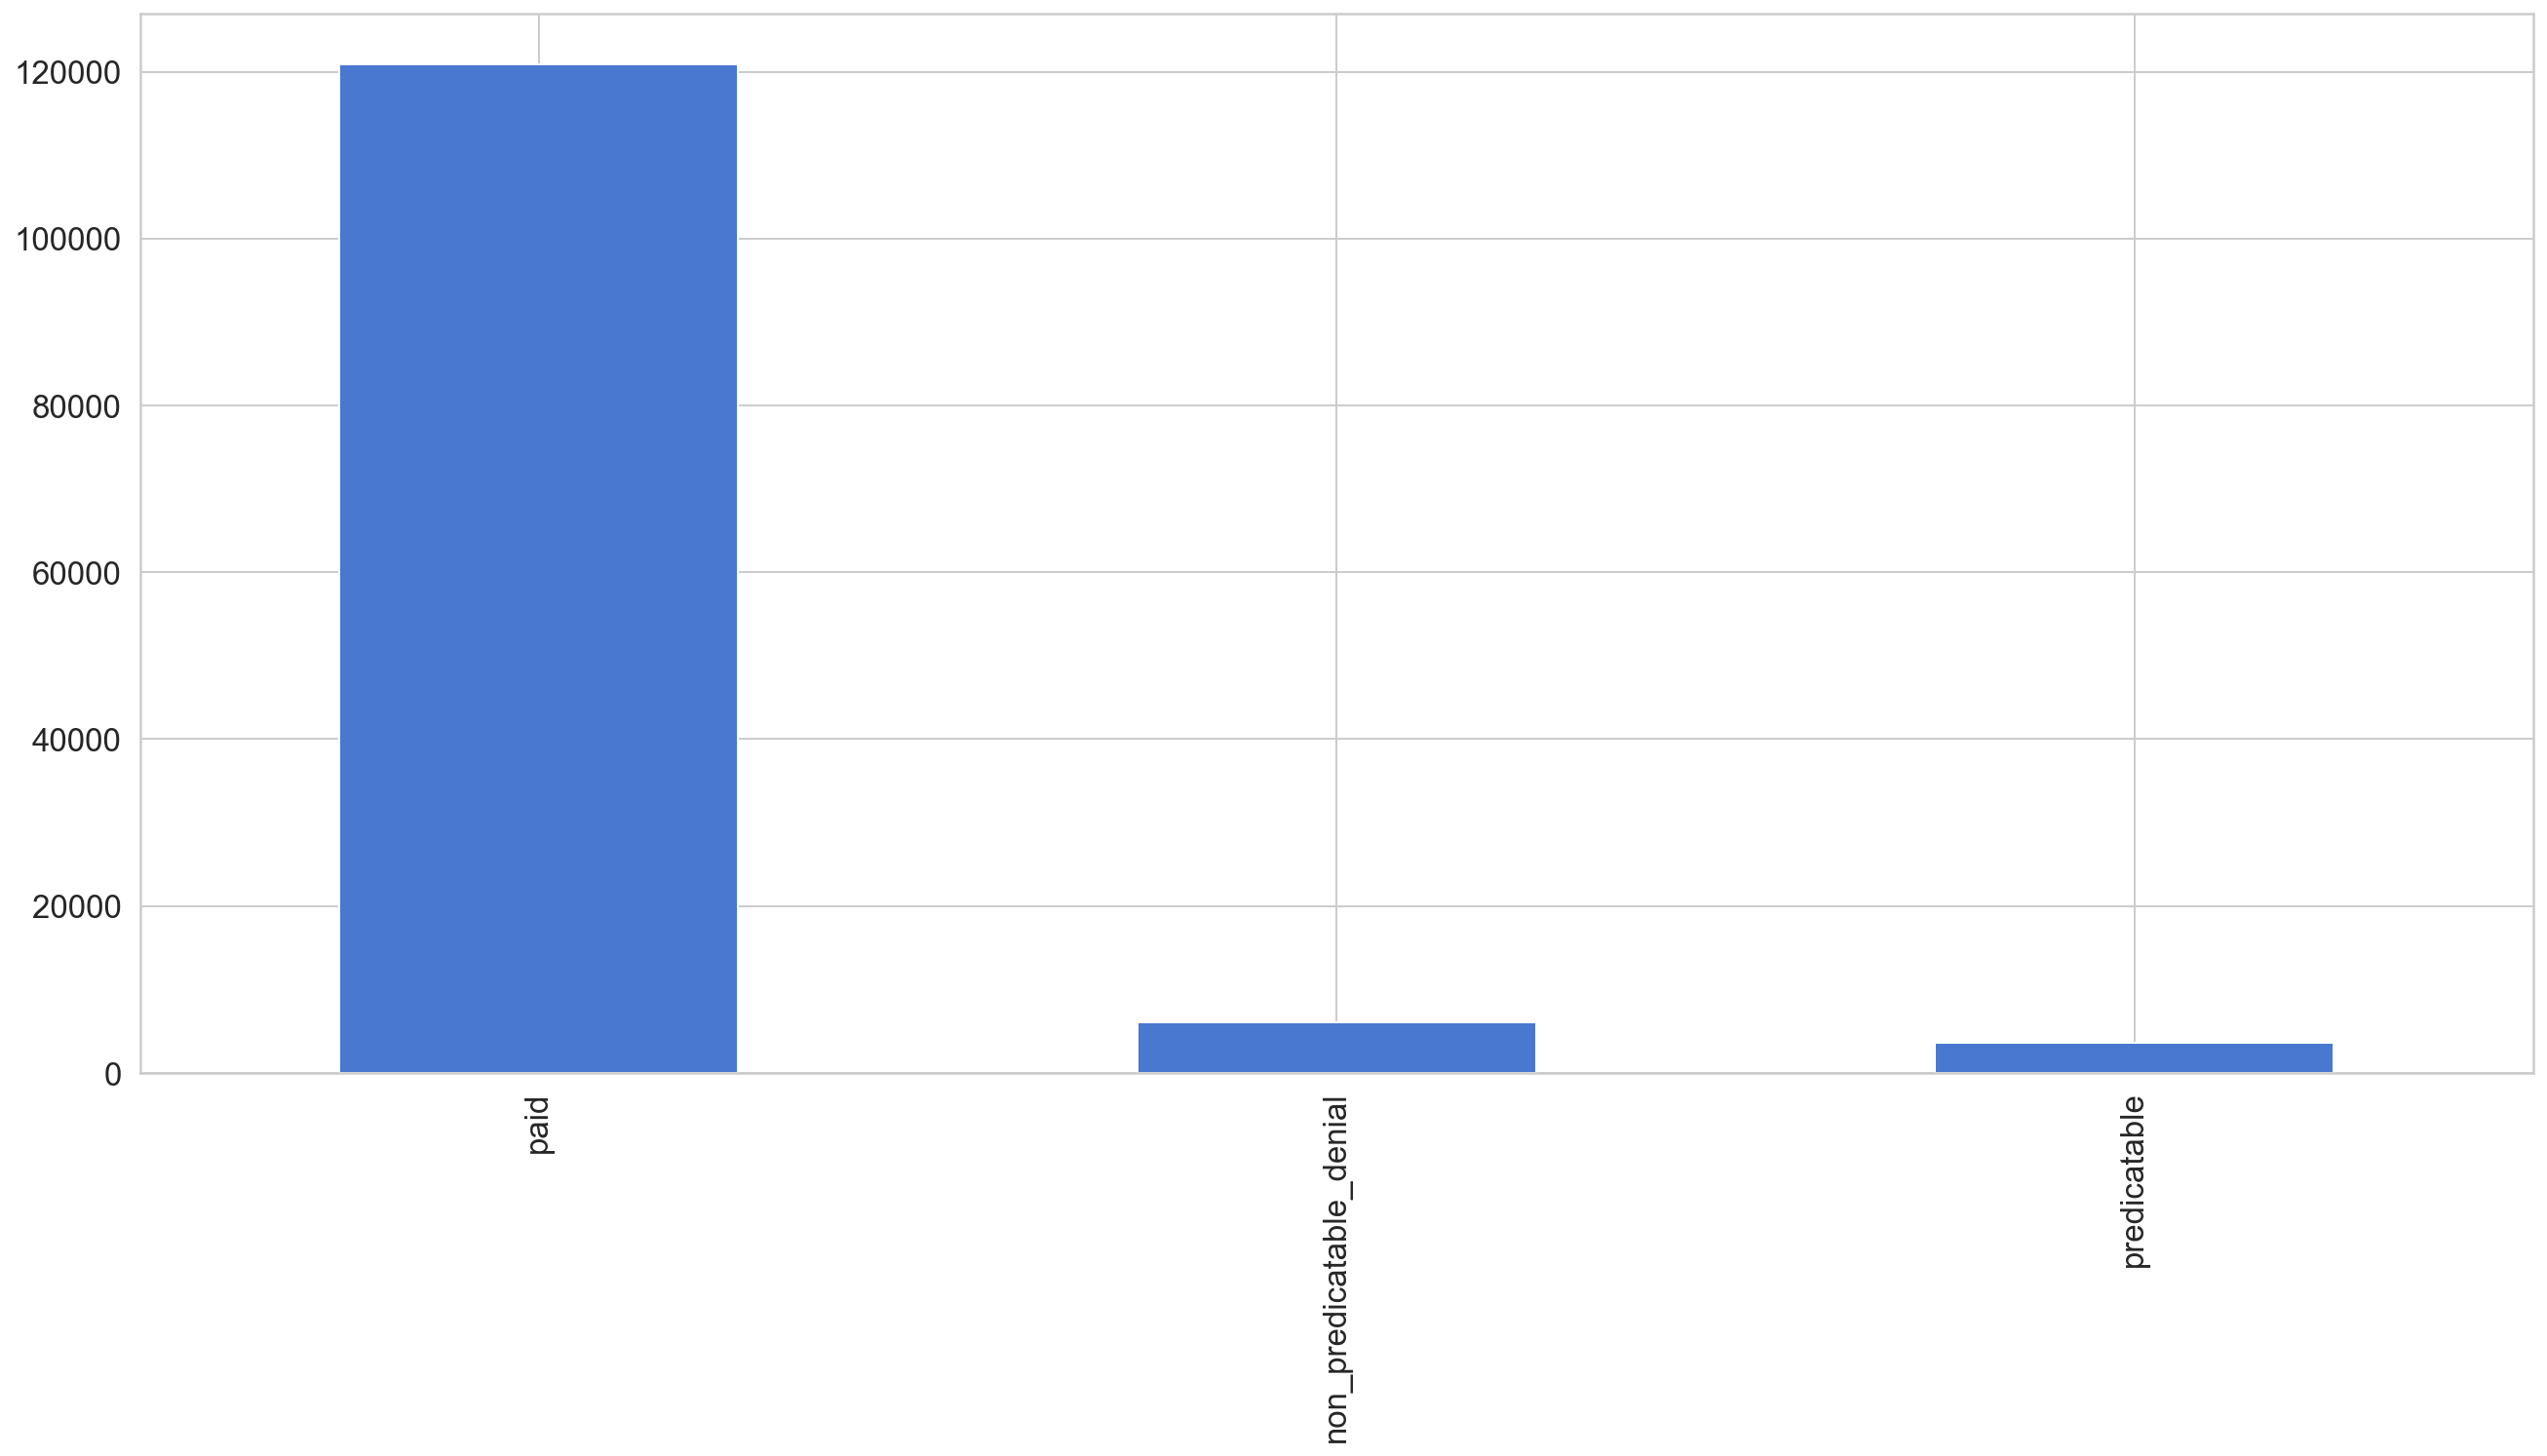

In [113]:
df['denial_catogary'].value_counts().plot(kind='bar')

### exampting non_predictable denials

In [114]:
df=df[df['denial_catogary']!='non_predicatable_denial']

In [119]:
# Basically as per the SME nan as Non-denials.

df['Denial_Code'].fillna('nodndcode',inplace=True)

### Further analyizing denial group and applying 80/20 rule, Keeping 99 cummulative %  i.e Majority of denial which accounts  for 99% of the volume.

In [121]:
# Further analyizing denial group and applying 80/20 rule, Keeping 99 cummulative %  i.e Majority of denial which accounts 
# for 99% of the volume.

dnd_group = df[['Denial_Group']].value_counts()
dnd_group = dnd_group.reset_index()
dnd_group.columns = ['dnd_grp','counts']
dnd_group['percentage'] = dnd_group['counts']/dnd_group['counts'].sum()
dnd_group['cum_percentage'] = 100*(dnd_group.counts.cumsum() / dnd_group.counts.sum())

In [122]:
dnd_group = dnd_group[dnd_group['cum_percentage']<=99.781565]

In [123]:
dnd_group

dnd_grp  counts  percentage  cum_percentage
0                     Not Denied  120929    0.971146       97.114566
1              DUPLICATE SERVICE    1092    0.008770       97.991520
2            AUTHORIZATION ISSUE     781    0.006272       98.618718
3                  Not Specified     511    0.004104       99.029087
4                     APPEALABLE     433    0.003477       99.376817
5  ADDITIONAL INFORMATION NEEDED     263    0.002112       99.588025
6              MEDICAL NECESSITY     241    0.001935       99.781565

In [124]:
df['main_denials']=''

for i in range(0,df.shape[0]):

    if (df['Denial_Group'].iloc[i] in list(dnd_group['dnd_grp'])): 
        df['main_denials'].iloc[i]= 'major_denial'
    else:
        df['main_denials'].iloc[i]= 'non_major'
        
df = df[df['main_denials']=='major_denial']

In [127]:
#df.to_csv('modified_book1.csv')

In [ ]:
### 

In [130]:
df['Primary_Date_Filed'] = pd.to_datetime(df['Primary_Date_Filed'])
df['Check_Date'] =  pd.to_datetime(df['Check_Date'])

In [131]:
df['process_time']= df['Check_Date'] - df['Primary_Date_Filed']

In [132]:
df = df[df['Procedure_ID']!='\t00000']

In [133]:
df['Transaction_Code'].unique()

array(['ZATY', 'ZRPD', 'ZRUW', 'REP', 'COP', 'CON', 'ZSEQ', 'MCN', 'REI',
       'BSN', 'BSP', 'ZRPW', 'ZRPI', 'CRE', 'ZRUI', 'CHE', 'CCGC', 'MDN',
       'ECHK', 'WCN', 'NEG', 'ITD', 'MDP', 'APP', 'CCP', 'MCP', 'CPD',
       'SET', 'OON', 'DCAR', 'NB', 'CCD', 'CAS', 'ZQMB', 'RER', 'ZIA',
       'NOTP', 'BCD', 'WITH', 'ZRUD', 'CRUR', 'SBC', 'PTDA', 'ADMI',
       'BAN', 'BCP', 'BCN', 'ADM', 'TSC', 'INSW', 'CHP', 'CLB', 'TOSC',
       'ZINT', 'MNPS', 'MED', 'NOAU', 'COL', 'IA', 'BIWO', 'BDD', 'COLM',
       'HARD', 'CHAR', 'PFL', 'PTF', 'WCP', 'WOAR', 'NMED', 'DBC', 'TOMO',
       'NPN', 'AHOS', 'BCC', 'TOSP', 'WCL', 'EMP', 'RHC', 'ZRTI', 'ZRCW',
       'PAP', 'NCD', 'CLW', 'OUT', 'DEC', 'ZPLA', 'PLAP', 'PLAC', 'NOCH',
       'PTWO', 'PROM', 'PAT', 'ACC', 'CHA', 'PRM', 'ZMLP', 'ZADJ', 'IPC'],
      dtype=object)

In [134]:
df = df[['Denial_Ind','Denial_Code','Denial_Group',
         'Primary_Carrier_ID','Place_Of_Service',
         'Department','Procedure_ID', 'Procedure_Group',
         'Modifier' ,'Primary_ICD_9','process_time',
         'Amount','Is_Facility','Primary_Carrier_Group','Paying_Carrier_Type']]

## feature creation

In [136]:
df['dx_grp']=df['Primary_ICD_9'].apply(lambda x:str(x)[0:1])

In [137]:
df['Modifier'].fillna('No_mod',inplace=True) 

In [138]:
#https://stackoverflow.com/questions/55426692/how-to-handle-empty-cells-that-pandas-does-not-recognize
df['Modifier'] = df['Modifier'].str.strip().replace('',np.nan)

In [139]:
df['Modifier'].fillna("No_mod",inplace = True)

In [140]:
df['Modifier'].unique()

array(['No_mod', 'Q6', 'LT', 'RT', 'X5', 'TC', '59', '26', 'JW', 'PS',
       '52', 'PI', '76', '3P', 'FY', 'QC', 'MH', 'QW', '77', 'F6', 'CT',
       'T4', 'FA', 'TA', 'F7', '53', 'F5', 'F9', 'F2', '50', 'GW', 'Q0',
       'F4'], dtype=object)

## Paid (N) V/s Denial (Y)


<AxesSubplot:>

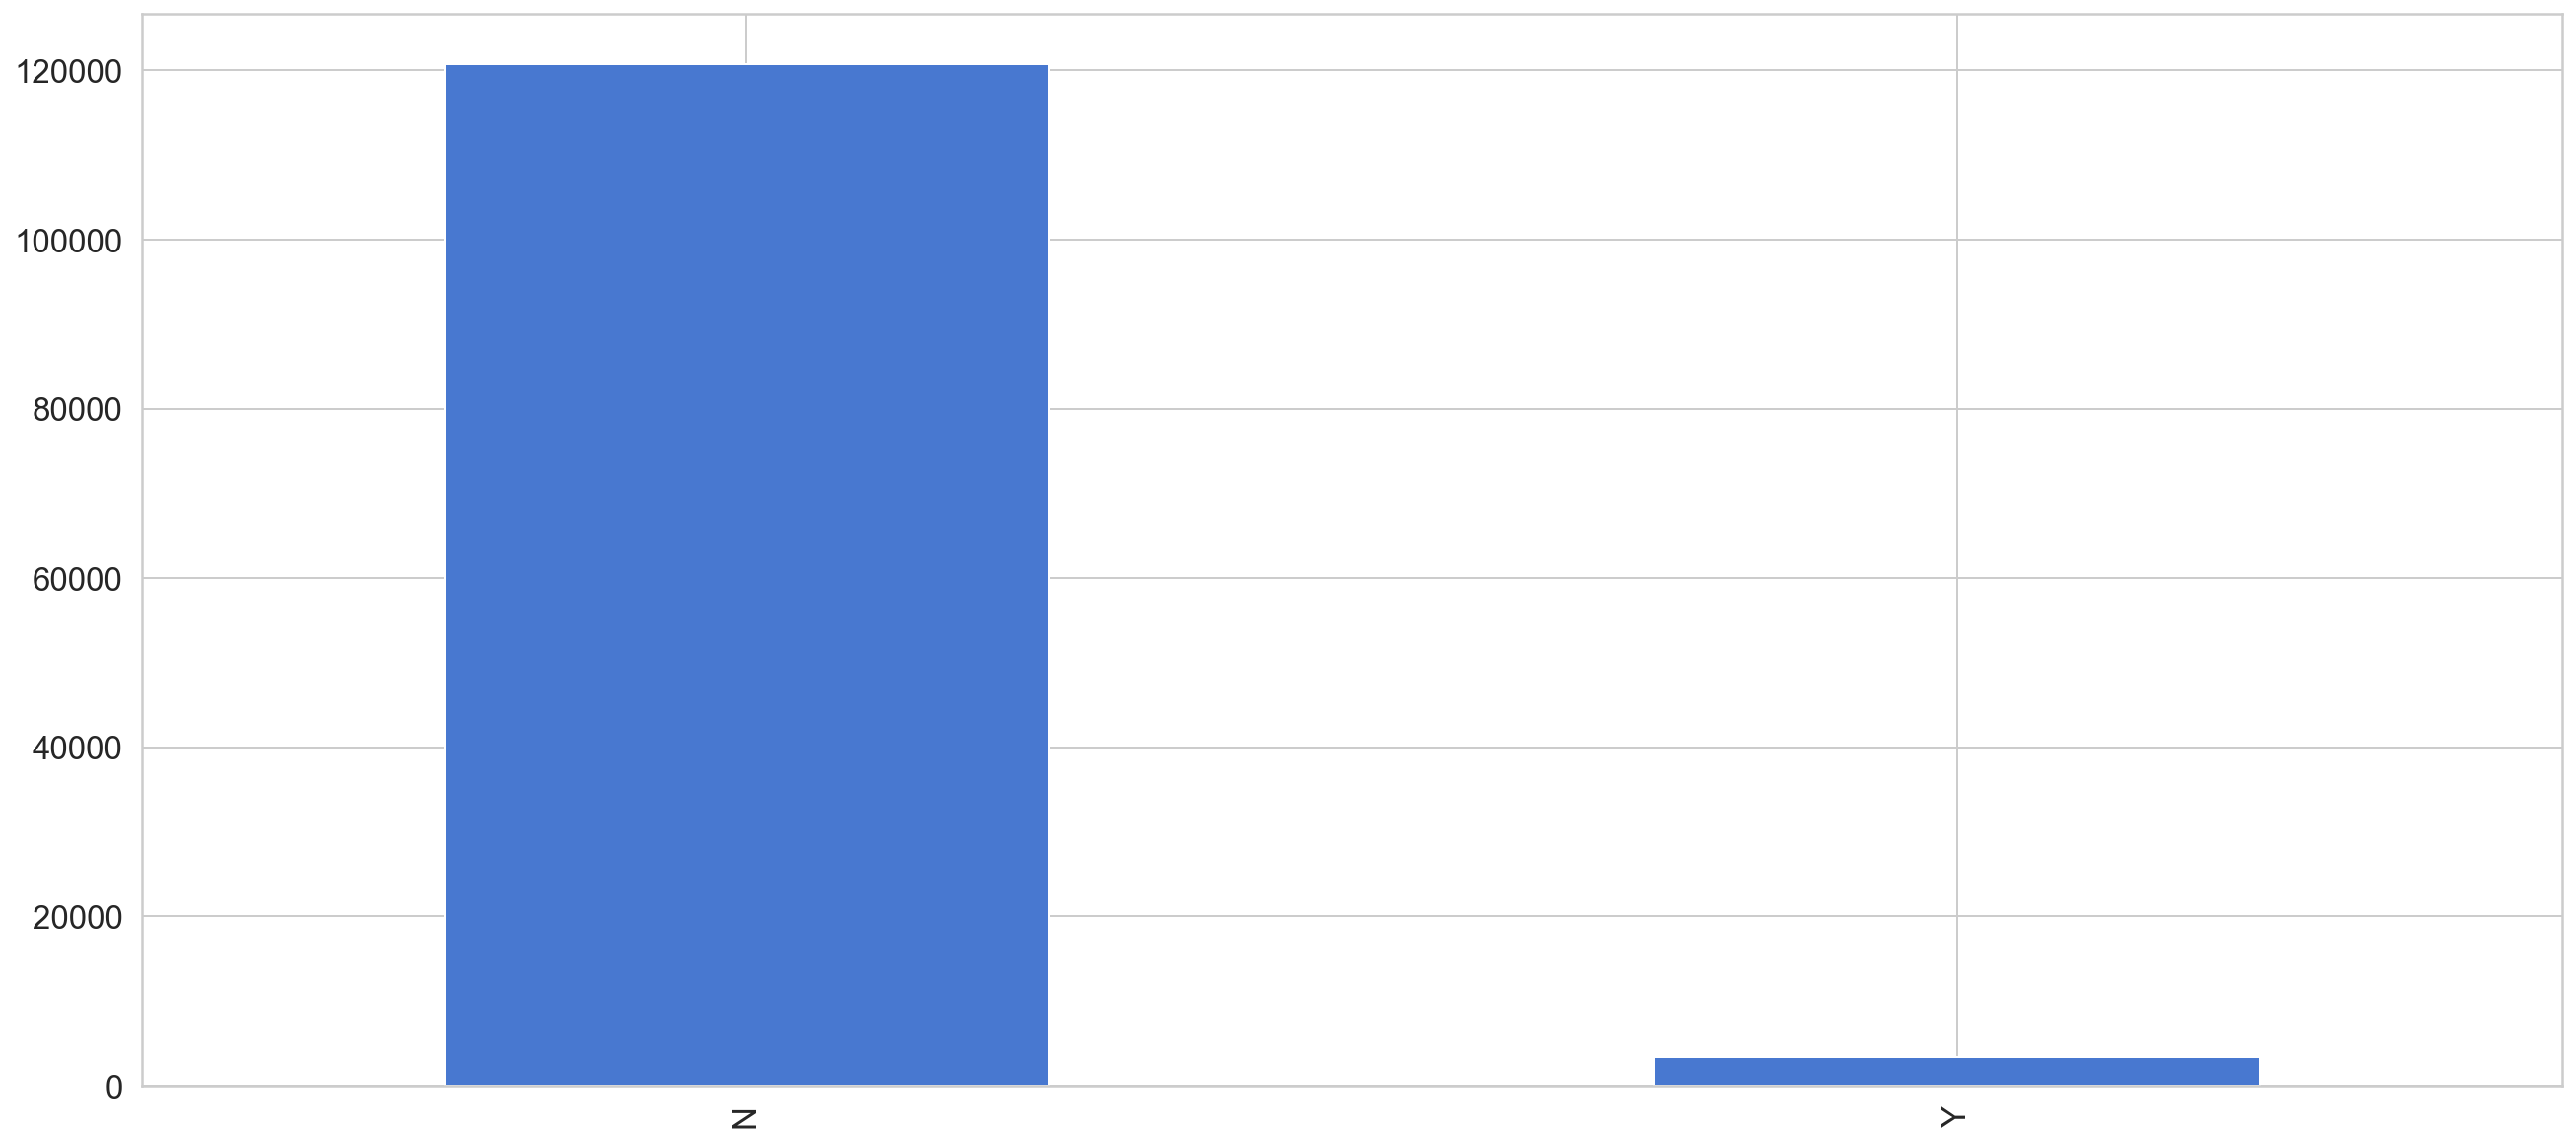

In [141]:
df['Denial_Ind'].value_counts().plot(kind='bar')

## Paid V/s Denial Types

<AxesSubplot:>

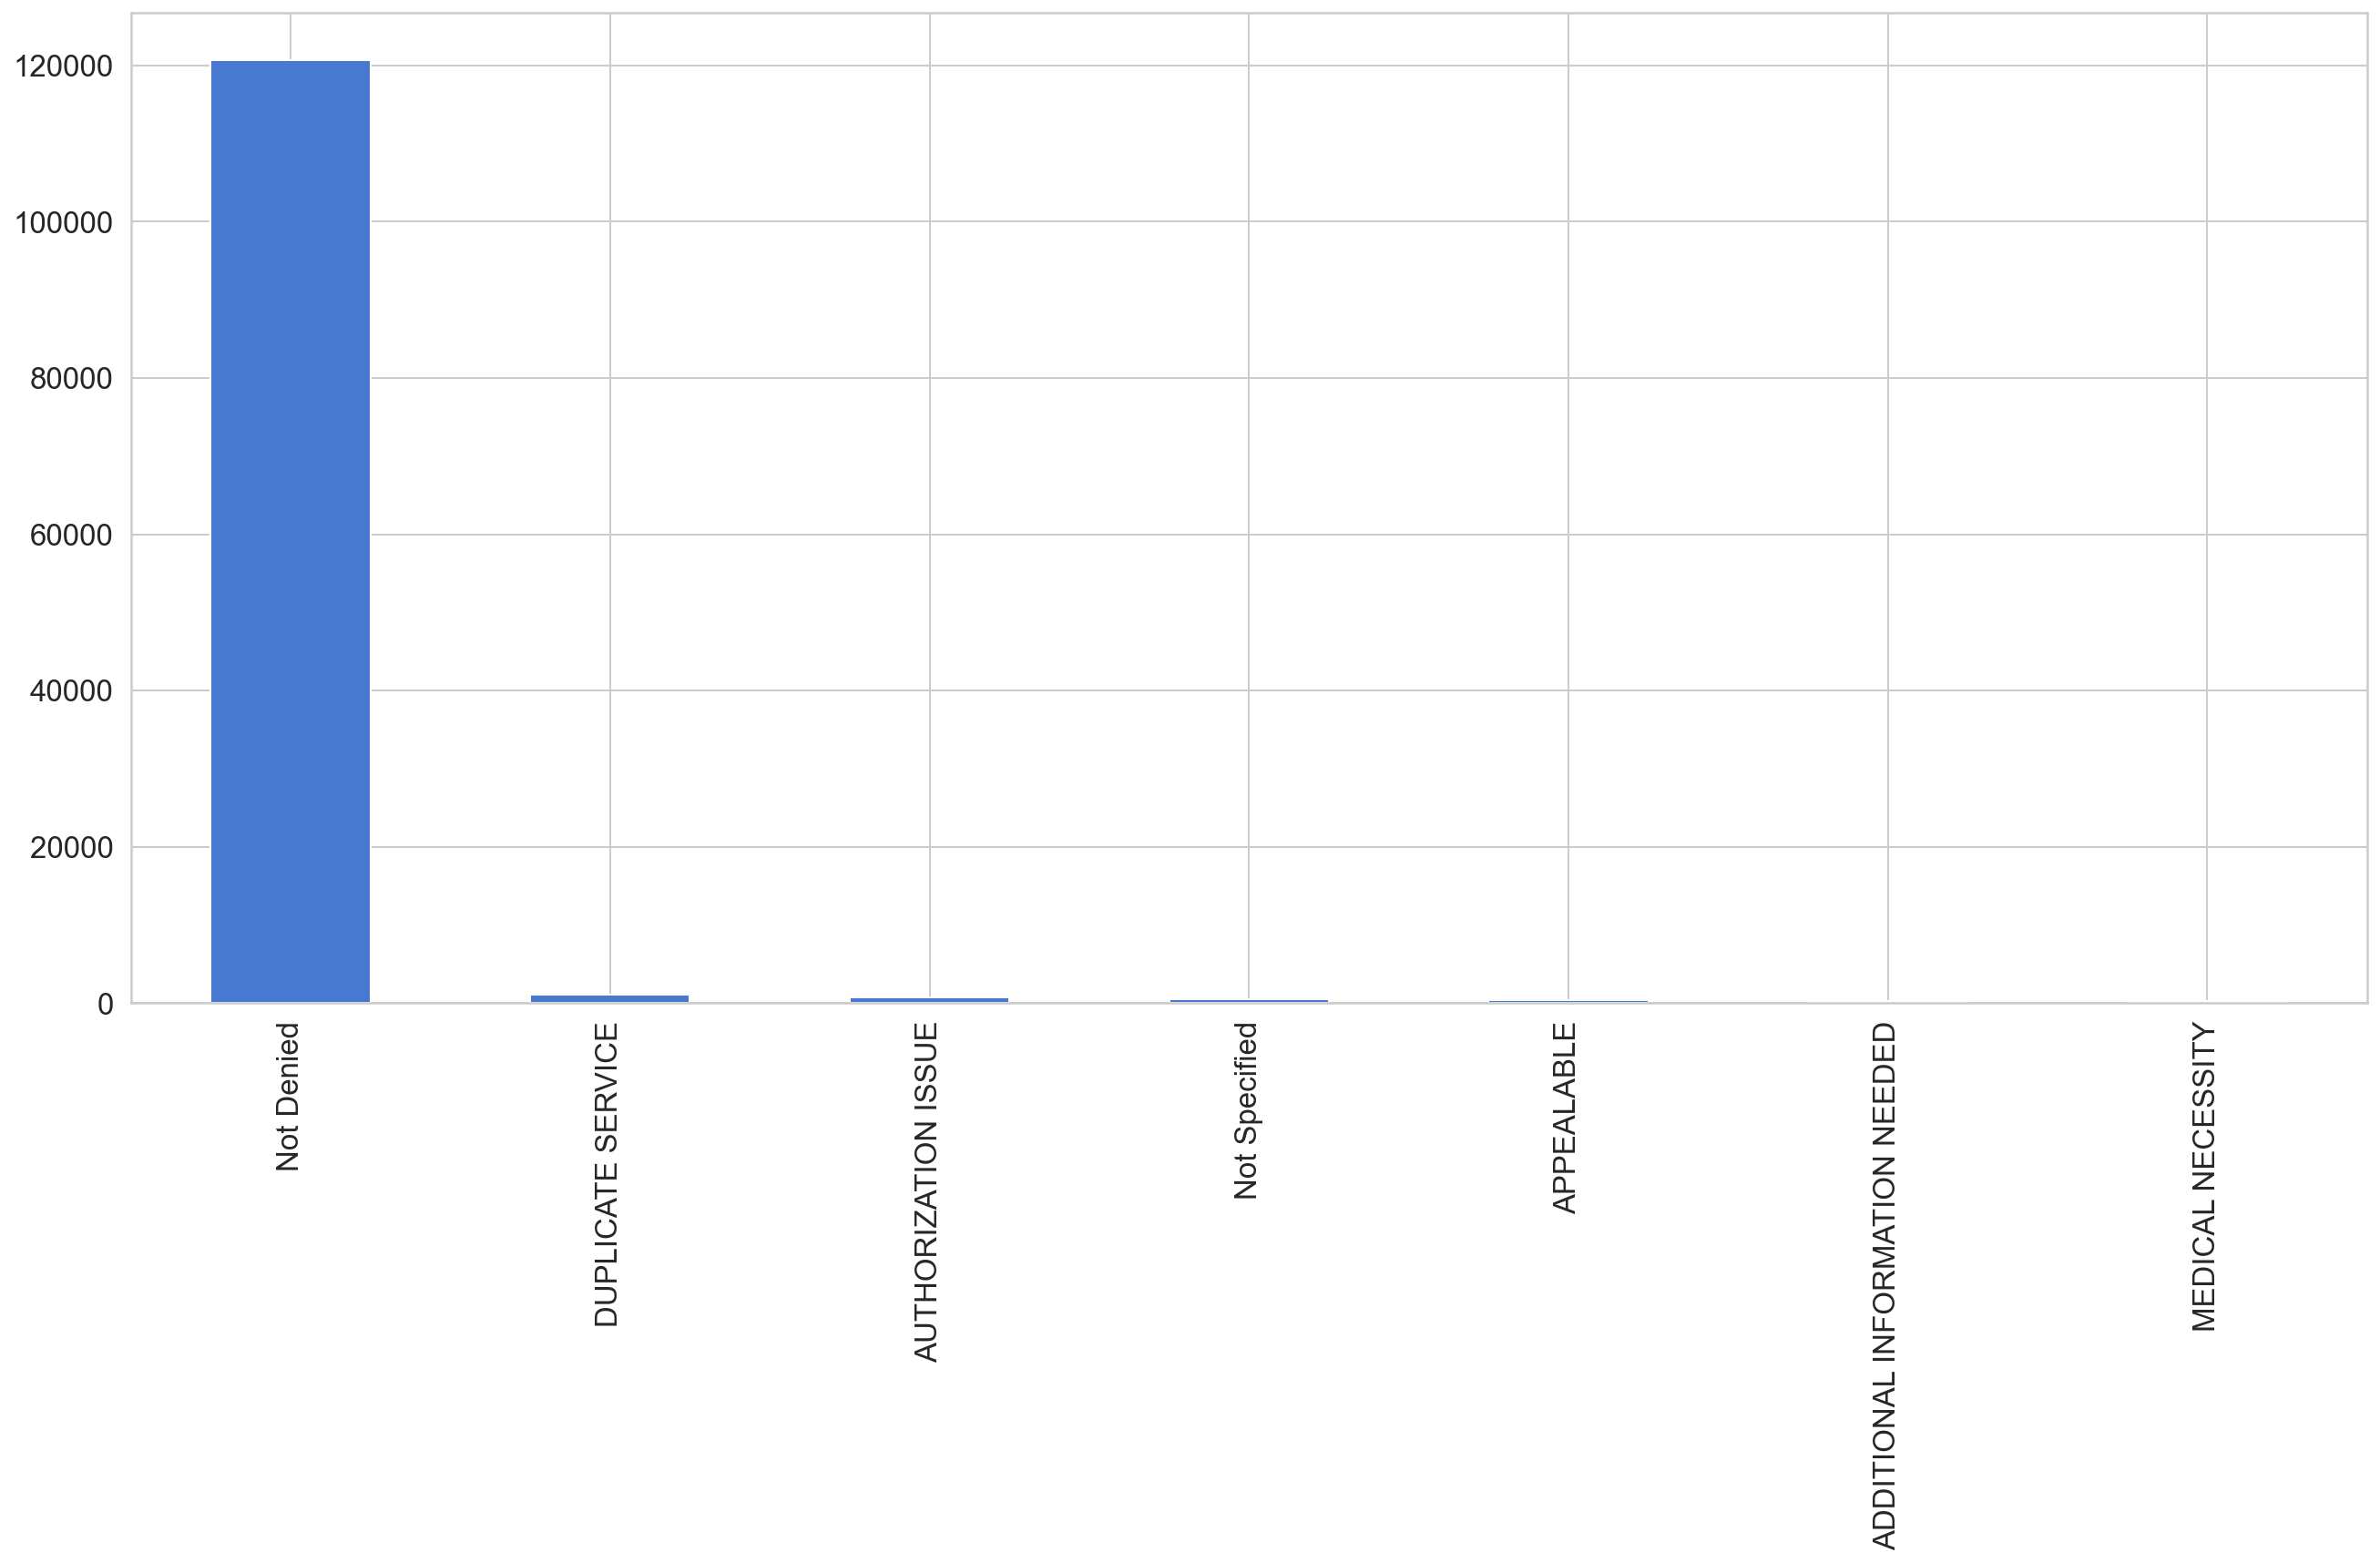

In [142]:
df['Denial_Group'].value_counts().plot(kind='bar')

There 3 variables to predict and all are highly inbalanced.

## preprocessing

In [144]:
df.Denial_Ind = df.Denial_Ind.str.replace("N",'0')
df.Denial_Ind = df.Denial_Ind.str.replace("Y",'1')
df.Denial_Ind.unique()

array(['0', '1'], dtype=object)

In [145]:
df = df.replace(' ','_')
df.Denial_Group = df.Denial_Group.apply(lambda x: str(x).replace(' ','_'))
df.Primary_Carrier_Group = df.Primary_Carrier_Group.str.replace(' ','_')
df.Procedure_Group = df.Procedure_Group.str.replace(' ','_')
df.Paying_Carrier_Type = df.Paying_Carrier_Type.str.replace(' ','_')
df.Place_Of_Service = df.Place_Of_Service.str.replace('\W+', '')
df.Place_Of_Service.value_counts()
df.Place_Of_Service.fillna('11',inplace= True)
df.Department = df.Department.str.replace(' ','_') 
df.Procedure_Group = df.Procedure_Group.str.replace(' ','_') 

In [149]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['Denial_Group'])
df['Denial_Group_endcoded']= le.transform(df['Denial_Group'])
df['Denial_Group_endcoded']
import time as dt

print(df['Denial_Ind'].unique())
print(df['Denial_Group_endcoded'].unique())
print(df['process_time'].head(3))

['0' '1']
[5 3 0 1 6 2 4]
112   417 days
114    67 days
115   185 days
Name: process_time, dtype: timedelta64[ns]


In [150]:
df['process_time'] = df['process_time'].dt.days

In [154]:
df['process_time'].isna().unique()
df['process_time'].fillna(0,inplace = True)
df['process_time'].isna().unique()

array([False])

In [159]:
df.isnull().sum()

Denial_Ind                   0
Denial_Code                  0
Denial_Group                 0
Primary_Carrier_ID           0
Place_Of_Service             0
Department                   0
Procedure_ID                 0
Procedure_Group              0
Modifier                     0
Primary_ICD_9            15202
process_time                 0
Amount                       0
Is_Facility                  0
Primary_Carrier_Group        0
Paying_Carrier_Type          0
dx_grp                       0
Denial_Group_endcoded        0
dtype: int64

# Test Train and Validation


Feature Description

Predict
1. Denial_Ind- Claim is denied or paid 
2. Denial_Code- Type of denial
3. Denial_Group- Denial are grouped in groups such eligibility denial or service not covered  

Attribute

4. Primary_Carrier_ID- Payer/Insurance is given a code internally
5. Place_Of_Service- where the service is performed outpatient or inpatient
6. Department- where the service performed under oncology etc
7. Procedure_ID- the service such Mri scan or CT scan are given a standard code.
8. Procedure_Group: the different types of Mri are grouped under Mri.
9. Paying_Carrier_Type: Insurance type
10. Modifier: Any service modification is indicated by Modifier.
11. Amount: Claim amount billed 
12. Is_Facility: The Medical center or diagnostic is in contract with the payer or not 
13. dx_grp: Diseases group


In [175]:
y_true = df[['Denial_Ind']].values
result = df[['Primary_Carrier_ID',
             'Place_Of_Service', 
             'Department', 
             'Procedure_ID', 
             'Procedure_Group',
             'Primary_Carrier_Group', 
             'Modifier',
             'Paying_Carrier_Type',
             'Is_Facility',
             'Amount',
             'dx_grp']]
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [176]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 79382
Number of data points in test data: 24807
Number of data points in cross validation data: 19846


## Confusion Matrix Function

In [177]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [0,1]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

## MultiClass AUC function

In [178]:
# AUC scores for multiclass

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

# Baseline Model/Random Model

In [185]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# train-Set error.
print("-"*20,"train Data","-"*20)
train_data_len = train_df.shape[0]
train_predicted_y = np.zeros((train_data_len,2))
for i in range(train_data_len):
    rand_probs = np.random.rand(1,2)
    train_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("TRAIN Log loss on Cross Validation Data using Random Model",log_loss(y_train.astype('int'),train_predicted_y, eps=1e-15))

predicted_y =np.argmax(train_predicted_y, axis=1)
print(classification_report(y_train.astype('int'), predicted_y))
print("AUC Train data:", multiclass_roc_auc_score(y_train,predicted_y,average="macro"))
print("__"*50)

print("-"*20,"CV Data","-"*20)
# CV-Set error.
# we create a output array that has exactly same size as the CV data
cv_data_len = cv_df.shape[0]
cv_predicted_y = np.zeros((cv_data_len,2))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,2)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("CV Log loss on Cross Validation Data using Random Model",log_loss(y_cv.astype('int'),cv_predicted_y, eps=1e-15))
predicted_y =np.argmax(cv_predicted_y, axis=1)
print(classification_report(y_cv.astype('int'), predicted_y))
print("AUC cv data:", multiclass_roc_auc_score(y_cv.astype('int'),predicted_y,average="macro"))


print("__"*50)
# Test-Set error.
#we create a output array that has exactly same as the test data
print("-"*20,"Test Data","-"*20)
test_data_len = test_df.shape[0]
test_predicted_y = np.zeros((test_data_len,2))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,2)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Test Log loss on Test Data using Random Model",log_loss(y_test.astype('int'),test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)

print(classification_report(y_test.astype('int'), predicted_y))
print("AUC test data:", multiclass_roc_auc_score(y_test.astype('int'),predicted_y,average="macro"))

-------------------- train Data --------------------
TRAIN Log loss on Cross Validation Data using Random Model 0.8860875279701975
              precision    recall  f1-score   support

           0       0.97      0.50      0.66     77256
           1       0.03      0.51      0.05      2126

    accuracy                           0.50     79382
   macro avg       0.50      0.51      0.36     79382
weighted avg       0.95      0.50      0.64     79382

AUC Train data: 0.5
____________________________________________________________________________________________________
-------------------- CV Data --------------------
CV Log loss on Cross Validation Data using Random Model 0.8890963685342529
              precision    recall  f1-score   support

           0       0.97      0.50      0.66     19314
           1       0.03      0.48      0.05       532

    accuracy                           0.50     19846
   macro avg       0.50      0.49      0.35     19846
weighted avg       0.95 

In [75]:
# Shape of the all partitions 
print('train_df', train_df.shape, 'y_train', y_train.shape)
print('test_df', test_df.shape, 'y_test', y_test.shape)
print('cv_df', cv_df.shape, 'y_cv', y_cv.shape)

train_df (79382, 11) y_train (79382, 1)
test_df (24807, 11) y_test (24807, 1)
cv_df (19846, 11) y_cv (19846, 1)


In [76]:
print('-------train_df-------')
print(train_df .isnull().sum())
print('-------test_df-------')
print(test_df .isnull().sum())
print('-------cv_df-------')
print(cv_df .isnull().sum())

-------train_df-------
Primary_Carrier_ID       0
Place_Of_Service         0
Department               0
Procedure_ID             0
Procedure_Group          0
Primary_Carrier_Group    0
Modifier                 0
Paying_Carrier_Type      0
Is_Facility              0
Amount                   0
dx_grp                   0
dtype: int64
-------test_df-------
Primary_Carrier_ID       0
Place_Of_Service         0
Department               0
Procedure_ID             0
Procedure_Group          0
Primary_Carrier_Group    0
Modifier                 0
Paying_Carrier_Type      0
Is_Facility              0
Amount                   0
dx_grp                   0
dtype: int64
-------cv_df-------
Primary_Carrier_ID       0
Place_Of_Service         0
Department               0
Procedure_ID             0
Procedure_Group          0
Primary_Carrier_Group    0
Modifier                 0
Paying_Carrier_Type      0
Is_Facility              0
Amount                   0
dx_grp                   0
dtype: int64


# Encoding

In [186]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(train_df['Primary_Carrier_ID'].values)

x_train_Primary_Carrier_ID = vectorizer.transform(train_df['Primary_Carrier_ID'].astype('category'))
x_test_Primary_Carrier_ID = vectorizer.transform(test_df['Primary_Carrier_ID'].astype('category'))
x_cv_Primary_Carrier_ID = vectorizer.transform(cv_df['Primary_Carrier_ID'].astype('category'))

print('x_train_Primary_Carrier_ID', x_train_Primary_Carrier_ID.shape)
print('x_test_Primary_Carrier_ID', x_test_Primary_Carrier_ID.shape)
print('x_cv_Primary_Carrier_ID', x_cv_Primary_Carrier_ID.shape)

vectorizer = CountVectorizer()
vectorizer.fit(train_df['Place_Of_Service'].values)

x_train_Place_Of_Service = vectorizer.transform(train_df['Place_Of_Service'].astype('category'))
x_test_Place_Of_Service = vectorizer.transform(test_df['Place_Of_Service'].astype('category'))
x_cv_Place_Of_Service = vectorizer.transform(cv_df['Place_Of_Service'].astype('category'))

print(' '*50)
print('x_train_Place_Of_Service', x_train_Place_Of_Service.shape)
print('x_test_Place_Of_Service', x_test_Place_Of_Service.shape)
print('x_cv_Place_Of_Service', x_cv_Place_Of_Service.shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(train_df['Department'].values)
x_train_Department = vectorizer.transform(train_df['Department'].astype('category'))
x_test_Department = vectorizer.transform(test_df['Department'].astype('category'))
x_cv_Department = vectorizer.transform(cv_df['Department'].astype('category'))

print(' '*50)
print('x_train_Department', x_train_Department.shape)
print('x_test_Department', x_test_Department.shape)
print('x_cv_Department', x_cv_Department.shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(train_df['Procedure_ID'].values)

x_train_Procedure_ID = vectorizer.transform(train_df['Procedure_ID'].astype('category'))
x_test_Procedure_ID = vectorizer.transform(test_df['Procedure_ID'].astype('category'))
x_cv_Procedure_ID = vectorizer.transform(cv_df['Procedure_ID'].astype('category'))

print(' '*50)
print('x_train_Procedure_ID', x_train_Procedure_ID.shape)
print('x_test_Procedure_ID', x_test_Procedure_ID.shape)
print('x_cv_Procedure_ID ', x_cv_Procedure_ID .shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(train_df['Procedure_Group'].values)

x_train_Procedure_Group = vectorizer.transform(train_df['Procedure_Group'].astype('category'))
x_test_Procedure_Group = vectorizer.transform(test_df['Procedure_Group'].astype('category'))
x_cv_Procedure_Group = vectorizer.transform(cv_df['Procedure_Group'].astype('category'))

print(' '*50)
print('x_train_Procedure_Group', x_train_Procedure_Group.shape)
print('x_test_Procedure_Group', x_test_Procedure_Group.shape)
print('x_cv_Procedure_Group ', x_cv_Procedure_Group .shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(train_df['Modifier'].values)

x_train_Modifier= vectorizer.transform(train_df['Modifier'].astype('category'))
x_test_Modifier = vectorizer.transform(test_df['Modifier'].astype('category'))
x_cv_Modifier = vectorizer.transform(cv_df['Modifier'].astype('category'))

print(' '*50)
print('x_train_Modifier', x_train_Modifier.shape)
print('x_test_Modifier', x_test_Modifier.shape)
print('x_cv_Modifier ', x_cv_Modifier .shape)
#https://stackoverflow.com/questions/43945180/why-does-countvectorizer-throw-an-empty-vocabulary-error-for-a-bigram-when-the
vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
vectorizer = vectorizer.fit(train_df['dx_grp'].values)

x_train_dx_grp= vectorizer.transform(train_df['dx_grp'].astype('category'))
x_test_dx_grp = vectorizer.transform(test_df['dx_grp'].astype('category'))
x_cv_dx_grp = vectorizer.transform(cv_df['dx_grp'].astype('category'))

print(' '*50)
print('x_train_dx_grp', x_train_dx_grp.shape)
print('x_test_dx_grp', x_test_dx_grp.shape)
print('x_cv_dx_grp ', x_cv_dx_grp .shape)


vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
vectorizer = vectorizer.fit(train_df['Is_Facility'].values)

x_train_Is_Facility= vectorizer.transform(train_df['Is_Facility'].astype('category'))
x_test_Is_Facility = vectorizer.transform(test_df['Is_Facility'].astype('category'))
x_cv_Is_Facility = vectorizer.transform(cv_df['Is_Facility'].astype('category'))

print(' '*50)
print('x_train_Is_Facility', x_train_Is_Facility.shape)
print('x_test_Is_Facility', x_test_Is_Facility.shape)
print('x_cv_Is_Facility ', x_cv_Is_Facility .shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(train_df['Primary_Carrier_Group'].values)

x_train_Primary_Carrier_Group= vectorizer.transform(train_df['Primary_Carrier_Group'].astype('category'))
x_test_Primary_Carrier_Group = vectorizer.transform(test_df['Primary_Carrier_Group'].astype('category'))
x_cv_Primary_Carrier_Groupy = vectorizer.transform(cv_df['Primary_Carrier_Group'].astype('category'))

print(' '*50)
print('x_train_Primary_Carrier_Group', x_train_Primary_Carrier_Group.shape)
print('x_test_Primary_Carrier_Group', x_test_Primary_Carrier_Group.shape)
print('x_cv_Primary_Carrier_Groupy ', x_cv_Primary_Carrier_Groupy .shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(train_df['Paying_Carrier_Type'].values)

x_train_Paying_Carrier_Type= vectorizer.transform(train_df['Paying_Carrier_Type'].astype('category'))
x_test_Paying_Carrier_Type = vectorizer.transform(test_df['Paying_Carrier_Type'].astype('category'))
x_cv_Paying_Carrier_Type= vectorizer.transform(cv_df['Paying_Carrier_Type'].astype('category'))

print(' '*50)
print('x_train_Paying_Carrier_Type', x_train_Paying_Carrier_Type.shape)
print('x_test_Paying_Carrier_Type', x_test_Paying_Carrier_Type.shape)
print('x_cv_Paying_Carrier_Type ', x_cv_Paying_Carrier_Type .shape)


# Numarical columns

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalizer = Normalizer()

vectorizer = MinMaxScaler()
vectorizer = vectorizer.fit(train_df['Amount'].values.reshape(-1,1))

x_train_Amount = vectorizer.transform(train_df['Amount'].values.reshape(-1,1))
x_test_Amount = vectorizer.transform(test_df['Amount'].values.reshape(-1,1))
x_cv_Amount = vectorizer.transform(cv_df['Amount'].values.reshape(-1,1))

print(' '*50)
print('x_train_Amount', x_train_Amount.shape)
print('x_test_Amount', x_test_Amount.shape)
print('x_cv_Amount ', x_cv_Amount.shape)


x_train_Primary_Carrier_ID (79382, 732)
x_test_Primary_Carrier_ID (24807, 732)
x_cv_Primary_Carrier_ID (19846, 732)
                                                  
x_train_Place_Of_Service (79382, 4)
x_test_Place_Of_Service (24807, 4)
x_cv_Place_Of_Service (19846, 4)
                                                  
x_train_Department (79382, 19)
x_test_Department (24807, 19)
x_cv_Department (19846, 19)
                                                  
x_train_Procedure_ID (79382, 408)
x_test_Procedure_ID (24807, 408)
x_cv_Procedure_ID  (19846, 408)
                                                  
x_train_Procedure_Group (79382, 25)
x_test_Procedure_Group (24807, 25)
x_cv_Procedure_Group  (19846, 25)
                                                  
x_train_Modifier (79382, 32)
x_test_Modifier (24807, 32)
x_cv_Modifier  (19846, 32)
                                                  
x_train_dx_grp (79382, 33)
x_test_dx_grp (24807, 33)
x_cv_dx_grp  (19846, 33)
                   

In [187]:
from scipy.sparse import hstack

x_train_hstack = hstack((x_train_Primary_Carrier_ID,
                         x_train_Place_Of_Service ,
                         x_train_Department ,
                         x_train_Procedure_ID ,
                         x_train_Procedure_Group ,
                         x_train_Modifier ,
                         x_train_dx_grp  ,
                         x_train_Is_Facility ,
                         x_train_Primary_Carrier_Group ,
                         x_train_Paying_Carrier_Type  ,
                         x_train_Amount
                         )).tocsr()

x_test_hstack = hstack((x_test_Primary_Carrier_ID ,
                        x_test_Place_Of_Service ,
                        x_test_Department ,
                        x_test_Procedure_ID ,
                        x_test_Procedure_Group ,
                        x_test_Modifier ,
                        x_test_dx_grp ,
                        x_test_Is_Facility  ,
                        x_test_Primary_Carrier_Group ,
                        x_test_Paying_Carrier_Type  ,
                        x_test_Amount 
                        )).tocsr()


x_cv_hstack = hstack((x_cv_Primary_Carrier_ID ,
                        x_cv_Place_Of_Service ,
                        x_cv_Department ,
                        x_cv_Procedure_ID  ,
                        x_cv_Procedure_Group,
                        x_cv_Modifier ,
                        x_cv_dx_grp  ,
                        x_cv_Is_Facility  ,
                        x_cv_Primary_Carrier_Groupy  ,
                        x_cv_Paying_Carrier_Type  ,
                        x_cv_Amount  
                        )).tocsr()



print(x_train_hstack.shape)
print(x_test_hstack.shape)
print(x_cv_hstack.shape)

(79382, 1368)
(24807, 1368)
(19846, 1368)


# Spot-Check Algorithms

LR: 0.977690 (0.000944)
KNN: 0.982389 (0.000565)
CART: 0.990199 (0.000467)
SVM: 0.979466 (0.000577)


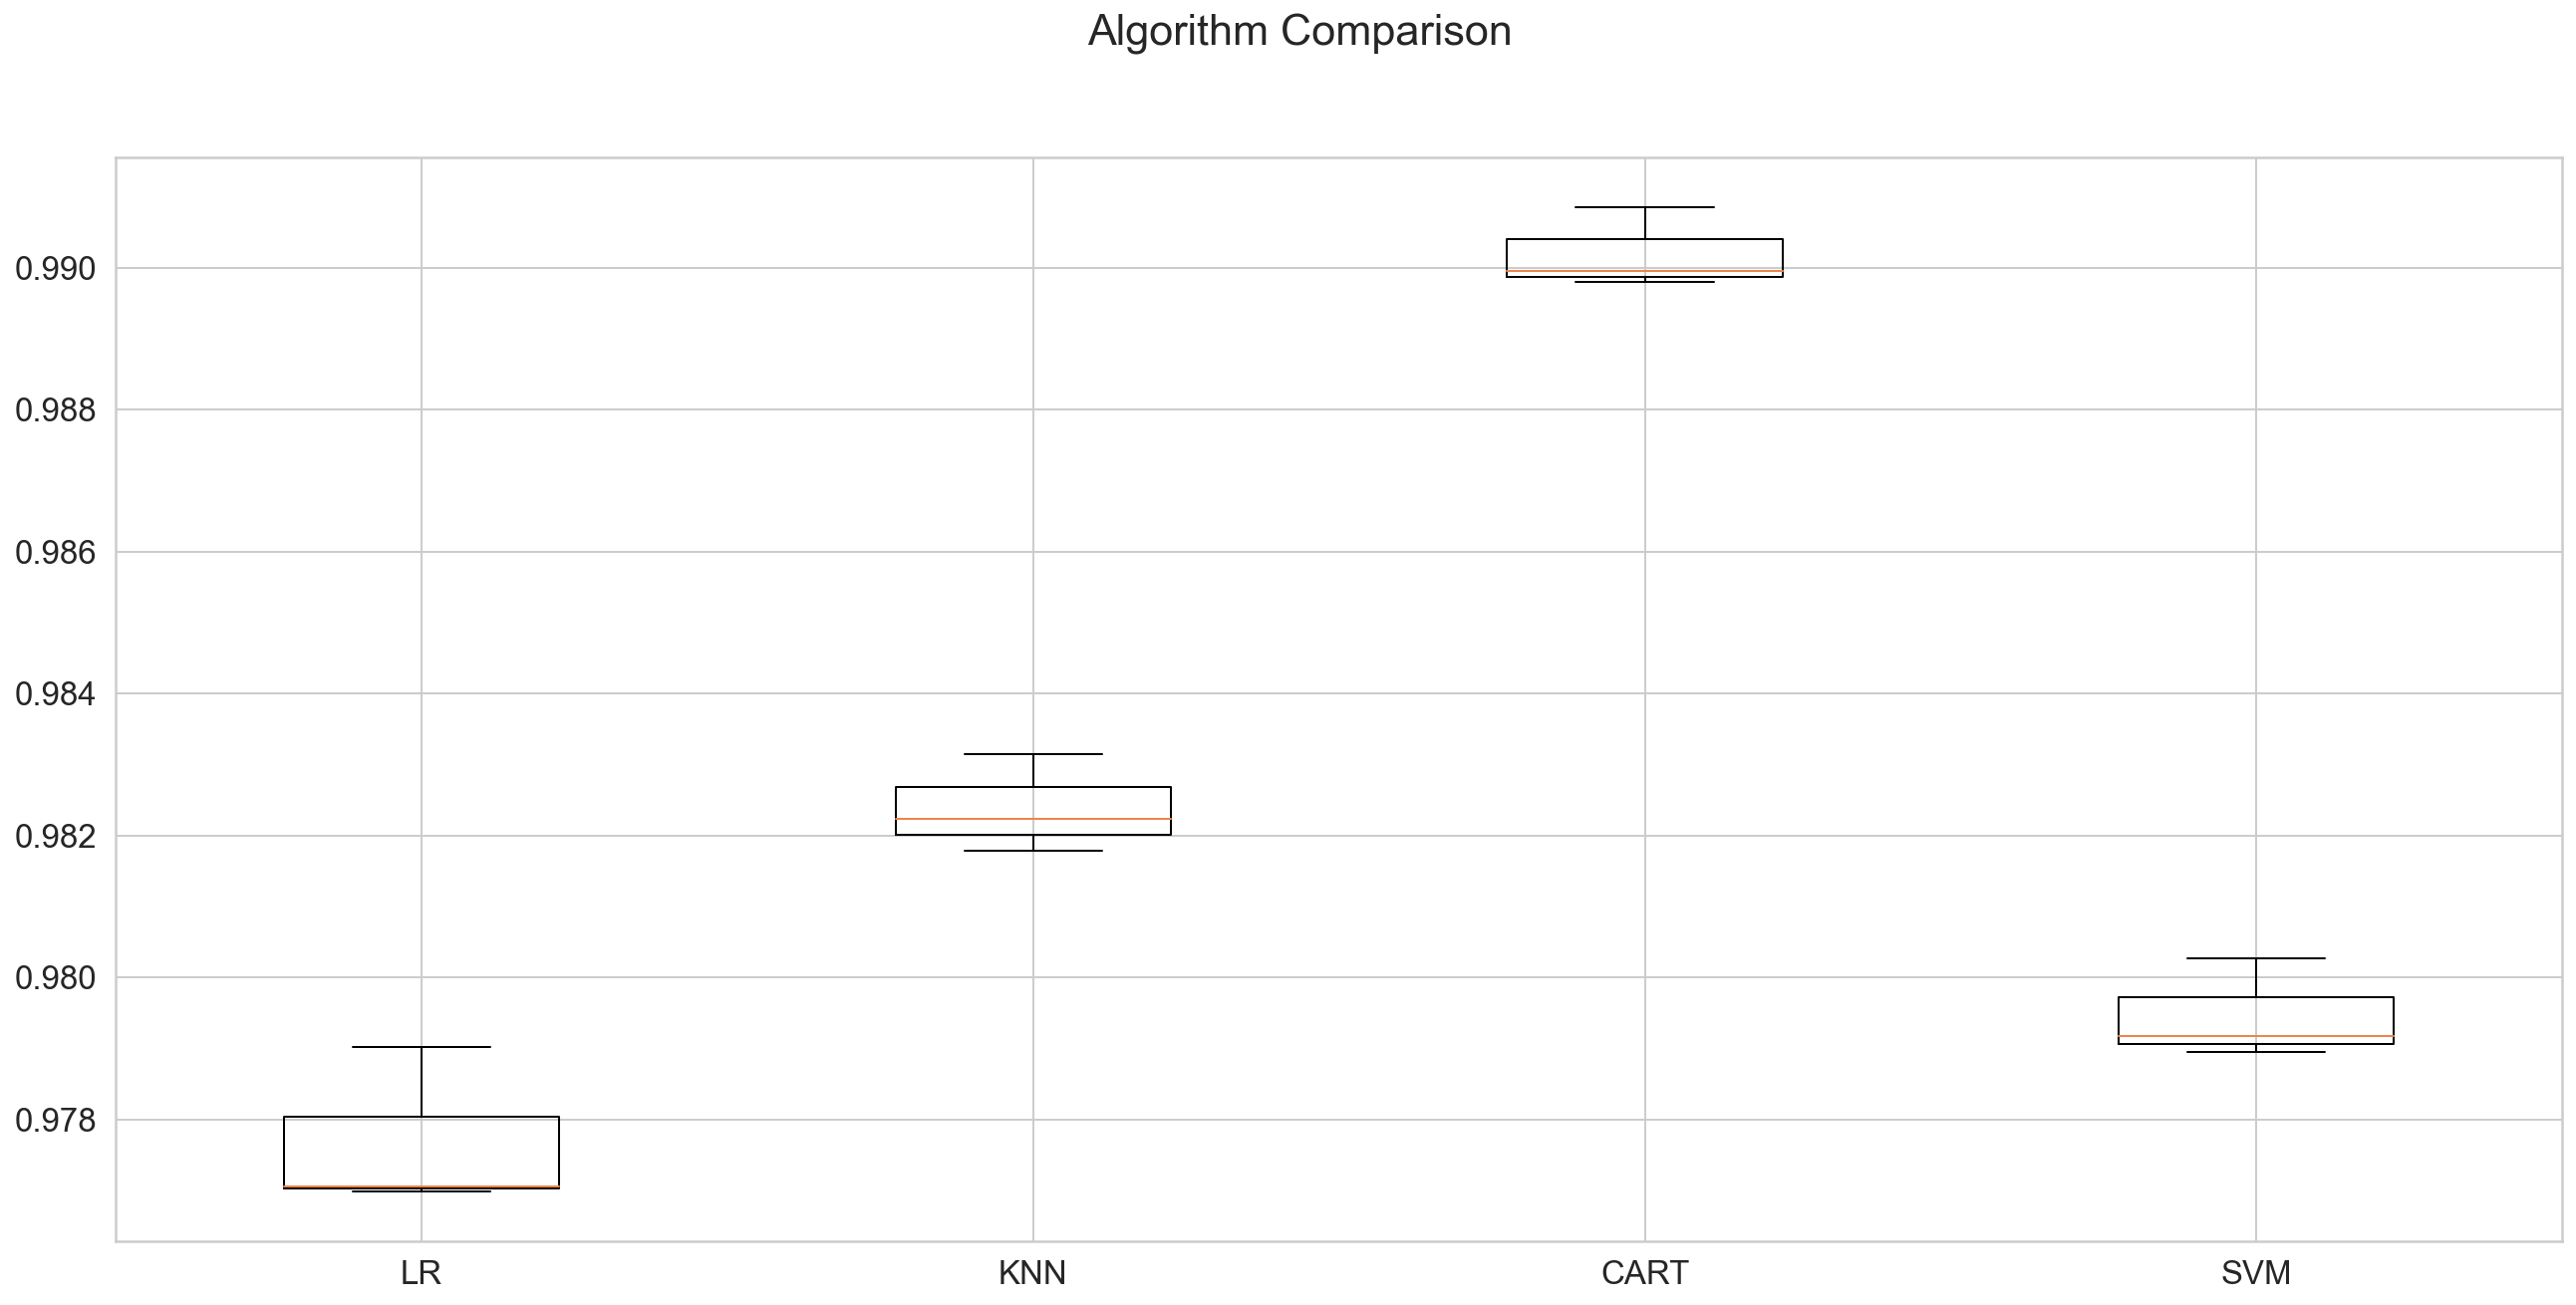

In [198]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
# Spot-Check Algorithms

models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))


num_folds = 3
seed = 7
scoring = 'accuracy'

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, x_train_hstack, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

from matplotlib import pyplot

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

AB: 0.989884 (0.000556)
GBM: 0.987995 (0.000421)
RF: 0.988436 (0.000535)
ET: 0.982868 (0.000819)


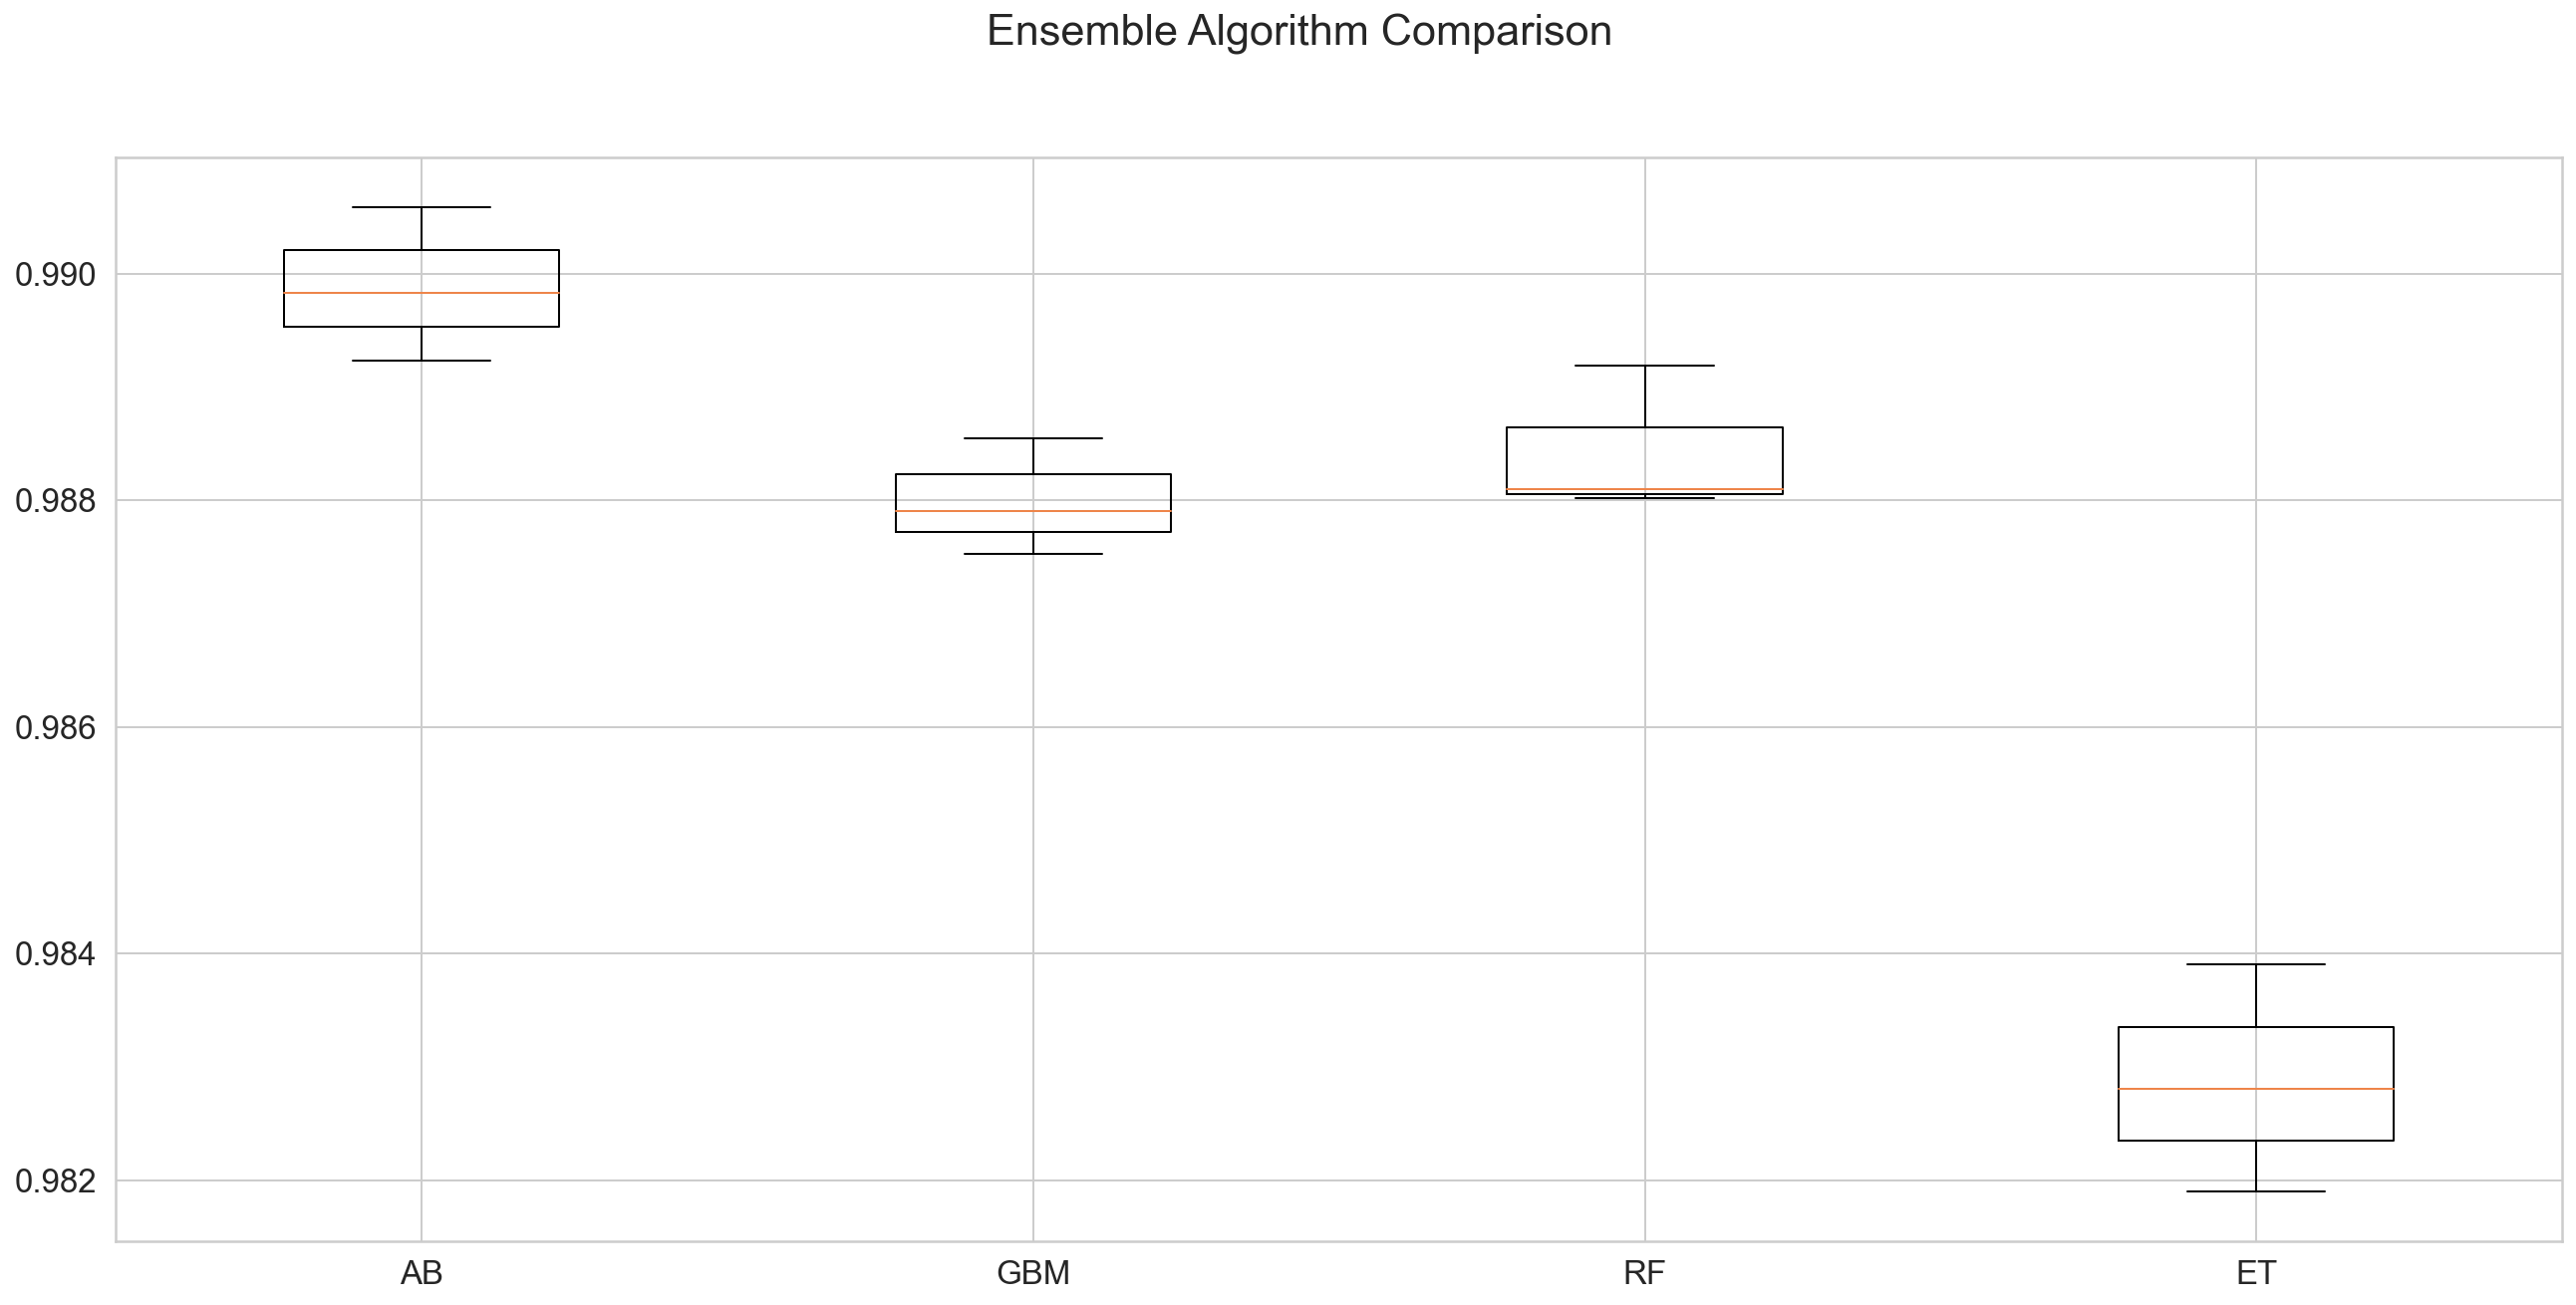

In [200]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

num_folds = 3
seed = 7
scoring = 'accuracy'

ensembles = []

ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, x_train_hstack, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
from matplotlib import pyplot
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

# Naviebayes

## Navie Bayes - Hyperparameter tunning

for alpha = 1e-05
Log Loss : 0.09201423016933802
for alpha = 0.0001
Log Loss : 0.09201533308344696
for alpha = 0.001
Log Loss : 0.0919960493104854
for alpha = 0.1
Log Loss : 0.09194489641907258
for alpha = 1
Log Loss : 0.09373498377524096
for alpha = 10
Log Loss : 0.11348794834705676
for alpha = 100
Log Loss : 0.12232260772360551
for alpha = 1000
Log Loss : 0.12334442675768291


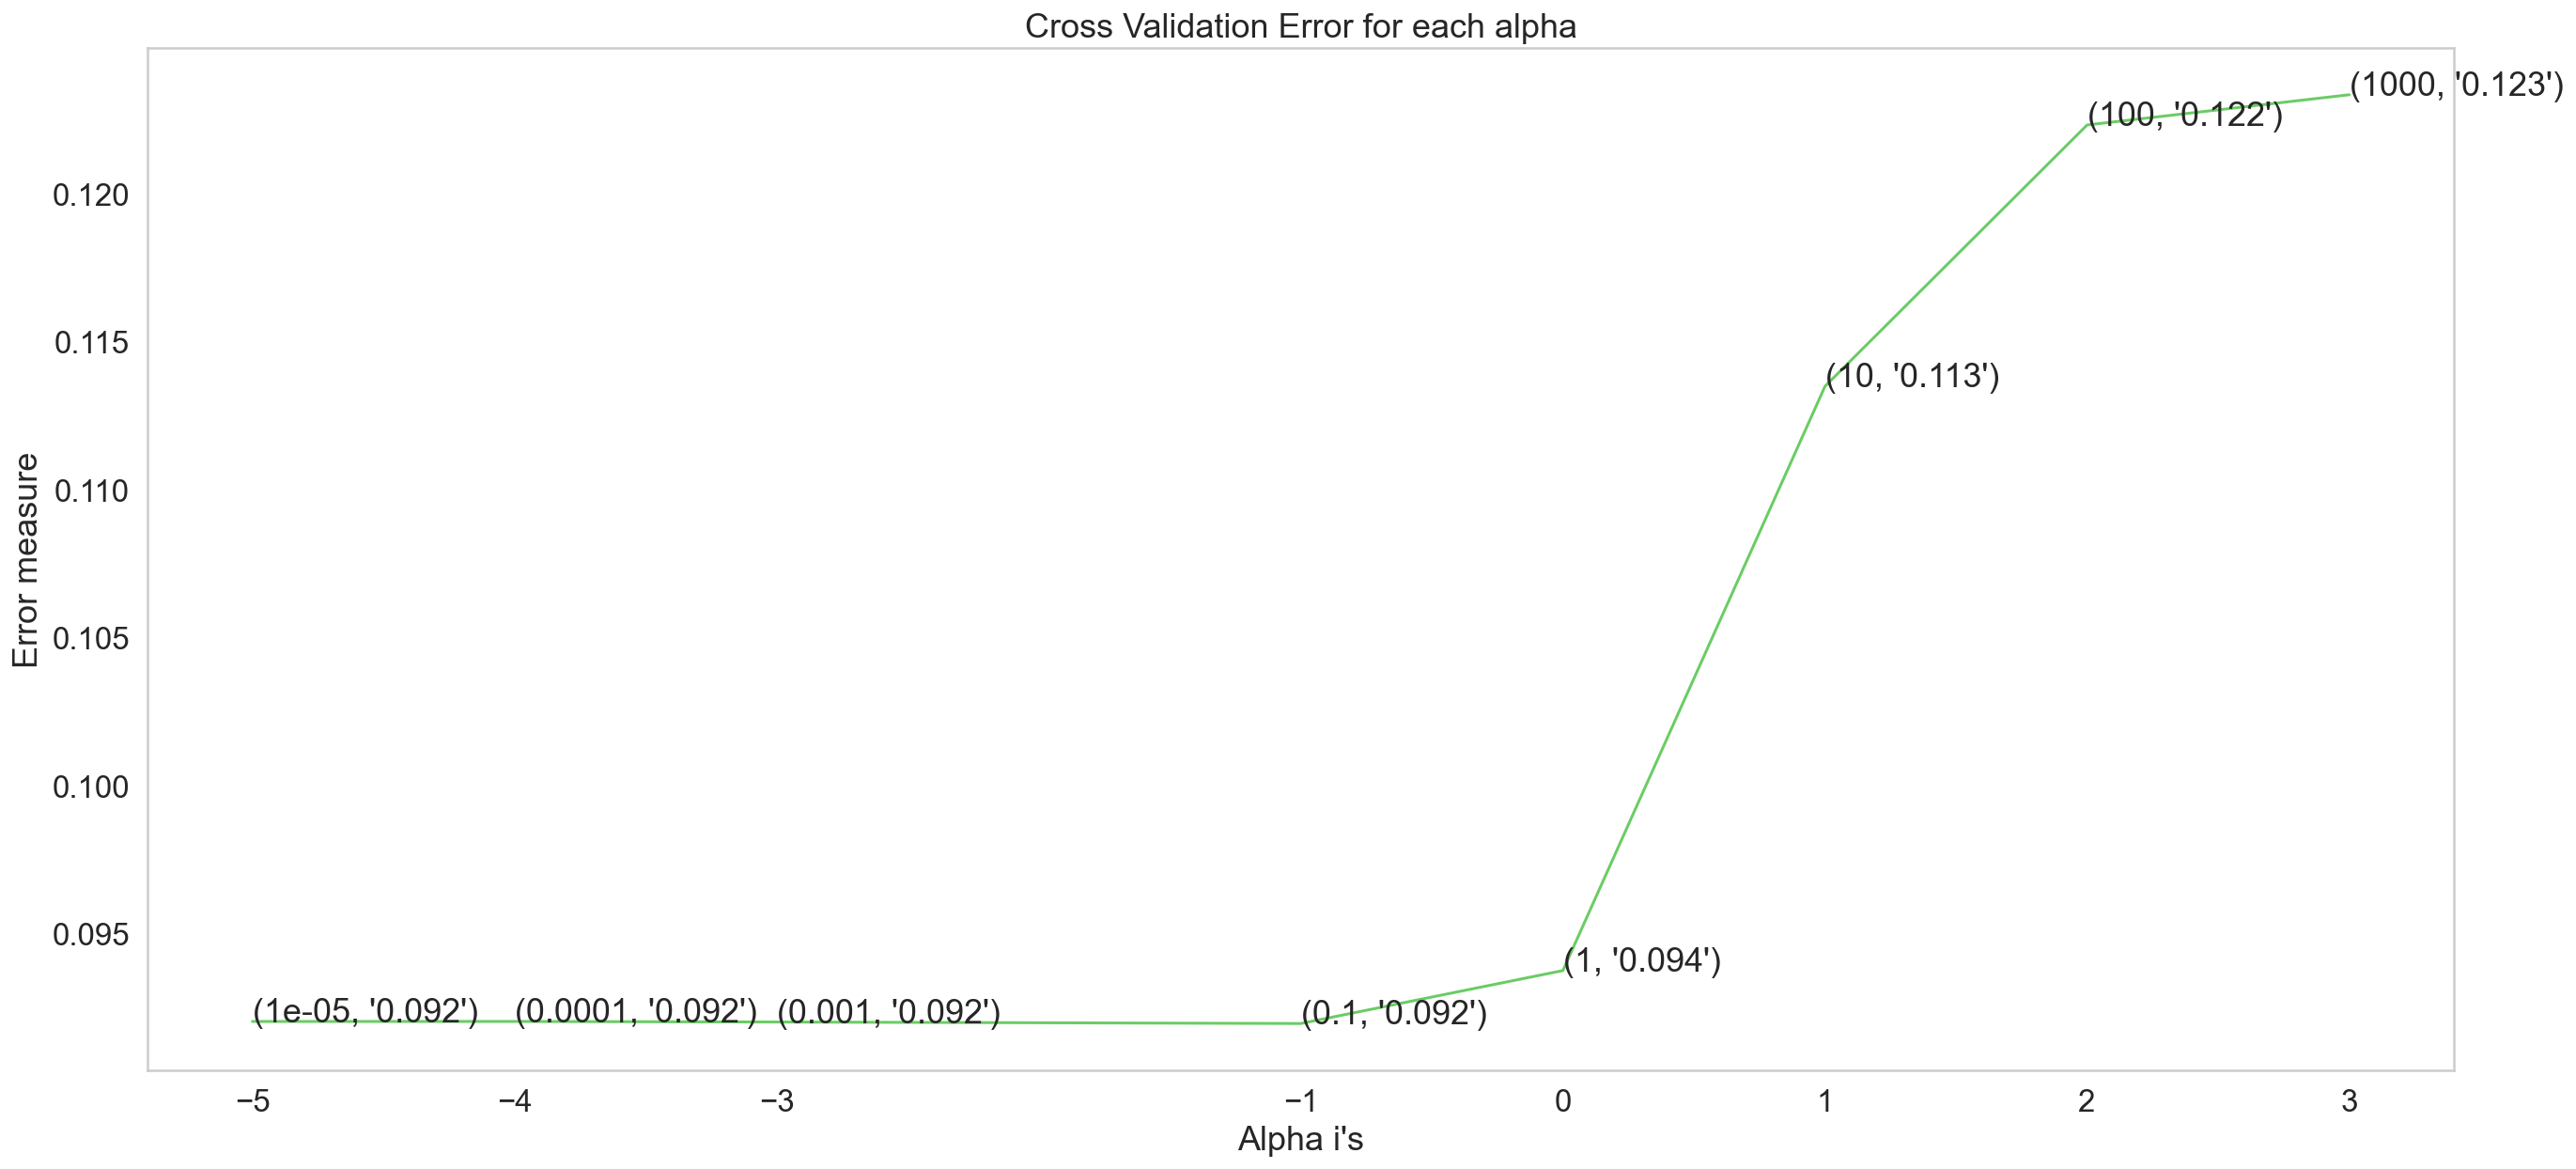

For values of best alpha =  0.1 The train log loss is: 0.08498623508019455
For values of best alpha =  0.1 The cross validation log loss is: 0.09194489641907258
For values of best alpha =  0.1 The test log loss is: 0.09030120455953762


In [201]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(x_train_hstack, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_hstack, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_cv_hstack)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
model = MultinomialNB(alpha=alpha[best_alpha])
model.fit(x_train_hstack, y_train)
sig_clf = CalibratedClassifierCV(model, method="sigmoid")
sig_clf.fit(x_train_hstack, y_train)


predict_y = sig_clf.predict_proba(x_train_hstack)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv_hstack)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_hstack)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## Navie Bayes - Logloss and Classification Report

train log loss: 0.08498623508019455
test log loss: 0.09030120455953762
cv log loss: 0.09194489641907258
............................................................ AUC ............................................................
AUC Train data: 0.5689002920103091
AUC Test data: 0.569496176444757
AUC cv data: 0.5565879594917708
                                                                                                    
........................................ Class Report ........................................
                                                                                                    
-------------------- Train Data ------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     77256
           1       0.62      0.14      0.23      2126

    accuracy                           0.97     79382
   macro avg       0.80      0.57      0.61     79382
weighted avg       0.97      0.97     

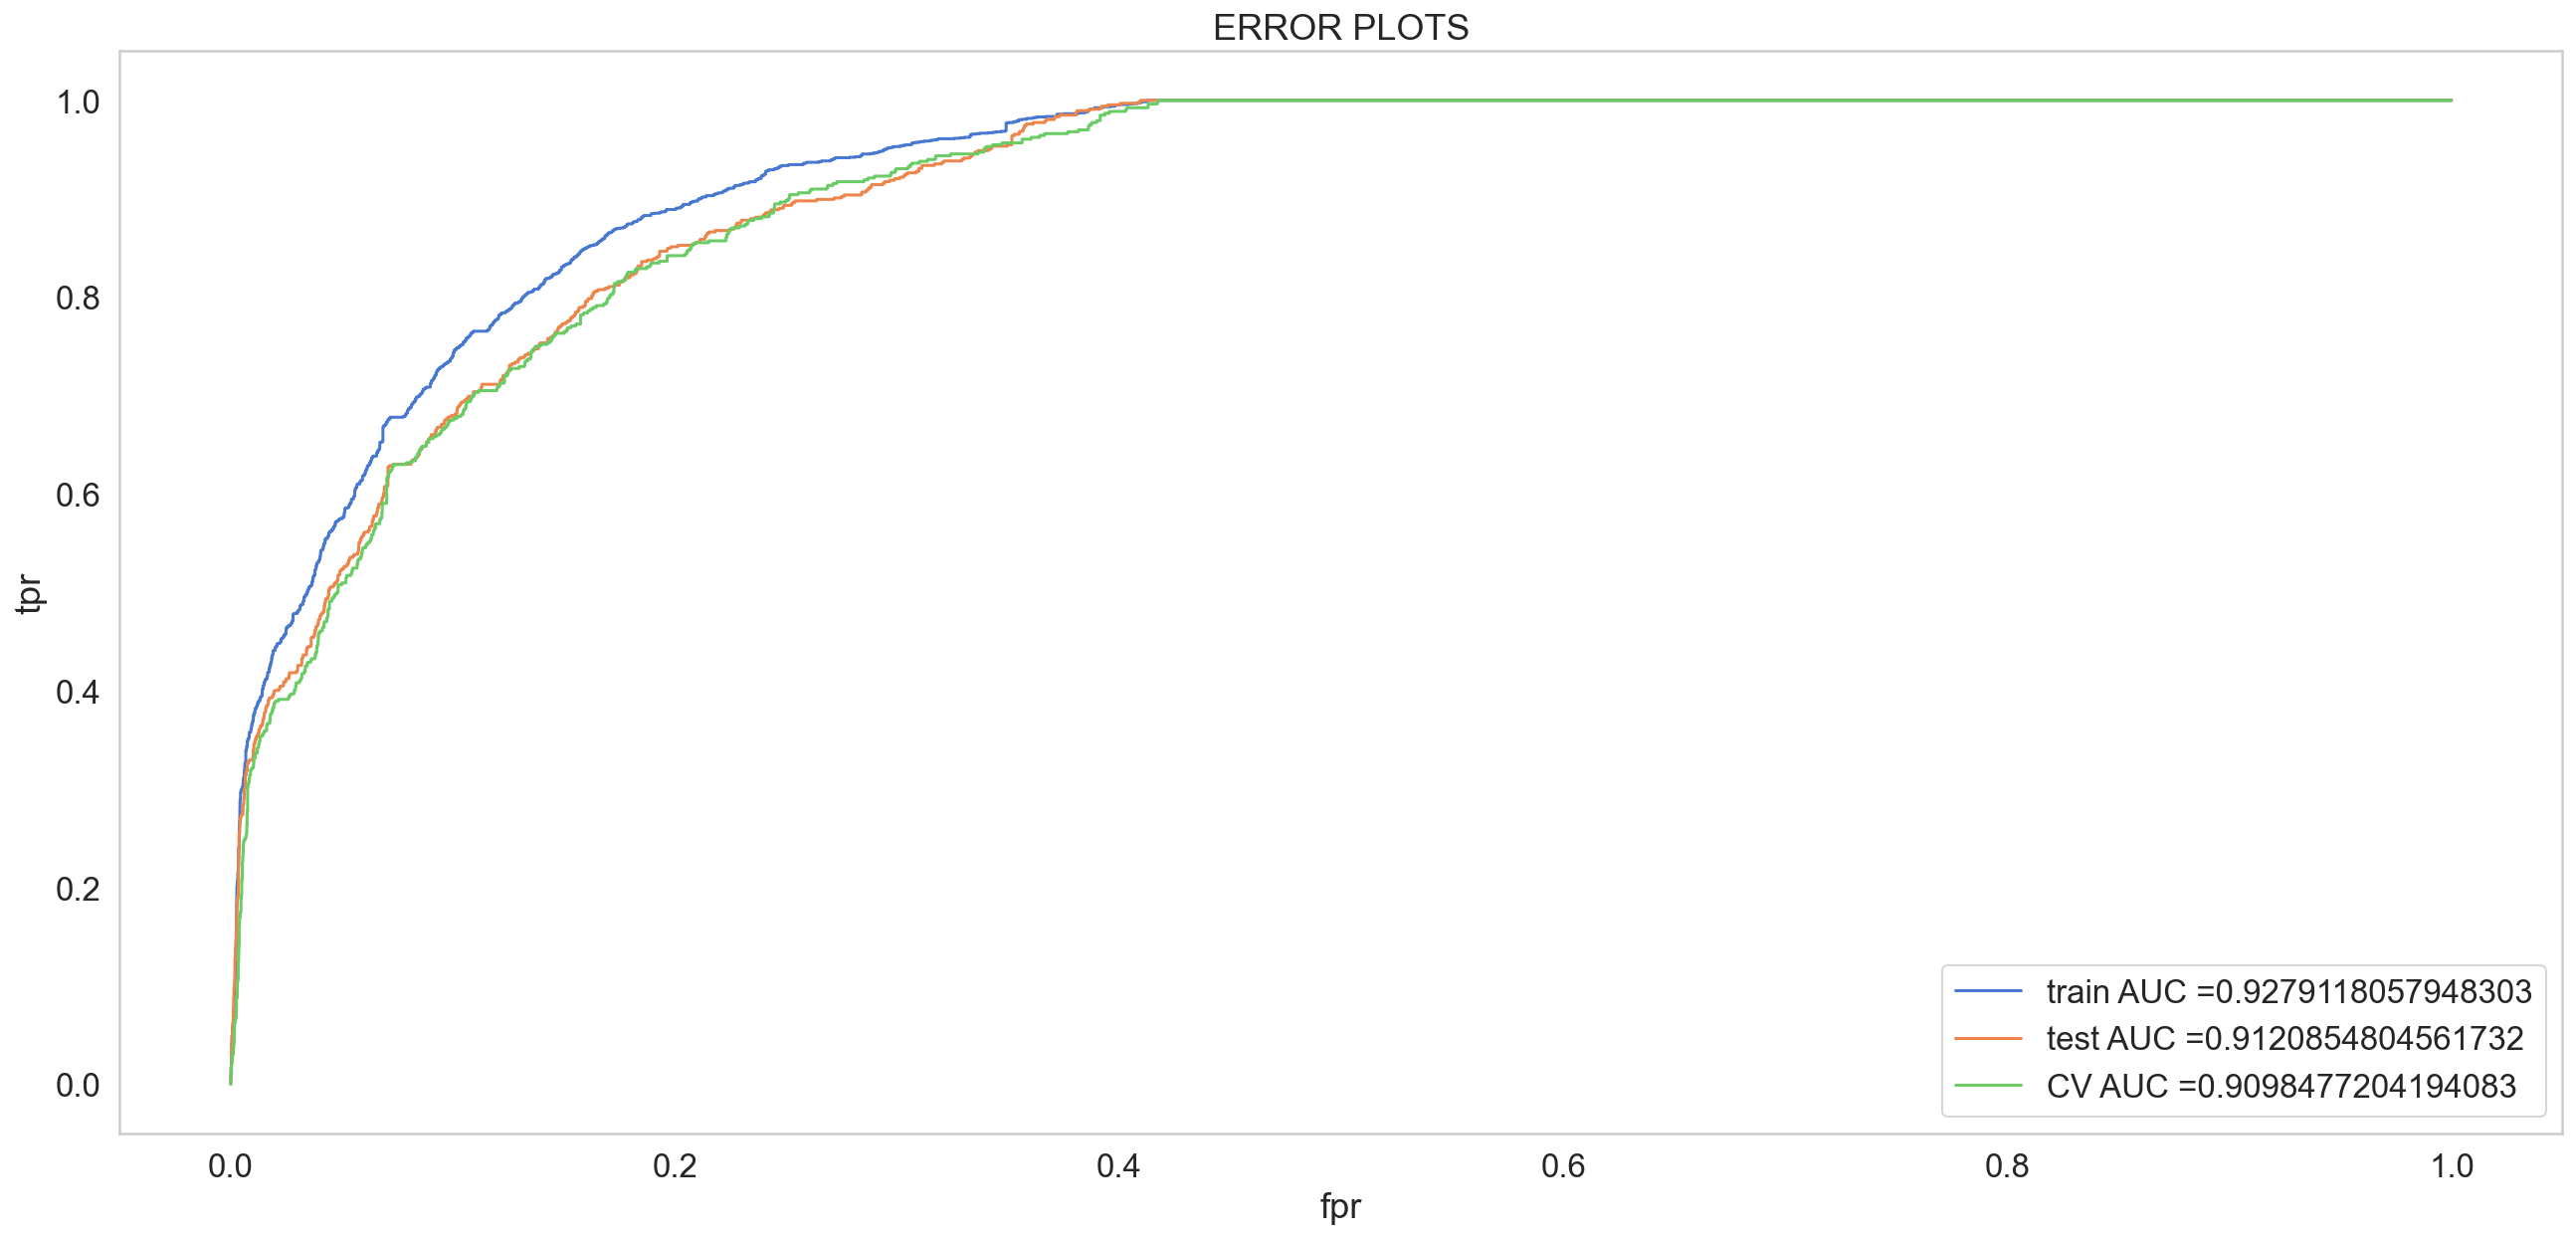

In [203]:
predict_y = sig_clf.predict_proba(x_train_hstack)
print("train log loss:", log_loss(y_train, predict_y, labels=sig_clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_hstack)
print("test log loss:", log_loss(y_test, predict_y,labels=sig_clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv_hstack)
print("cv log loss:", log_loss(y_cv, predict_y,labels=sig_clf.classes_, eps=1e-15))



print("."*60,"AUC","."*60)
print("multiclass_AUC Train data:", multiclass_roc_auc_score(y_train,sig_clf.predict(x_train_hstack),average="macro"))
print("multiclass_AUC Test data:", multiclass_roc_auc_score(y_test,sig_clf.predict(x_test_hstack),average="macro"))
print("multiclass_AUC cv data:", multiclass_roc_auc_score(y_cv,sig_clf.predict(x_cv_hstack),average="macro"))


print(" "*100)
print("."*40,"Class Report","."*40)
print(" "*100)
print("-"*20,"Train Data","-"*30)
print( classification_report(y_train, sig_clf.predict(x_train_hstack)))
print("-"*20,"Test Data","-"*20)
print( classification_report(y_test, sig_clf.predict(x_test_hstack)))
print("-"*20,"CV Data","-"*20)
print( classification_report(y_cv, sig_clf.predict(x_cv_hstack)))

y_train_pred = sig_clf.predict_proba(x_train_hstack)    
y_test_pred = sig_clf.predict_proba(x_test_hstack)
y_cv_pred = sig_clf.predict_proba(x_cv_hstack)


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train.astype(int),y_train_pred[:,1])

test_fpr, test_tpr, te_thresholds = roc_curve(y_test.astype(int),y_test_pred[:,1])

cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv.astype(int),y_cv_pred[:,1])



plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))



plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


## Navie Bayes - Confusion Matrix

_train__train__train__train__train__train__train__train__train__train_
-------------------- Confusion matrix --------------------


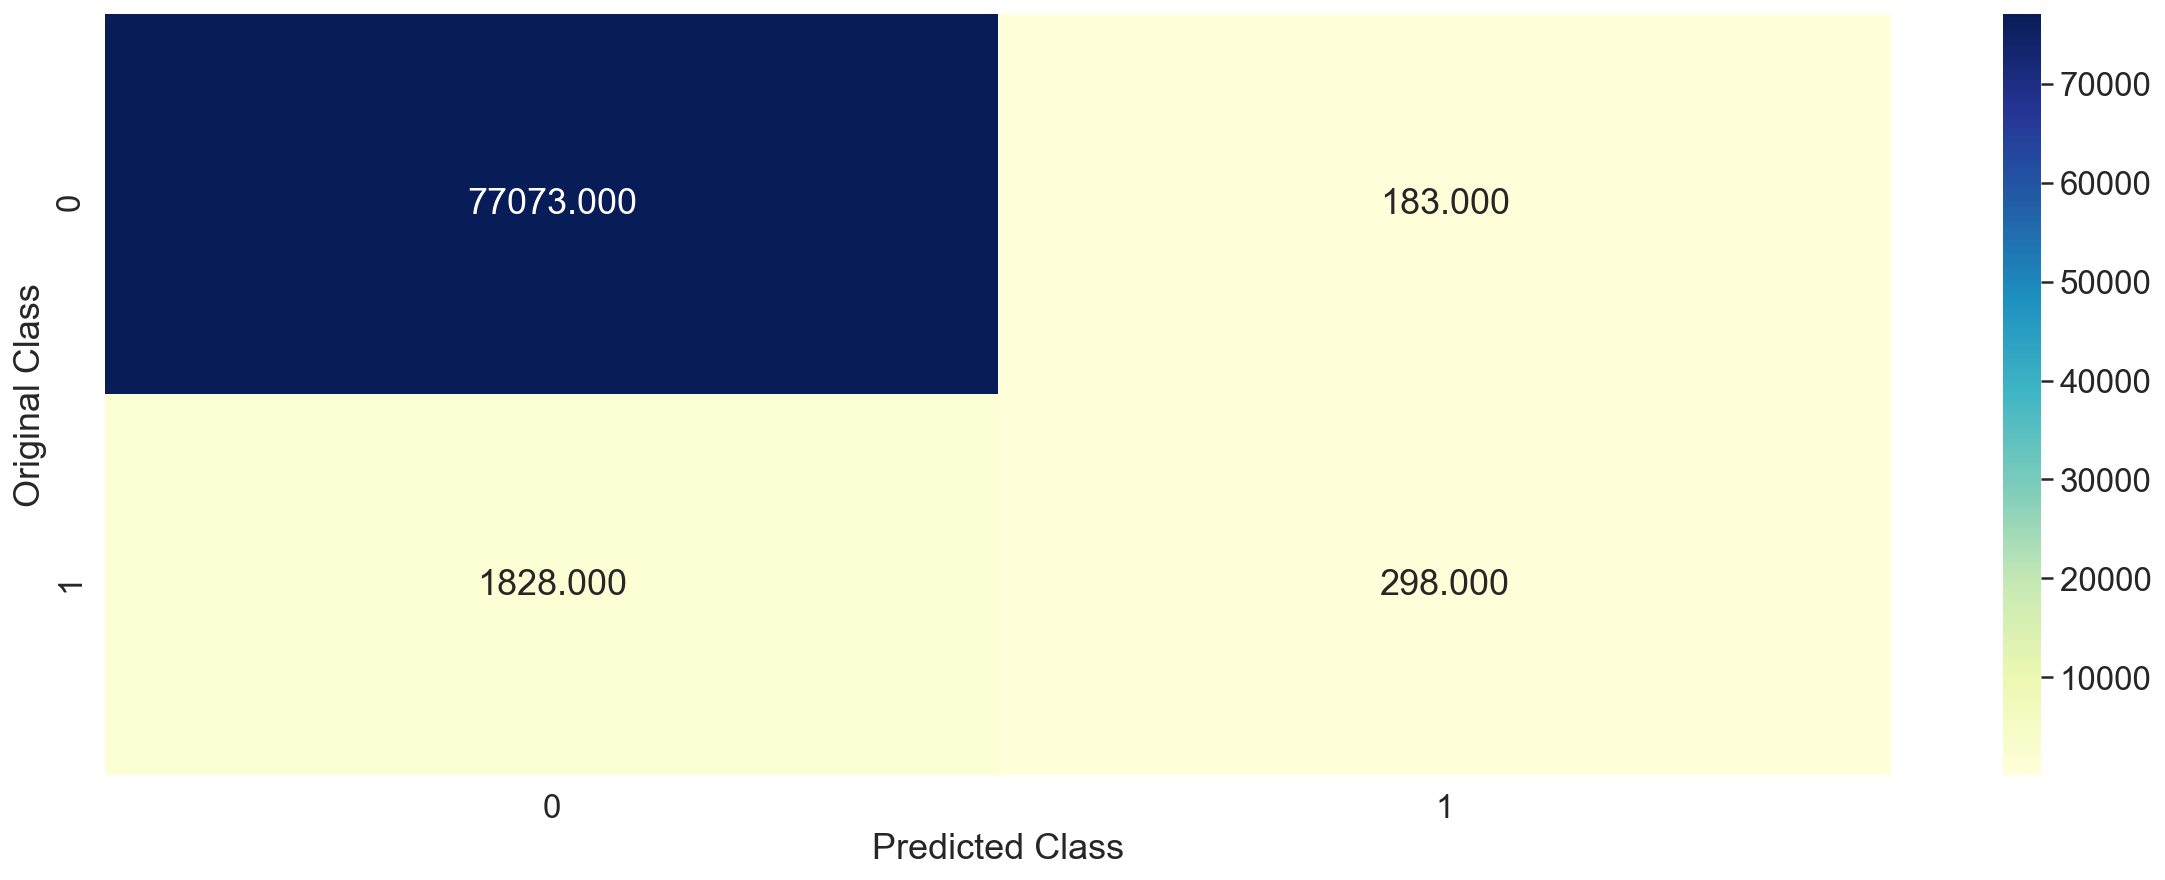

-------------------- Precision matrix (Columm Sum=1) --------------------


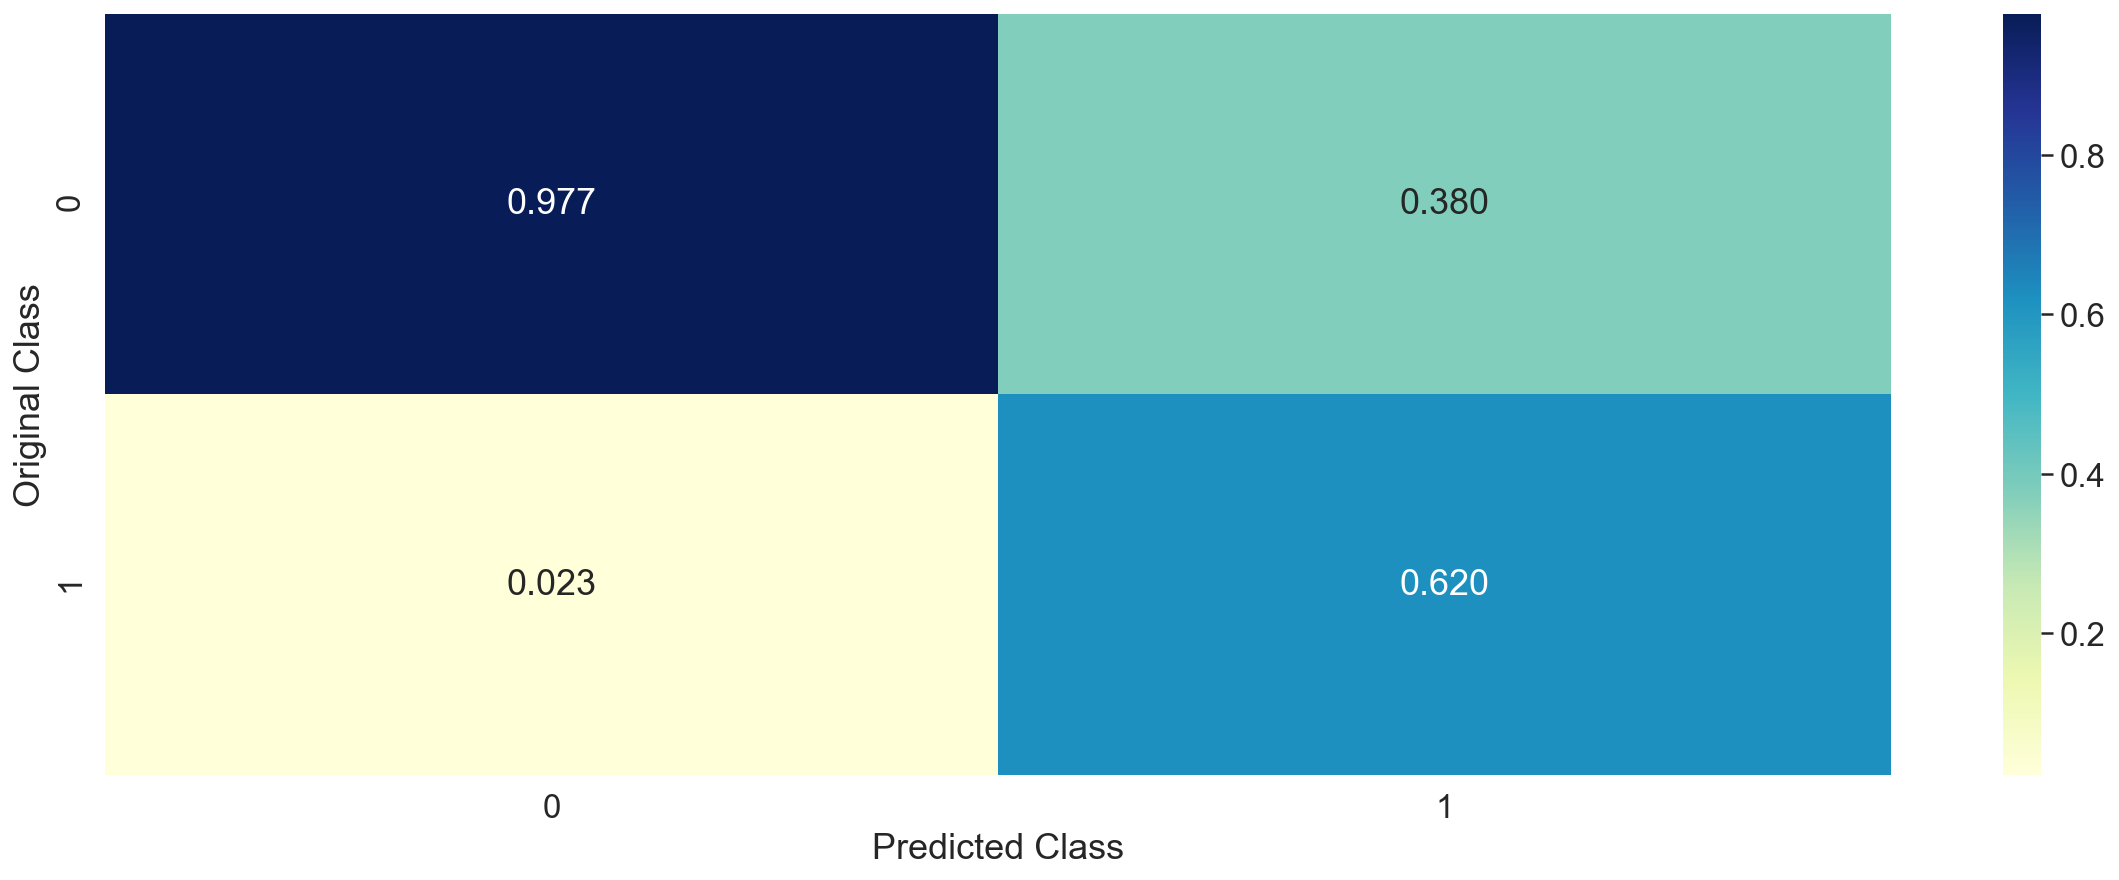

-------------------- Recall matrix (Row sum=1) --------------------


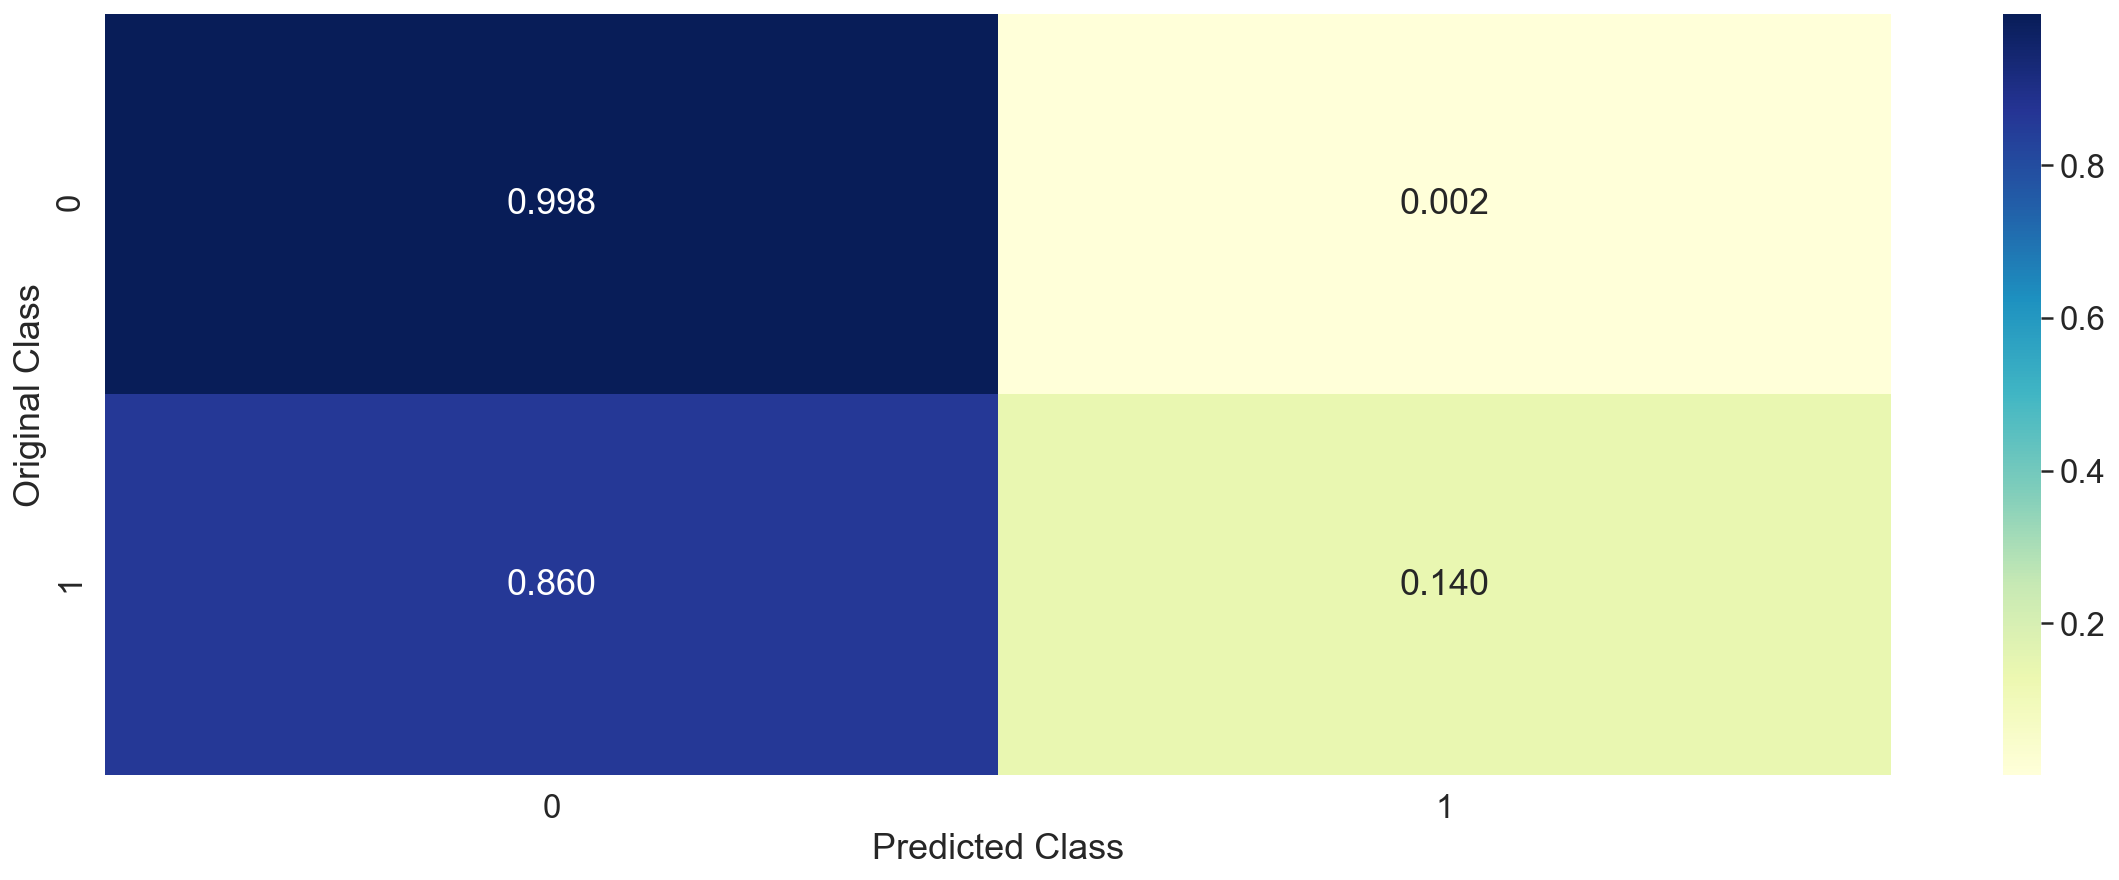

_test__test__test__test__test__test__test__test__test__test_
-------------------- Confusion matrix --------------------


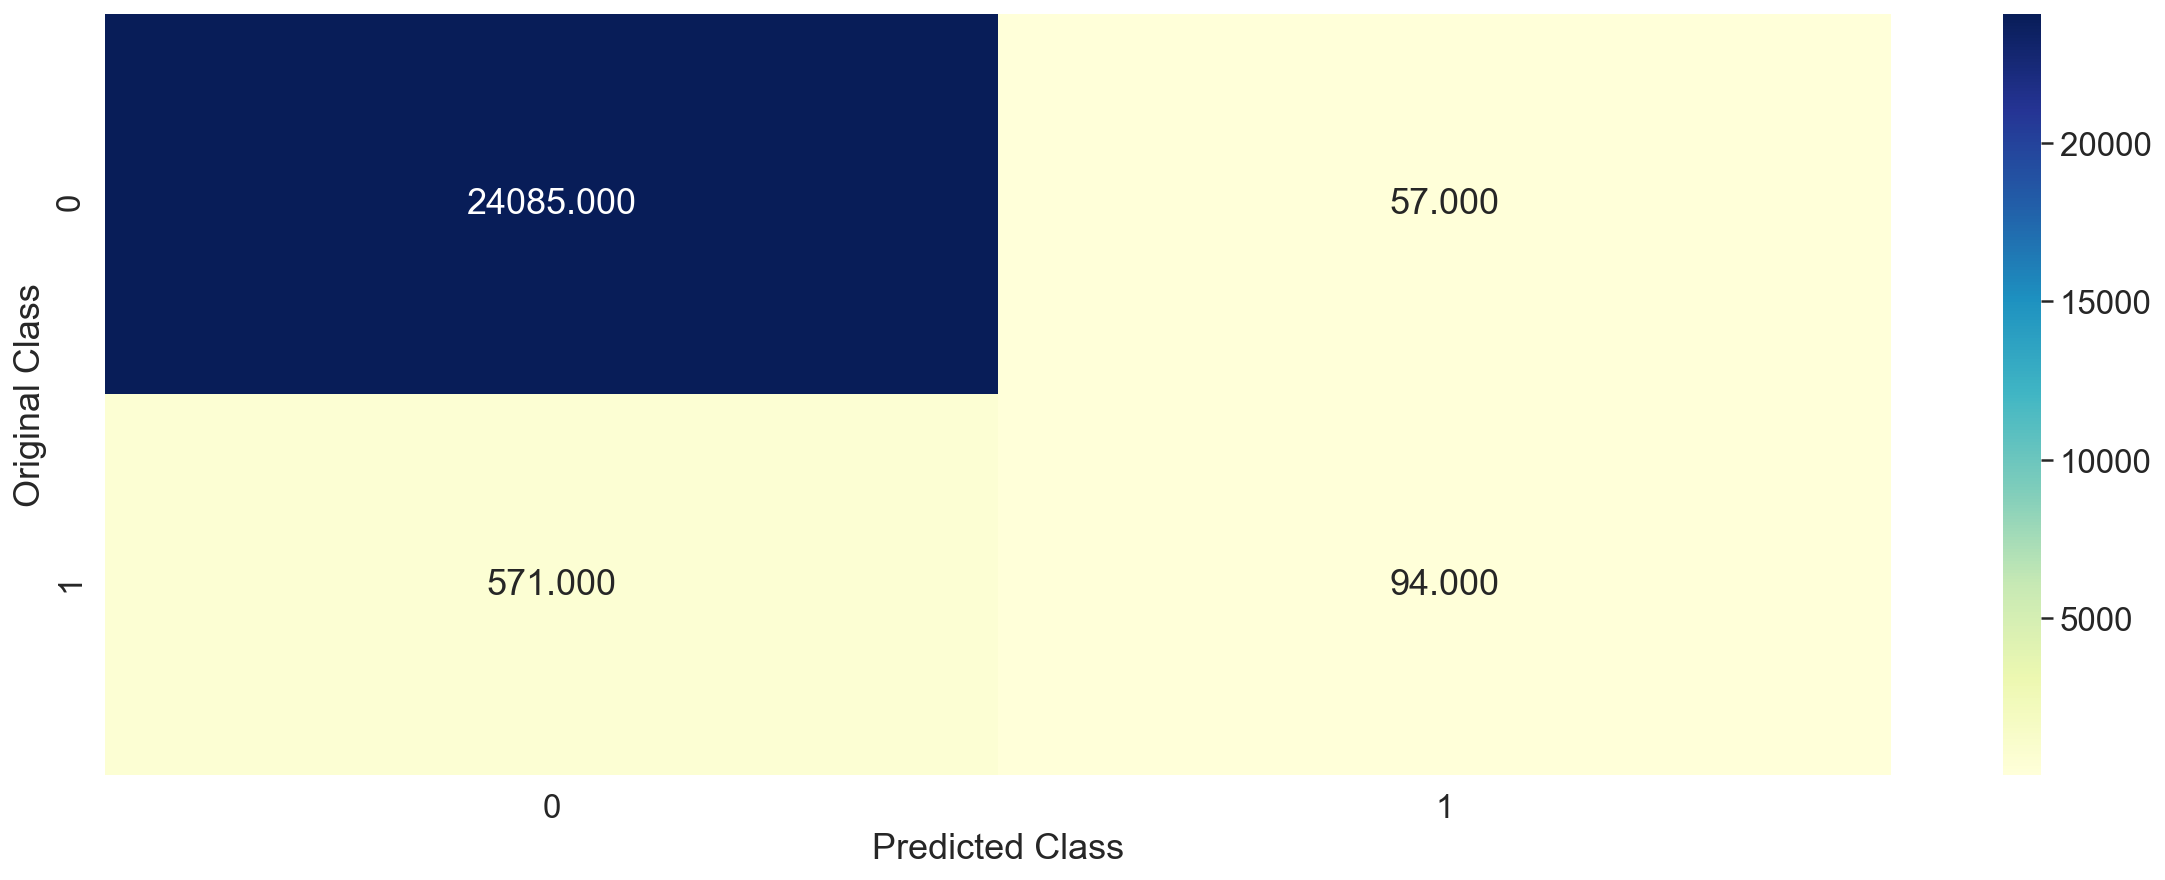

-------------------- Precision matrix (Columm Sum=1) --------------------


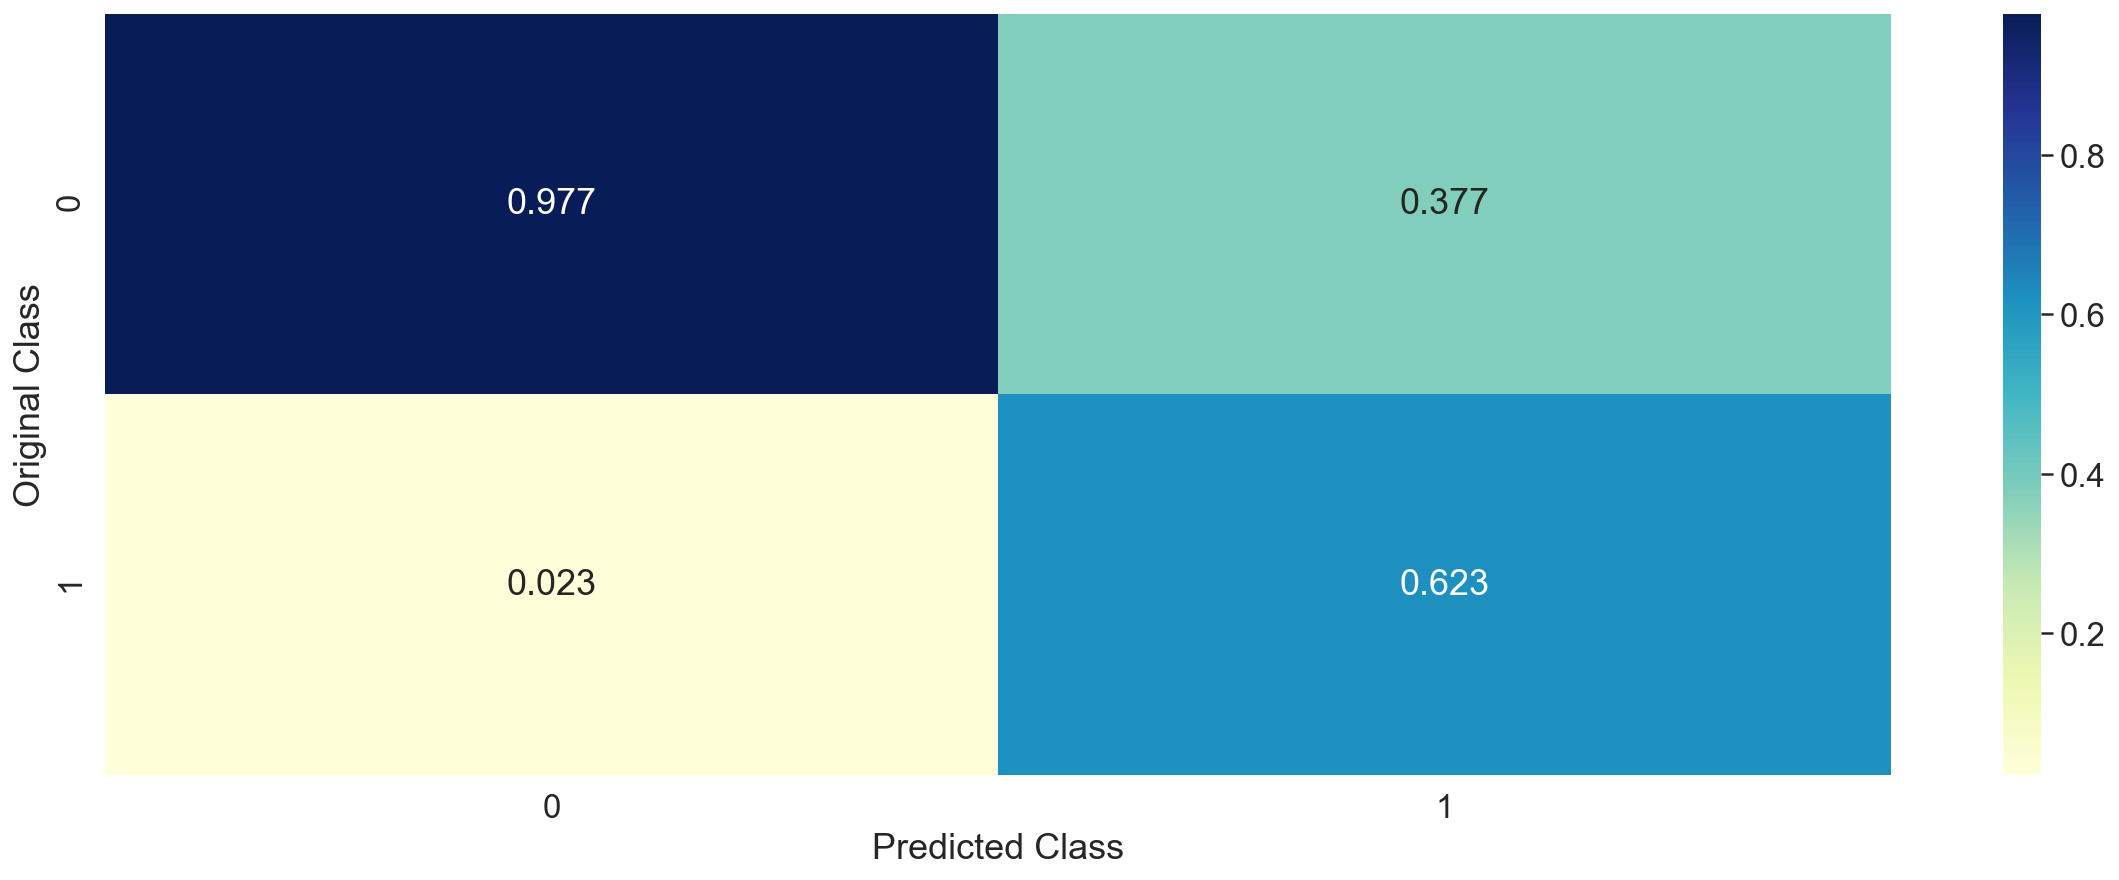

-------------------- Recall matrix (Row sum=1) --------------------


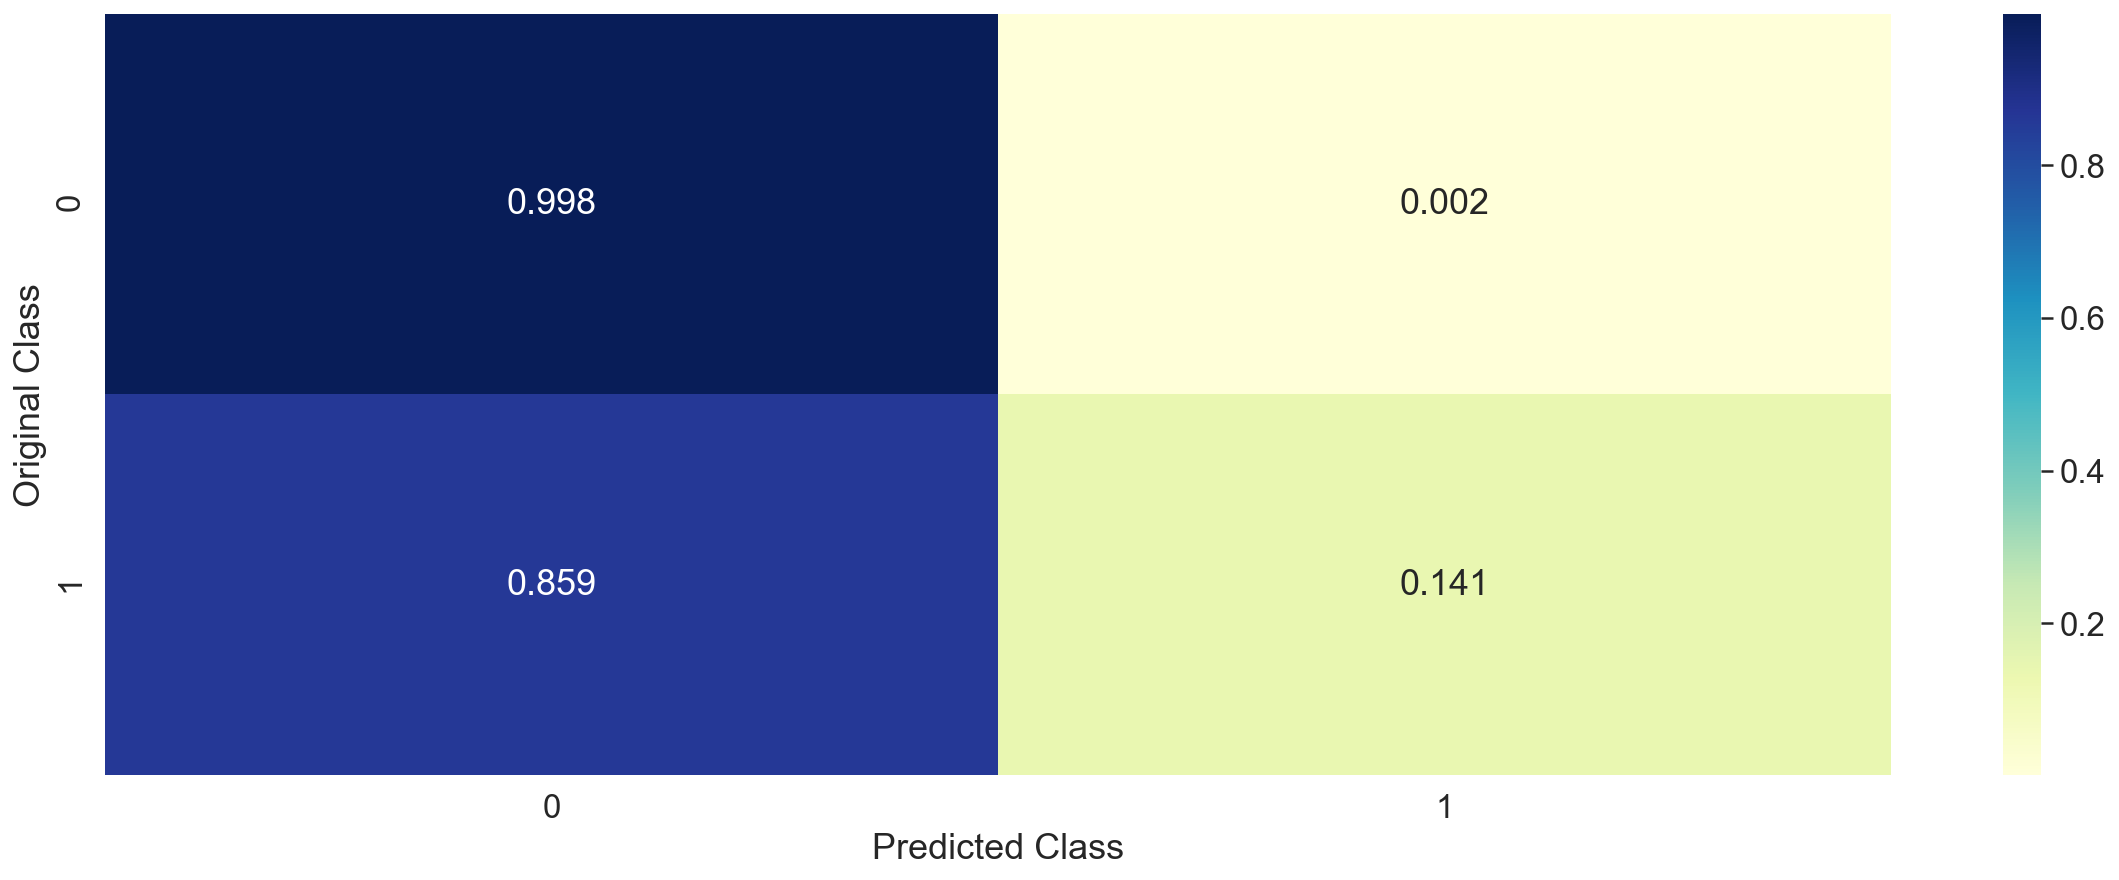

_cv__cv__cv__cv__cv__cv__cv__cv__cv__cv_
-------------------- Confusion matrix --------------------


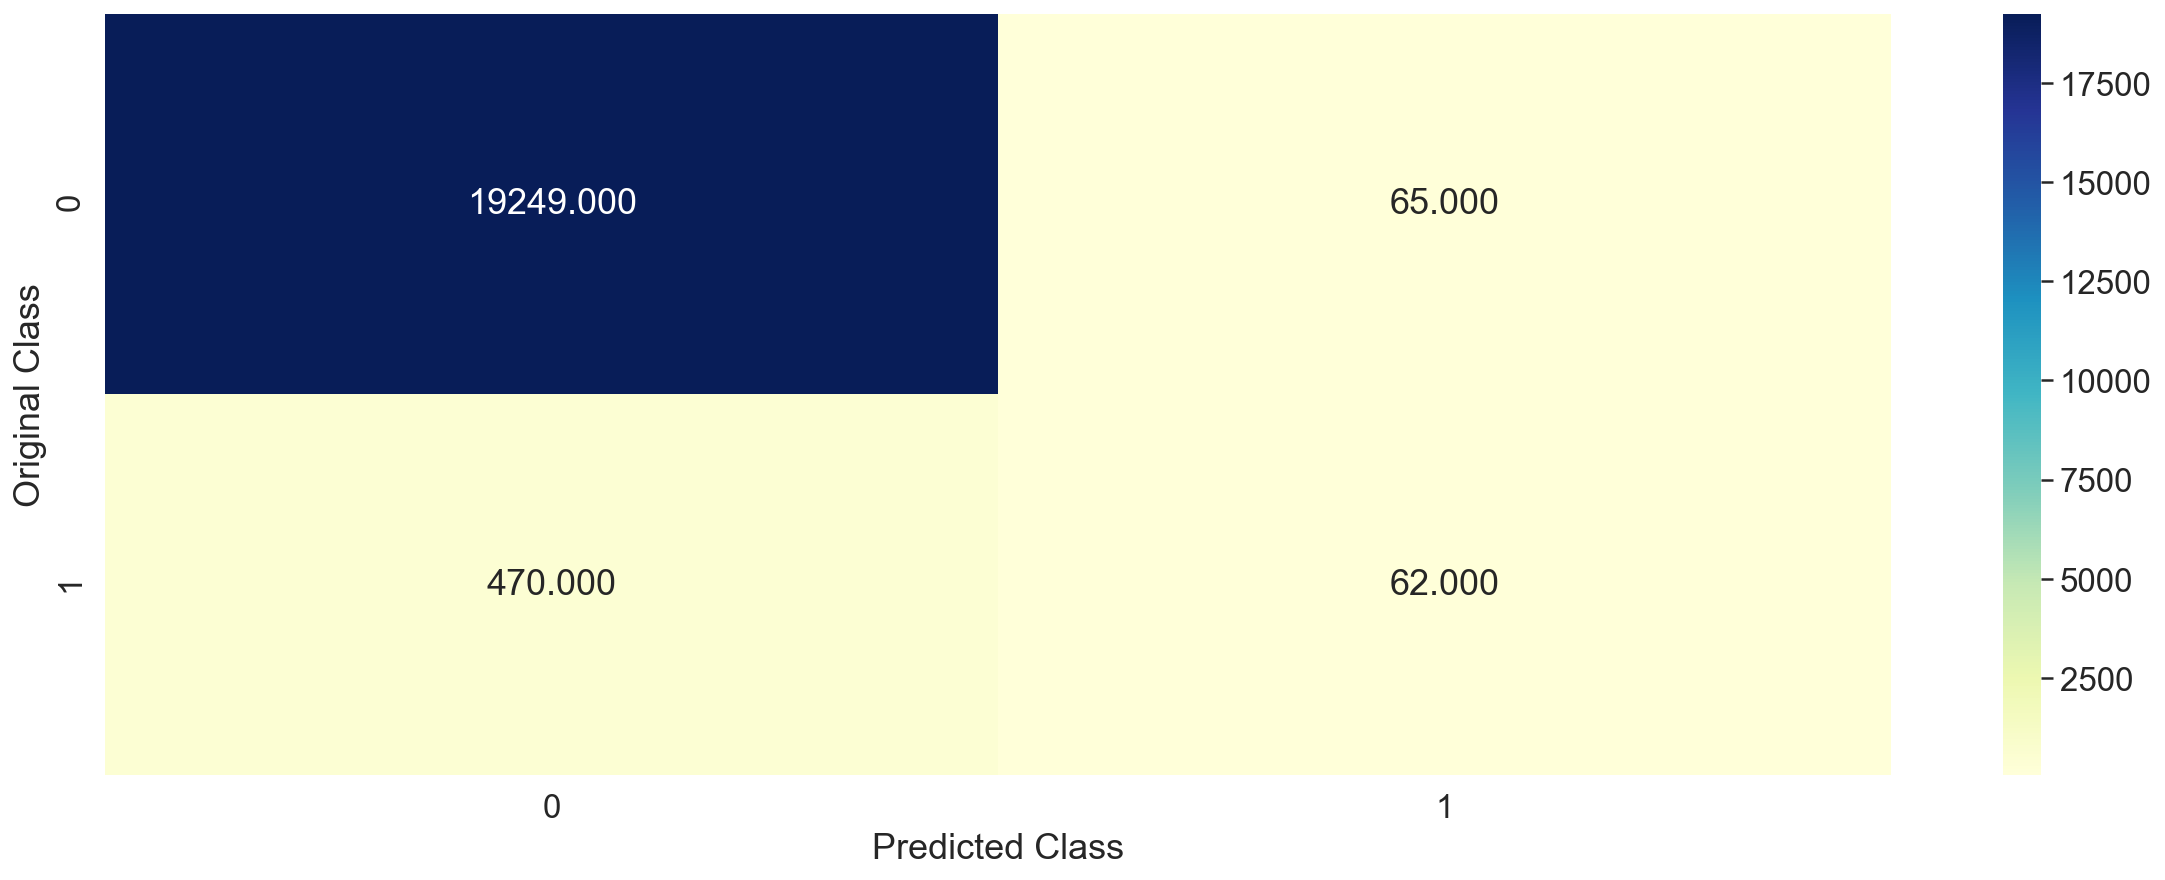

-------------------- Precision matrix (Columm Sum=1) --------------------


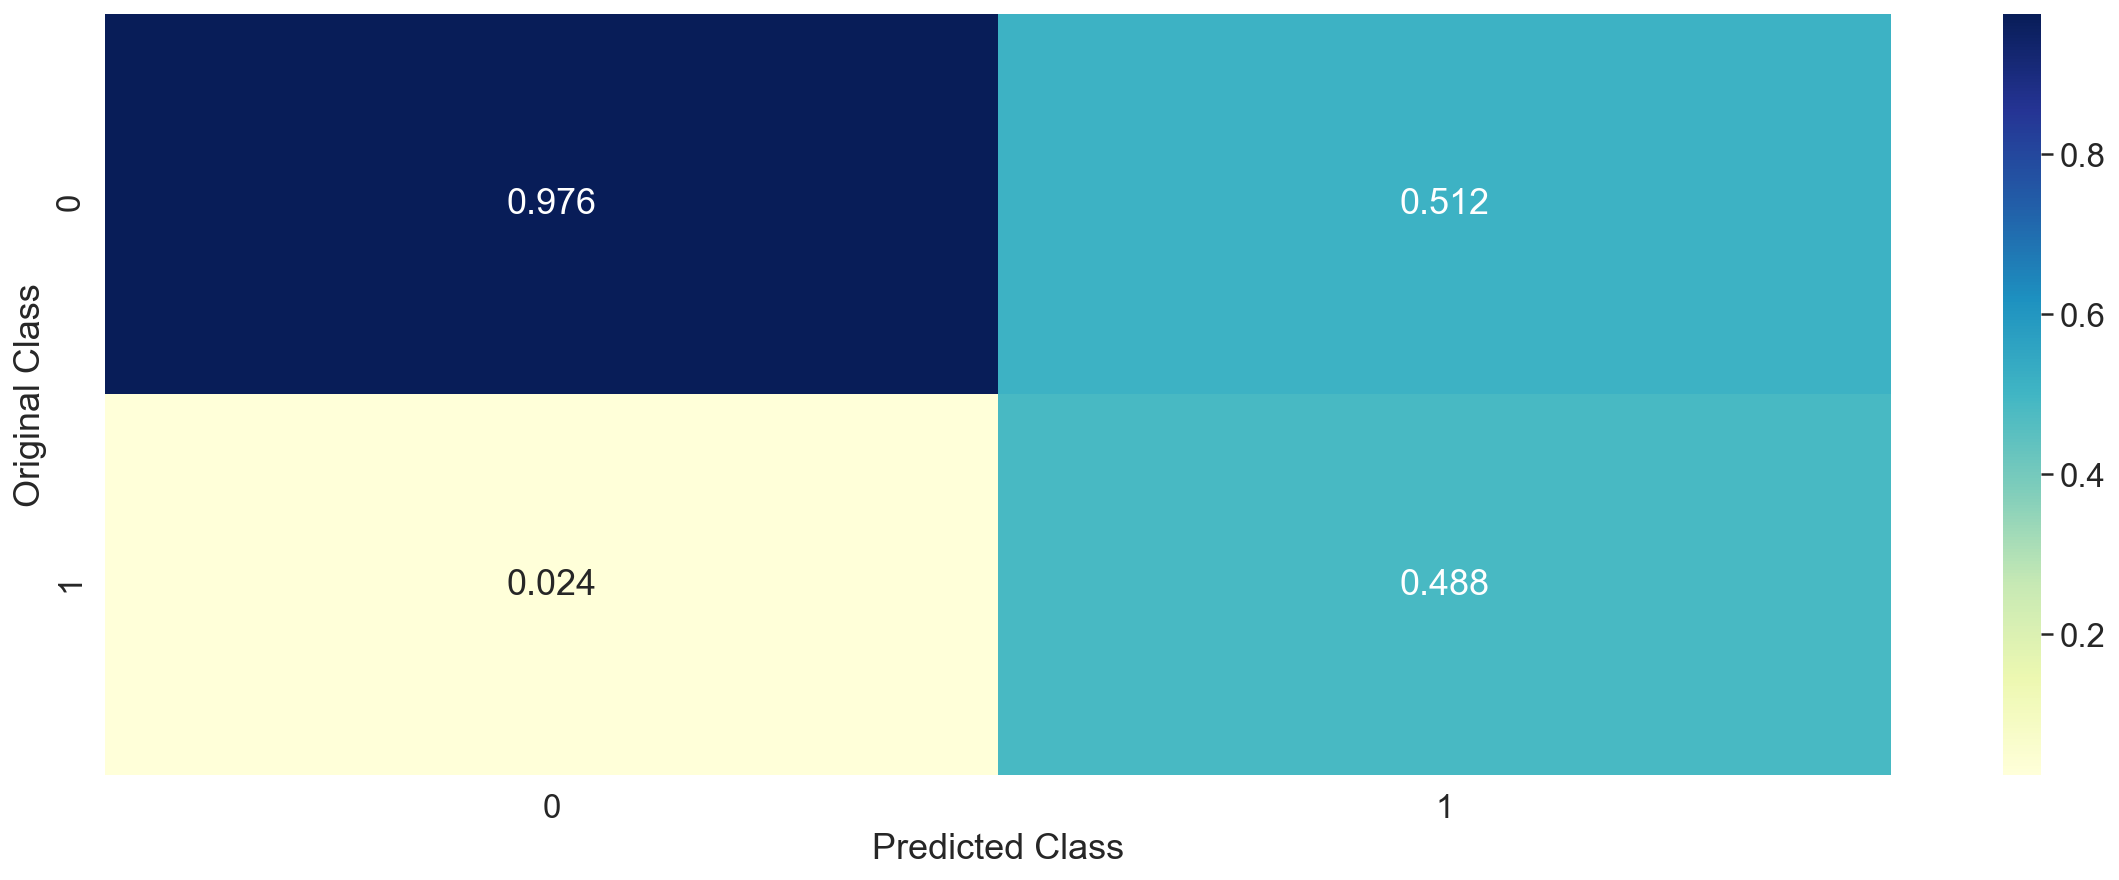

-------------------- Recall matrix (Row sum=1) --------------------


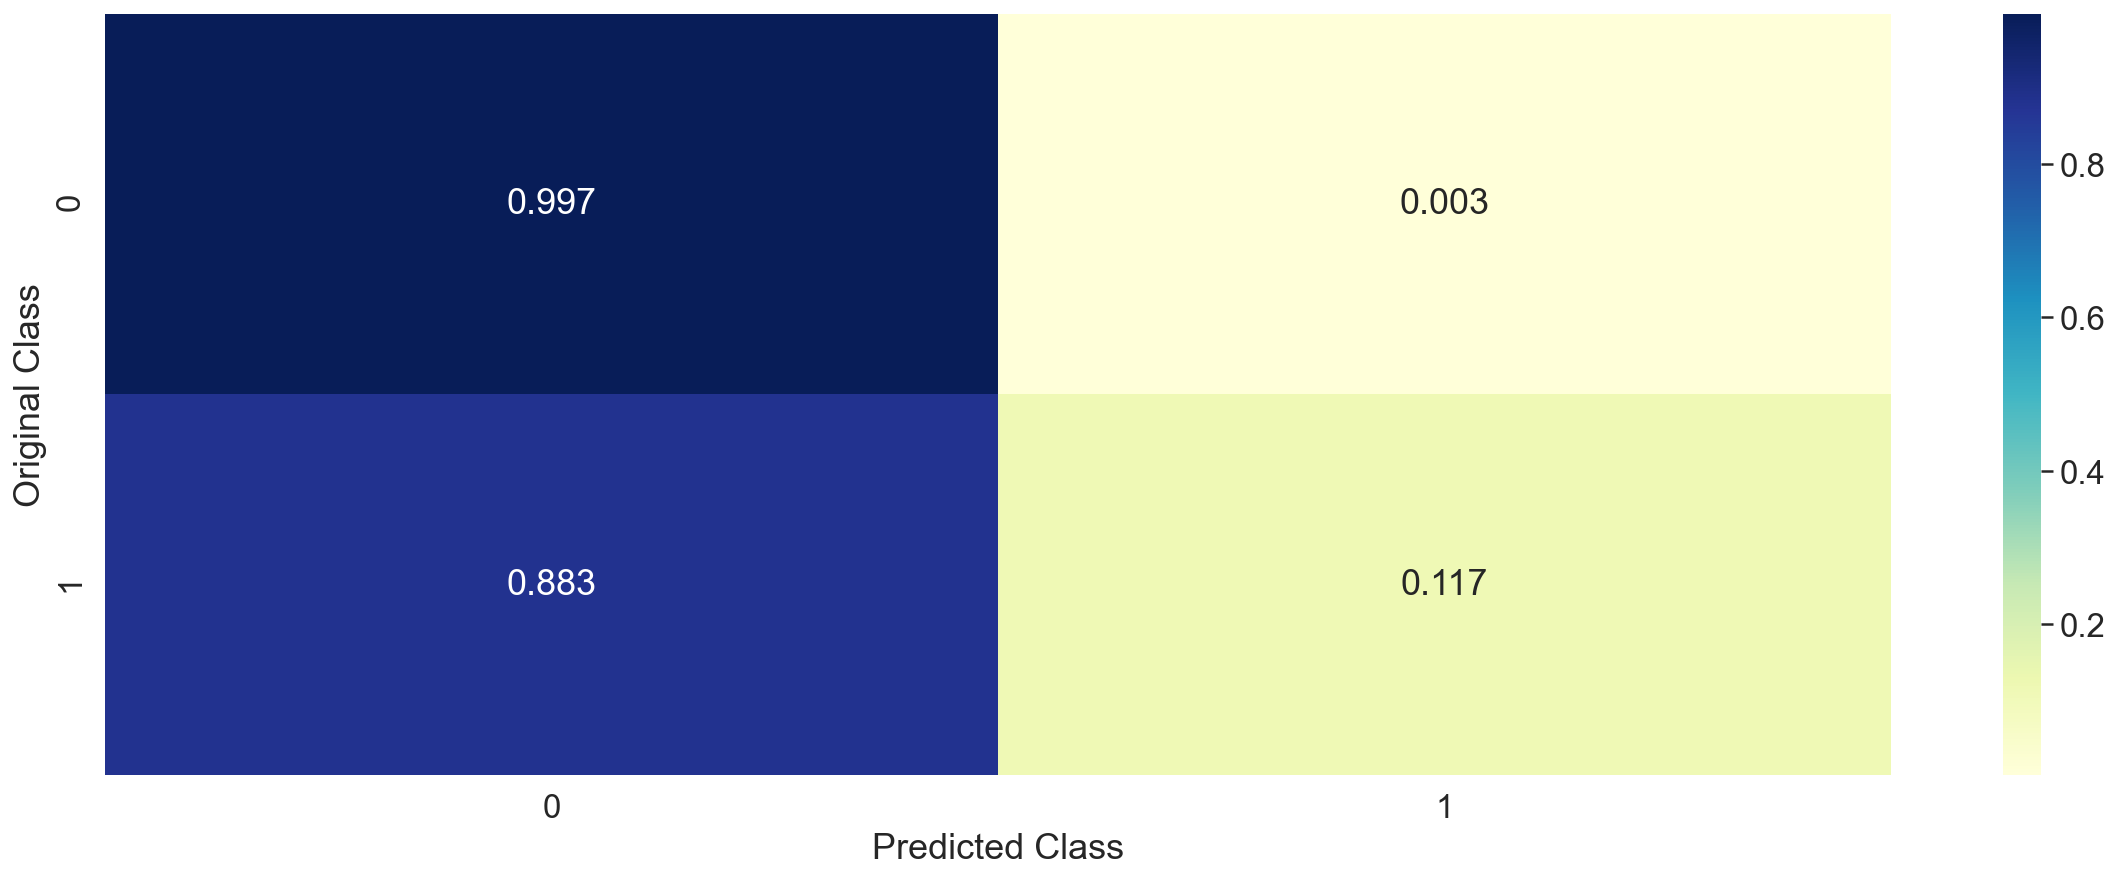

array([[19249,    65],
       [  470,    62]], dtype=int64)

In [205]:
print('_train_'*10)
plot_confusion_matrix(y_train, sig_clf.predict(x_train_hstack))
confusion_matrix(y_train, sig_clf.predict(x_train_hstack))


print('_test_'*10)
plot_confusion_matrix(y_test,  sig_clf.predict(x_test_hstack))
confusion_matrix(y_test,  sig_clf.predict(x_test_hstack))

print('_cv_'*10)
plot_confusion_matrix(y_cv, sig_clf.predict(x_cv_hstack))
confusion_matrix(y_cv, sig_clf.predict(x_cv_hstack))


# K-Neighbors Classifier

## K-nn Hyperparameter tunning

for alpha = 5
Log Loss : 0.05647489778165393
for alpha = 11
Log Loss : 0.06129080297302957
for alpha = 15
Log Loss : 0.06345803294466601
for alpha = 21
Log Loss : 0.06466007792237484
for alpha = 31
Log Loss : 0.06563665028976537
for alpha = 41
Log Loss : 0.06866025668613021
for alpha = 51
Log Loss : 0.07113785317102454
for alpha = 99
Log Loss : 0.07489970905635654


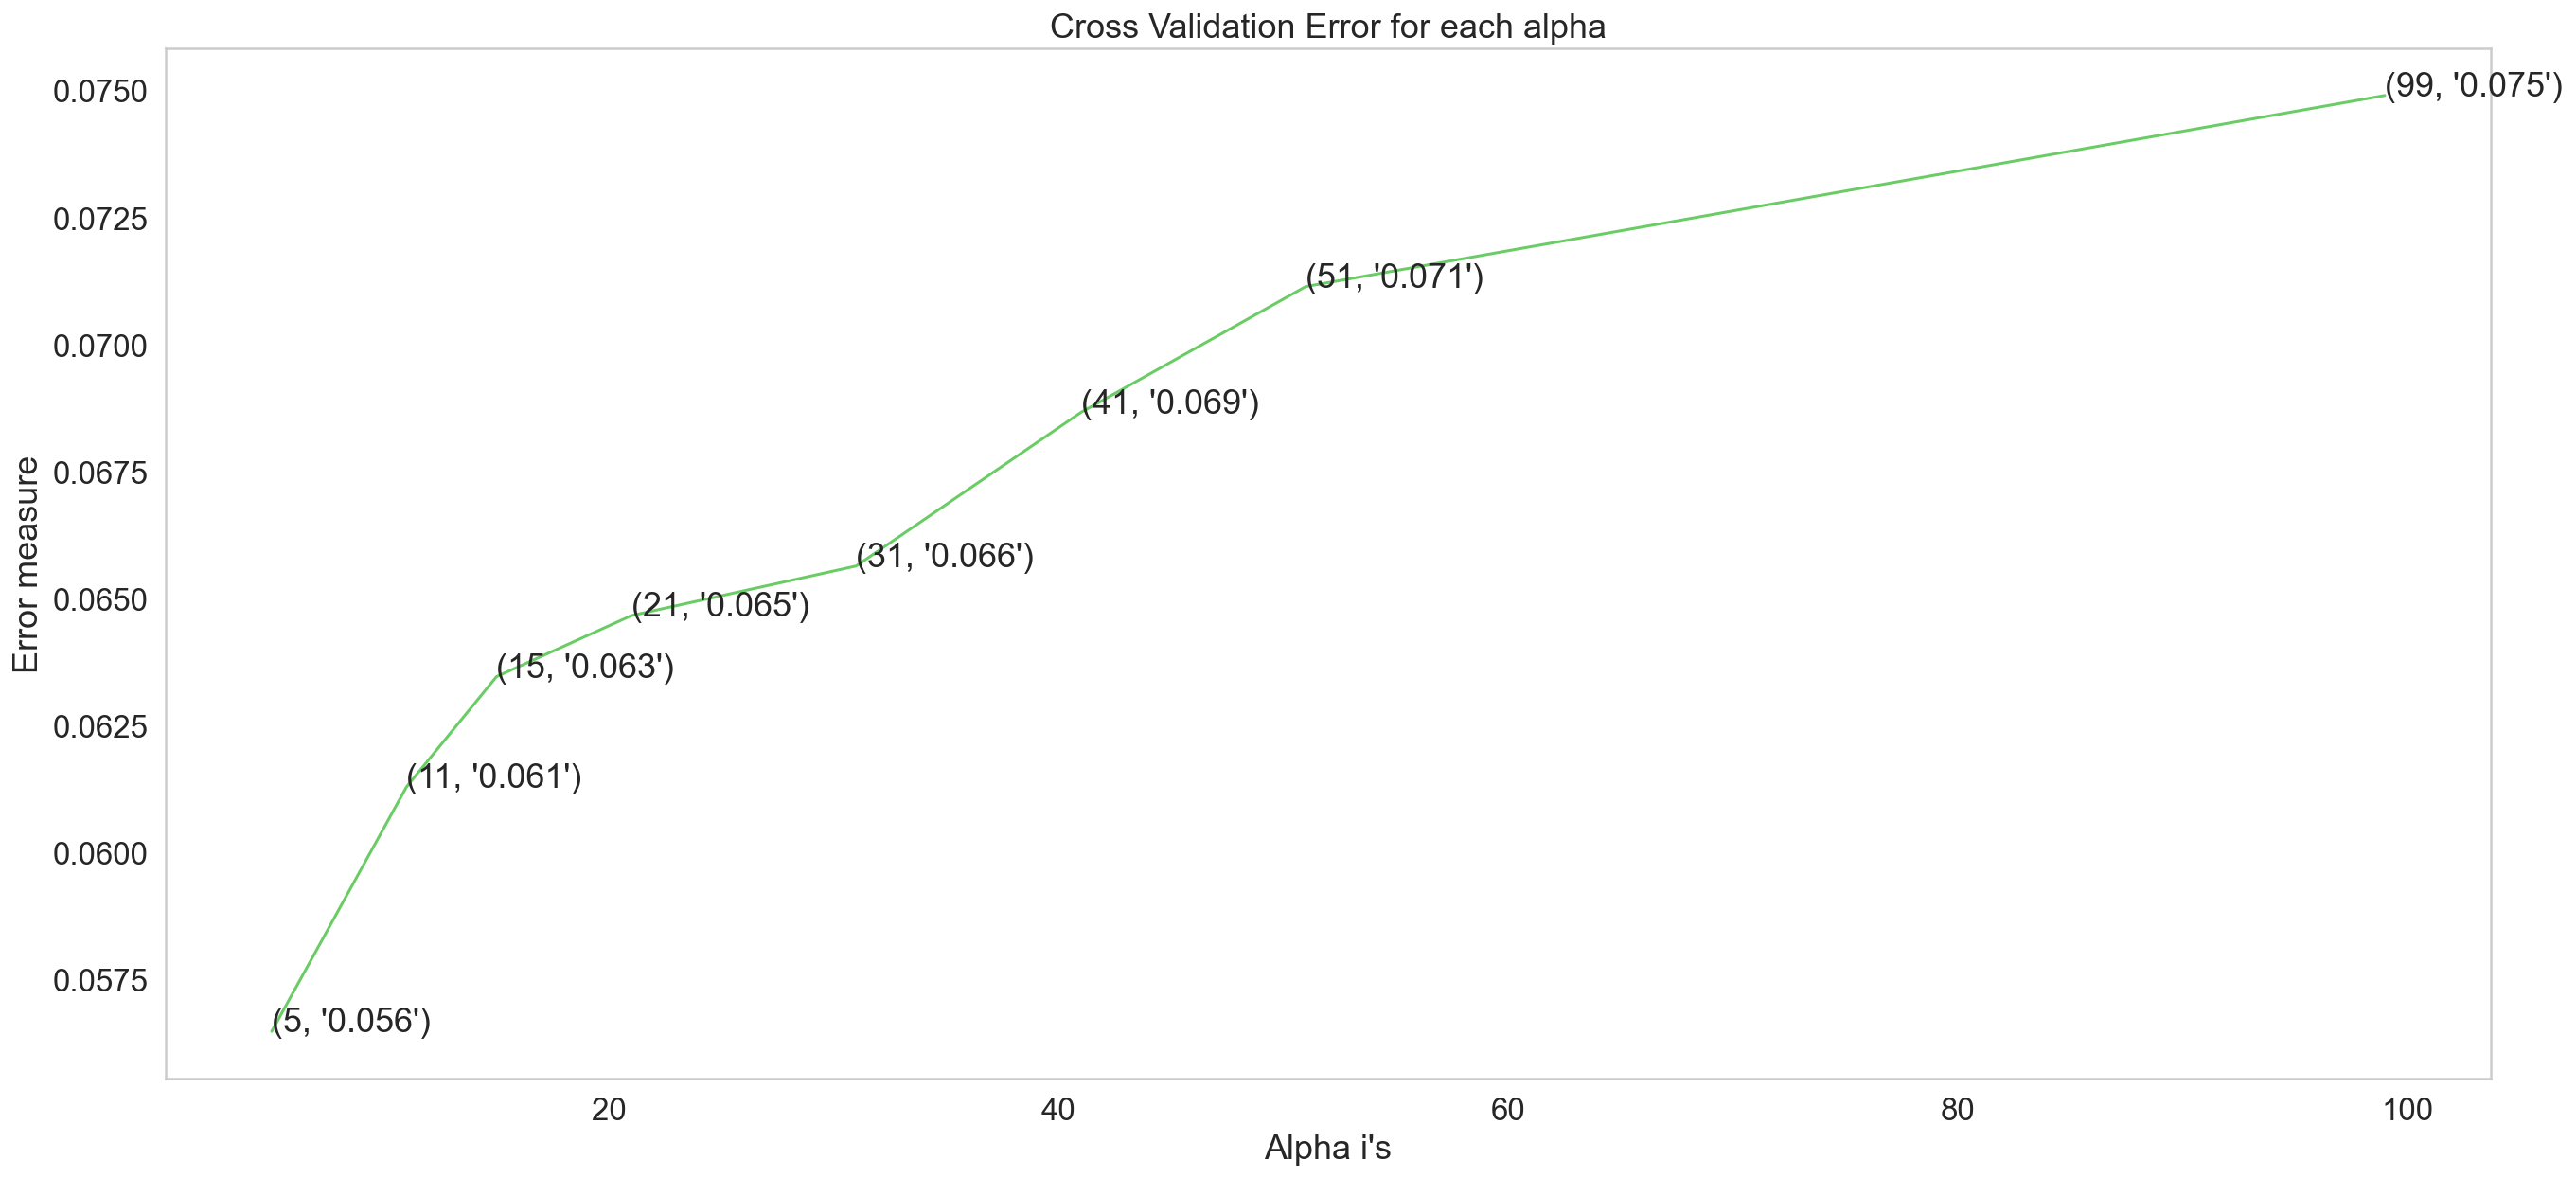

For values of best alpha =  5 The train log loss is: 0.040007958166728114
For values of best alpha =  5 The cross validation log loss is: 0.05647489778165393
For values of best alpha =  5 The test log loss is: 0.05788788571768629


In [206]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(x_train_hstack, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train_hstack, y_train)
    sig_clf_probs = sig_clf.predict_proba(x_cv_hstack)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(x_train_hstack, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train_hstack, y_train)

predict_y = sig_clf.predict_proba(x_train_hstack)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_cv_hstack)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test_hstack)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## K-nn Logloss and Classification report

In [208]:
print("."*60,"AUC","."*60)
print("multiclass_AUC Train data:", multiclass_roc_auc_score(y_train,sig_clf.predict(x_train_hstack),average="macro"))
print("multiclass_AUC Test data:", multiclass_roc_auc_score(y_test,sig_clf.predict(x_test_hstack),average="macro"))
print("multiclass_AUC cv data:", multiclass_roc_auc_score(y_cv,sig_clf.predict(x_cv_hstack),average="macro"))


print(" "*100)
print("."*40,"Class Report","."*40)
print(" "*100)
print("-"*20,"Train Data","-"*30)
print( classification_report(y_train, sig_clf.predict(x_train_hstack)))
print("-"*20,"Test Data","-"*20)
print( classification_report(y_test, sig_clf.predict(x_test_hstack)))
print("-"*20,"CV Data","-"*20)
print( classification_report(y_cv, sig_clf.predict(x_cv_hstack)))

y_train_pred = sig_clf.predict_proba(x_train_hstack)    
y_test_pred = sig_clf.predict_proba(x_test_hstack)
y_cv_pred = sig_clf.predict_proba(x_cv_hstack)


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train.astype(int),y_train_pred[:,1])

test_fpr, test_tpr, te_thresholds = roc_curve(y_test.astype(int),y_test_pred[:,1])

cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv.astype(int),y_cv_pred[:,1])



plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))



plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


............................................................ AUC ............................................................
multiclass_AUC Train data: 0.7759954418687023
multiclass_AUC Test data: 0.7310674686052384
multiclass_AUC cv data: 0.7492571324241014
                                                                                                    
........................................ Class Report ........................................
                                                                                                    
-------------------- Train Data ------------------------------


KeyboardInterrupt: 

## K-nn confusion matrix

In [ ]:
print('_train_'*10)
plot_confusion_matrix(y_train, sig_clf.predict(x_train_hstack))
confusion_matrix(y_train, sig_clf.predict(x_train_hstack))


print('_test_'*10)
plot_confusion_matrix(y_test,  sig_clf.predict(x_test_hstack))
confusion_matrix(y_test,  sig_clf.predict(x_test_hstack))

print('_cv_'*10)
plot_confusion_matrix(y_cv, sig_clf.predict(x_cv_hstack))
confusion_matrix(y_cv, sig_clf.predict(x_cv_hstack))


# LogisticRegression

## Logistic Regression - Hyperparameter tunning

In [209]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score , balanced_accuracy_score
import matplotlib.pyplot as plt

In [210]:
ml =  LogisticRegression()
parameters = {"C": [0.00001,0.0001,0.001,0.01,0.1],
              "penalty":["l2","l1"],
              'solver':['saga']}
CV = RandomizedSearchCV(ml, parameters, 
                  return_train_score=True, 
                  cv=3,
                  scoring='neg_log_loss',
                  error_score='raise',
                  n_jobs=-1,
                  verbose=5)
CV.fit(x_train_hstack, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, error_score='raise', estimator=LogisticRegression(),
                   n_jobs=-1,
                   param_distributions={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1,
                                              1, 10, 100, 1000, 10000],
                                        'penalty': ['l2', 'l1'],
                                        'solver': ['saga']},
                   return_train_score=True, scoring='neg_log_loss', verbose=5)

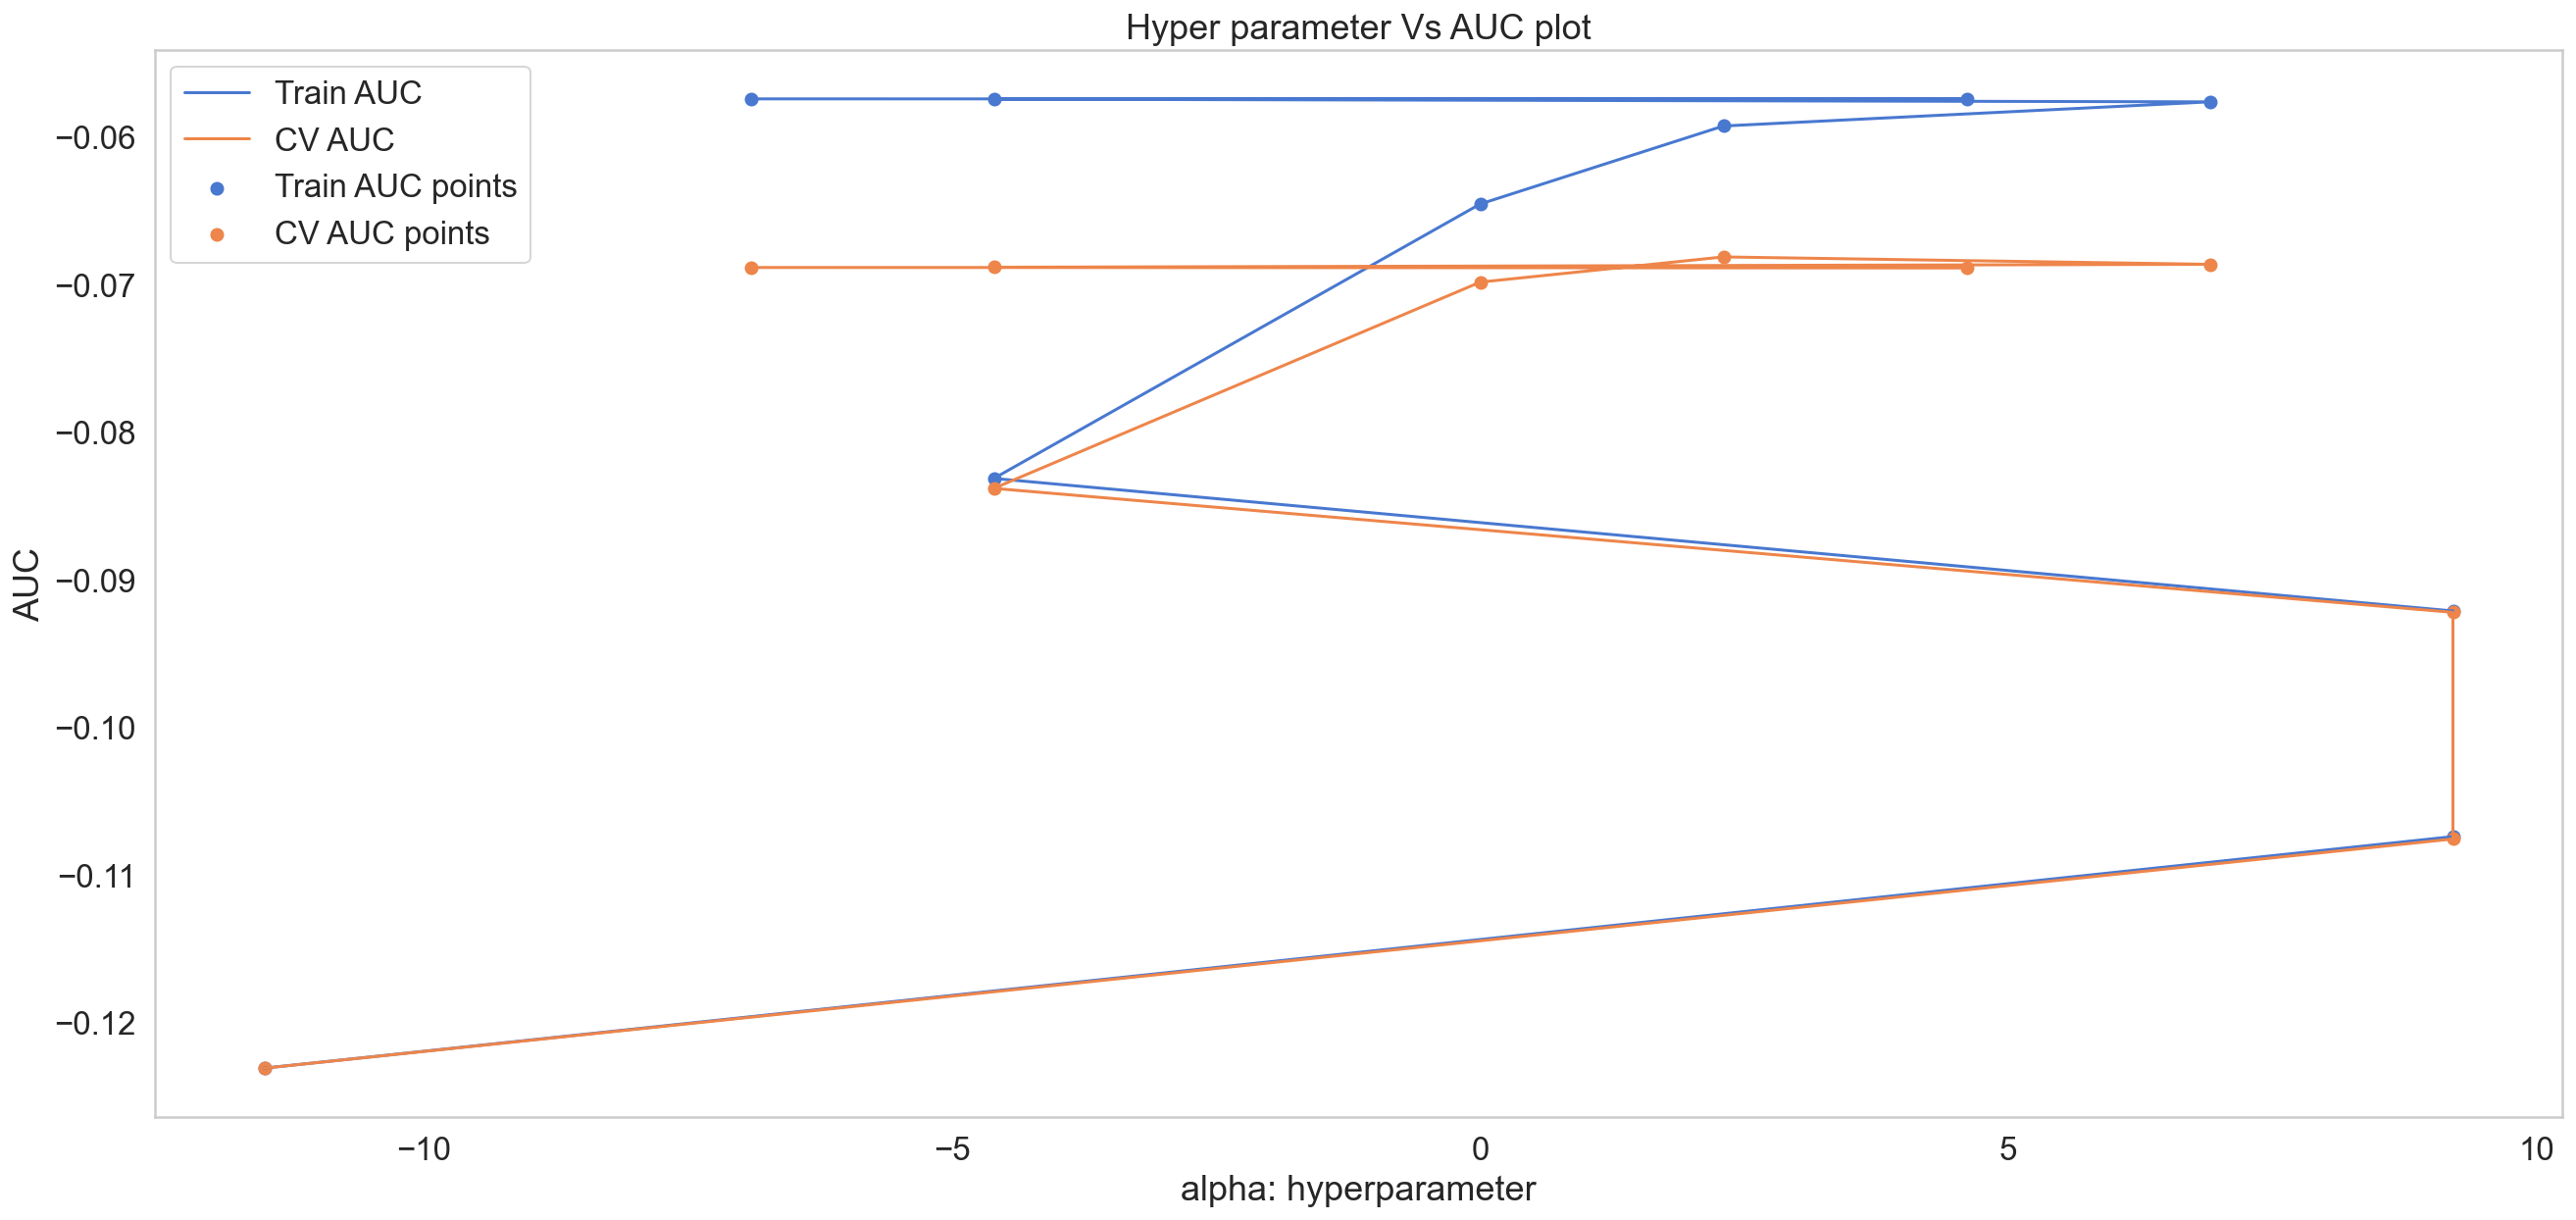

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_solver  \
0       4.628861      0.217295         0.146293        0.019421         saga   
9       3.763984      0.145032         0.099294        0.007795         saga   

  param_penalty param_C                                           params  \
0            l2   1e-05  {'solver': 'saga', 'penalty': 'l2', 'C': 1e-05}   
9            l2   0.001  {'solver': 'saga', 'penalty': 'l2', 'C': 0.001}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0          -0.123161          -0.123161          -0.123031        -0.123118   
9          -0.107635          -0.107593          -0.107537        -0.107588   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.000062               10           -0.123094           -0.123094   
9        0.000040                9           -0.107363           -0.107511   

   split2_train_score  mean_train_score  std_train_score  
0           -0.123158         -0.123115         0.000030  
9           -0.107408         -0.107428         0.000062

In [211]:
results = pd.DataFrame.from_dict(CV.cv_results_)
import math
logvalues = []
for i in range(0,results['param_C'].shape[0]):
    logvalues.append(math.log(results['param_C'][i]))
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alpha =  results['param_C']

plt.plot(logvalues, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(logvalues, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(logvalues, train_auc, label='Train AUC points')
plt.scatter(logvalues, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head(2)

In [212]:
import math
logvalues = []
for i in range(0,results['param_C'].shape[0]):
    logvalues.append(math.log(results['param_C'][i]))

In [213]:
CV.best_params_

{'solver': 'saga', 'penalty': 'l2', 'C': 10}

## Logistic regression - AUC 

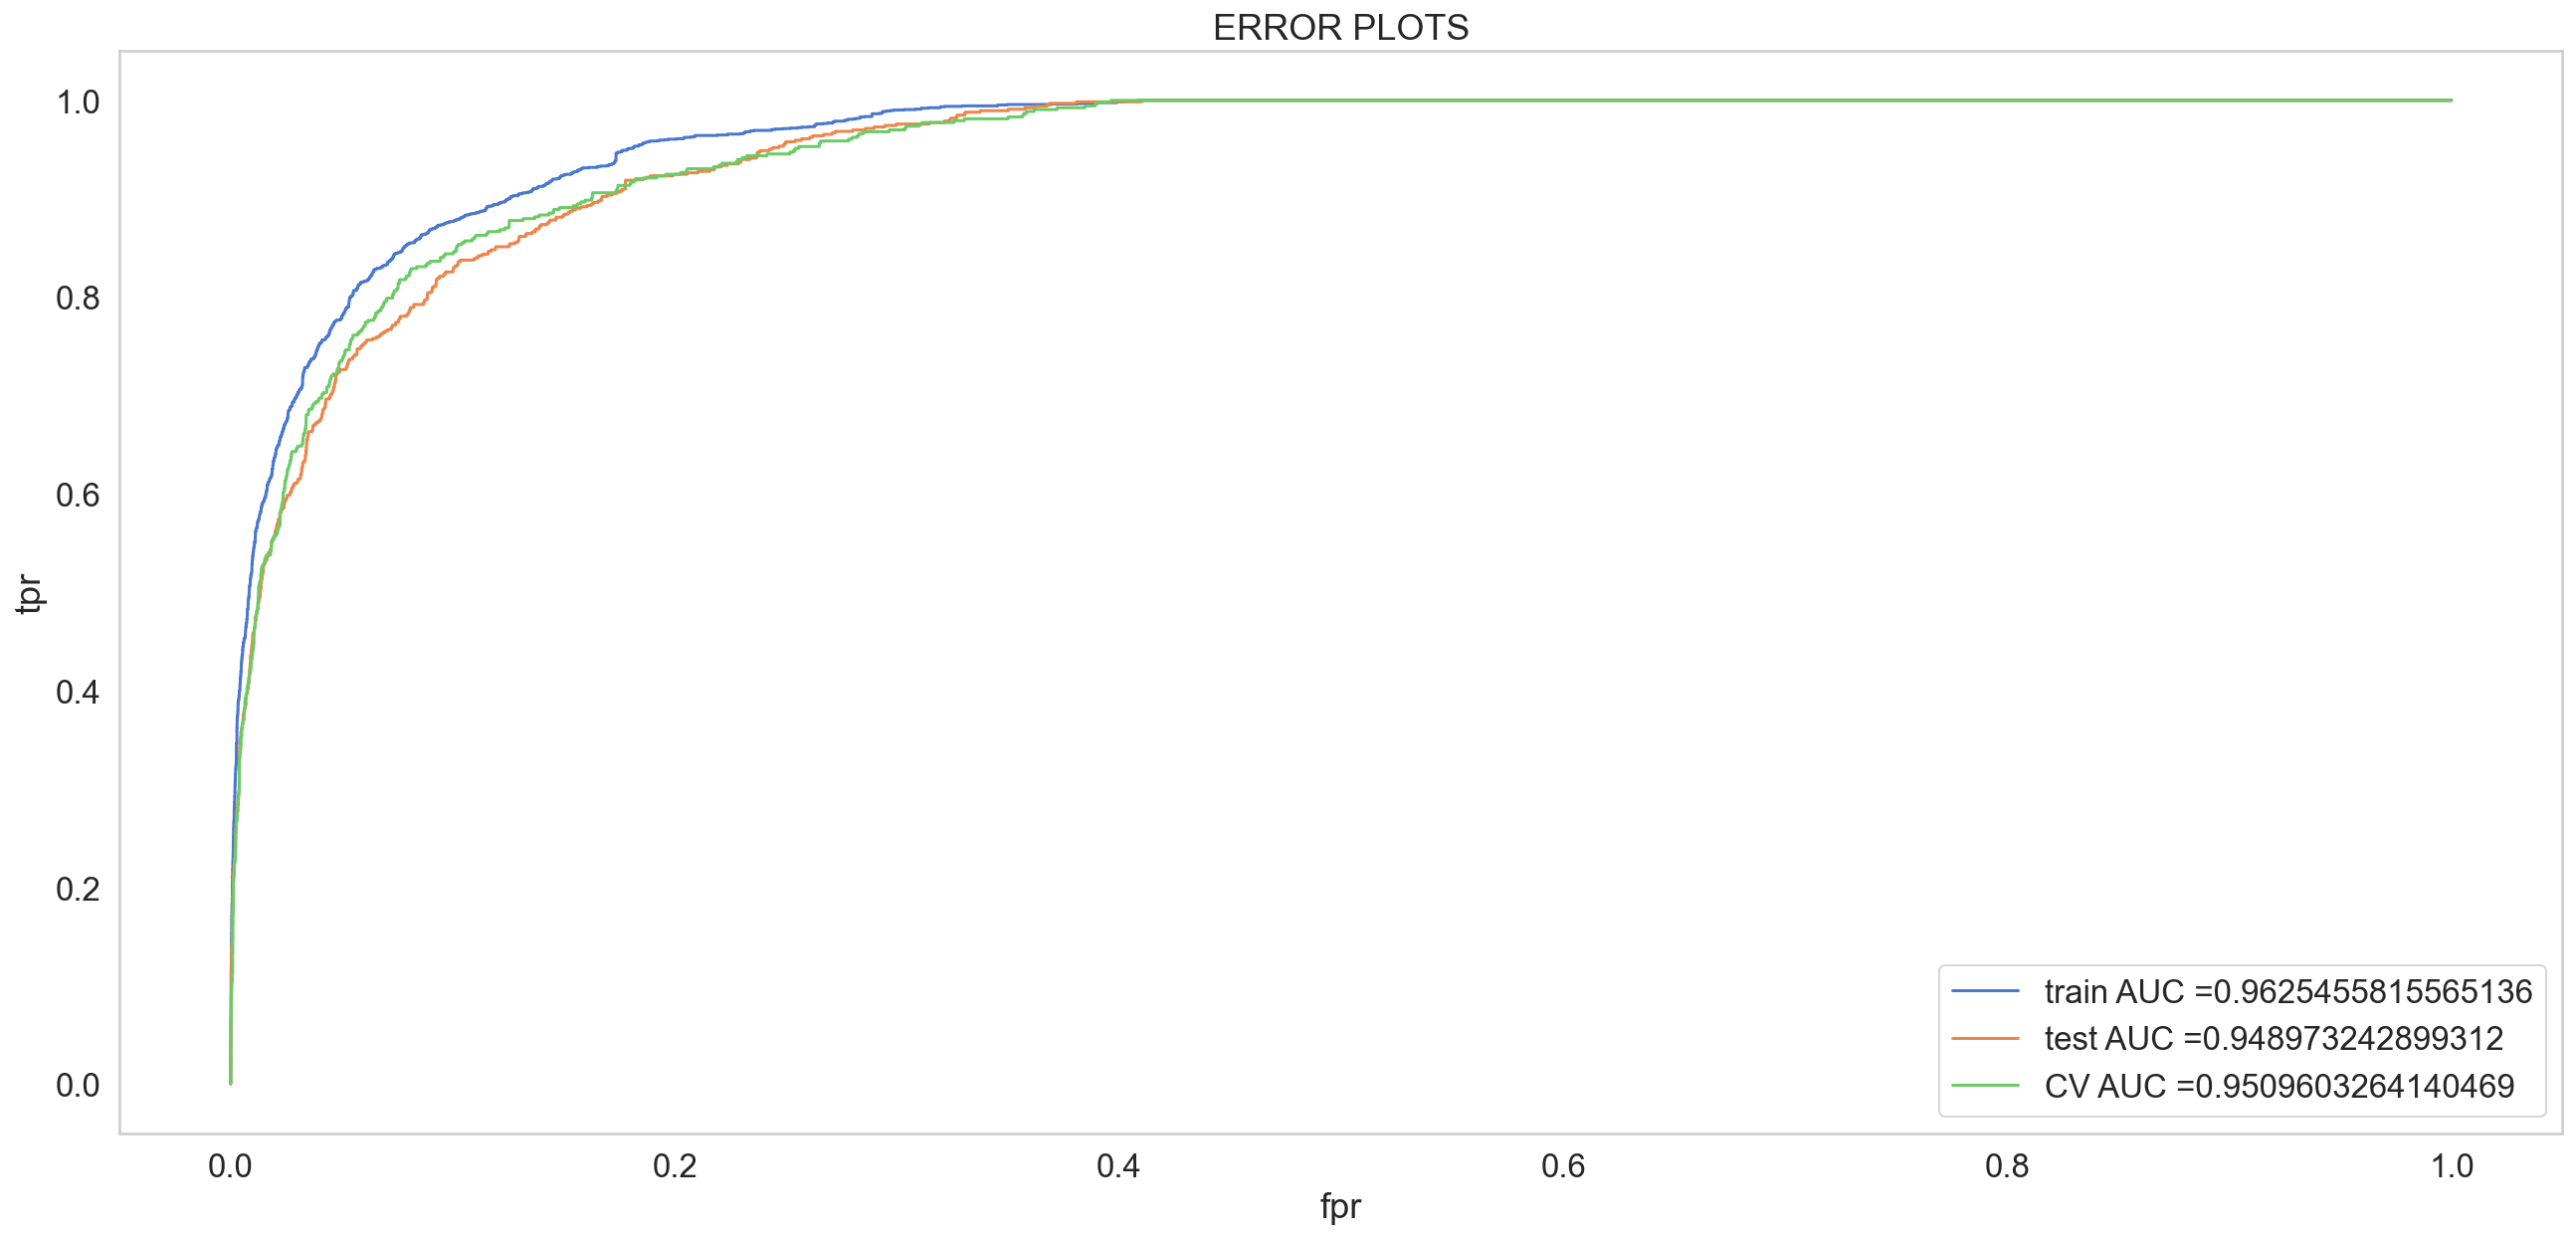

In [217]:
from sklearn.metrics import roc_curve, auc
model = LogisticRegression(C=10,penalty='l2',solver='saga')
model.fit(x_train_hstack, y_train)

y_train_pred = model.predict_proba(x_train_hstack)    
y_test_pred = model.predict_proba(x_test_hstack)
y_cv_pred = model.predict_proba(x_cv_hstack)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train.astype('int'),y_train_pred[:,1] )

test_fpr, test_tpr, te_thresholds = roc_curve(y_test.astype('int'),y_test_pred[:,1] )

cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv.astype('int'),y_cv_pred[:,1] )



plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))


plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Logistic Regression - LogLoss and Classification Report

In [221]:
from sklearn.metrics import classification_report 

In [224]:
predict_y = model.predict_proba(x_train_hstack)
print("train log loss:", log_loss(y_train, predict_y, labels=model.classes_, eps=1e-15))
predict_y = model.predict_proba(x_test_hstack)
print("test log loss:", log_loss(y_test, predict_y,labels=model.classes_, eps=1e-15))
predict_y = model.predict_proba(x_cv_hstack)
print("cv log loss:", log_loss(y_cv, predict_y,labels=model.classes_, eps=1e-15))


print("."*60,"AUC","."*60)
print("AUC Train data:", multiclass_roc_auc_score(y_train,model.predict(x_train_hstack),average="macro"))
print("AUC Test data:", multiclass_roc_auc_score(y_test,model.predict(x_test_hstack),average="macro"))
print("AUC cv data:", multiclass_roc_auc_score(y_cv,model.predict(x_cv_hstack),average="macro"))



print(" "*100)
print("."*40,"Class Report","."*40)
print(" "*100)
print("-"*20,"Train Data","-"*30)
print( classification_report(y_train, model.predict(x_train_hstack)))
print("-"*20,"Test Data","-"*20)
print( classification_report(y_test, model.predict(x_test_hstack)))
print("-"*20,"CV Data","-"*20)
print( classification_report(y_cv, model.predict(x_cv_hstack)))


train log loss: 0.05979121260135492
test log loss: 0.06787166353738963
cv log loss: 0.06655975609157548
............................................................ AUC ............................................................
AUC Train data: 0.6852276803192396
AUC Test data: 0.66868845546058
AUC cv data: 0.6669983439493421
                                                                                                    
........................................ Class Report ........................................
                                                                                                    
-------------------- Train Data ------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     77256
           1       0.77      0.37      0.50      2126

    accuracy                           0.98     79382
   macro avg       0.88      0.69      0.75     79382
weighted avg       0.98      0.98      

# SVM

## SVM Hyperparameter tunning

In [225]:
from sklearn.linear_model import SGDClassifier


In [230]:
ml = SGDClassifier(penalty ='l2', loss='hinge',class_weight='balanced', random_state=42)
parameters = { "alpha": [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}
#parameters = {'n_iter': [30, 50, 100], 'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}
CV = RandomizedSearchCV(ml, parameters, 
                  return_train_score=True, 
                  cv=2,
                  scoring='balanced_accuracy',
                  error_score='raise',
                  n_jobs=-1,
                  verbose=5)
CV.fit(x_train_hstack, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2, error_score='raise',
                   estimator=SGDClassifier(class_weight='balanced',
                                           random_state=42),
                   n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.0001, 0.001, 0.01,
                                                  0.1, 1, 10, 100, 1000,
                                                  10000]},
                   return_train_score=True, scoring='balanced_accuracy',
                   verbose=5)

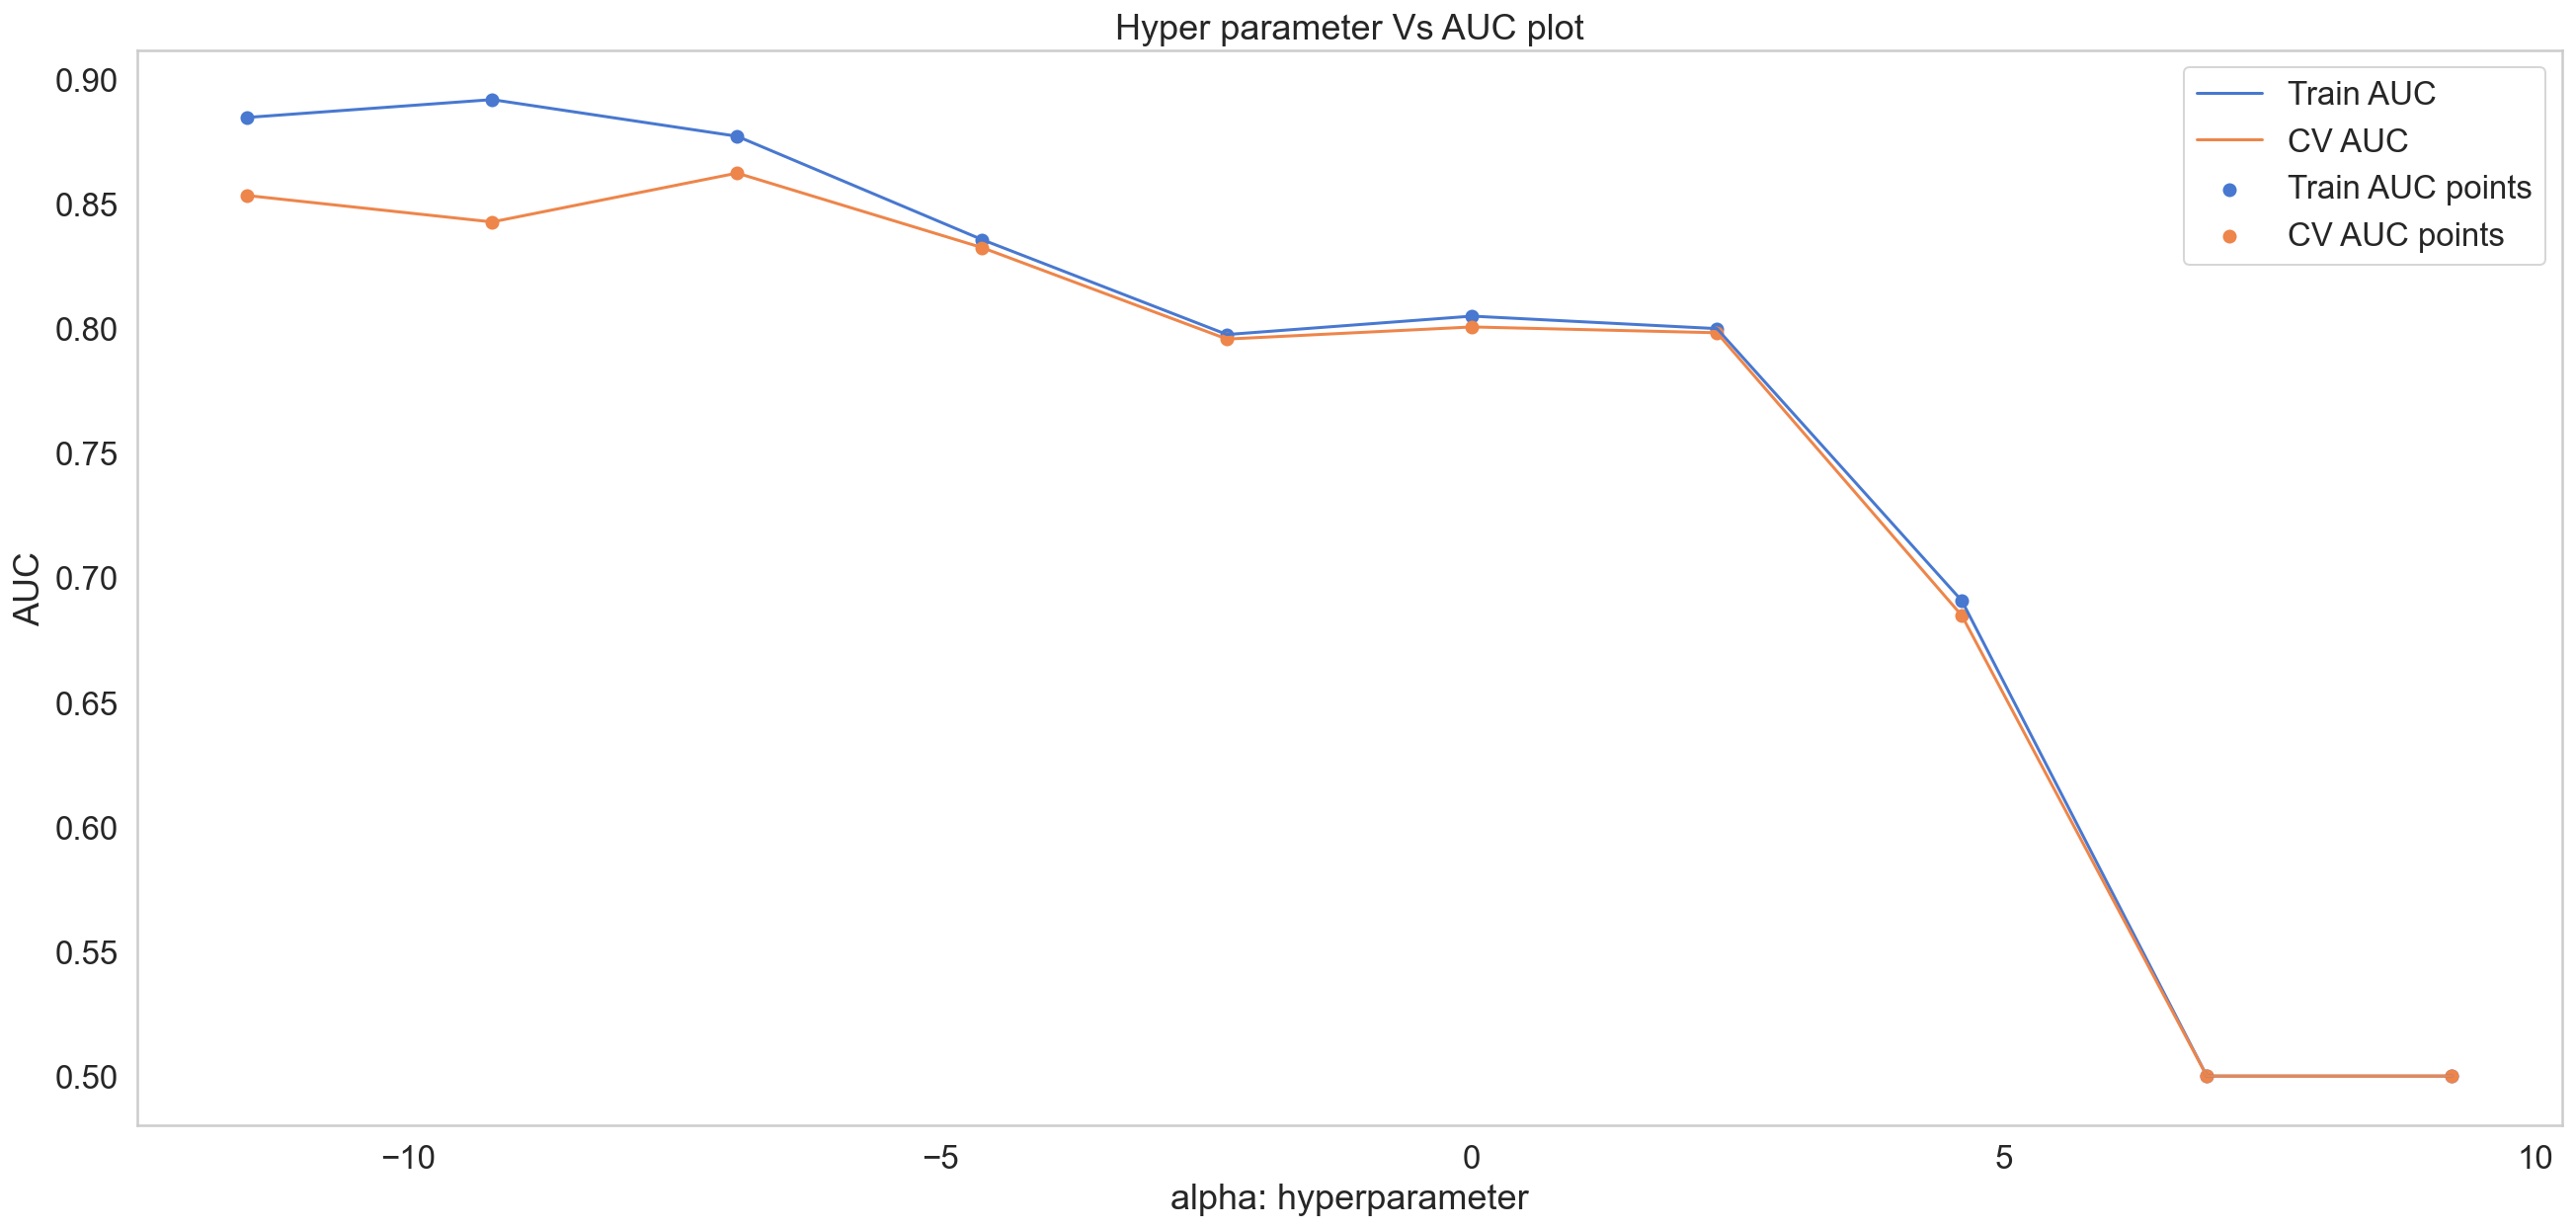

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.960575      0.062333         0.390164        0.105141       1e-05   
1       0.483752      0.075298         0.529149        0.037909      0.0001   

              params  split0_test_score  split1_test_score  mean_test_score  \
0   {'alpha': 1e-05}           0.855149           0.851117         0.853133   
1  {'alpha': 0.0001}           0.850911           0.834162         0.842537   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.002016                2            0.885645            0.883240   
1        0.008375                3            0.894681            0.888513   

   mean_train_score  std_train_score  
0          0.884443         0.001203  
1          0.891597         0.003084

In [231]:
results = pd.DataFrame.from_dict(CV.cv_results_)
import math
logvalues = []
for i in range(0,results['param_alpha'].shape[0]):
    logvalues.append(math.log(results['param_alpha'][i]))
results = results.sort_values(['param_alpha'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alpha =  results['param_alpha']

plt.plot(logvalues, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(logvalues, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(logvalues, train_auc, label='Train AUC points')
plt.scatter(logvalues, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head(2)

In [232]:
CV.best_params_

{'alpha': 0.001}

## SVM - AUC

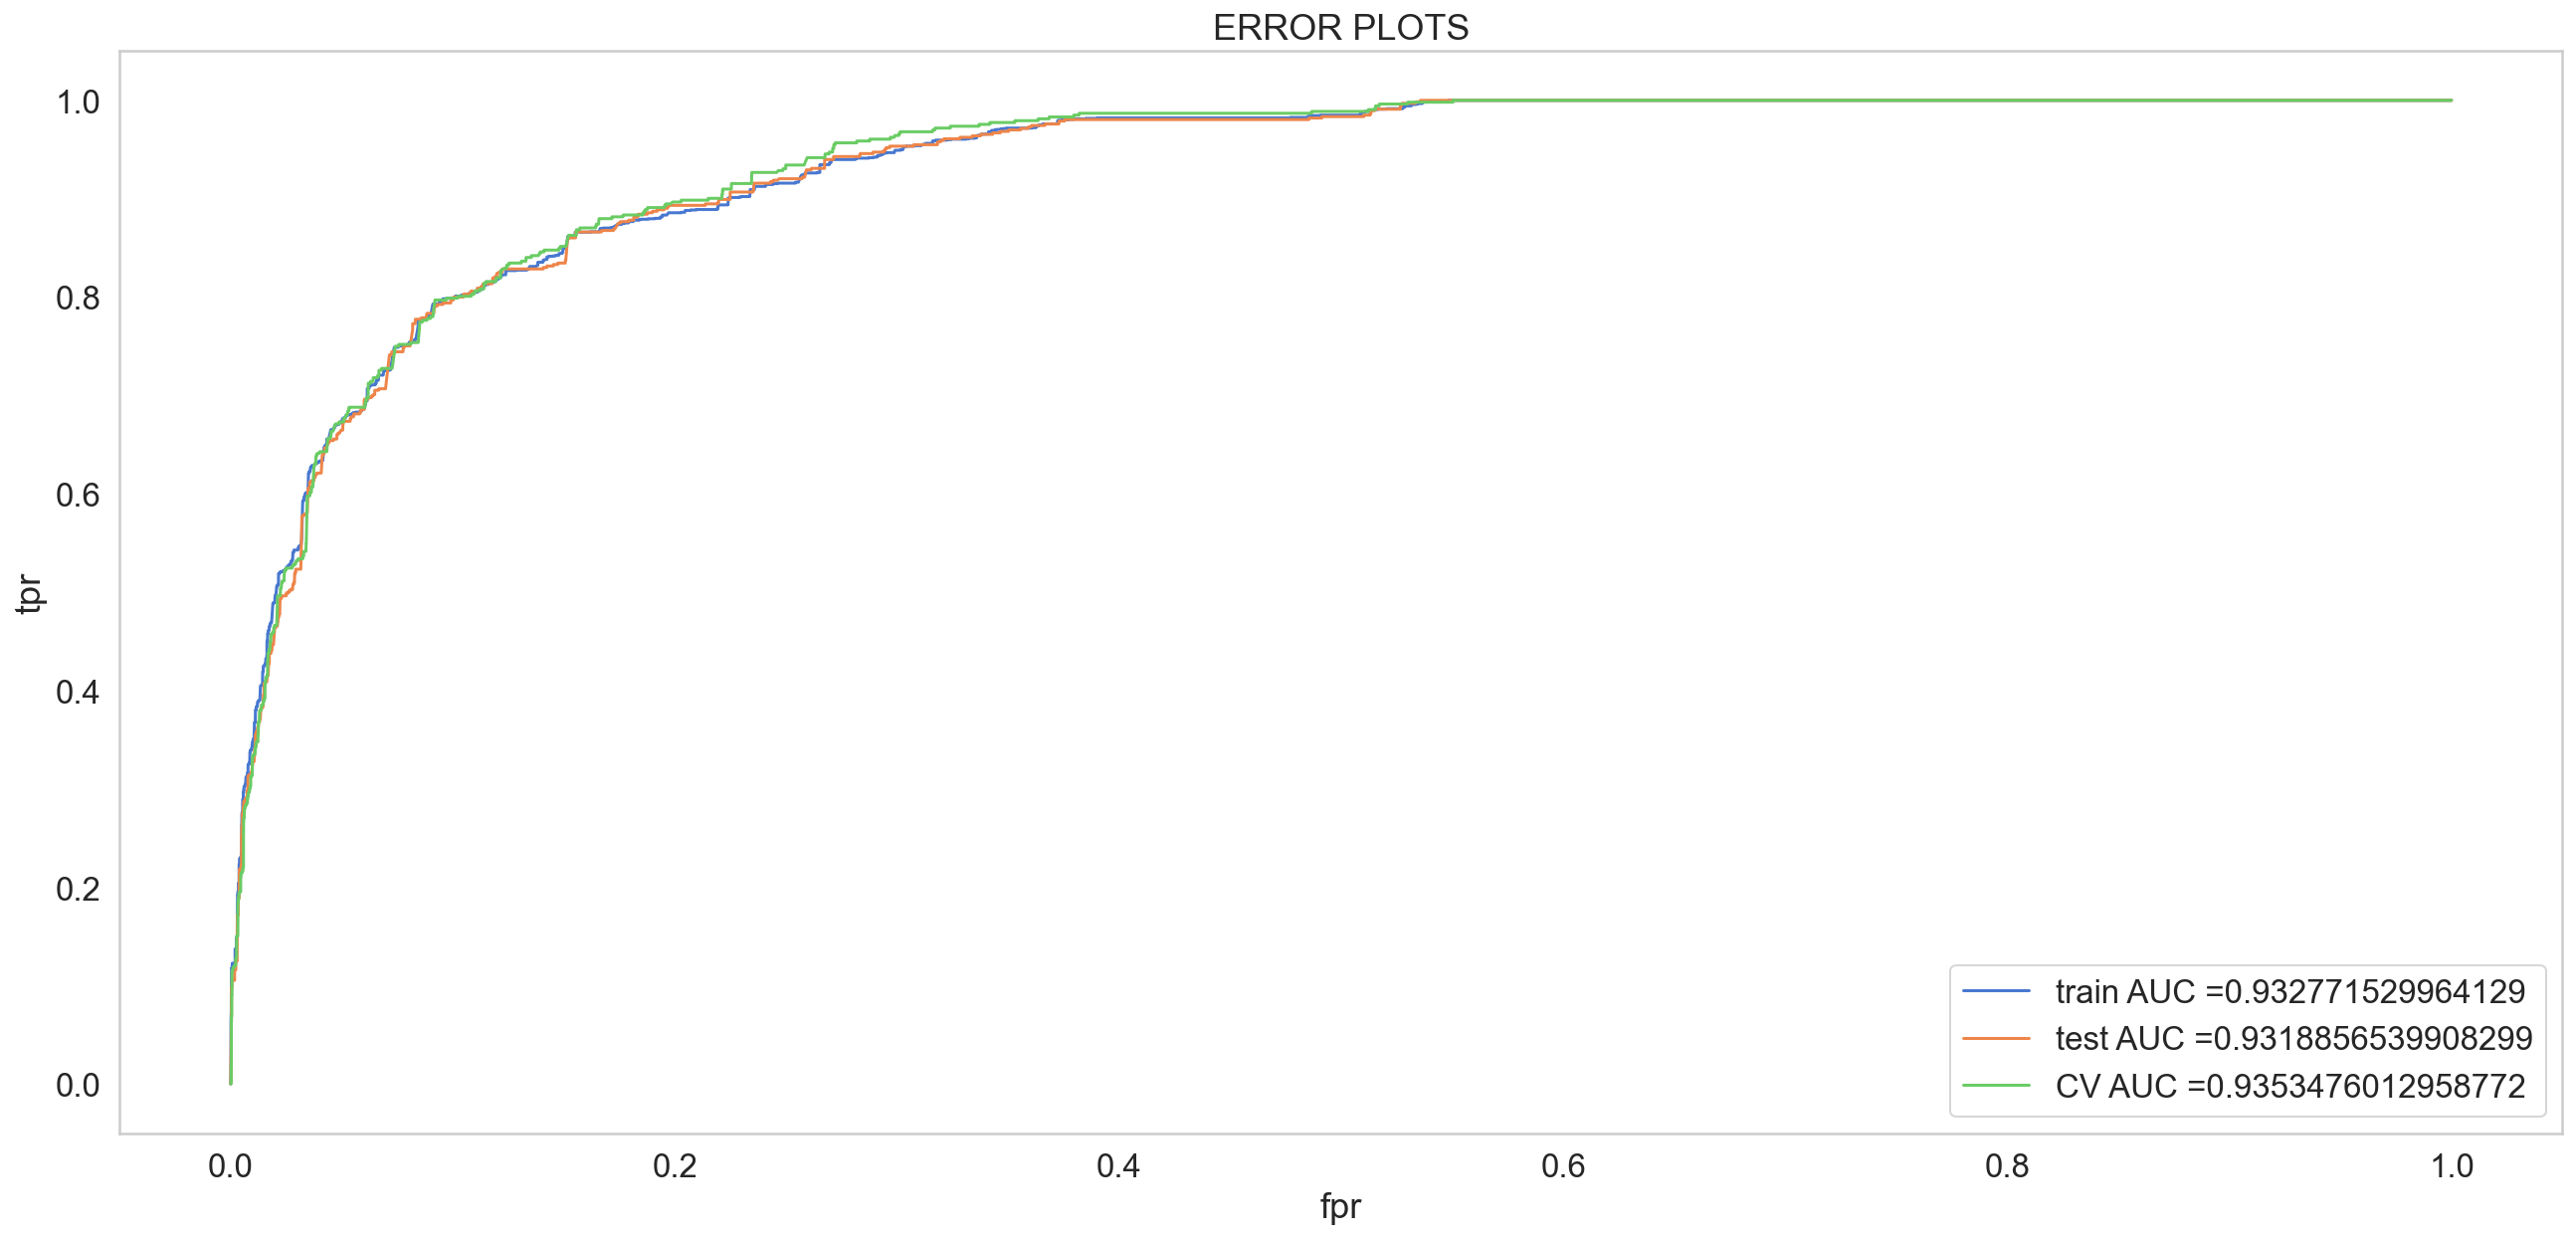

In [234]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc
model = SGDClassifier(alpha= 0.001, penalty='elasticnet', random_state=42)

calibrator = CalibratedClassifierCV(model)

model = calibrator.fit(x_train_hstack, y_train)

y_train_pred = model.predict_proba(x_train_hstack)    
y_test_pred = model.predict_proba(x_test_hstack)
y_cv_pred = model.predict_proba(x_cv_hstack)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train.astype('int'),y_train_pred[:,1] )

test_fpr, test_tpr, te_thresholds = roc_curve(y_test.astype('int'),y_test_pred[:,1] )

cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv.astype('int'),y_cv_pred[:,1] )



plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))


plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## SVM - Logloss and classification report

train log loss: 0.0916833772810009
test log loss: 0.09271647894607835
cv log loss: 0.09320680497771272
                                                                                                    
........................................ Class Report ........................................
                                                                                                    
-------------------- Train Data ------------------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     77256
           1       0.57      0.23      0.33      2126

    accuracy                           0.97     79382
   macro avg       0.77      0.61      0.66     79382
weighted avg       0.97      0.97      0.97     79382

-------------------- Test Data --------------------
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     24142
           1       0.56      0.22      0.32      

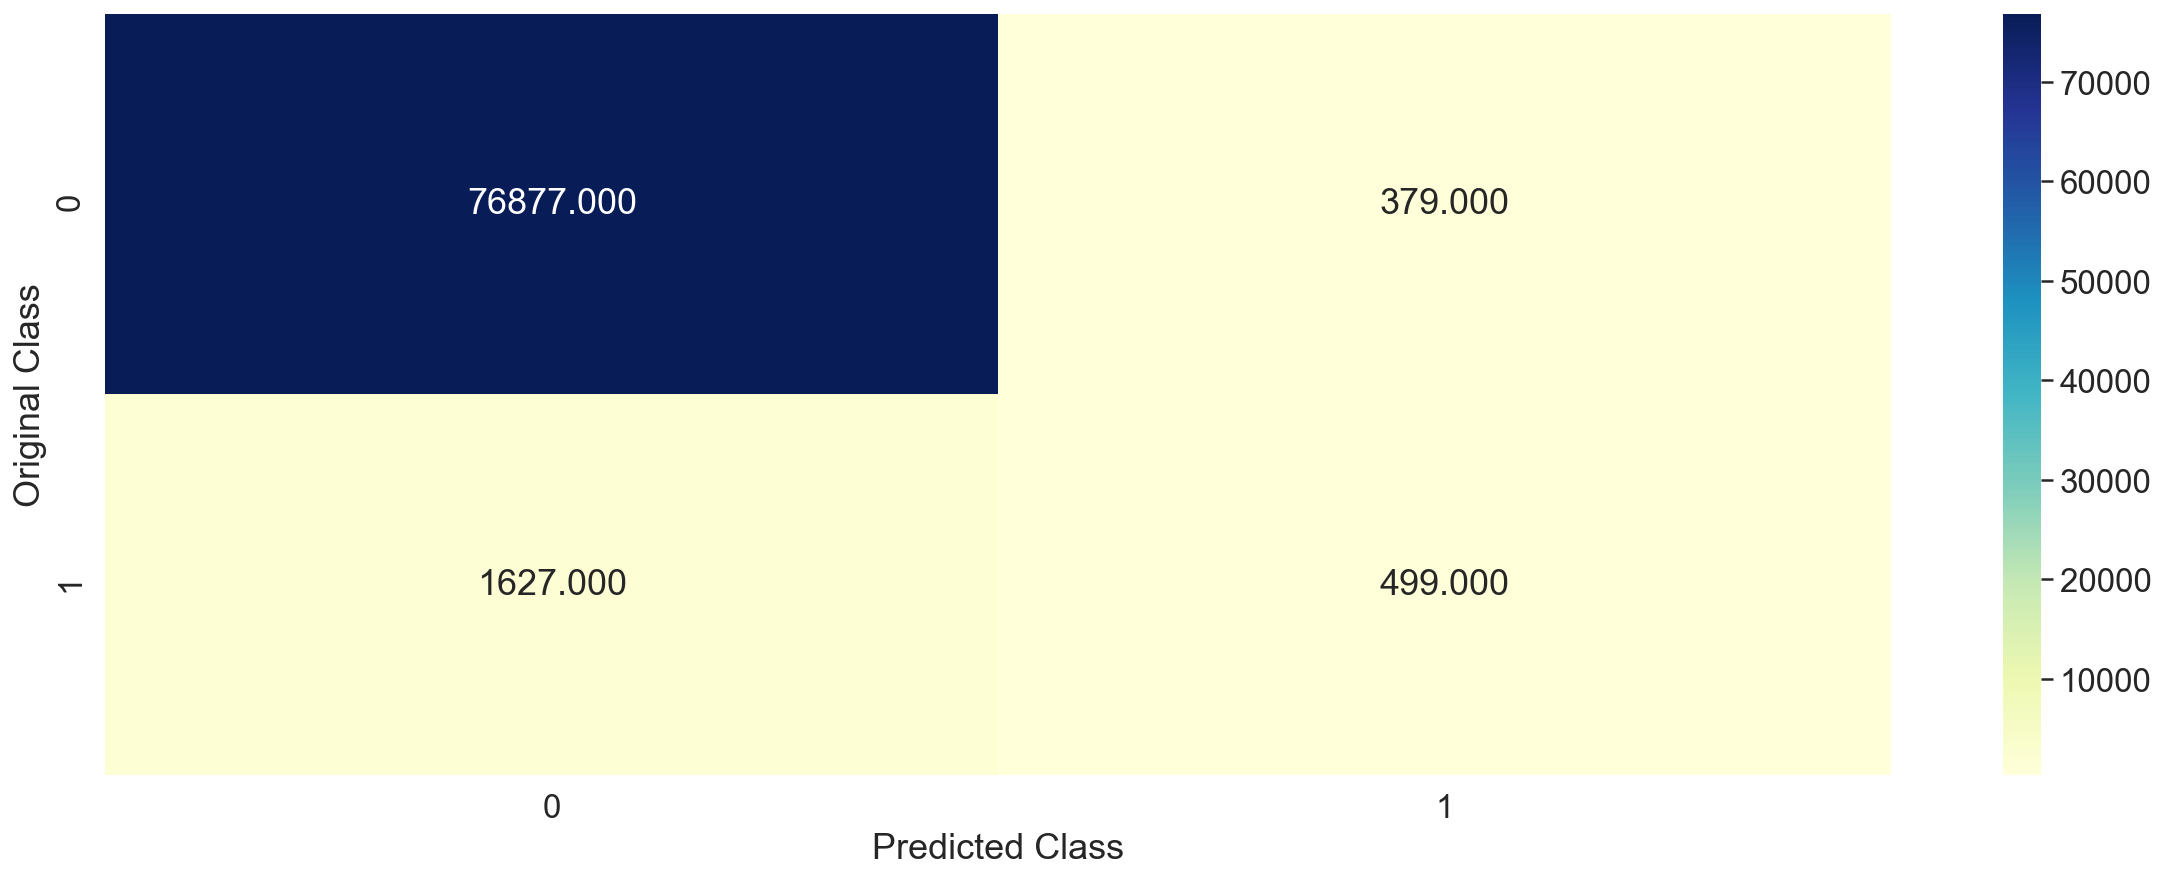

-------------------- Precision matrix (Columm Sum=1) --------------------


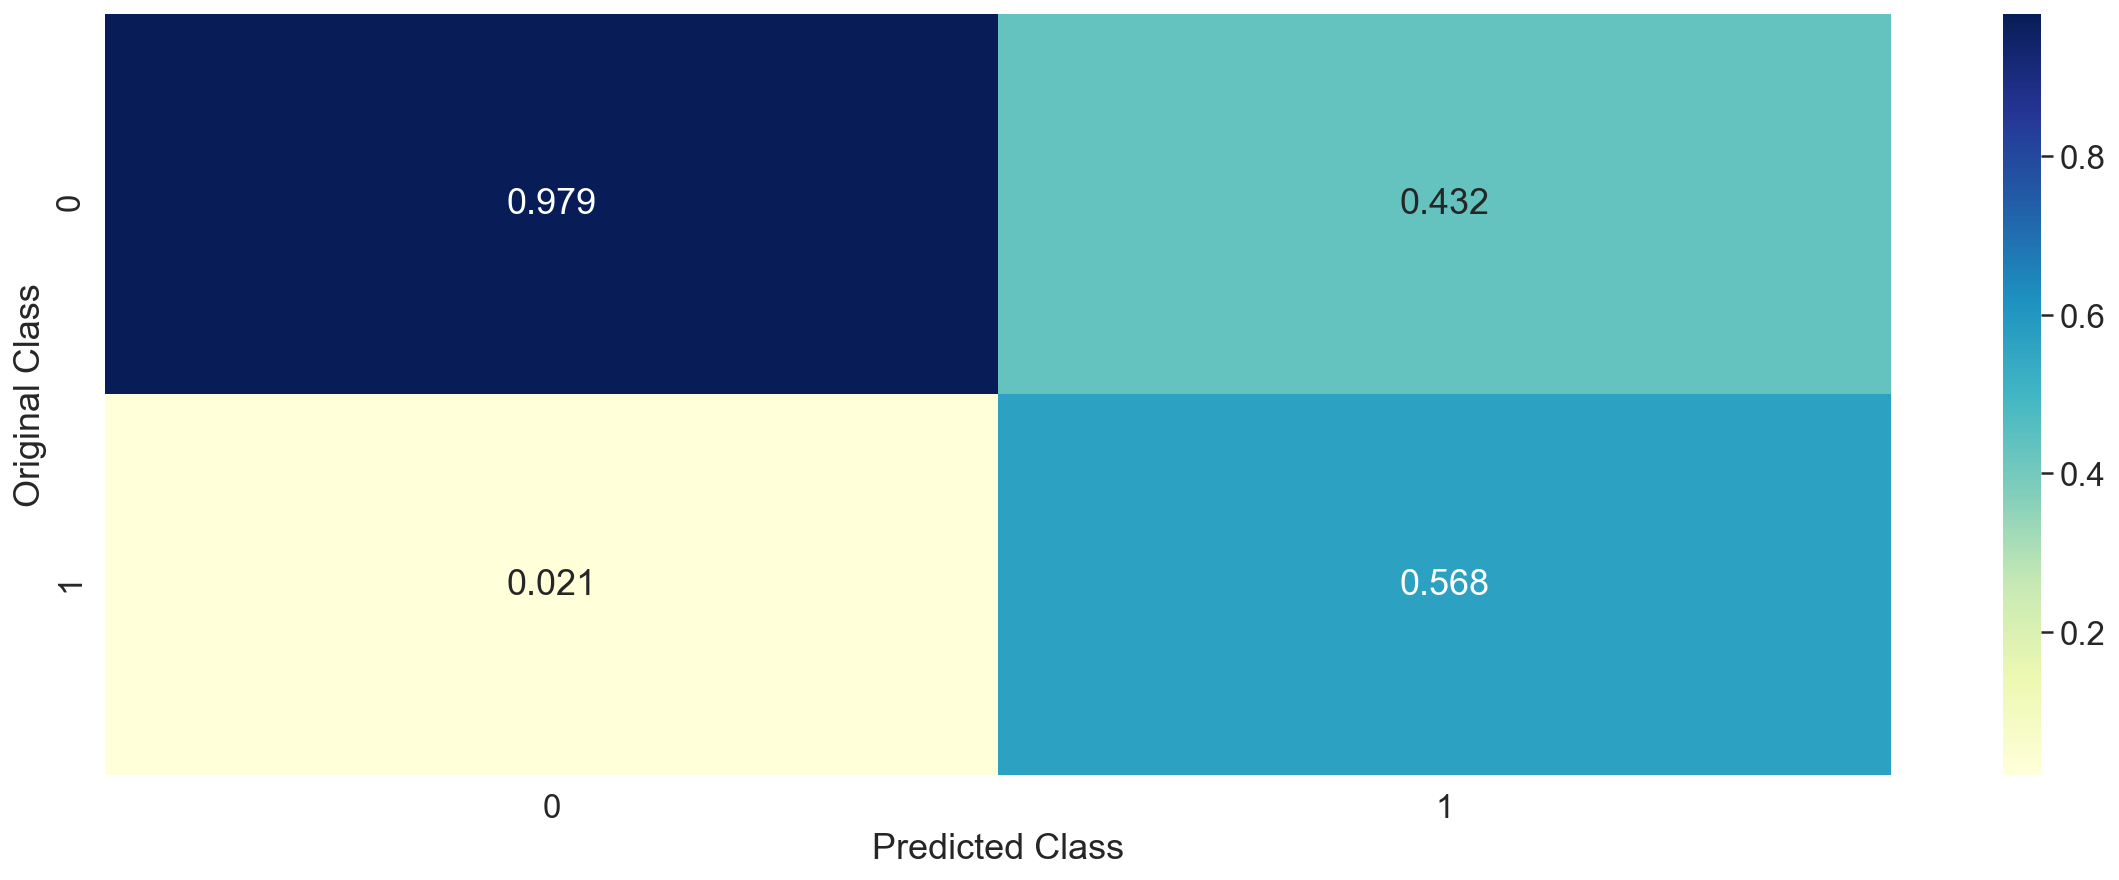

-------------------- Recall matrix (Row sum=1) --------------------


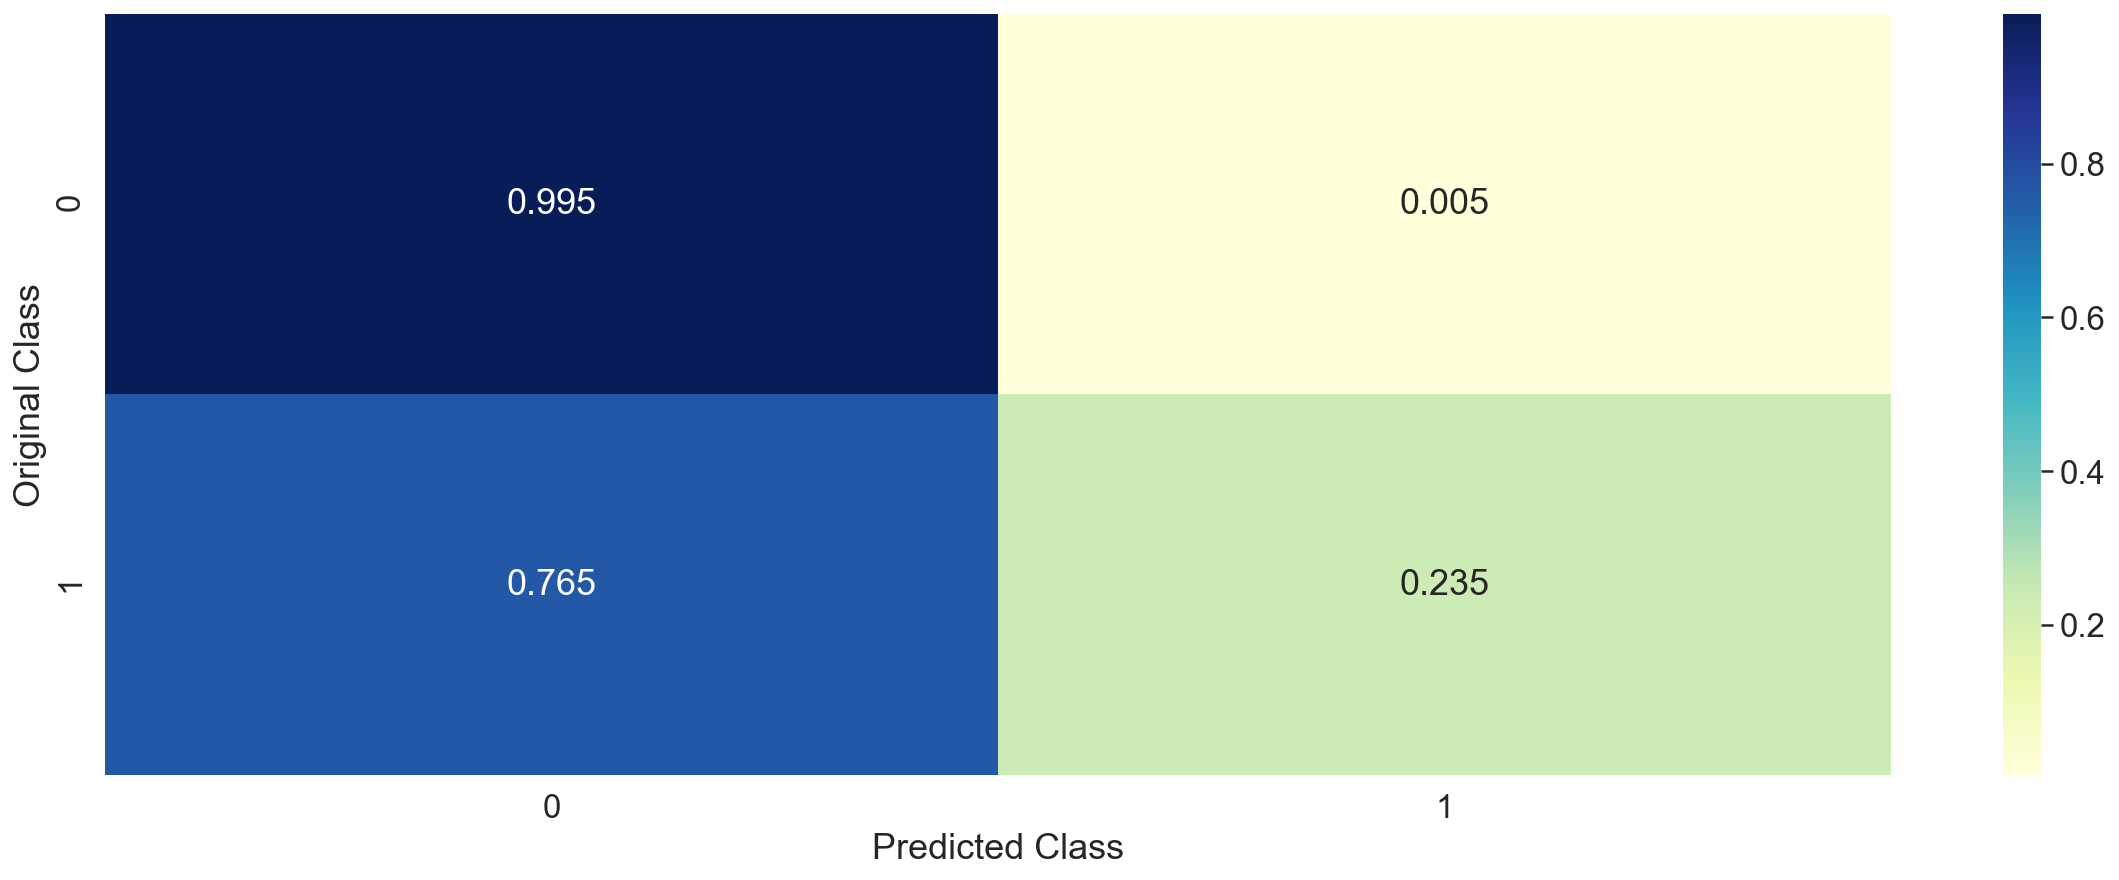

_test__test__test__test__test__test__test__test__test__test_
-------------------- Confusion matrix --------------------


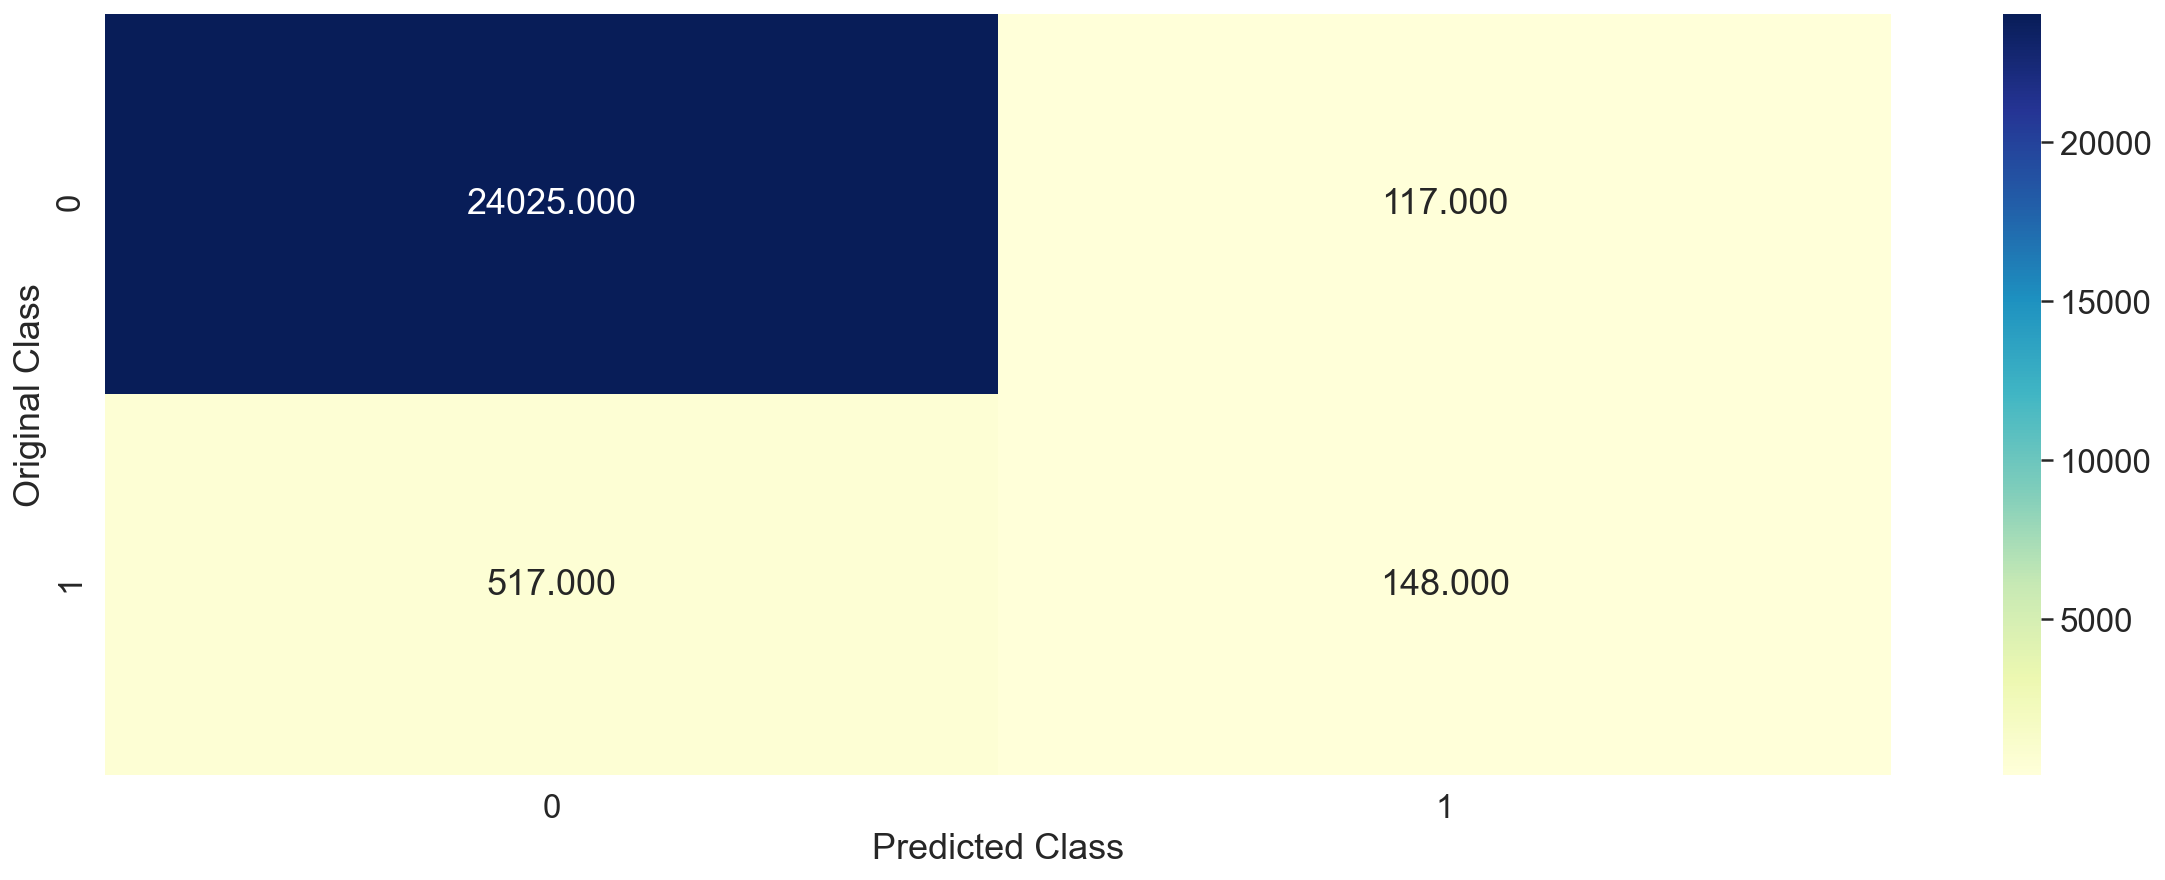

-------------------- Precision matrix (Columm Sum=1) --------------------


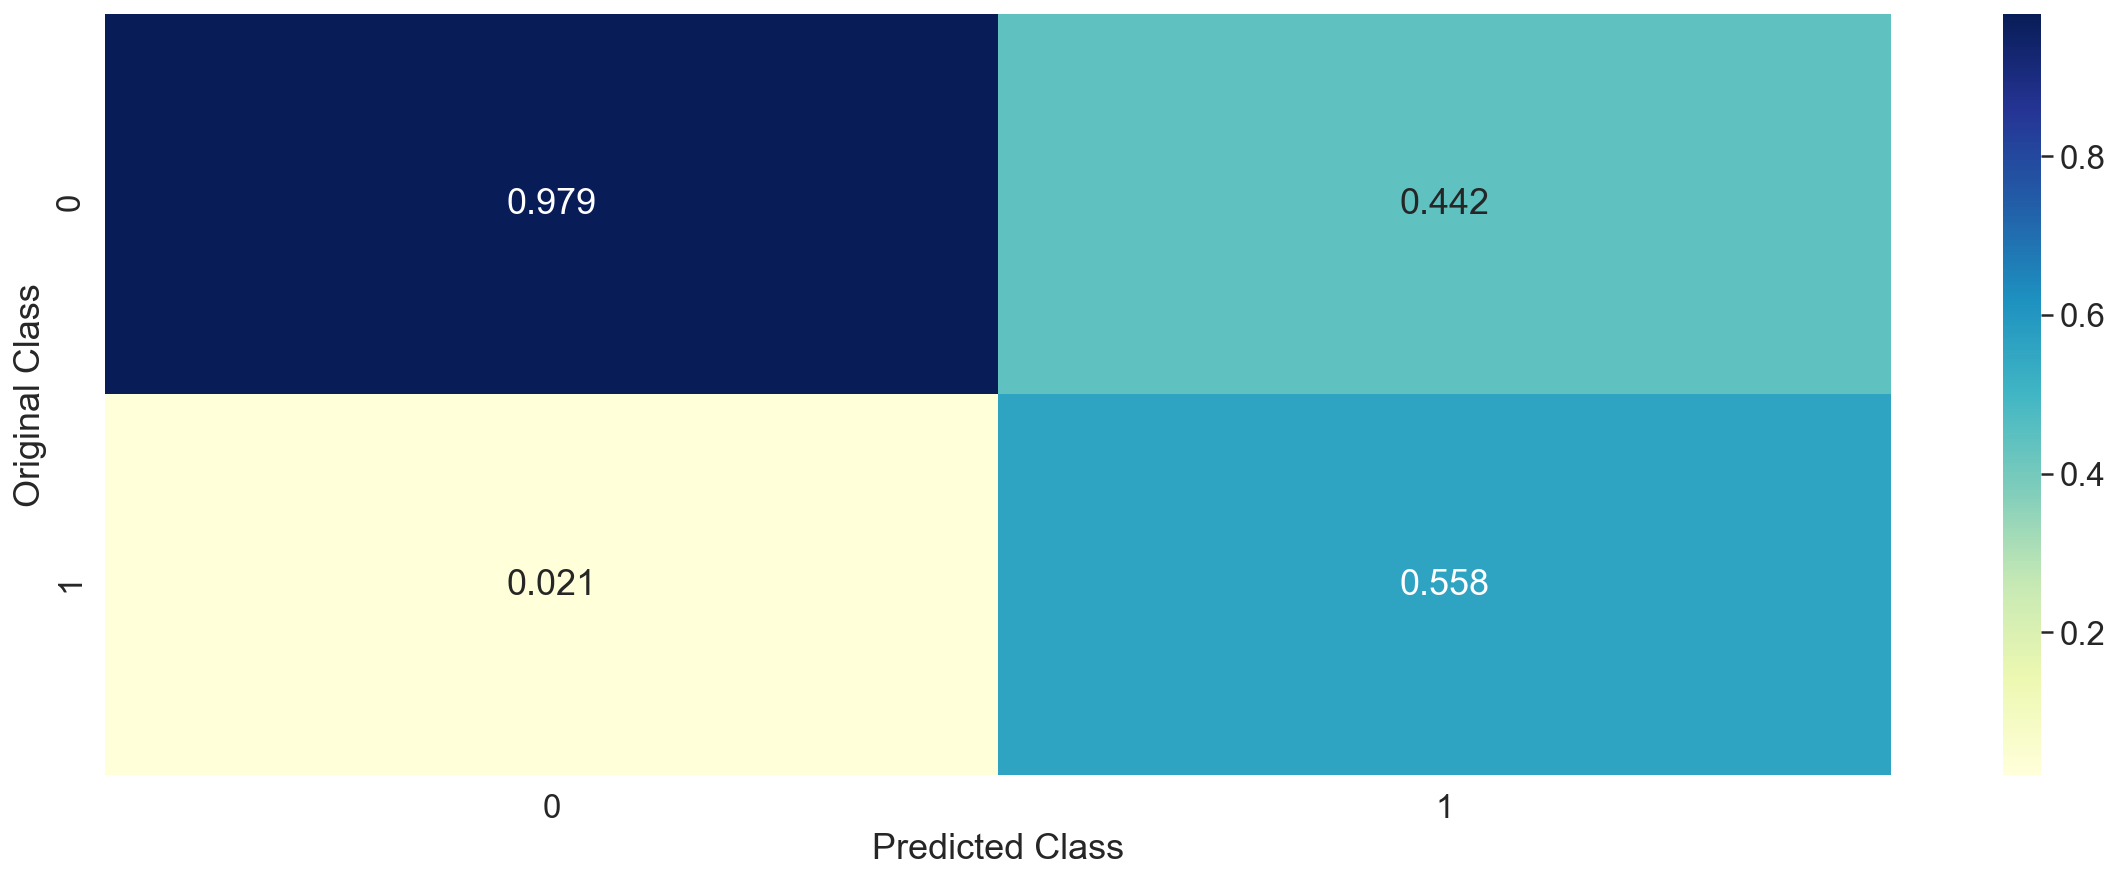

-------------------- Recall matrix (Row sum=1) --------------------


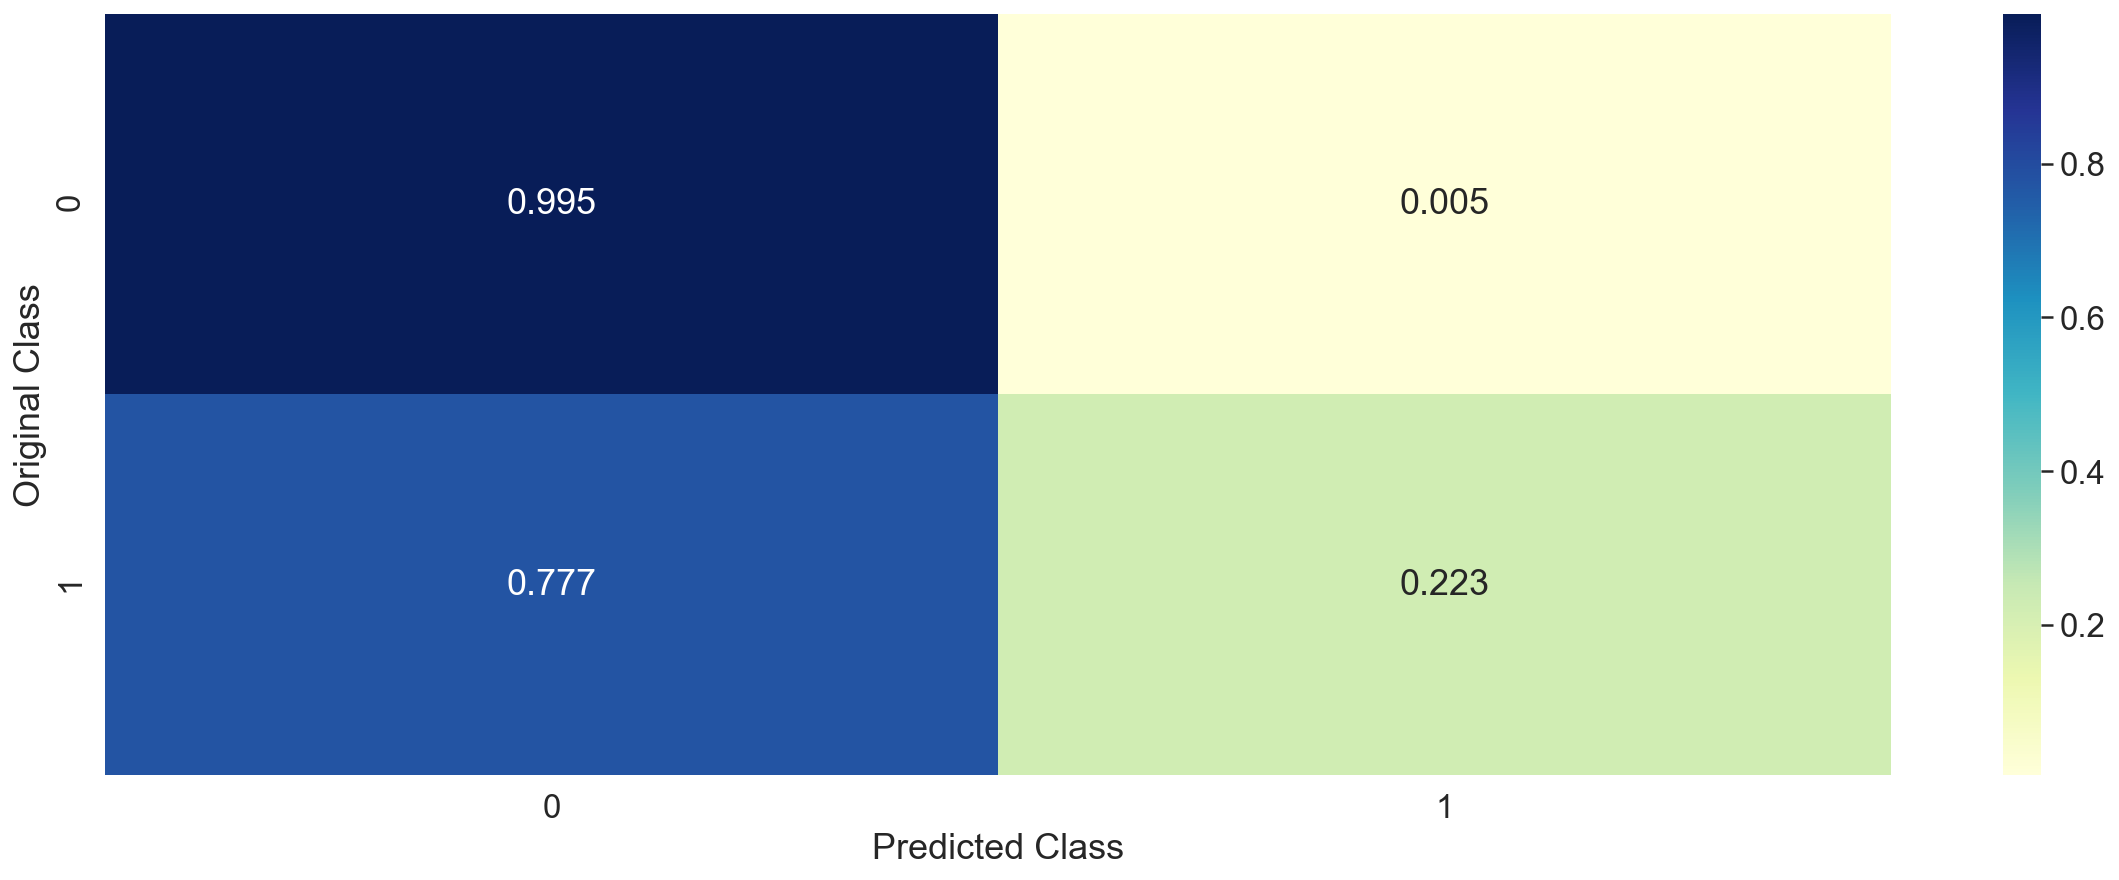

_cv__cv__cv__cv__cv__cv__cv__cv__cv__cv_
-------------------- Confusion matrix --------------------


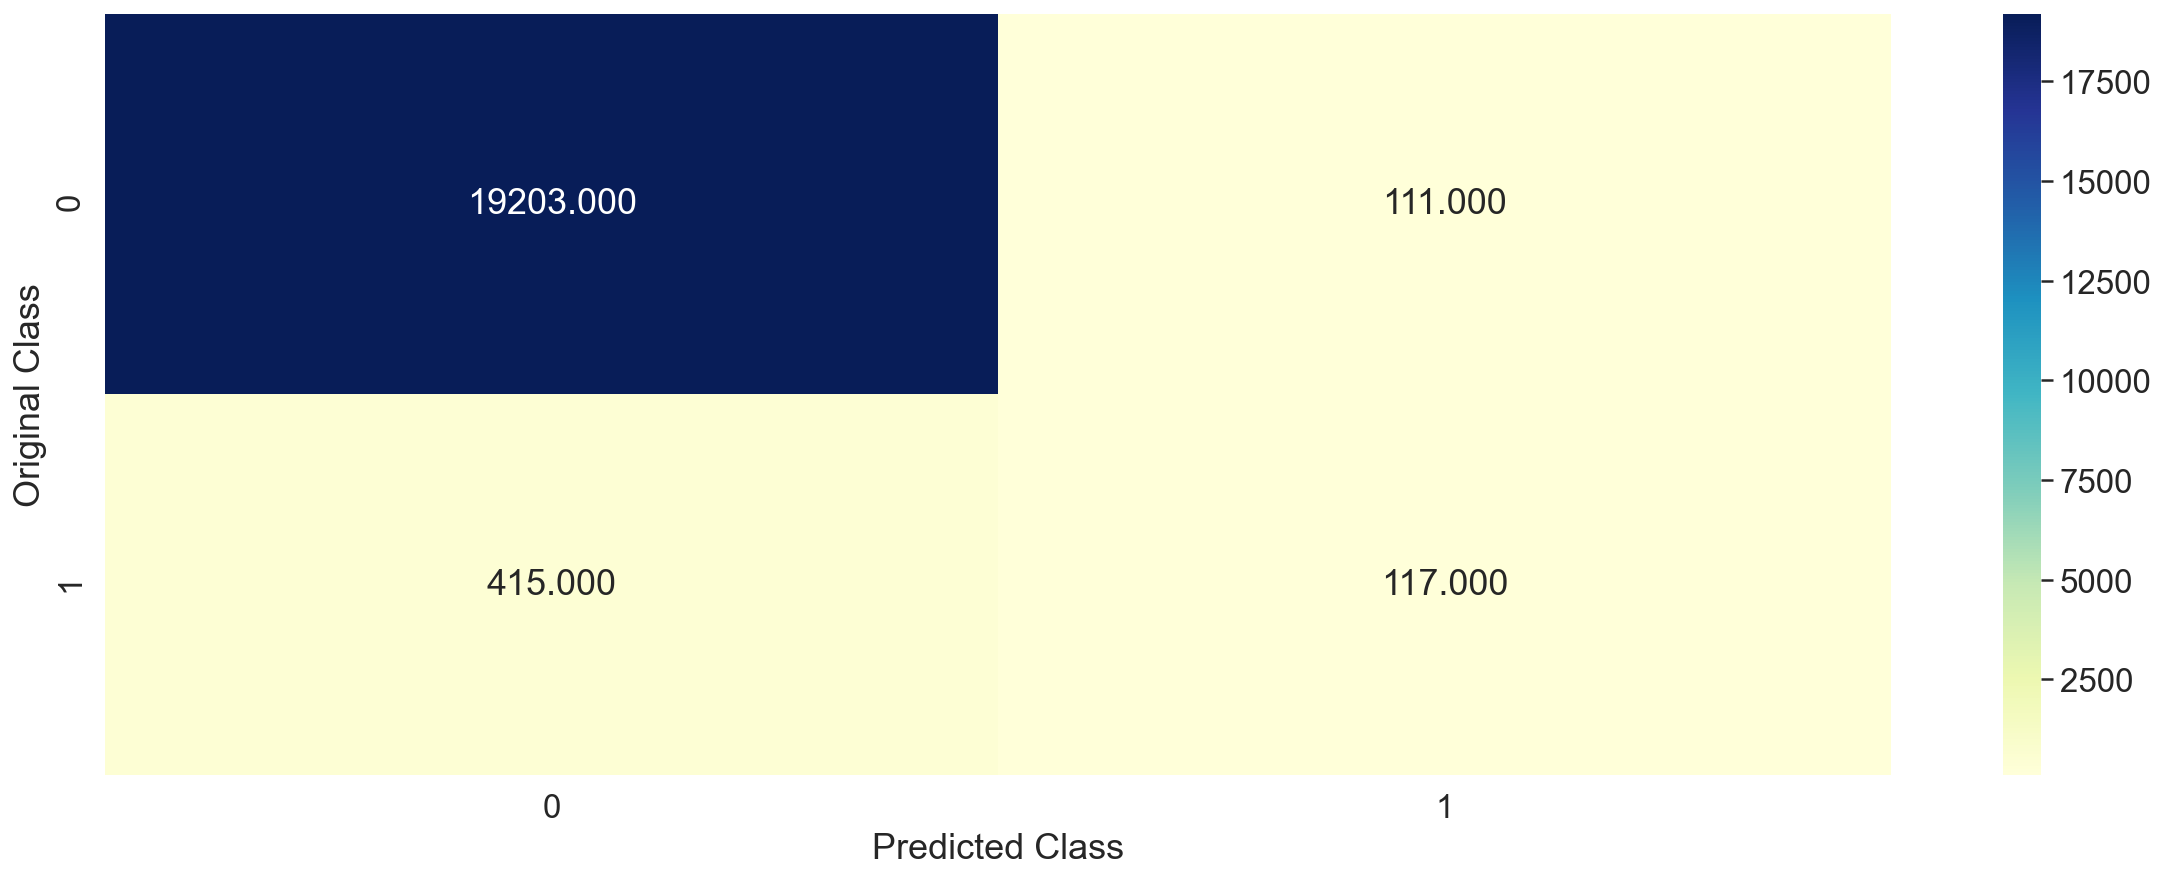

-------------------- Precision matrix (Columm Sum=1) --------------------


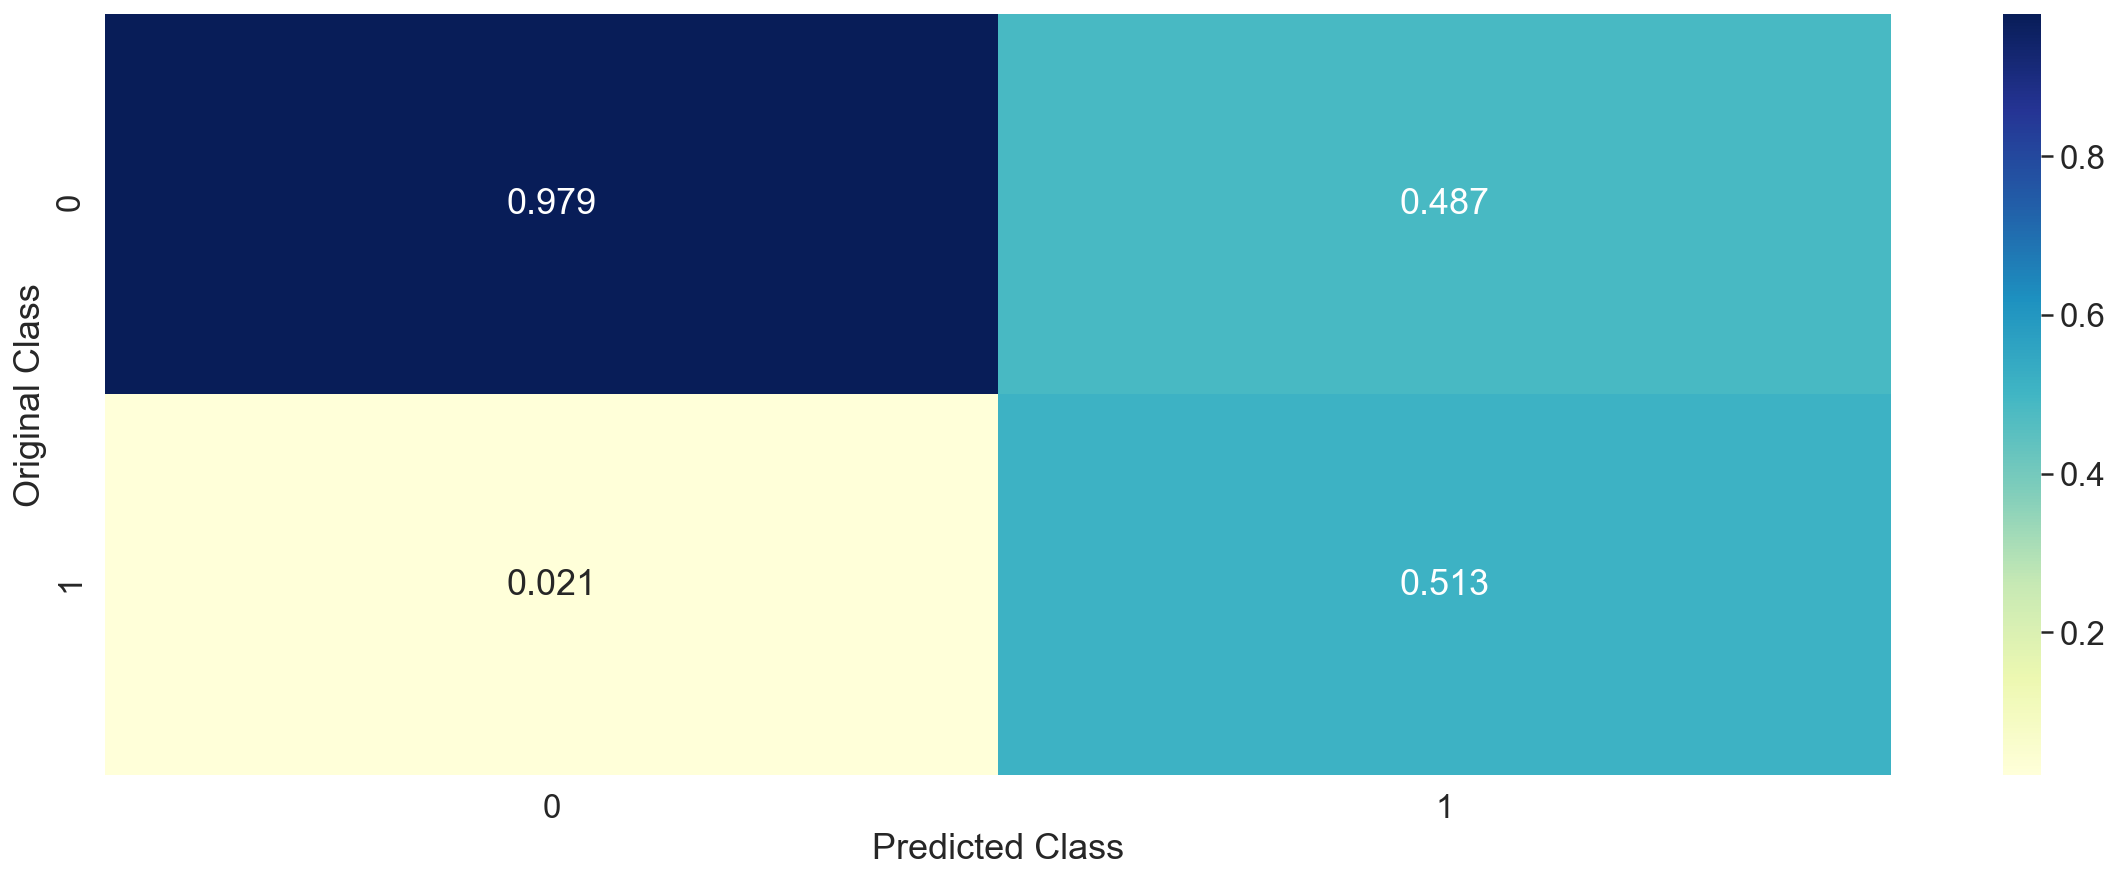

-------------------- Recall matrix (Row sum=1) --------------------


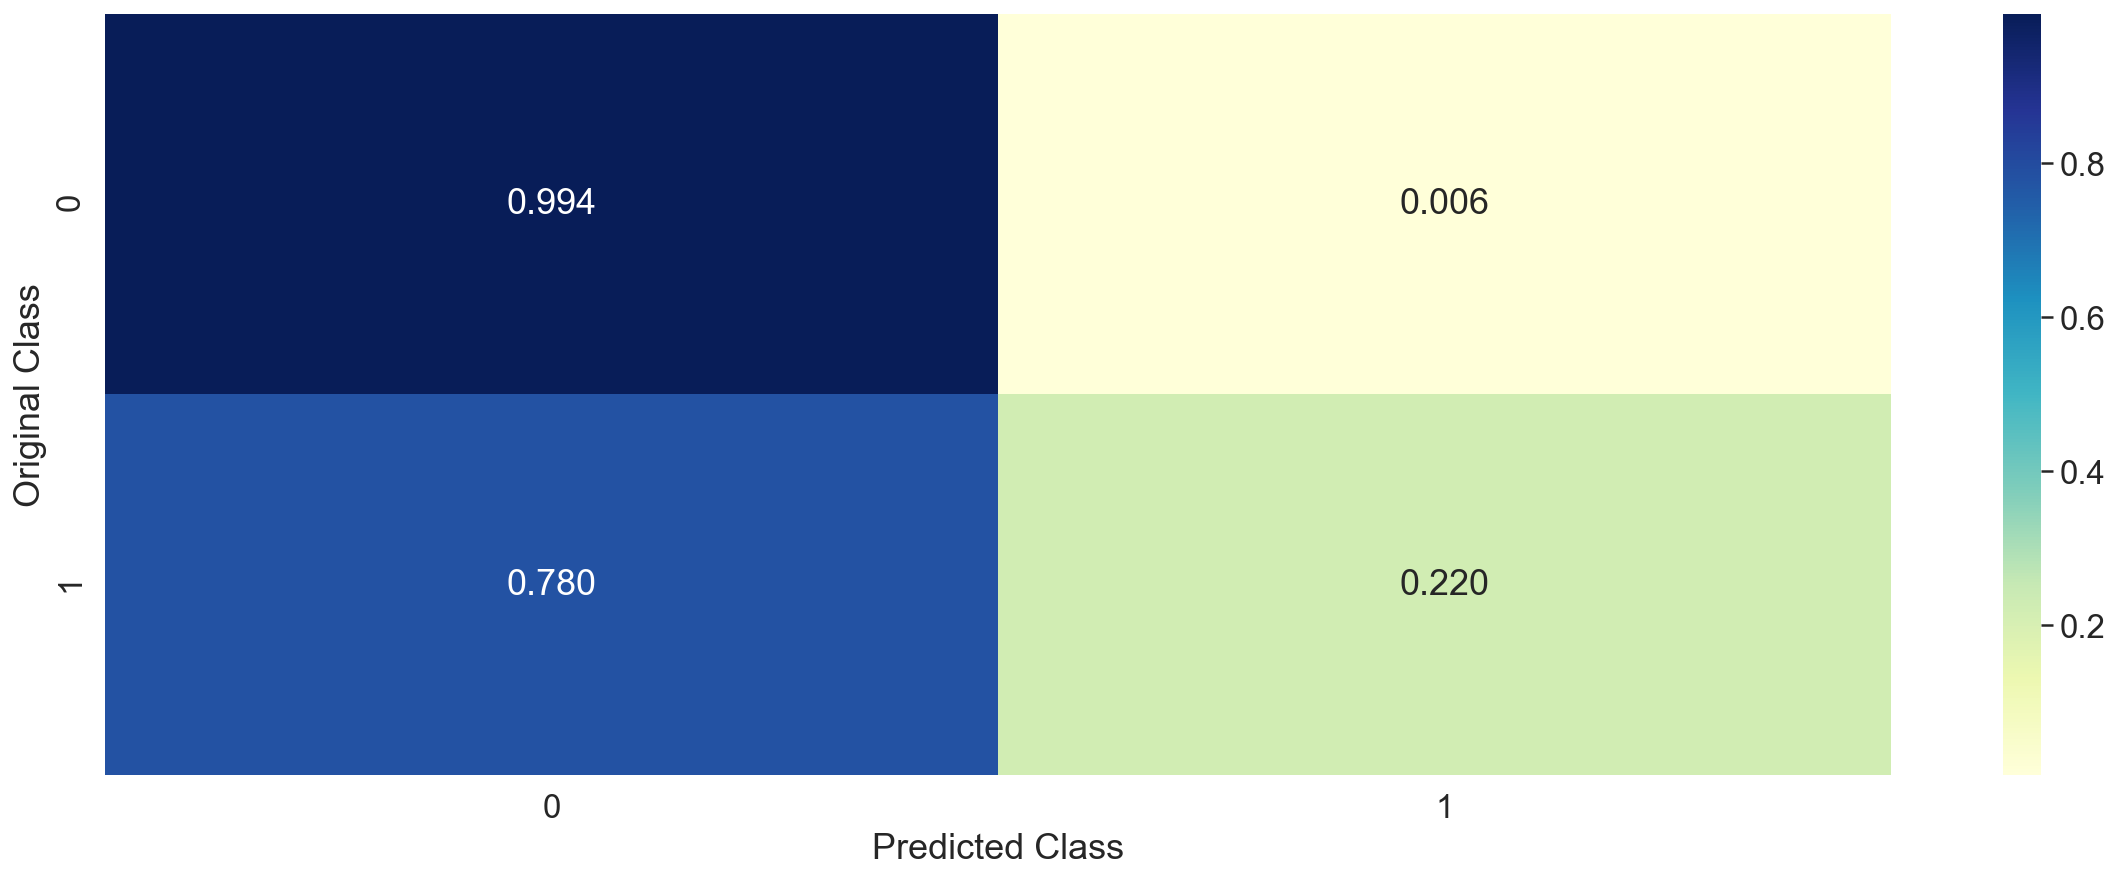

array([[19203,   111],
       [  415,   117]], dtype=int64)

In [236]:
predict_y = model.predict_proba(x_train_hstack)
print("train log loss:", log_loss(y_train, predict_y, labels=model.classes_, eps=1e-15))
predict_y = model.predict_proba(x_test_hstack)
print("test log loss:", log_loss(y_test, predict_y,labels=model.classes_, eps=1e-15))
predict_y = model.predict_proba(x_cv_hstack)
print("cv log loss:", log_loss(y_cv, predict_y,labels=model.classes_, eps=1e-15))


print(" "*100)
print("."*40,"Class Report","."*40)
print(" "*100)
print("-"*20,"Train Data","-"*30)
print( classification_report(y_train, model.predict(x_train_hstack)))
print("-"*20,"Test Data","-"*20)
print( classification_report(y_test, model.predict(x_test_hstack)))
print("-"*20,"CV Data","-"*20)
print( classification_report(y_cv, model.predict(x_cv_hstack)))


print('_train_'*10)
plot_confusion_matrix(y_train, model.predict(x_train_hstack))
confusion_matrix(y_train, model.predict(x_train_hstack))


print('_test_'*10)
plot_confusion_matrix(y_test,  model.predict(x_test_hstack))
confusion_matrix(y_test,  model.predict(x_test_hstack))

print('_cv_'*10)
plot_confusion_matrix(y_cv, model.predict(x_cv_hstack))
confusion_matrix(y_cv, model.predict(x_cv_hstack))



# DecisionTreeClassifier

## DecisionTree - Hyperparameter tunning

In [237]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


In [238]:
parameters = {"min_samples_split":[5, 10, 100, 500,1000],
              "criterion" : ['gini'] ,
             'max_depth':[1, 5, 10, 50]}
#best `depth` in range [1, 5, 10, 50], and the best `min_samples_split` in range [5, 10, 100, 500]

In [239]:
ml = DecisionTreeClassifier(random_state=0)
CV = GridSearchCV(ml, parameters, 
                  return_train_score=True, 
                  cv=10, 
                  scoring='neg_log_loss',
                  error_score='raise',
                  n_jobs=-1,
                  verbose=5)
CV.fit(x_train_hstack, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10, error_score='raise',
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [1, 5, 10, 50],
                         'min_samples_split': [5, 10, 100, 500, 1000]},
             return_train_score=True, scoring='neg_log_loss', verbose=5)

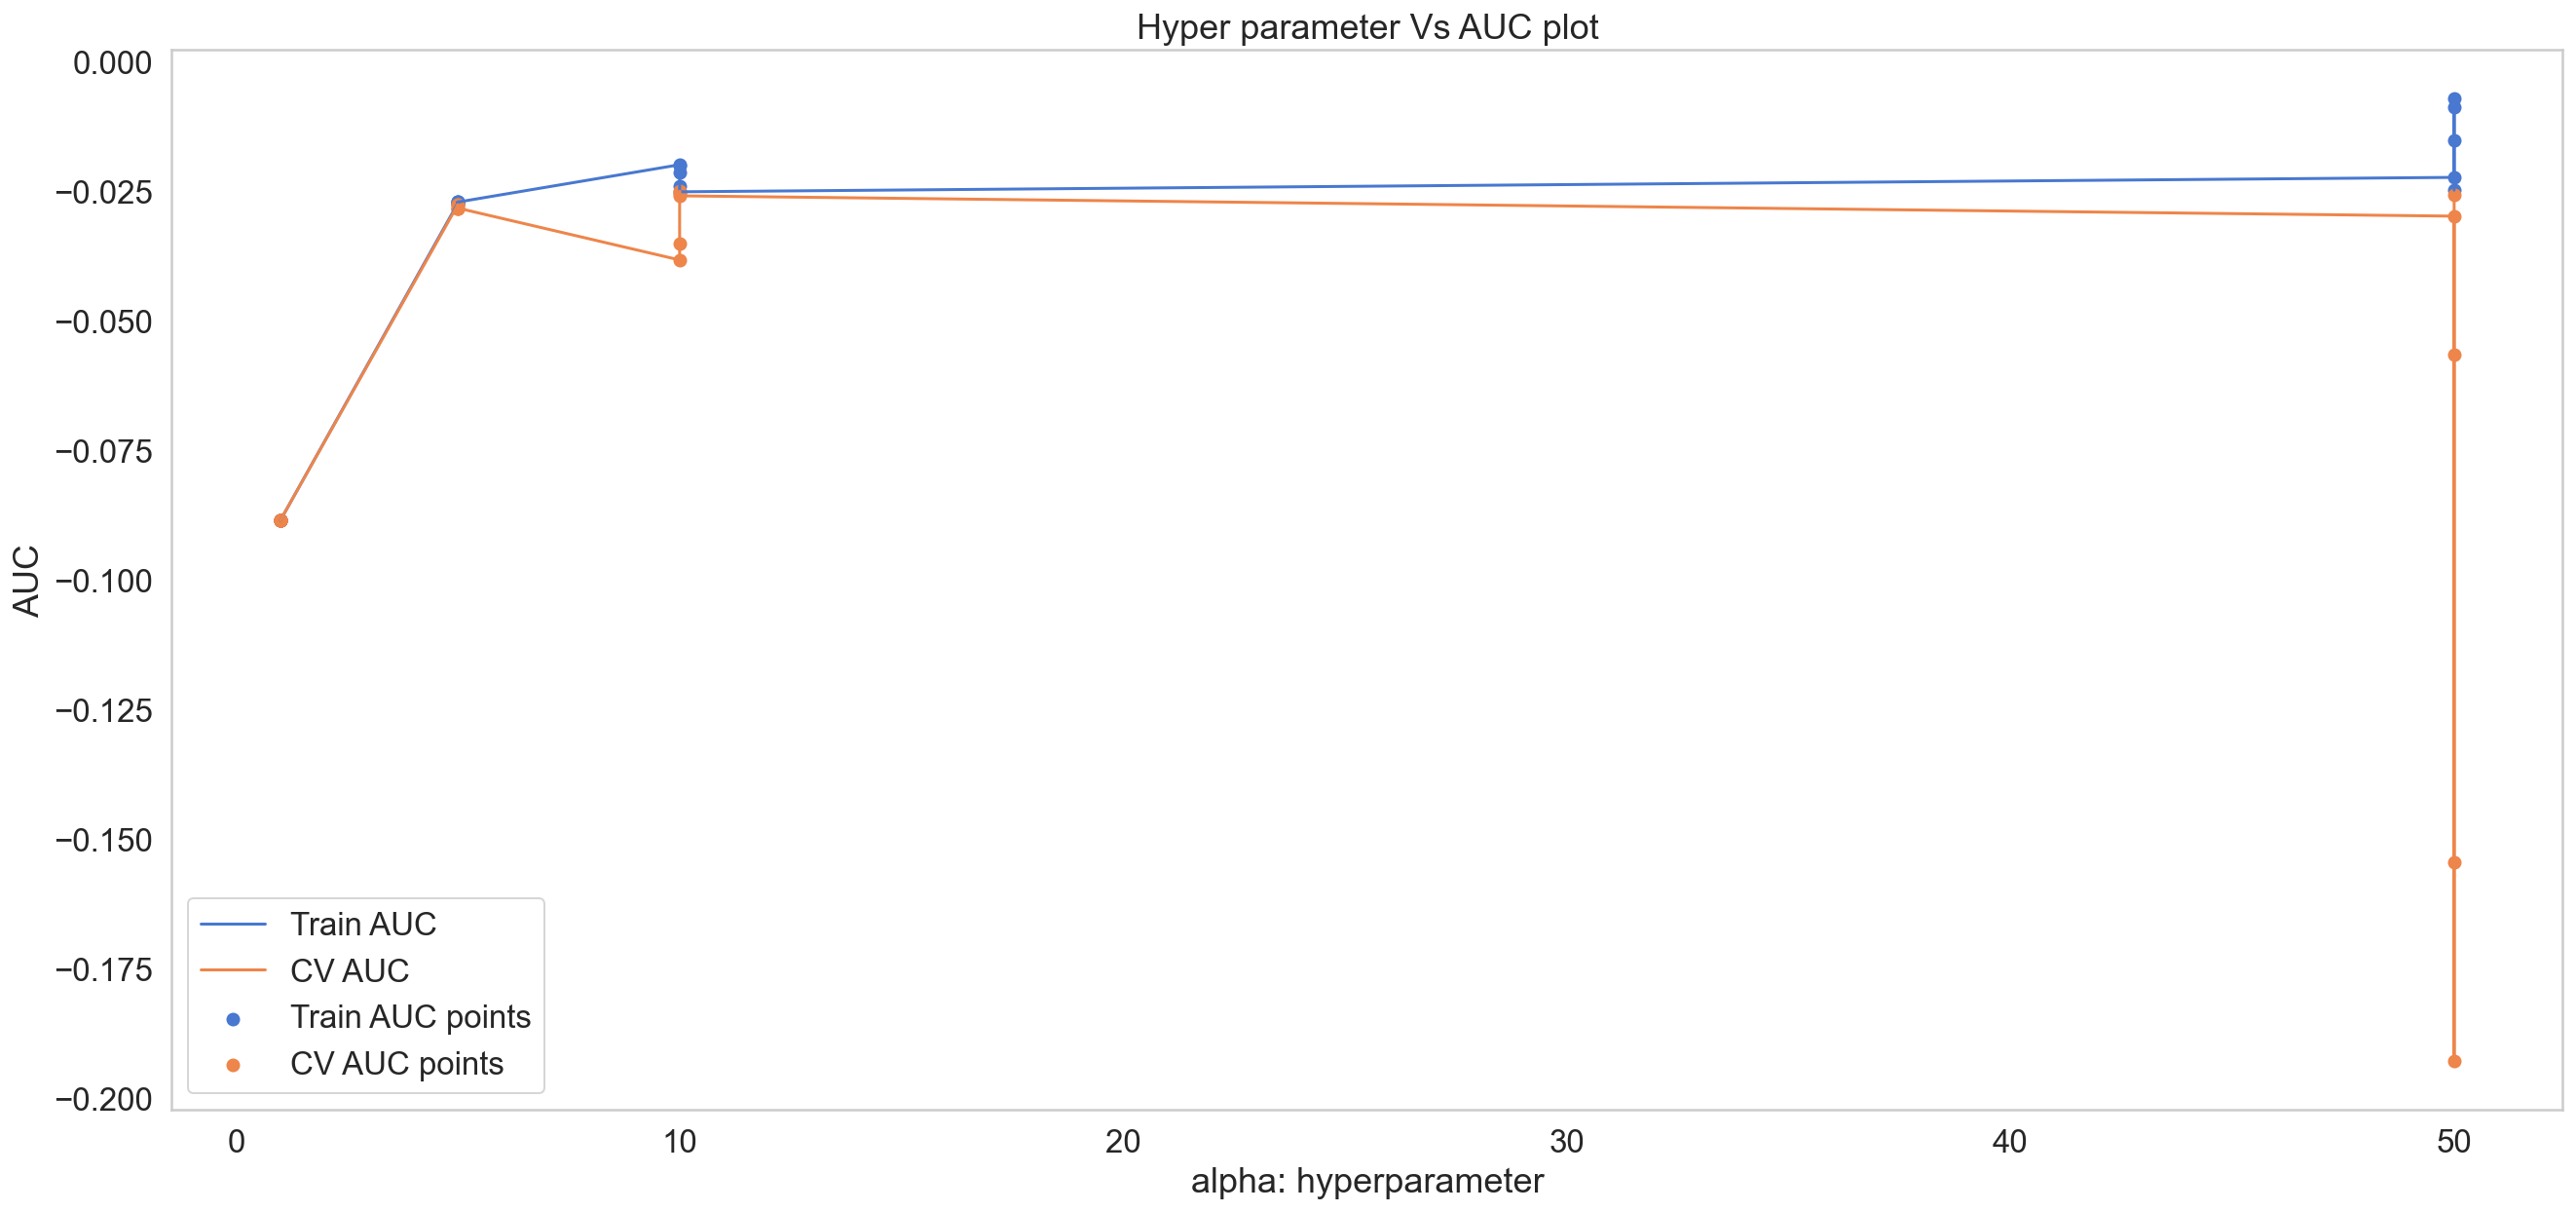

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.264944      0.020870         0.039893        0.003863   
1       0.265546      0.021188         0.040492        0.003894   

  param_criterion param_max_depth param_min_samples_split  \
0            gini               1                       5   
1            gini               1                      10   

                                              params  split0_test_score  \
0  {'criterion': 'gini', 'max_depth': 1, 'min_sam...           -0.08854   
1  {'criterion': 'gini', 'max_depth': 1, 'min_sam...           -0.08854   

   split1_test_score  ...  split2_train_score  split3_train_score  \
0          -0.088039  ...           -0.088509           -0.088593   
1          -0.088039  ...           -0.088509           -0.088593   

   split4_train_score  split5_train_score  split6_train_score  \
0            -0.08858           -0.088511            -0.08857   
1            -0.08858           -0.088511            -0.08857   

   split7_train_score  split8_train_score  split9_train_score  \
0           -0.088575           -0.088547           -0.088487   
1           -0.088575           -0.088547           -0.088487   

   mean_train_score  std_train_score  
0         -0.088554         0.000038  
1         -0.088554         0.000038  

[2 rows x 33 columns]

In [240]:
results = pd.DataFrame.from_dict(CV.cv_results_)
import math
logvalues = []
for i in range(0,results['param_max_depth'].shape[0]):
    logvalues.append(math.log(results['param_max_depth'][i]))

results = pd.DataFrame.from_dict(CV.cv_results_)
results = results.sort_values(['param_max_depth'])
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alpha =  results['param_max_depth']

plt.plot(alpha, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head(2)

In [241]:
CV.best_params_

{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 500}

## DecisionTree - AUC

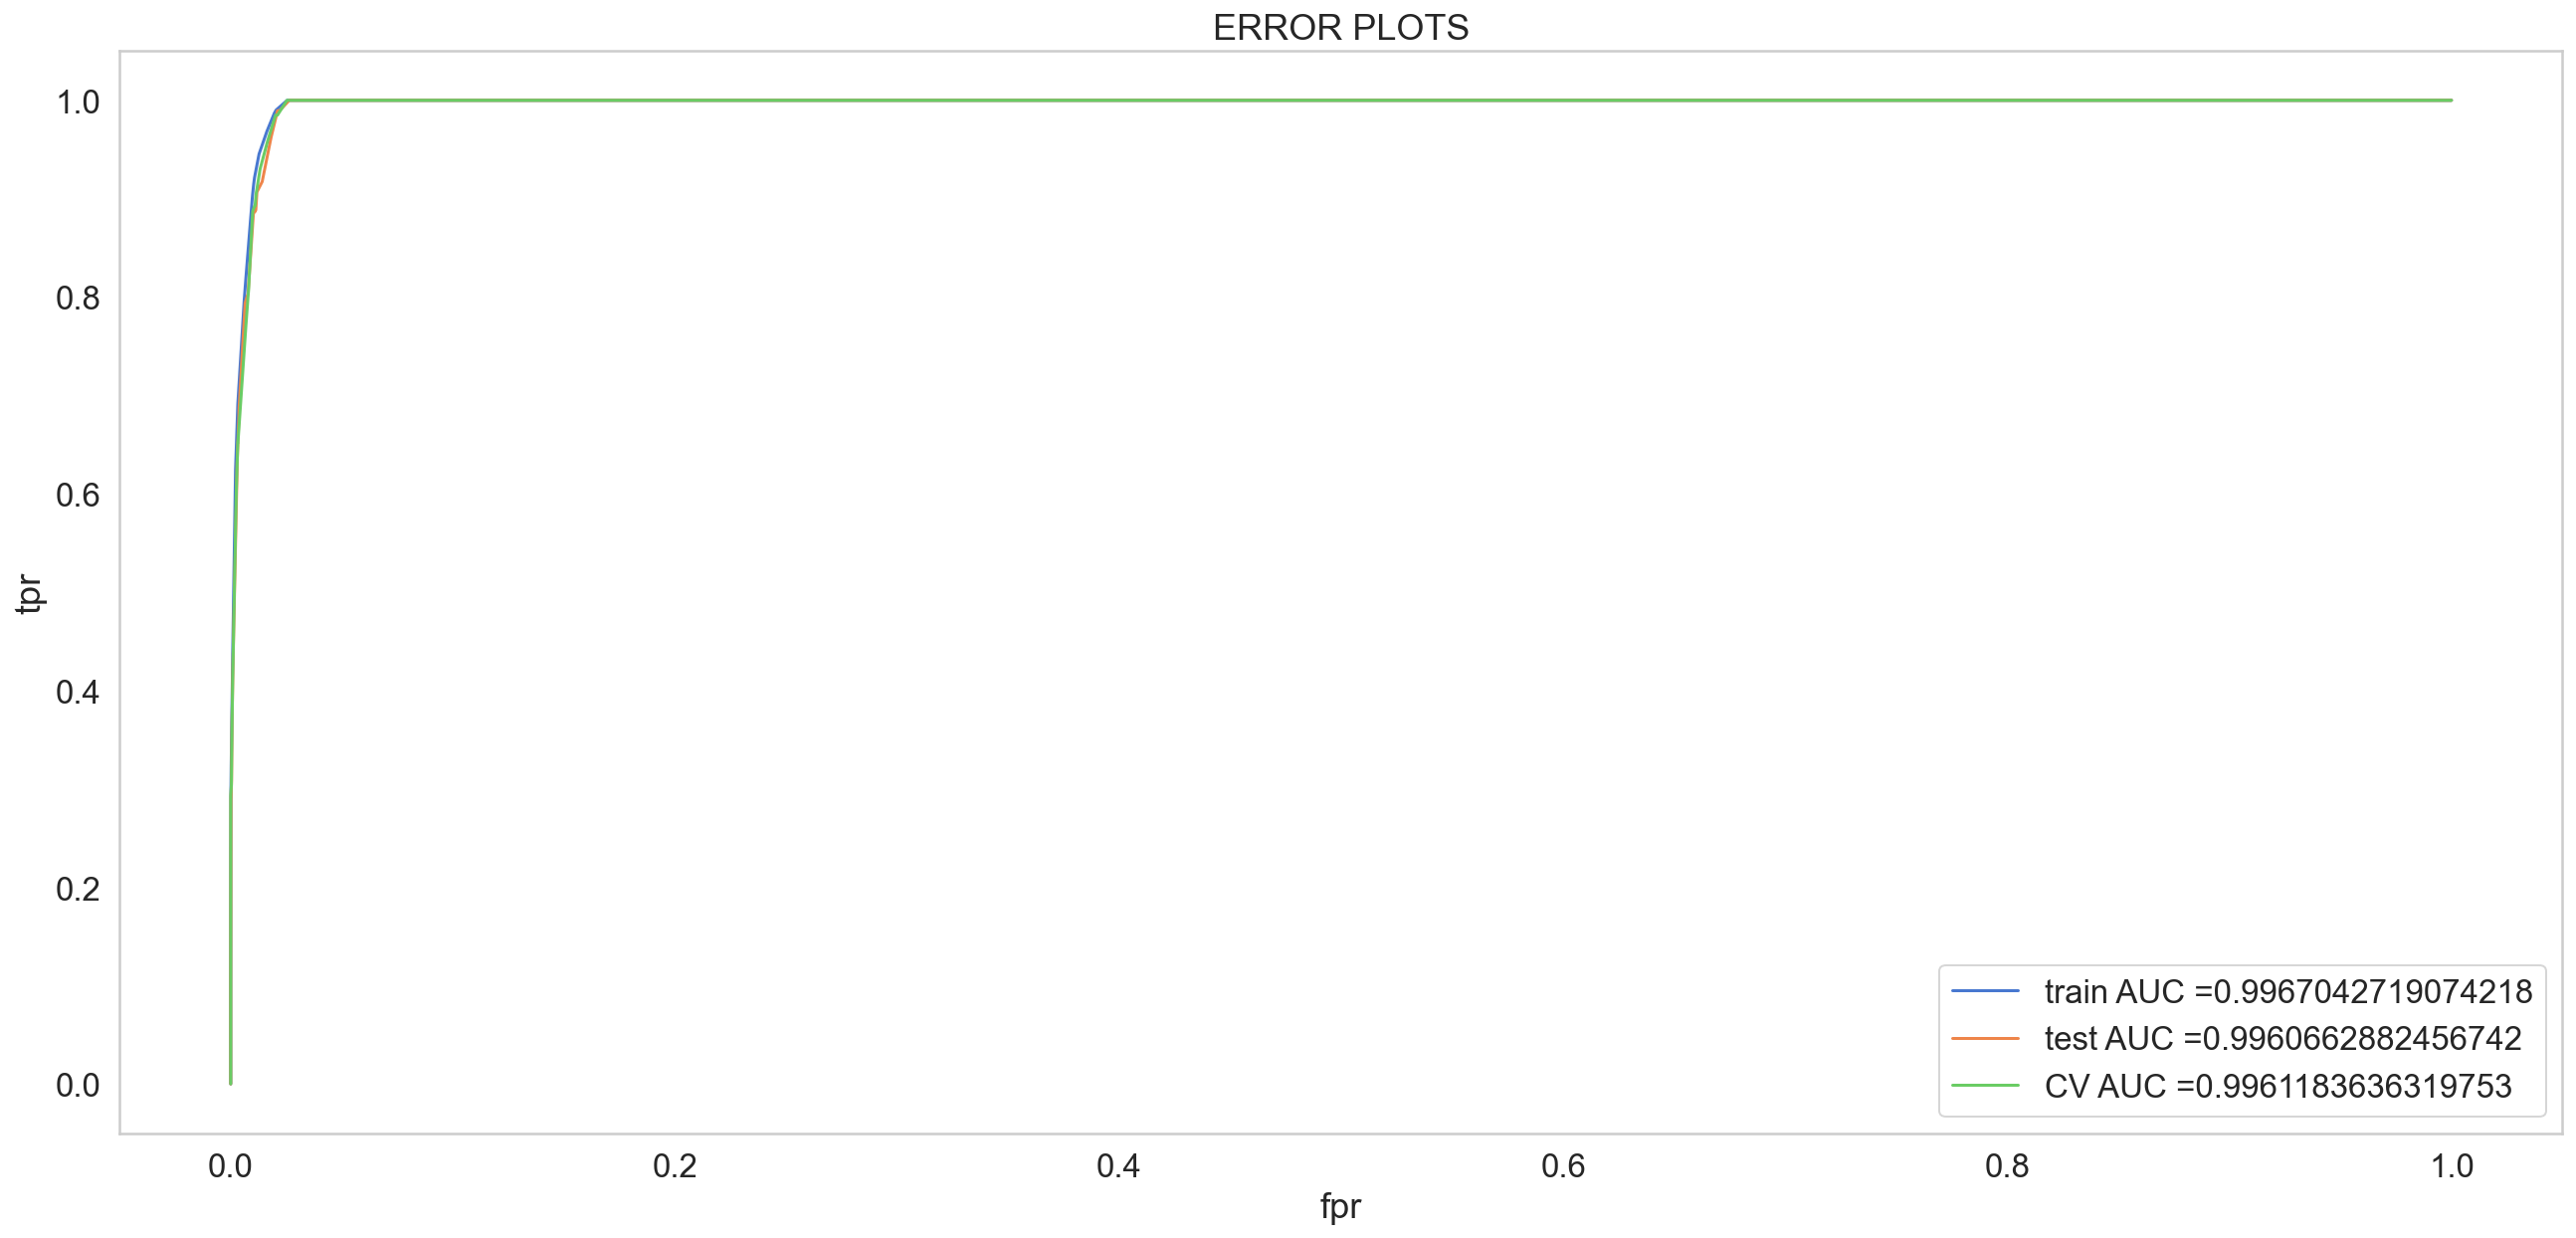

In [243]:
from sklearn.metrics import roc_curve, auc
#model = DecisionTreeClassifier(criterion='gini', max_depth= 233, min_samples_split=22,max_leaf_nodes=611)
model = DecisionTreeClassifier(criterion='gini', max_depth= 50, min_samples_split=500)
model.fit(x_train_hstack, y_train)

y_train_pred = model.predict_proba(x_train_hstack)    
y_test_pred = model.predict_proba(x_test_hstack)
y_cv_pred = model.predict_proba(x_cv_hstack)


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train.astype(int),y_train_pred[:,1] )

test_fpr, test_tpr, te_thresholds = roc_curve(y_test.astype(int),y_test_pred[:,1] )

cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv.astype(int),y_cv_pred[:,1] )



plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))


plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## DecisionTree - Logloss and Classification Report

In [245]:
predict_y = model.predict_proba(x_train_hstack)
print("train log loss:", log_loss(y_train, predict_y, labels=model.classes_, eps=1e-15))
predict_y = model.predict_proba(x_test_hstack)
print("test log loss:", log_loss(y_test, predict_y,labels=model.classes_, eps=1e-15))
predict_y = model.predict_proba(x_cv_hstack)
print("cv log loss:", log_loss(y_cv, predict_y,labels=model.classes_, eps=1e-15))


print(" "*100)
print("."*40,"Class Report","."*40)
print(" "*100)
print("-"*20,"Train Data","-"*30)
print( classification_report(y_train, model.predict(x_train_hstack)))
print("-"*20,"Test Data","-"*20)
print( classification_report(y_test, model.predict(x_test_hstack)))
print("-"*20,"CV Data","-"*20)
print( classification_report(y_cv, model.predict(x_cv_hstack)))

# print('_train_'*10)
# plot_confusion_matrix(y_train, model.predict(x_train_hstack))
# confusion_matrix(y_train, model.predict(x_train_hstack))


# print('_test_'*10)
# plot_confusion_matrix(y_test,  model.predict(x_test_hstack))
# confusion_matrix(y_test,  model.predict(x_test_hstack))

# print('_cv_'*10)
# plot_confusion_matrix(y_cv, model.predict(x_cv_hstack))
# confusion_matrix(y_cv, model.predict(x_cv_hstack))


train log loss: 0.022686763840589586
test log loss: 0.02483579909770299
cv log loss: 0.02427156153678995
                                                                                                    
........................................ Class Report ........................................
                                                                                                    
-------------------- Train Data ------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     77256
           1       0.78      0.80      0.79      2126

    accuracy                           0.99     79382
   macro avg       0.89      0.90      0.89     79382
weighted avg       0.99      0.99      0.99     79382

-------------------- Test Data --------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     24142
           1       0.77      0.79      0.78    

# RandomForestClassifier

## RandomForest - Hyperparameter Tunning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

In [246]:
parameters = {"n_estimators":[10, 50, 100, 150, 200, 300, 500, 1000],
              'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10]}
ml = RandomForestClassifier(criterion='gini', random_state=0, n_jobs=-1)
CV = RandomizedSearchCV(ml, parameters, 
                  return_train_score=True, 
                  cv=10, 
                  scoring='roc_auc_ovr_weighted',
                  error_score='raise',
                  n_jobs=-1,
                  verbose=5)
CV.fit(x_train_hstack, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, error_score='raise',
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'n_estimators': [10, 50, 100, 150, 200,
                                                         300, 500, 1000]},
                   return_train_score=True, scoring='roc_auc_ovr_weighted',
                   verbose=5)

In [247]:
CV.best_params_

{'n_estimators': 150, 'max_depth': 9}

## RandomForest - AUC

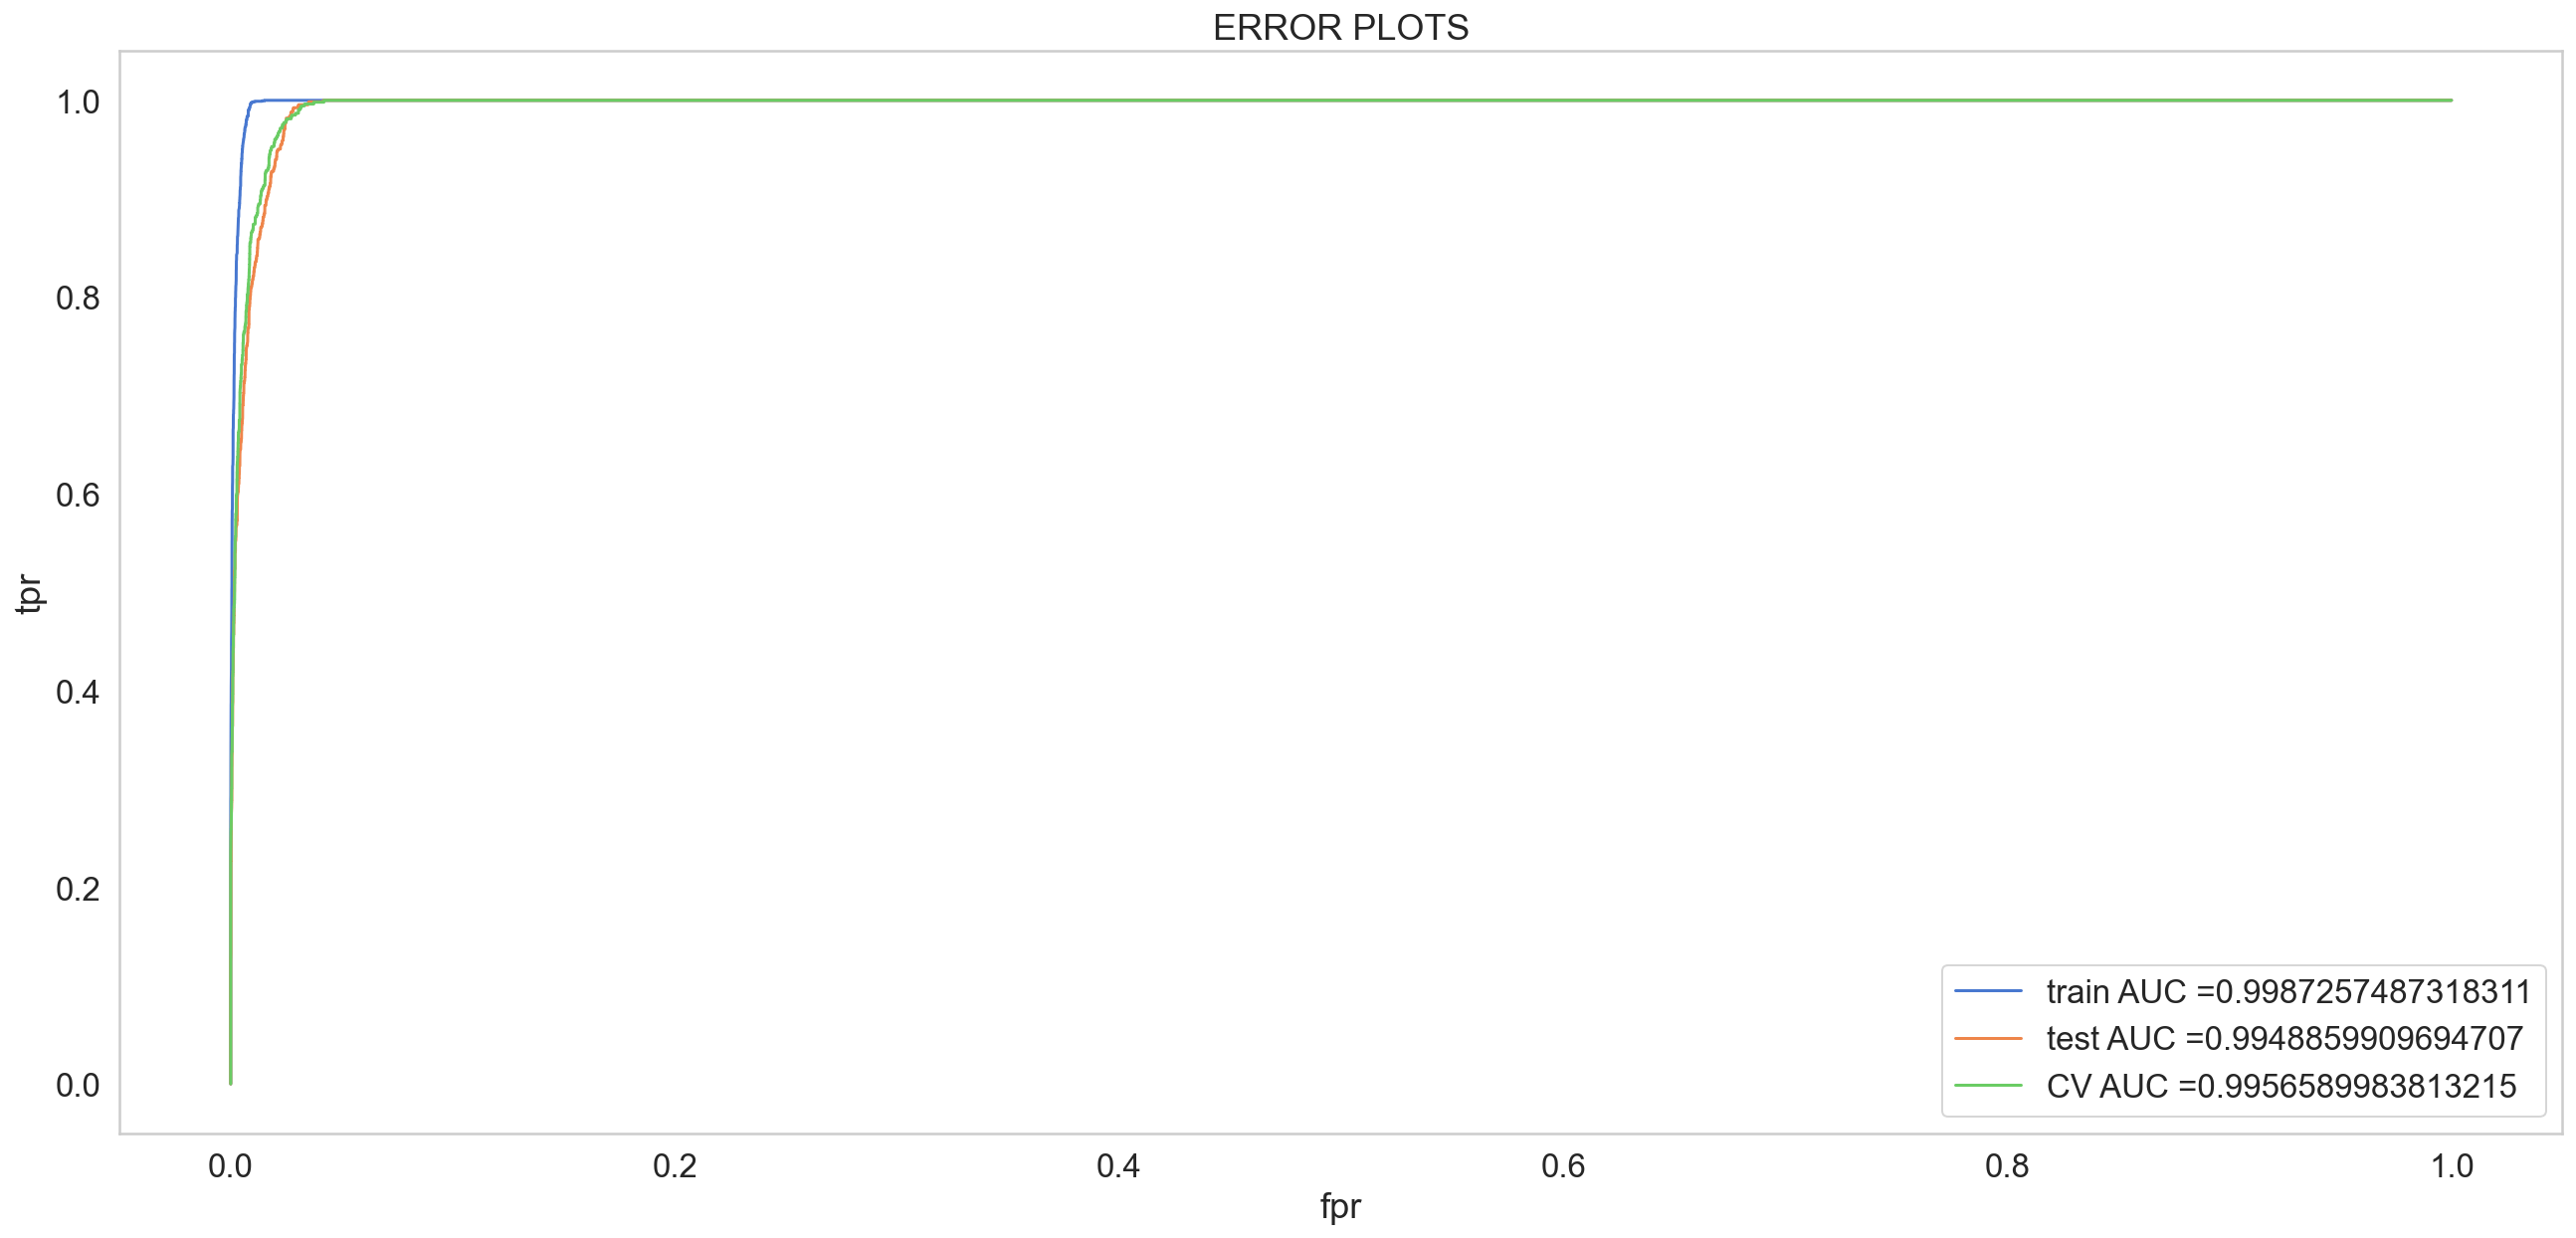

In [249]:
from sklearn.metrics import roc_curve, auc
model = RandomForestClassifier(criterion = 'gini',
                          max_depth=32,
                          class_weight='balanced_subsample',
                          n_estimators=1883,
                          random_state=0, 
                          n_jobs=-1)
model.fit(x_train_hstack, y_train)

y_train_pred = model.predict_proba(x_train_hstack)    
y_test_pred = model.predict_proba(x_test_hstack)
y_cv_pred = model.predict_proba(x_cv_hstack)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train.astype('int'),y_train_pred[:,1] )

test_fpr, test_tpr, te_thresholds = roc_curve(y_test.astype('int'),y_test_pred[:,1] )

cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv.astype('int'),y_cv_pred[:,1] )


plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))


plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Random Forest - Logloss and Classification Report

train log loss: 0.09426139644438865
test log loss: 0.10131902773922664
cv log loss: 0.10115649463232664
                                                                                                    
........................................ Class Report ........................................
                                                                                                    
-------------------- Train Data ------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     77256
           1       0.60      1.00      0.75      2126

    accuracy                           0.98     79382
   macro avg       0.80      0.99      0.87     79382
weighted avg       0.99      0.98      0.98     79382

-------------------- Test Data --------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     24142
           1       0.55      0.95      0.70     

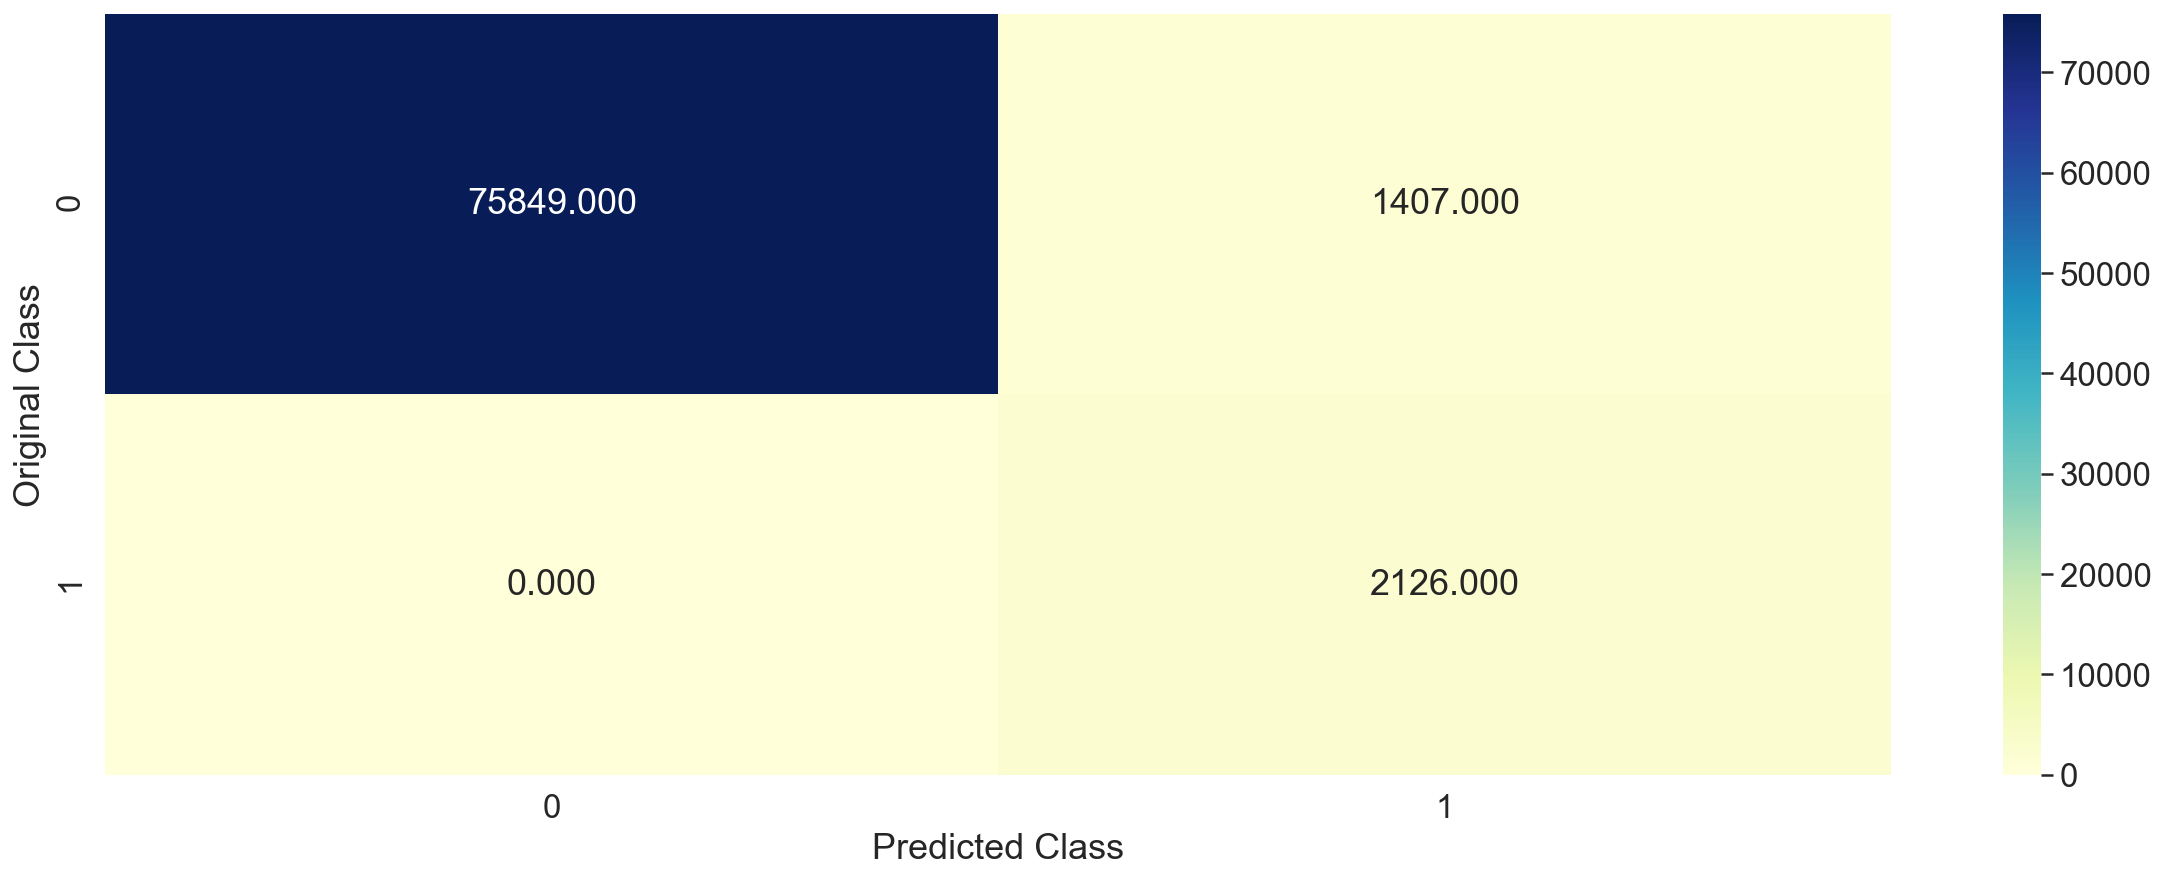

-------------------- Precision matrix (Columm Sum=1) --------------------


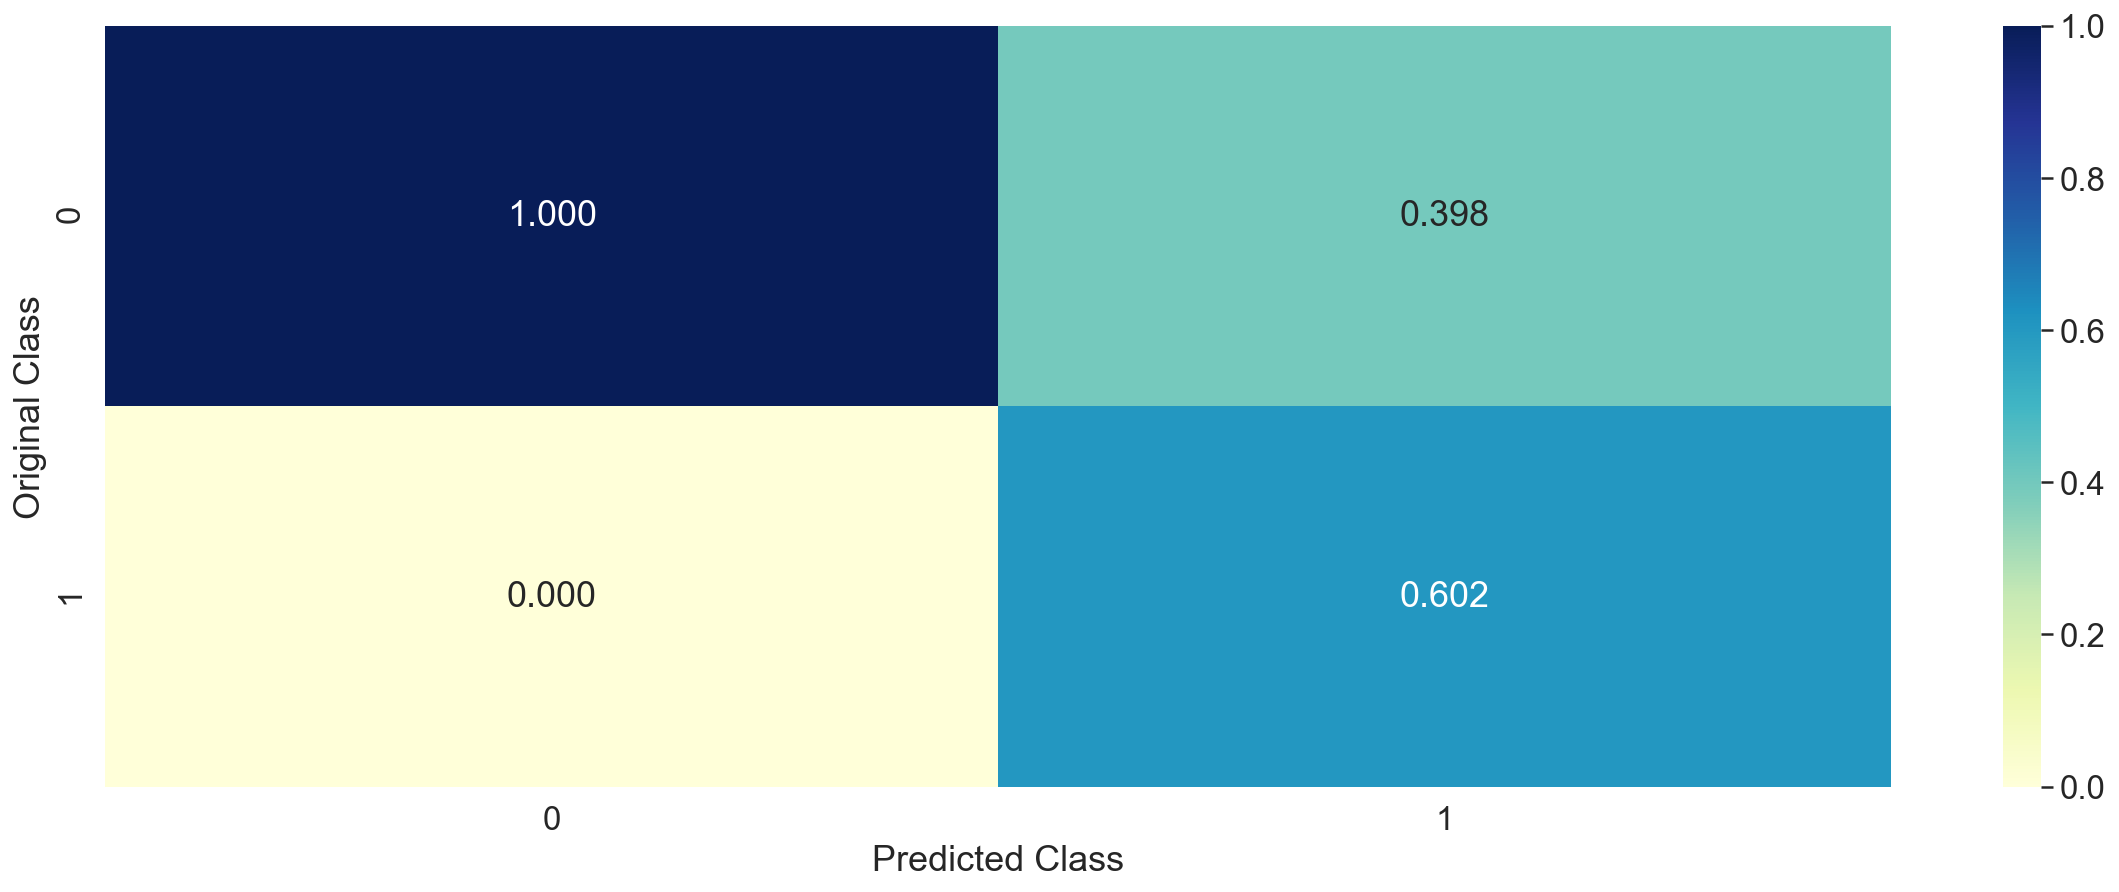

-------------------- Recall matrix (Row sum=1) --------------------


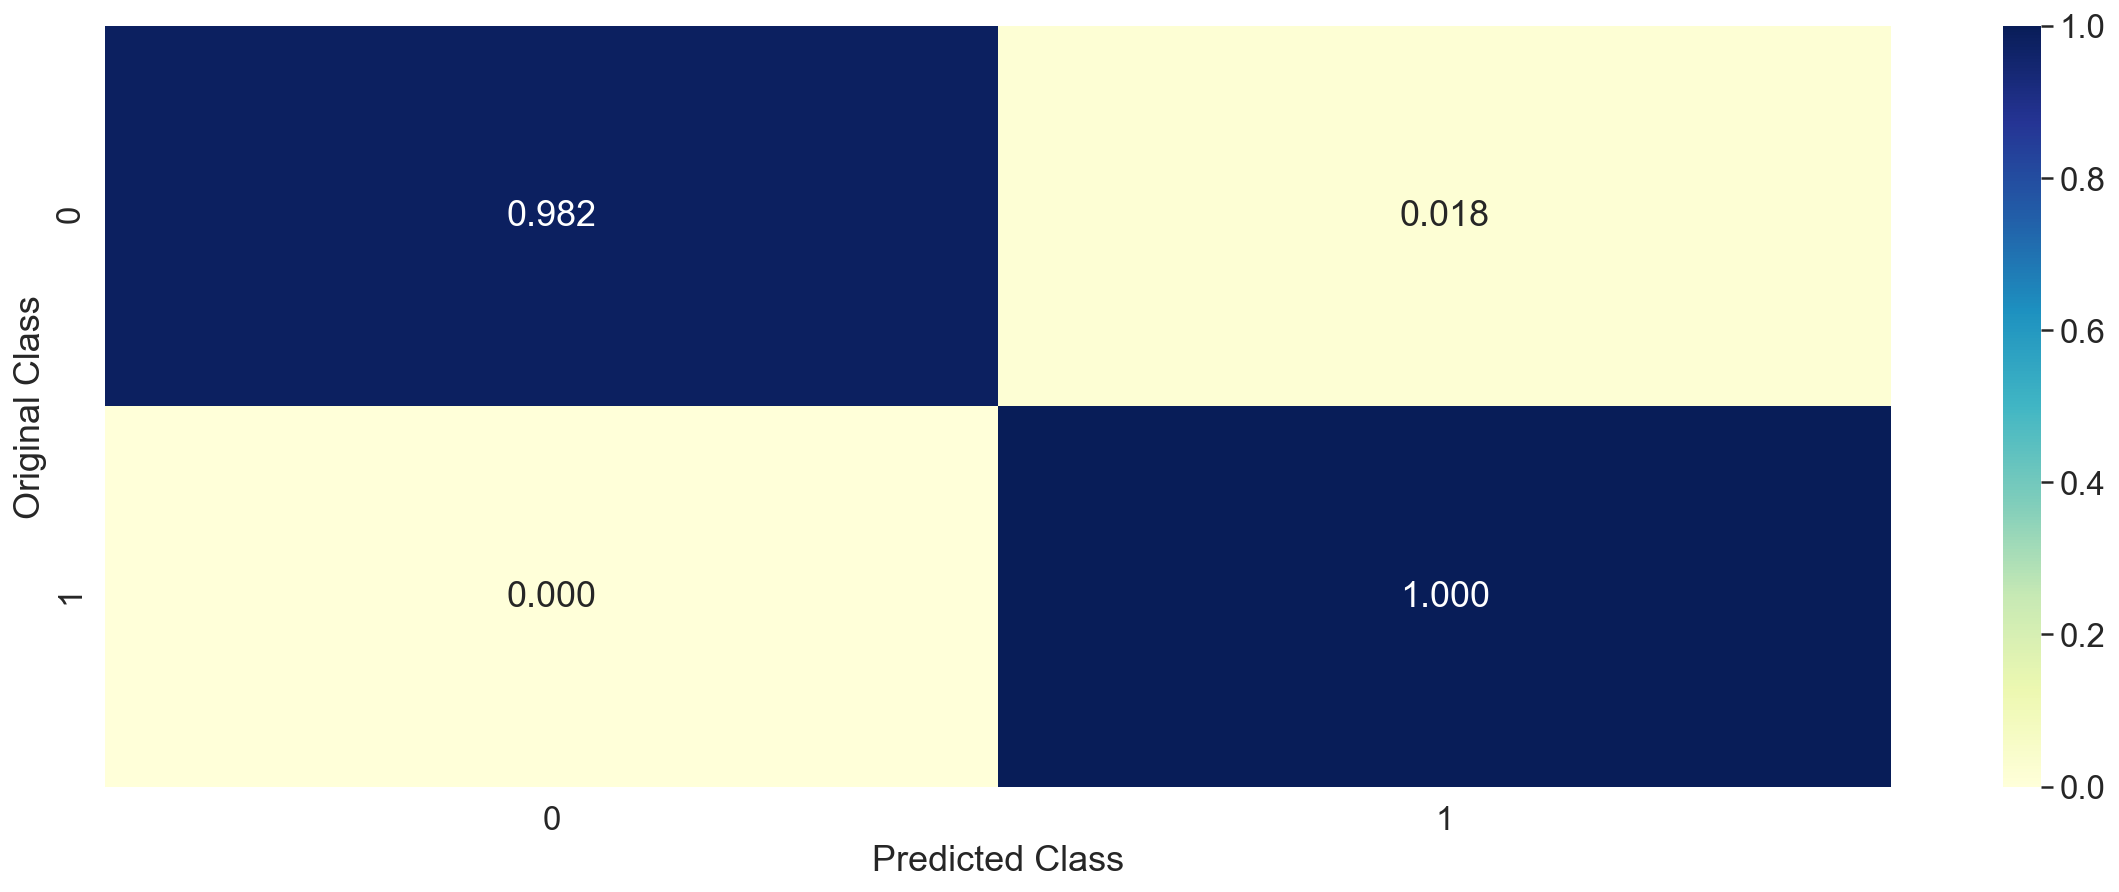

_test__test__test__test__test__test__test__test__test__test_
-------------------- Confusion matrix --------------------


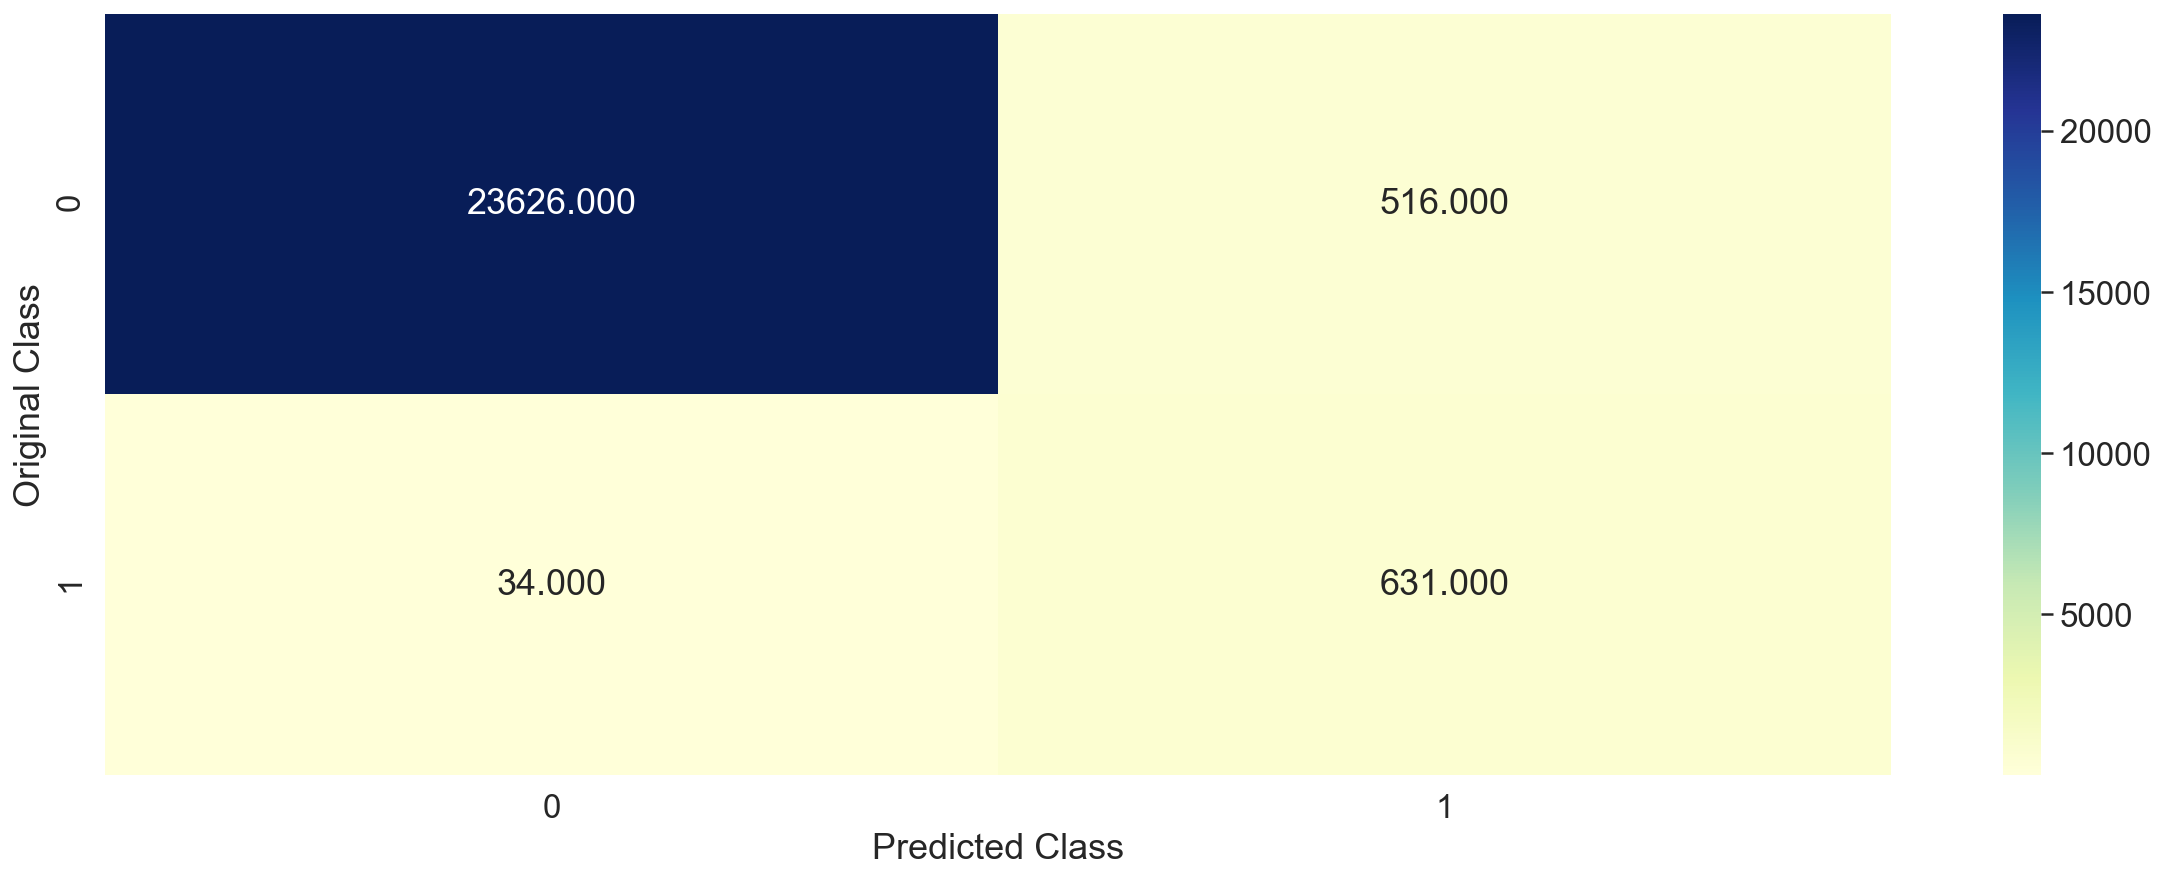

-------------------- Precision matrix (Columm Sum=1) --------------------


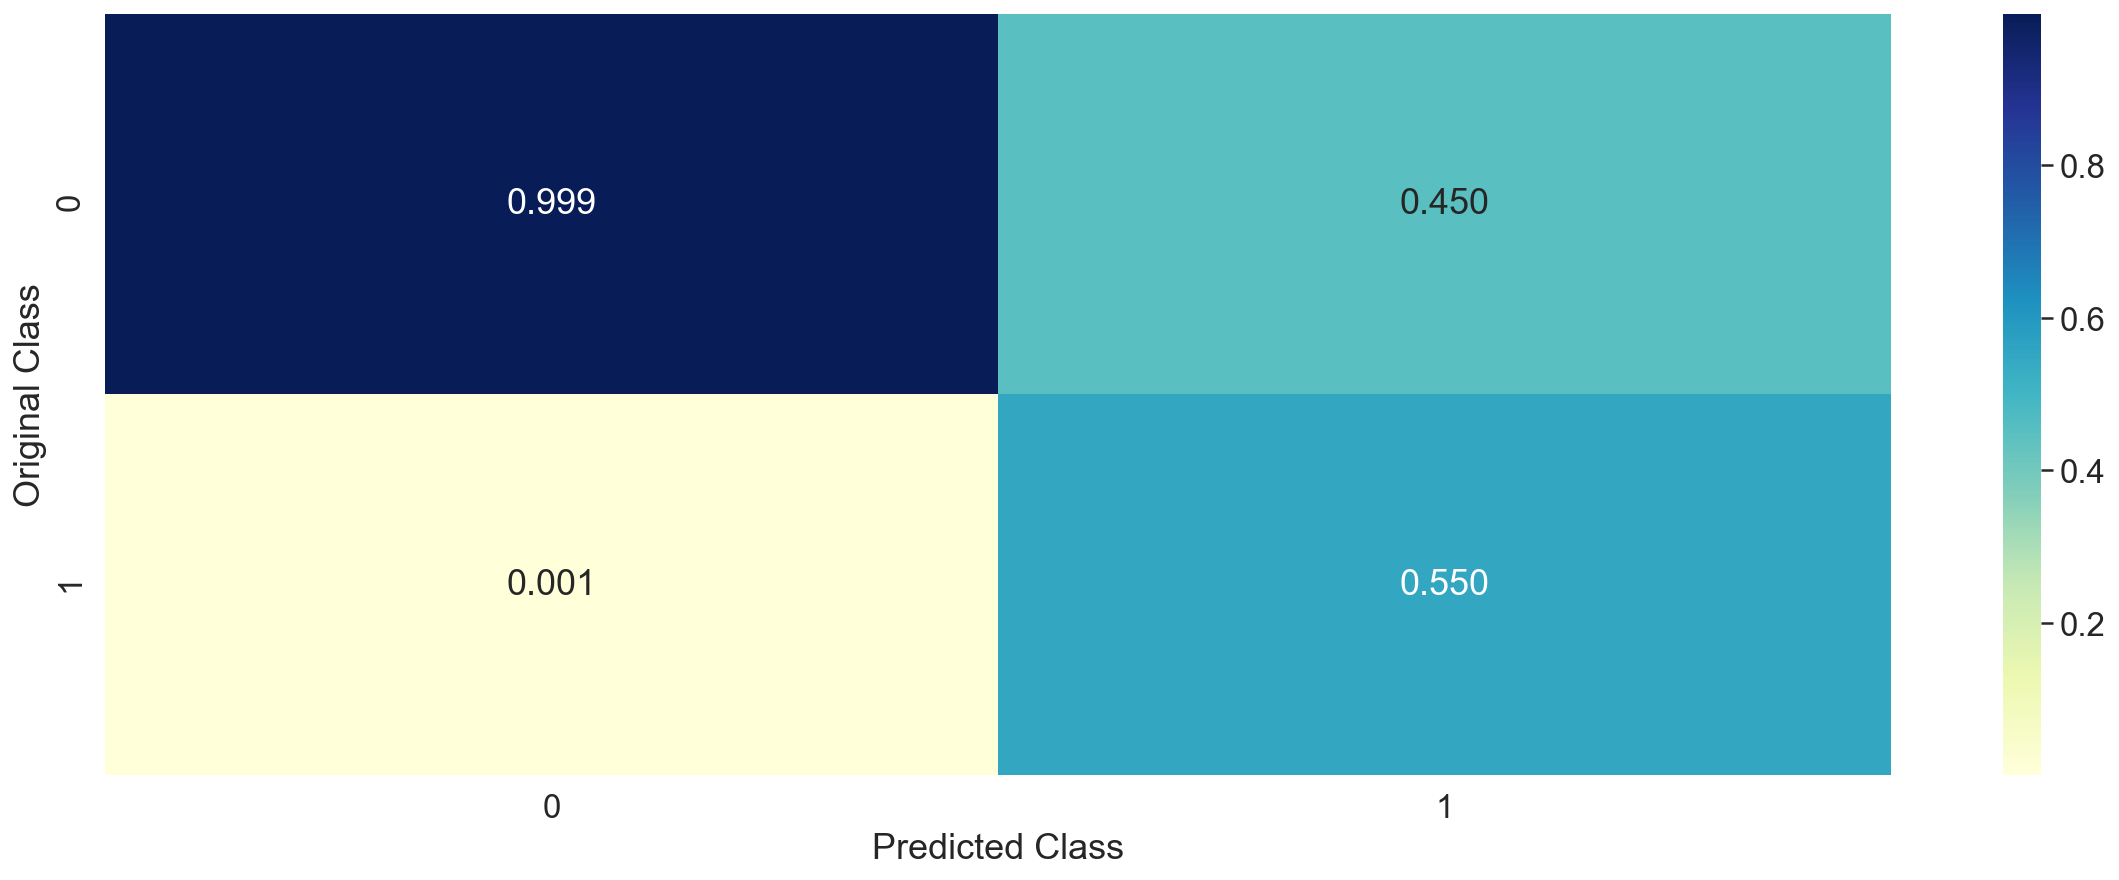

-------------------- Recall matrix (Row sum=1) --------------------


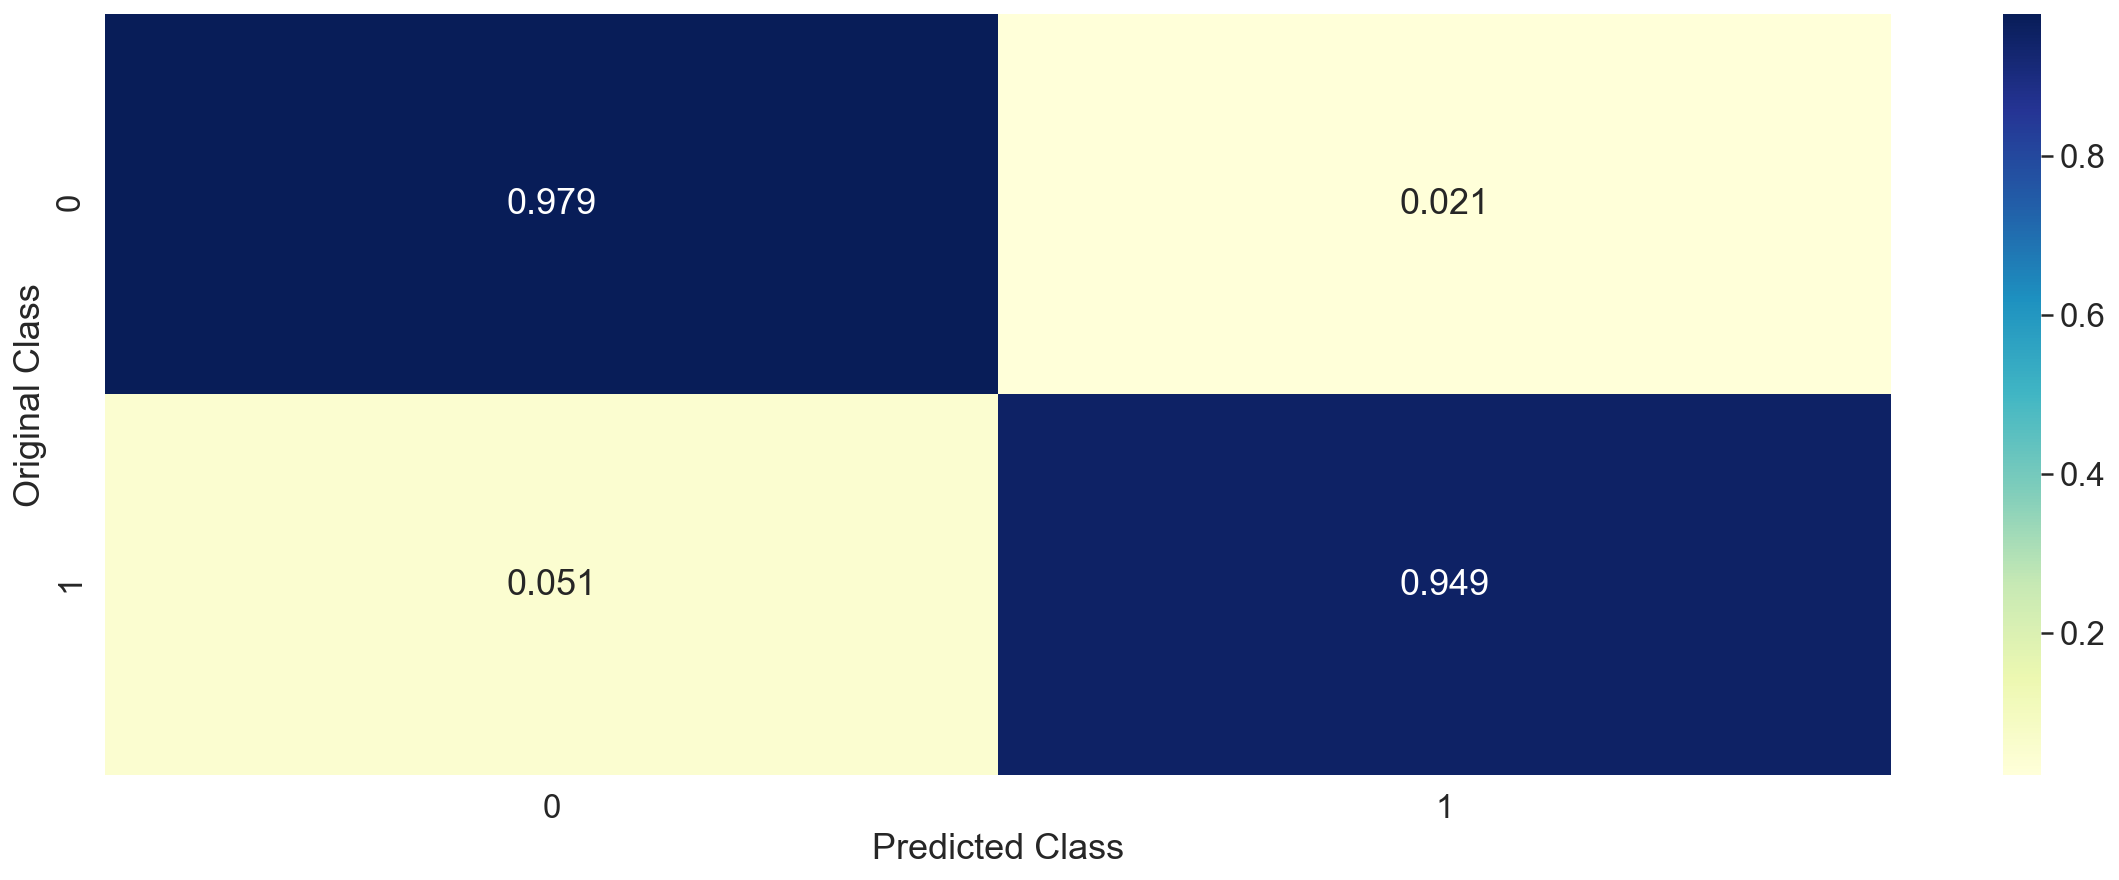

_cv__cv__cv__cv__cv__cv__cv__cv__cv__cv_
-------------------- Confusion matrix --------------------


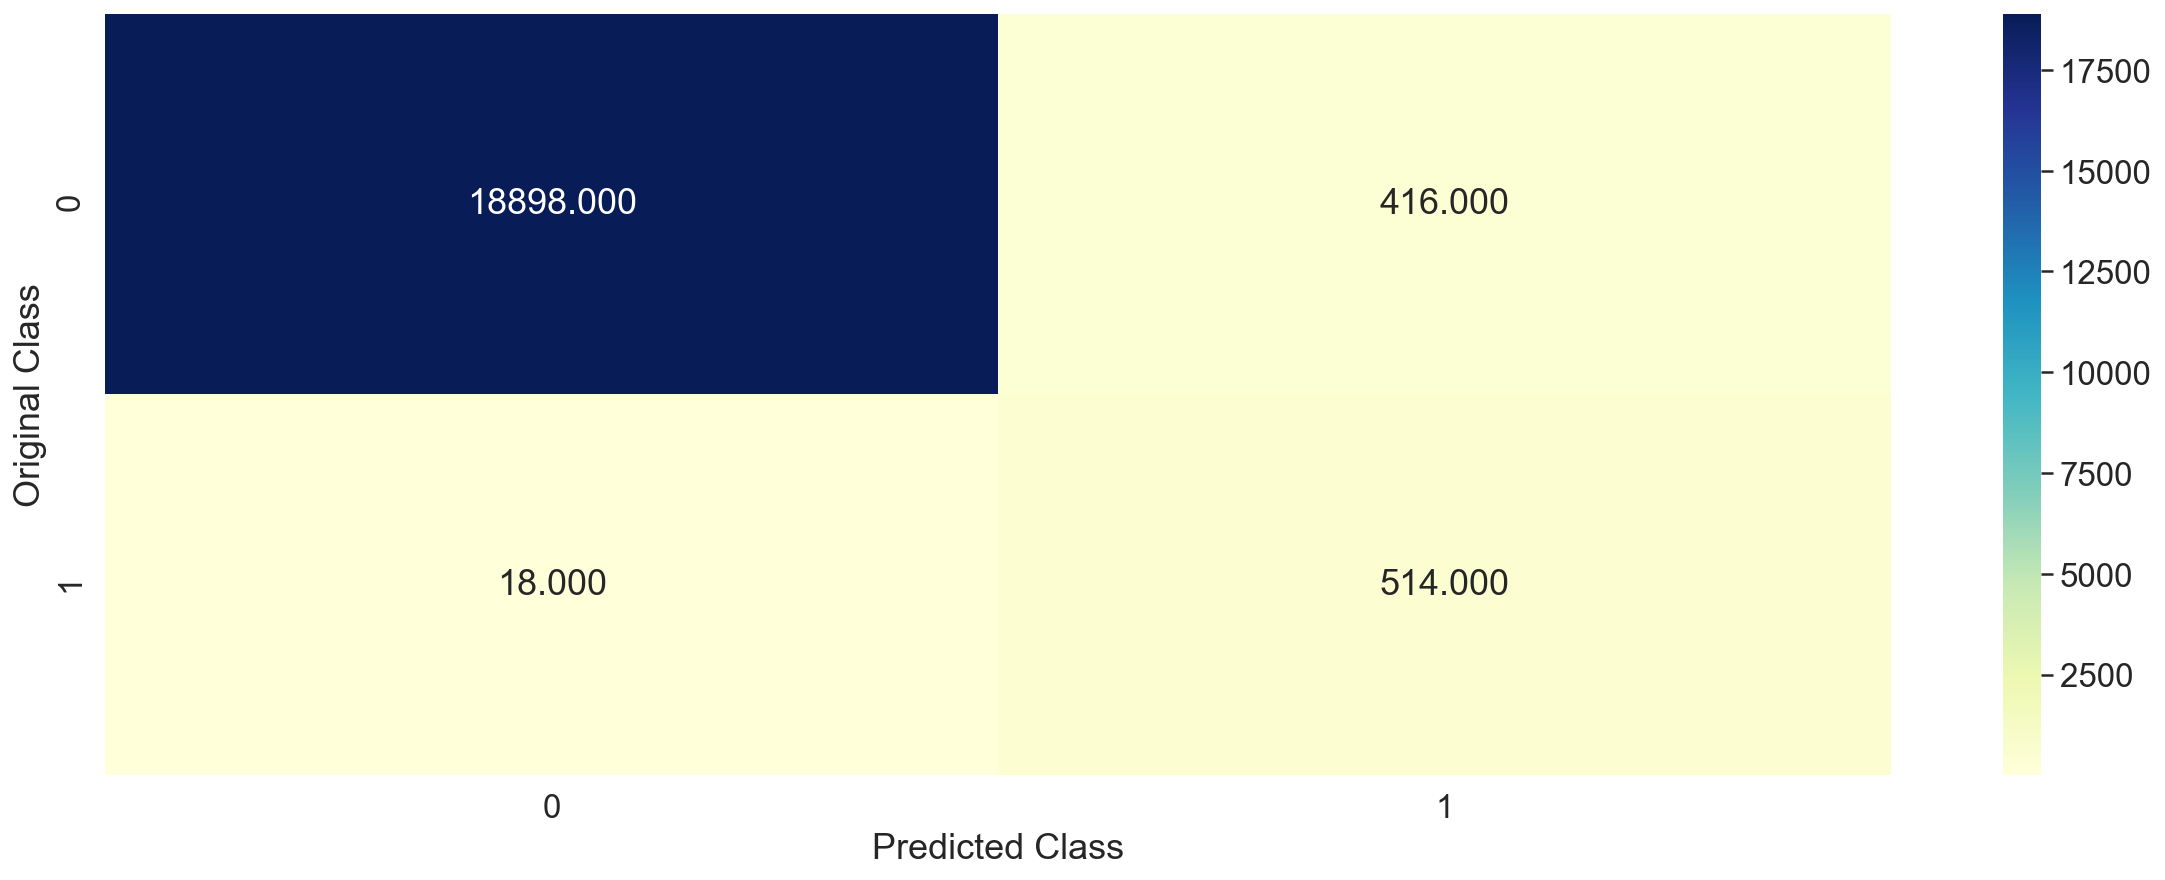

-------------------- Precision matrix (Columm Sum=1) --------------------


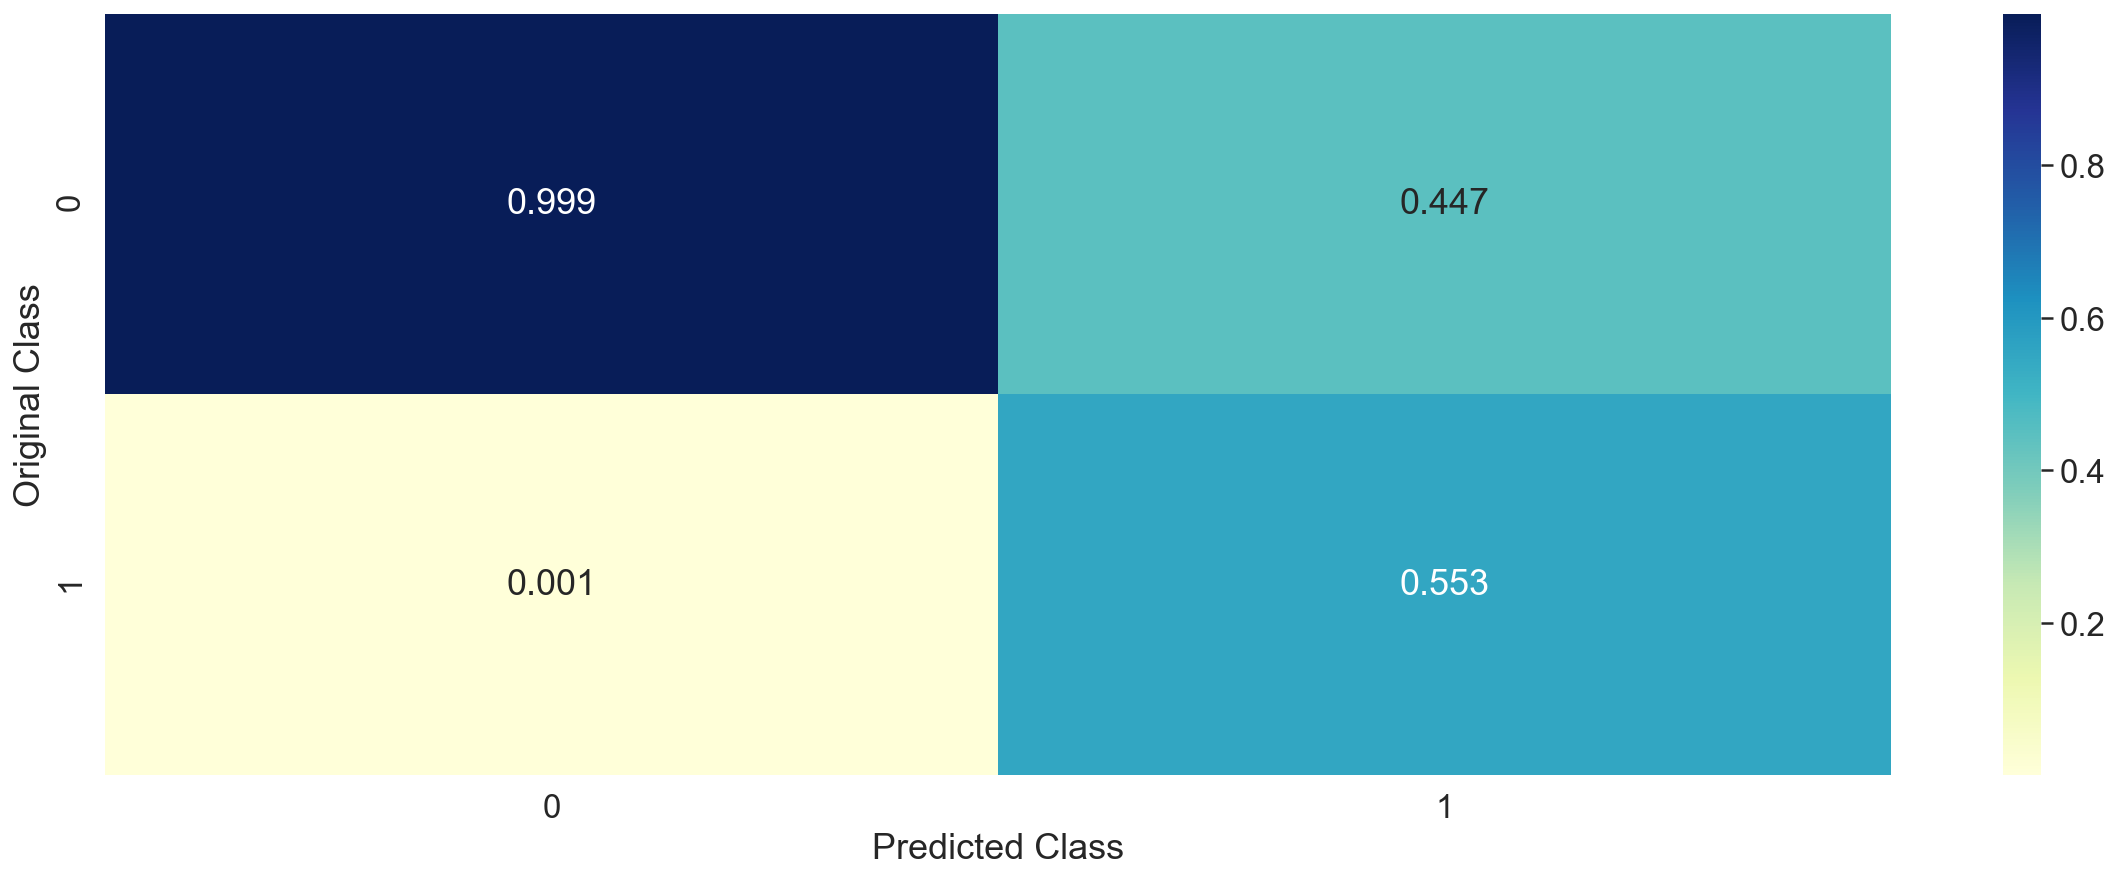

-------------------- Recall matrix (Row sum=1) --------------------


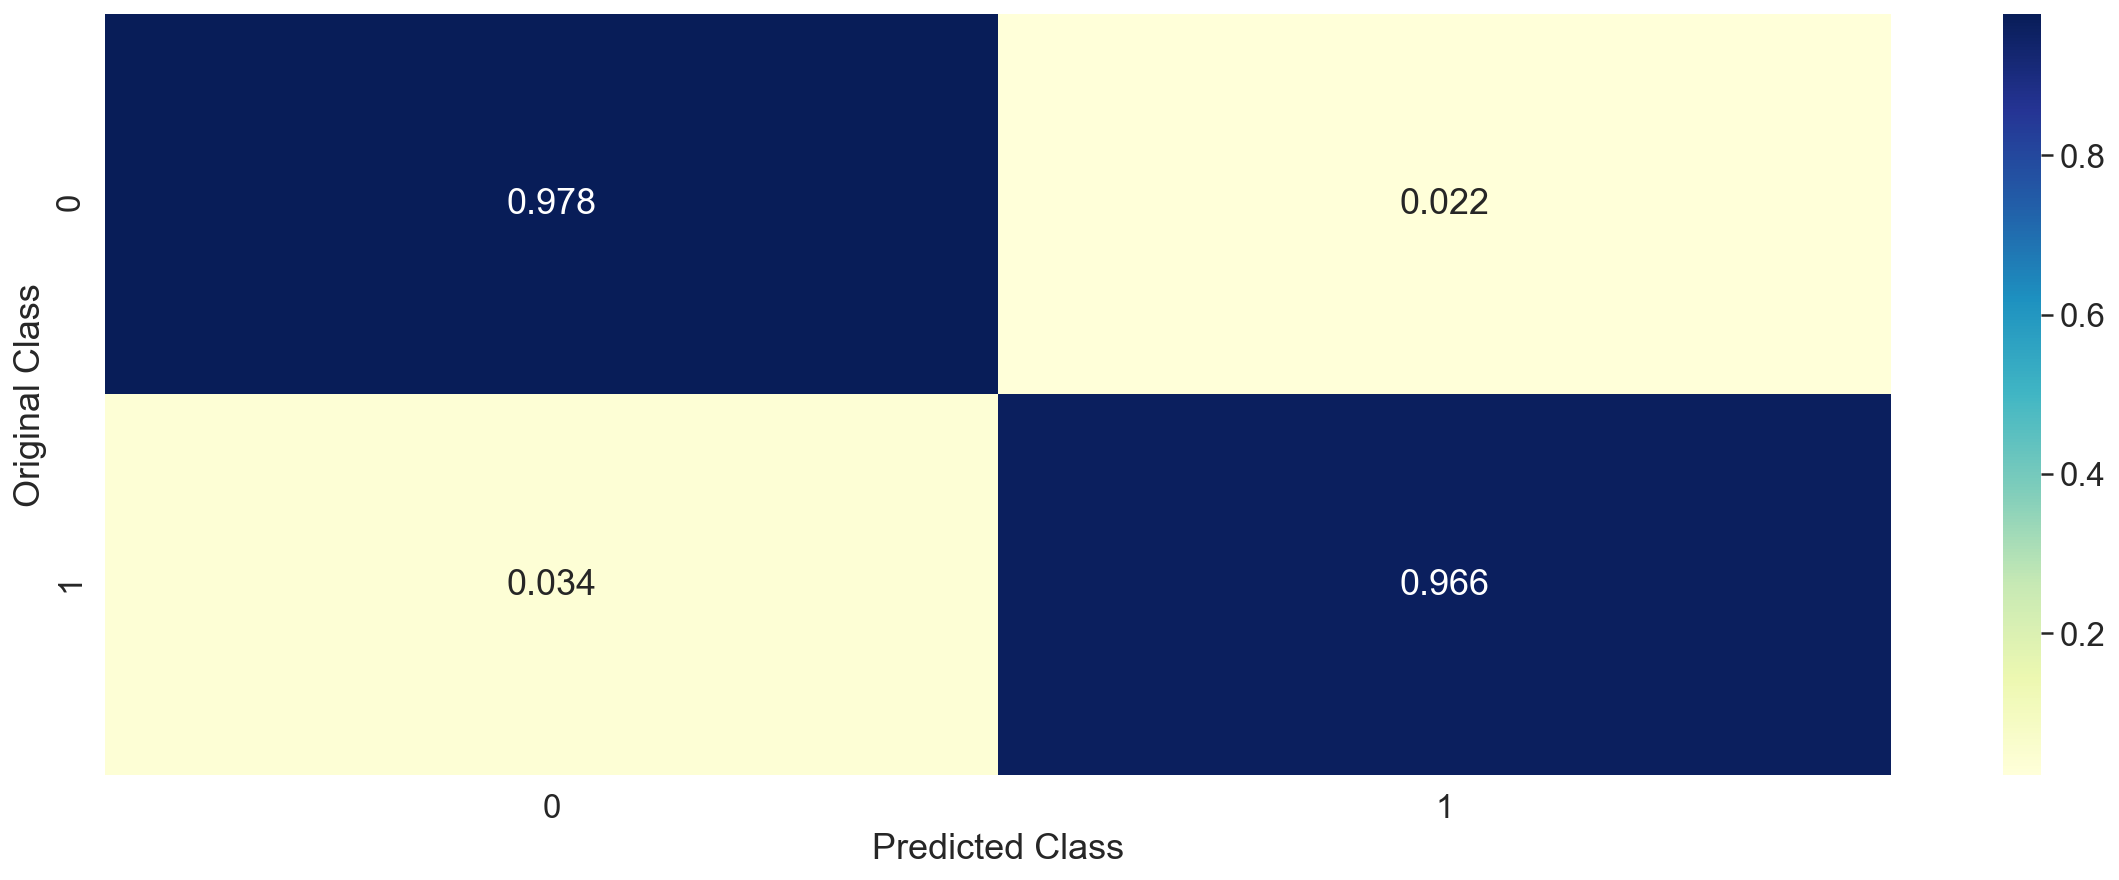

array([[18898,   416],
       [   18,   514]], dtype=int64)

In [250]:
predict_y = model.predict_proba(x_train_hstack)
print("train log loss:", log_loss(y_train, predict_y, labels=model.classes_, eps=1e-15))
predict_y = model.predict_proba(x_test_hstack)
print("test log loss:", log_loss(y_test, predict_y,labels=model.classes_, eps=1e-15))
predict_y = model.predict_proba(x_cv_hstack)
print("cv log loss:", log_loss(y_cv, predict_y,labels=model.classes_, eps=1e-15))



print(" "*100)
print("."*40,"Class Report","."*40)
print(" "*100)
print("-"*20,"Train Data","-"*30)
print( classification_report(y_train, model.predict(x_train_hstack)))
print("-"*20,"Test Data","-"*20)
print( classification_report(y_test, model.predict(x_test_hstack)))
print("-"*20,"CV Data","-"*20)
print( classification_report(y_cv, model.predict(x_cv_hstack)))


print('_train_'*10)
plot_confusion_matrix(y_train, model.predict(x_train_hstack))
confusion_matrix(y_train, model.predict(x_train_hstack))


print('_test_'*10)
plot_confusion_matrix(y_test,  model.predict(x_test_hstack))
confusion_matrix(y_test,  model.predict(x_test_hstack))

print('_cv_'*10)
plot_confusion_matrix(y_cv, model.predict(x_cv_hstack))
confusion_matrix(y_cv, model.predict(x_cv_hstack))


# Adaboost

## Adaboost - Hyperparameter Tunning

In [258]:

parameters = {"n_estimators":[10, 50, 100, 150, 200, 300, 500, 1000],
              'learning_rate':[0.0000001,0.000001,0.00001,0.0001, 0.001, 0.01],
             'algorithm':["SAMME", "SAMME.R"]}

rf =  AdaBoostClassifier()

In [259]:
CV = RandomizedSearchCV(rf, parameters, 
                  return_train_score=True, 
                  cv=3, 
                  scoring='roc_auc_ovr_weighted',
                  error_score='raise',
                  n_jobs=-1,
                  verbose=5)
CV.fit(x_train_hstack, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, error_score='raise', estimator=AdaBoostClassifier(),
                   n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': [1e-07, 1e-06, 1e-05,
                                                          0.0001, 0.001, 0.01],
                                        'n_estimators': [10, 50, 100, 150, 200,
                                                         300, 500, 1000]},
                   return_train_score=True, scoring='roc_auc_ovr_weighted',
                   verbose=5)

In [260]:
CV.best_params_

{'n_estimators': 100, 'learning_rate': 0.01, 'algorithm': 'SAMME.R'}

## Adaboost - AUC

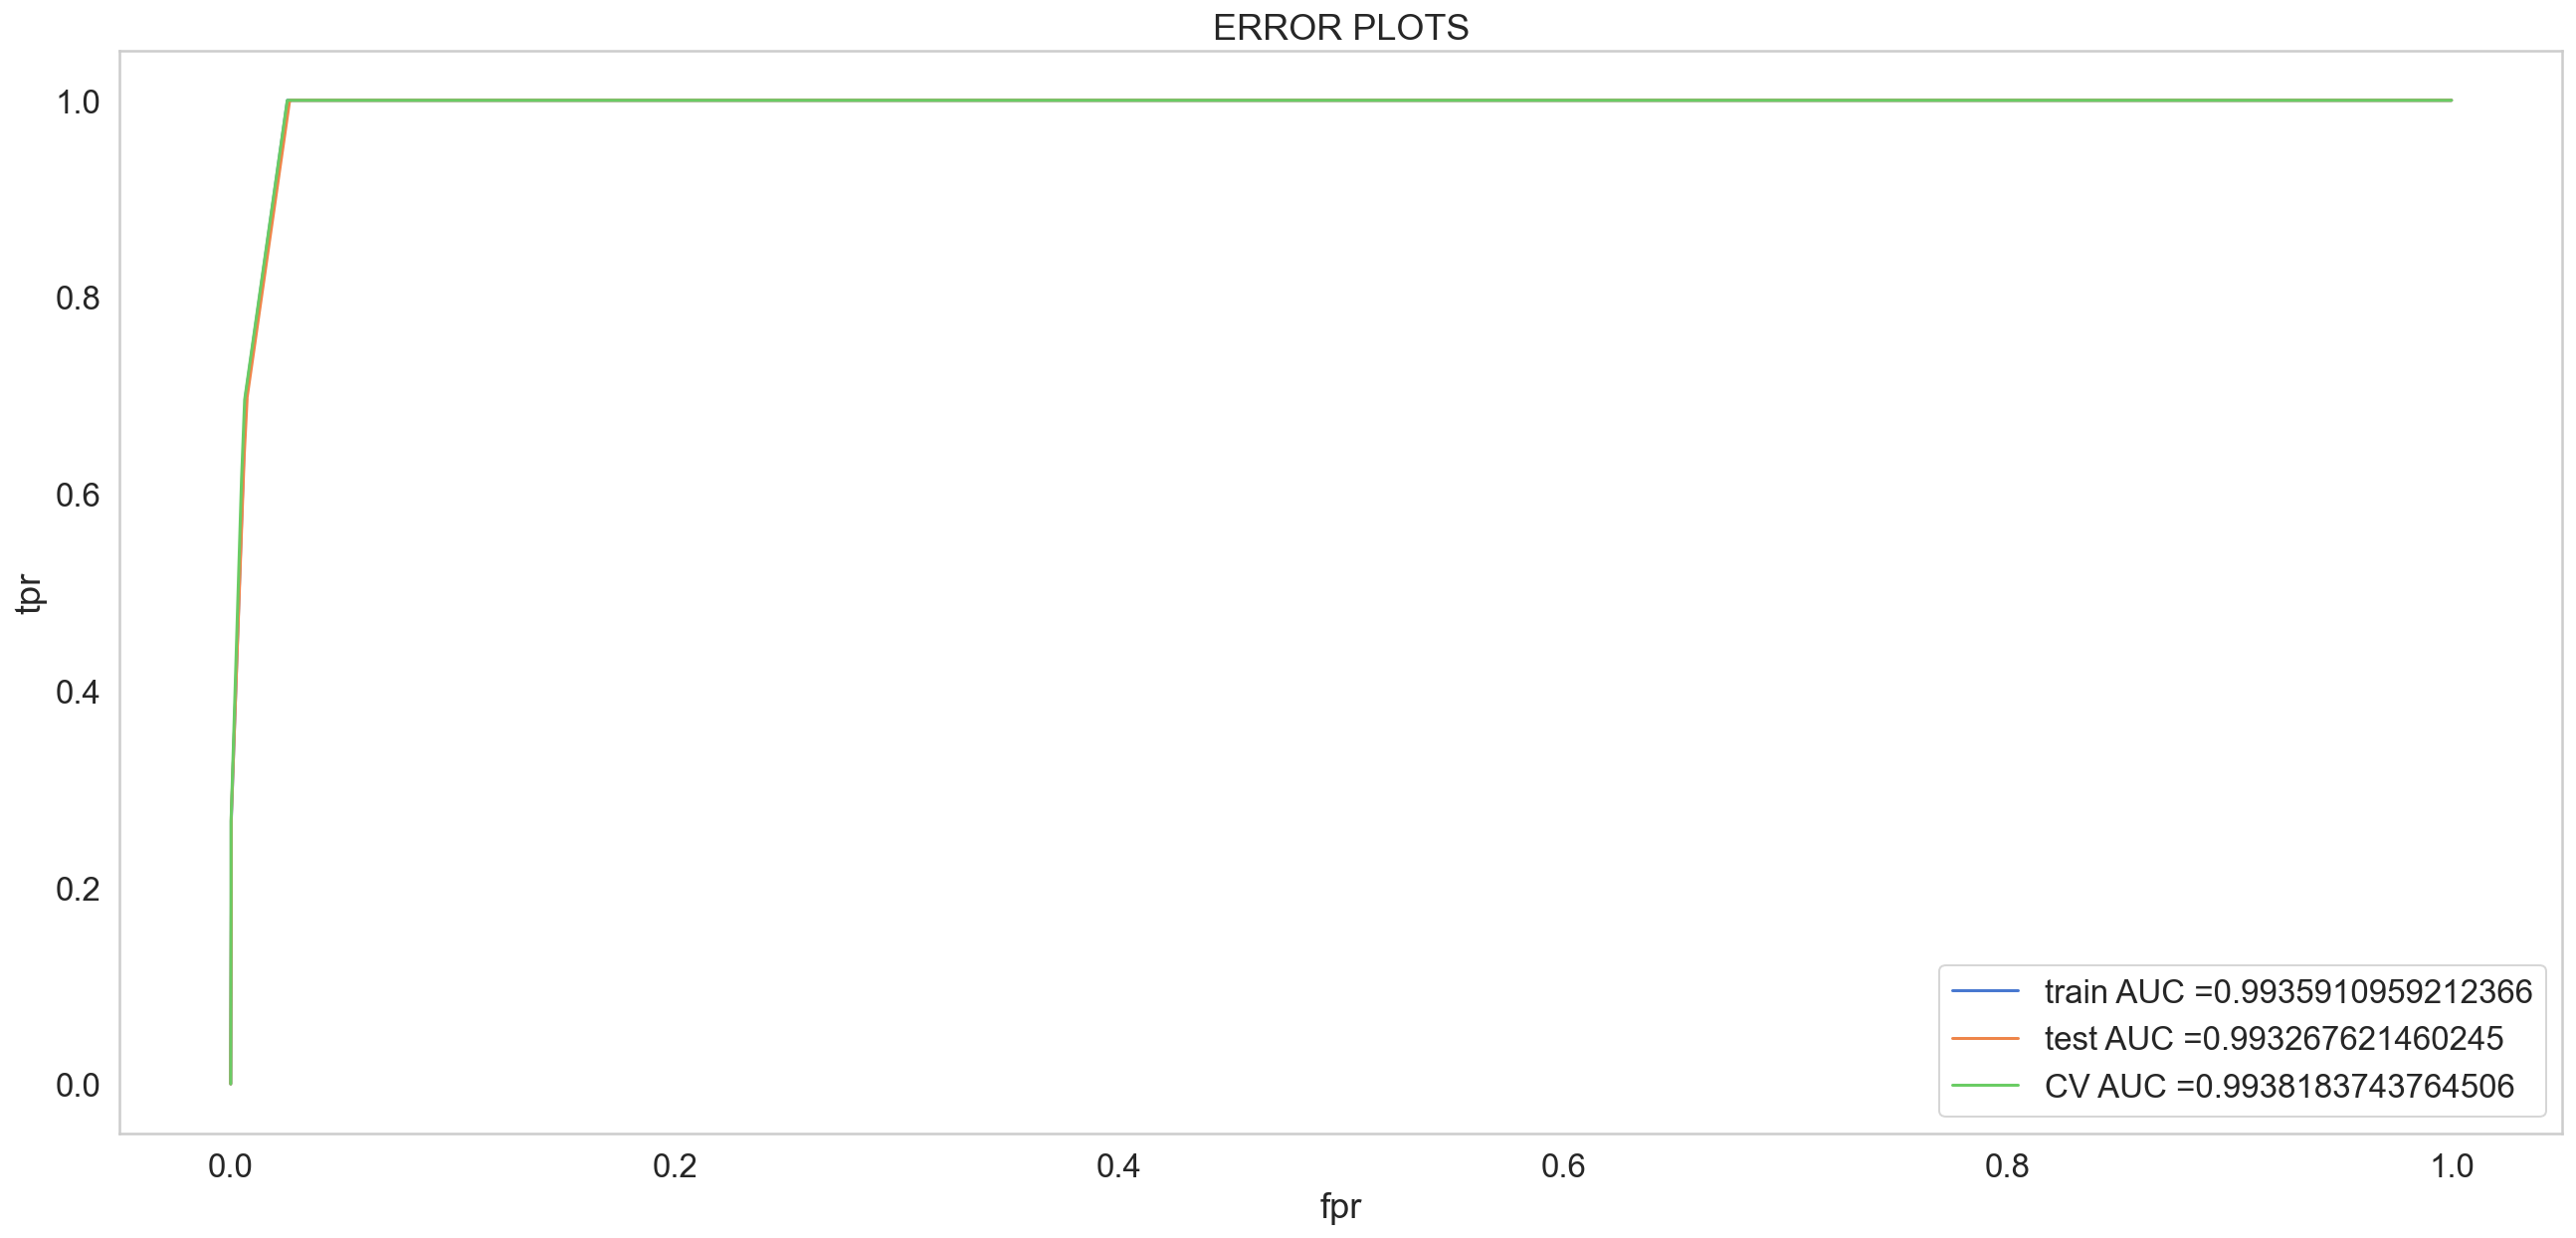

In [261]:
from sklearn.metrics import roc_curve, auc
model = AdaBoostClassifier(n_estimators = 100,
                          learning_rate=0.01,
                          algorithm='SAMME.R'
                          )
model.fit(x_train_hstack, y_train)

y_train_pred = model.predict_proba(x_train_hstack)    
y_test_pred = model.predict_proba(x_test_hstack)
y_cv_pred = model.predict_proba(x_cv_hstack)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train.astype('int'),y_train_pred[:,1] )

test_fpr, test_tpr, te_thresholds = roc_curve(y_test.astype('int'),y_test_pred[:,1] )

cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv.astype('int'),y_cv_pred[:,1] )


plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))


plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Adaboost - Logloss and Classification Report

train log loss: 0.03521966701983715
test log loss: 0.03573555606725491
cv log loss: 0.035124228130483895
                                                                                                    
........................................ Class Report ........................................
                                                                                                    
-------------------- Train Data ------------------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     77256
           1       0.00      0.00      0.00      2126

    accuracy                           0.97     79382
   macro avg       0.49      0.50      0.49     79382
weighted avg       0.95      0.97      0.96     79382

-------------------- Test Data --------------------
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     24142
           1       0.00      0.00      0.00    

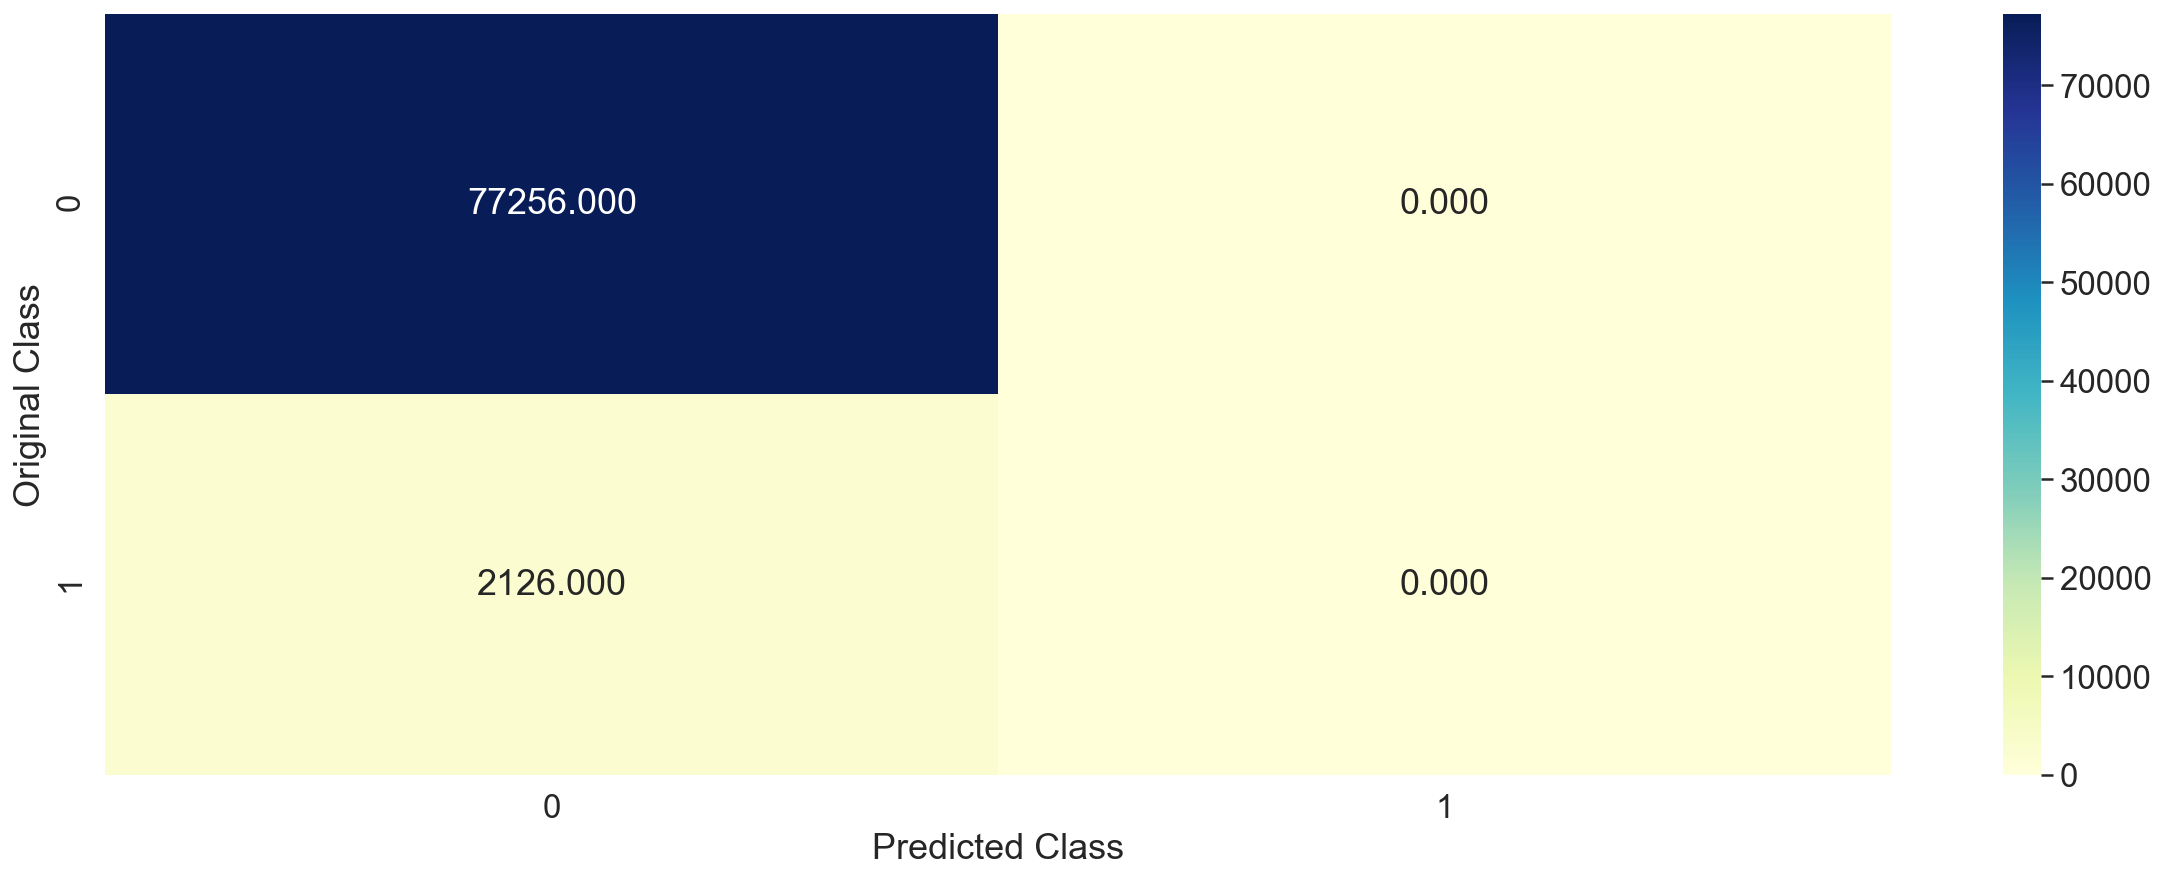

-------------------- Precision matrix (Columm Sum=1) --------------------


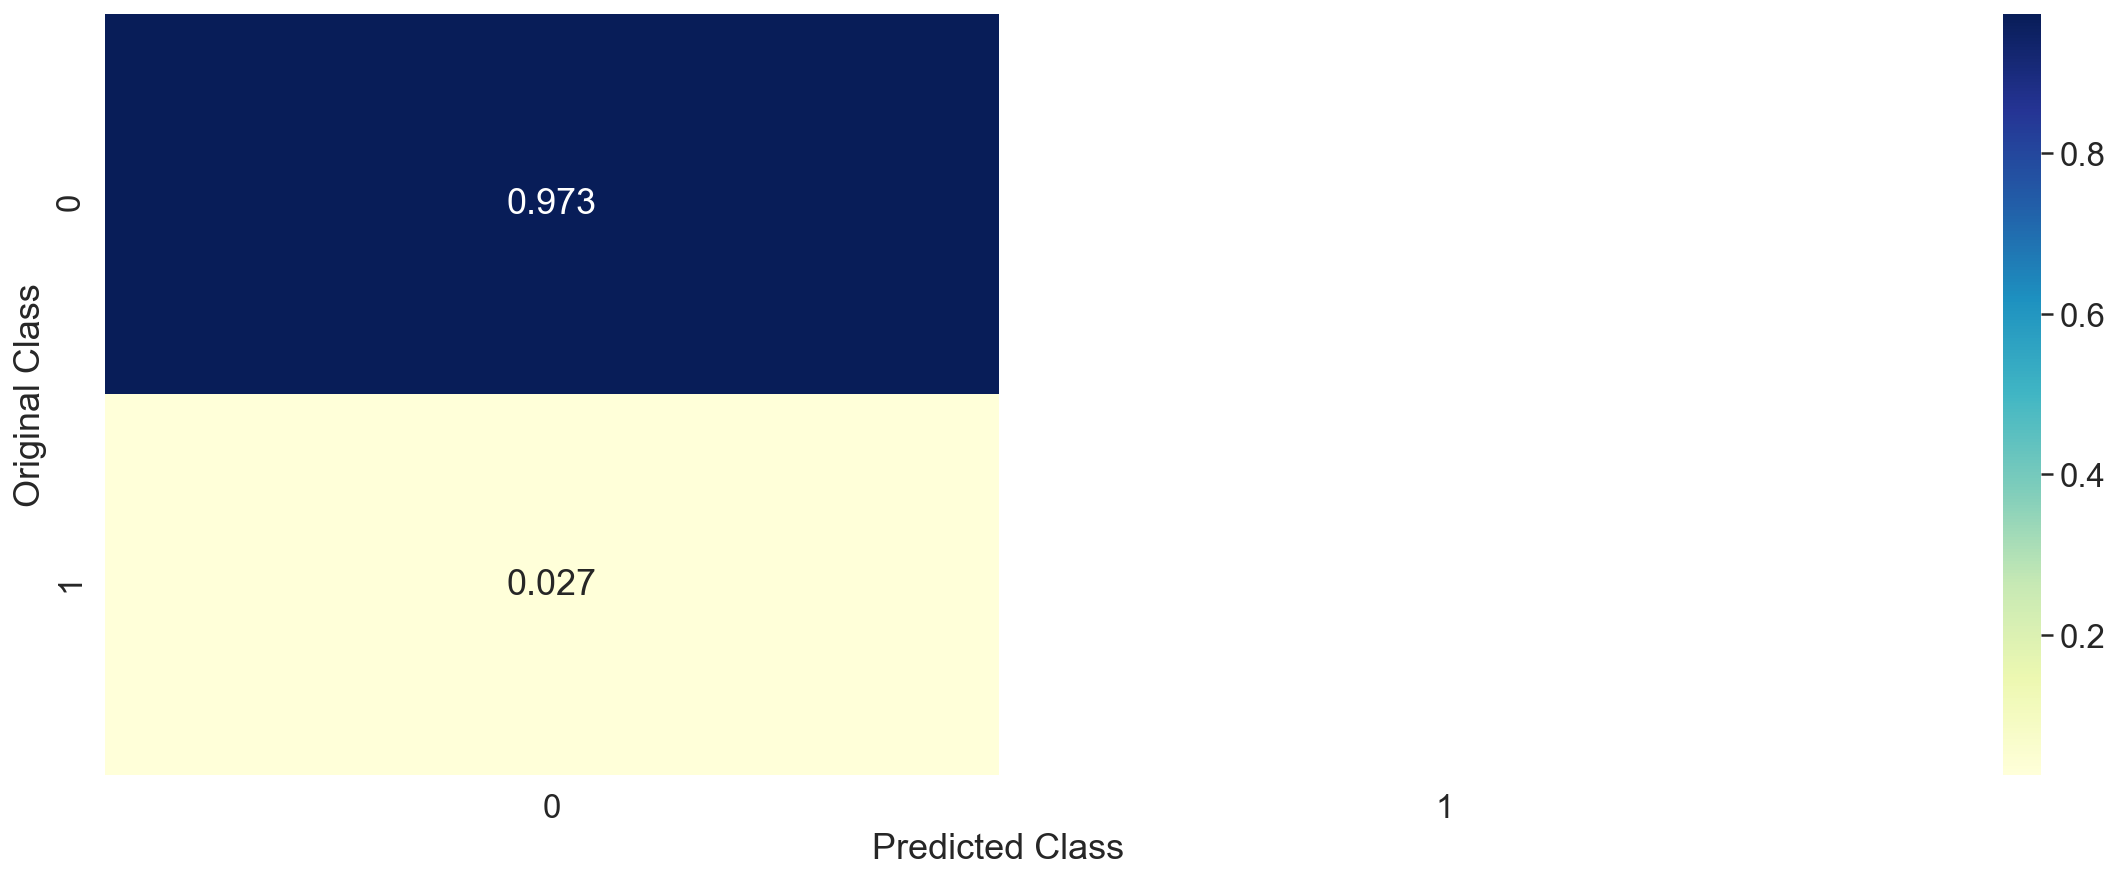

-------------------- Recall matrix (Row sum=1) --------------------


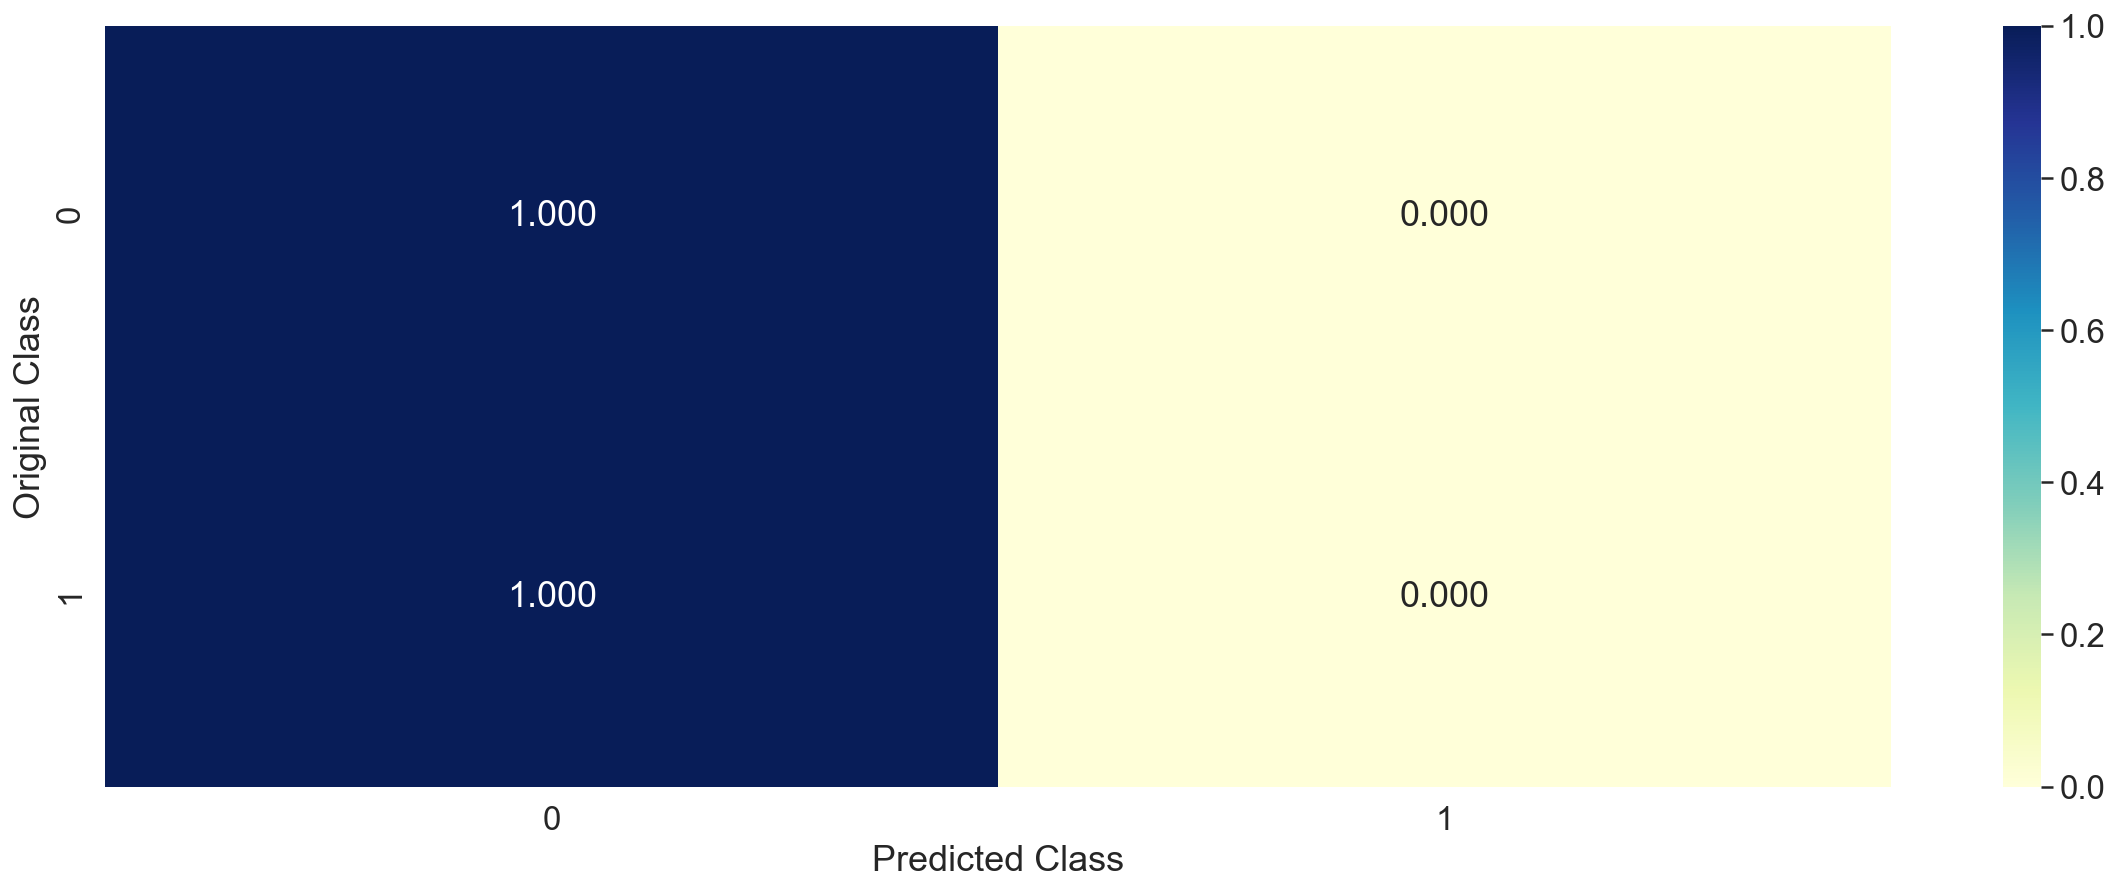

_test__test__test__test__test__test__test__test__test__test_
-------------------- Confusion matrix --------------------


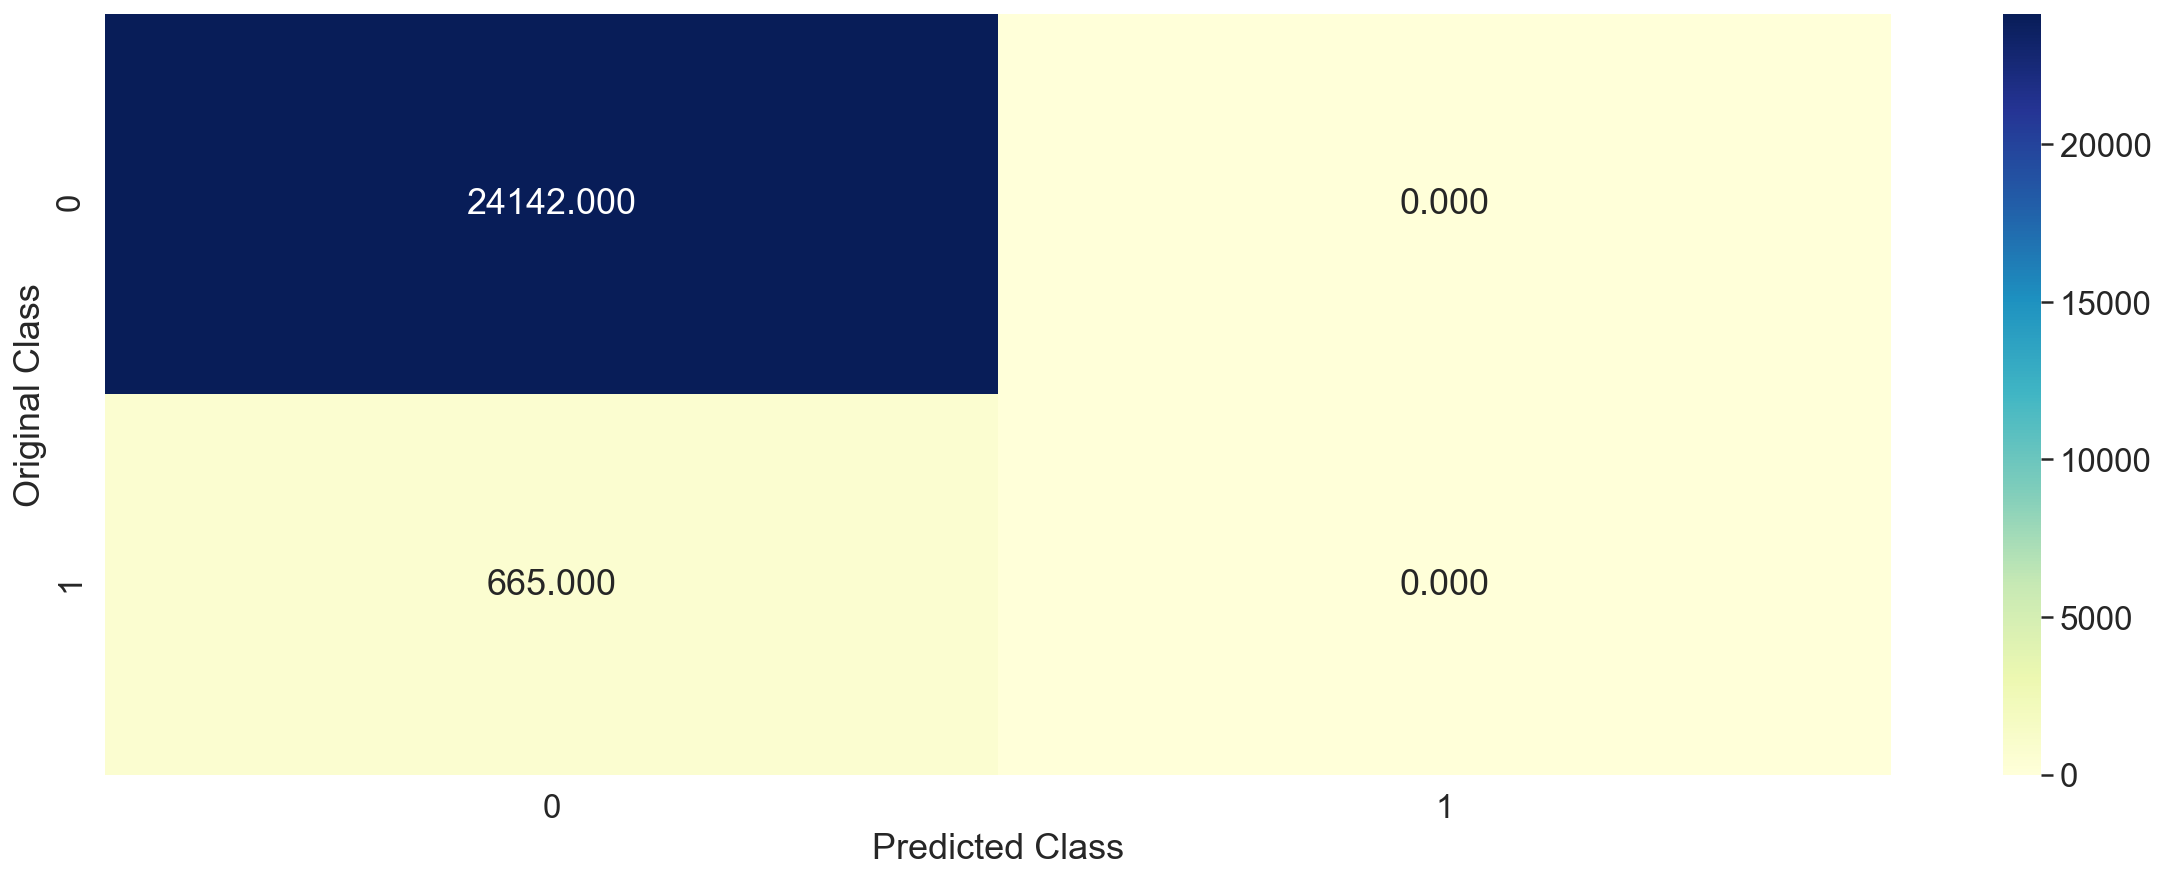

-------------------- Precision matrix (Columm Sum=1) --------------------


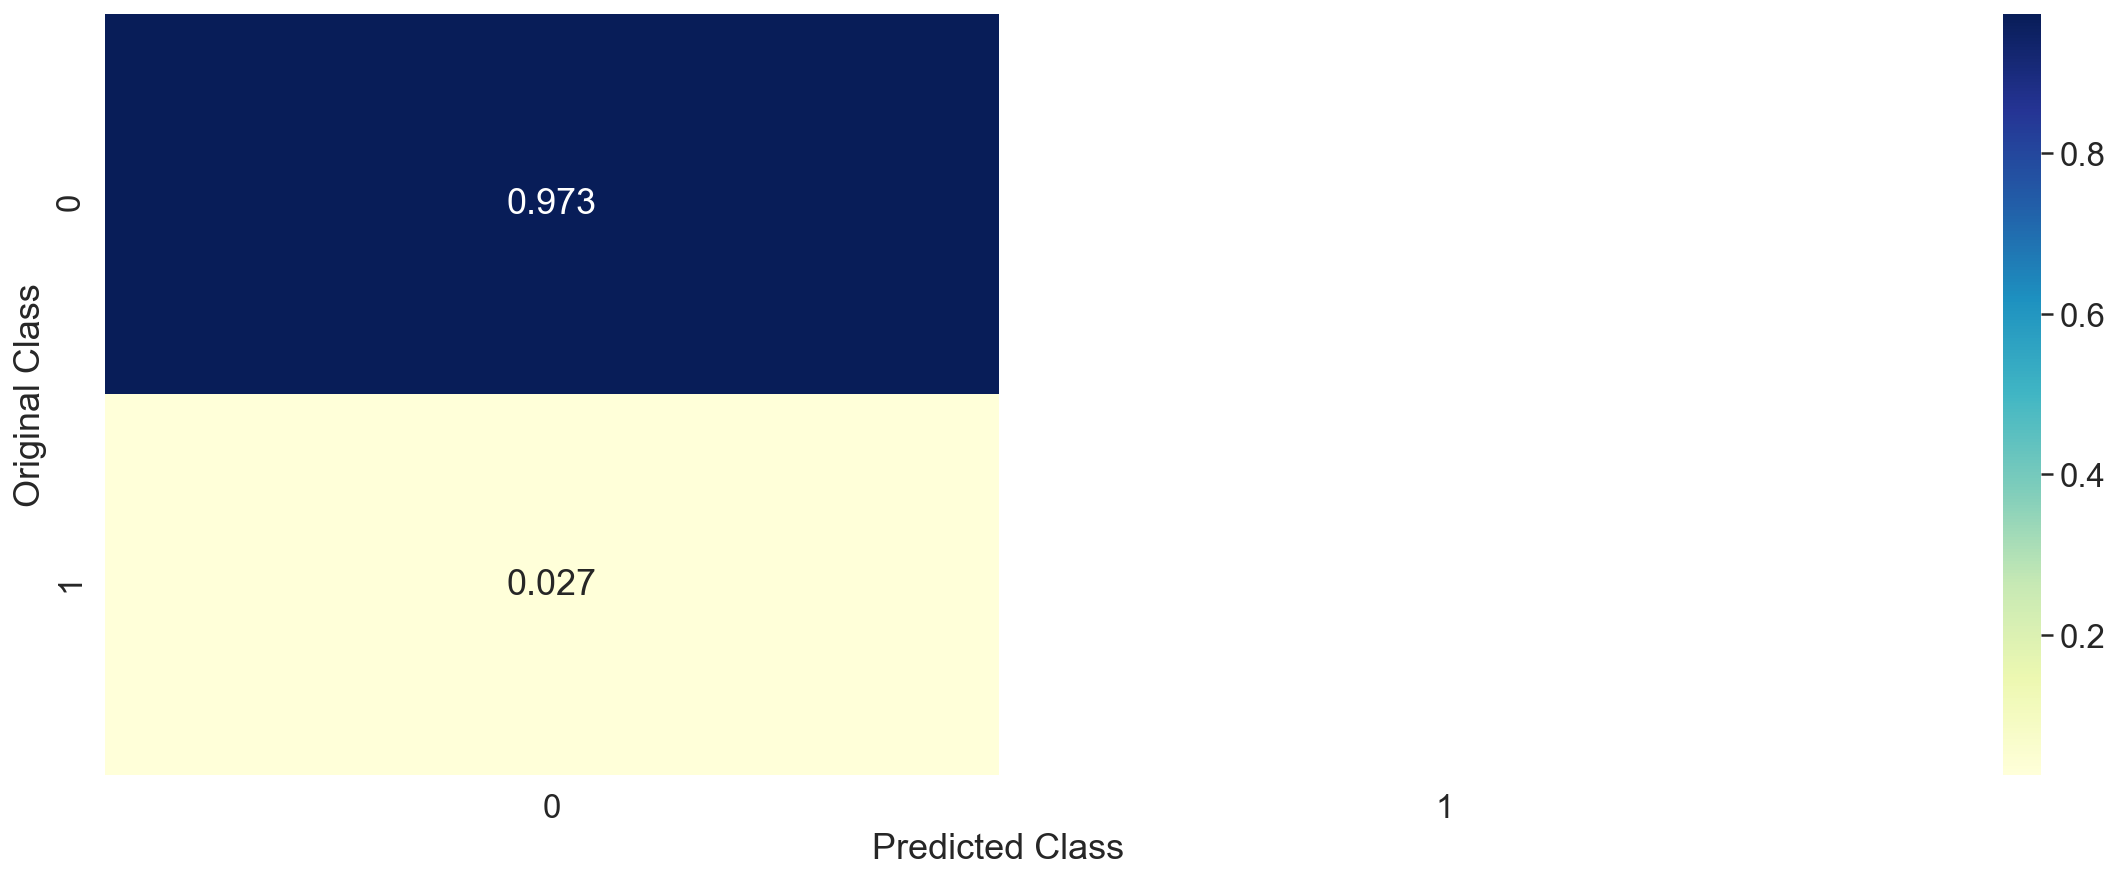

-------------------- Recall matrix (Row sum=1) --------------------


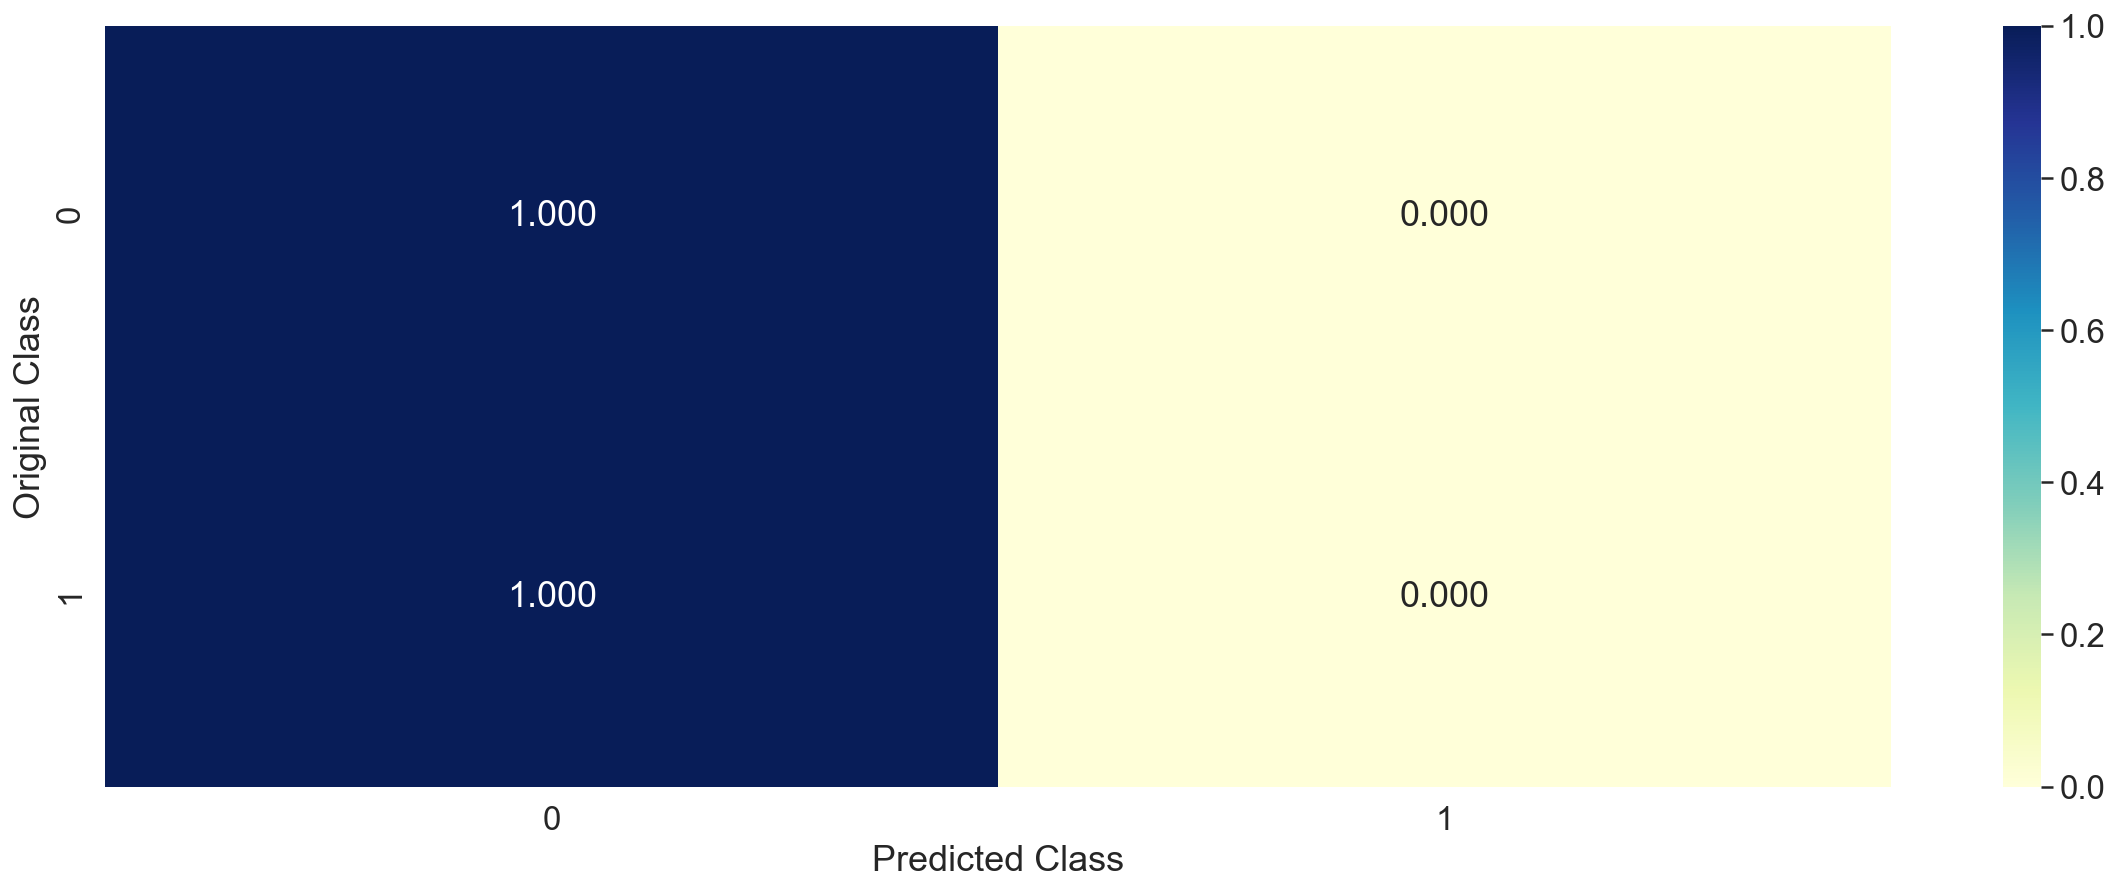

_cv__cv__cv__cv__cv__cv__cv__cv__cv__cv_
-------------------- Confusion matrix --------------------


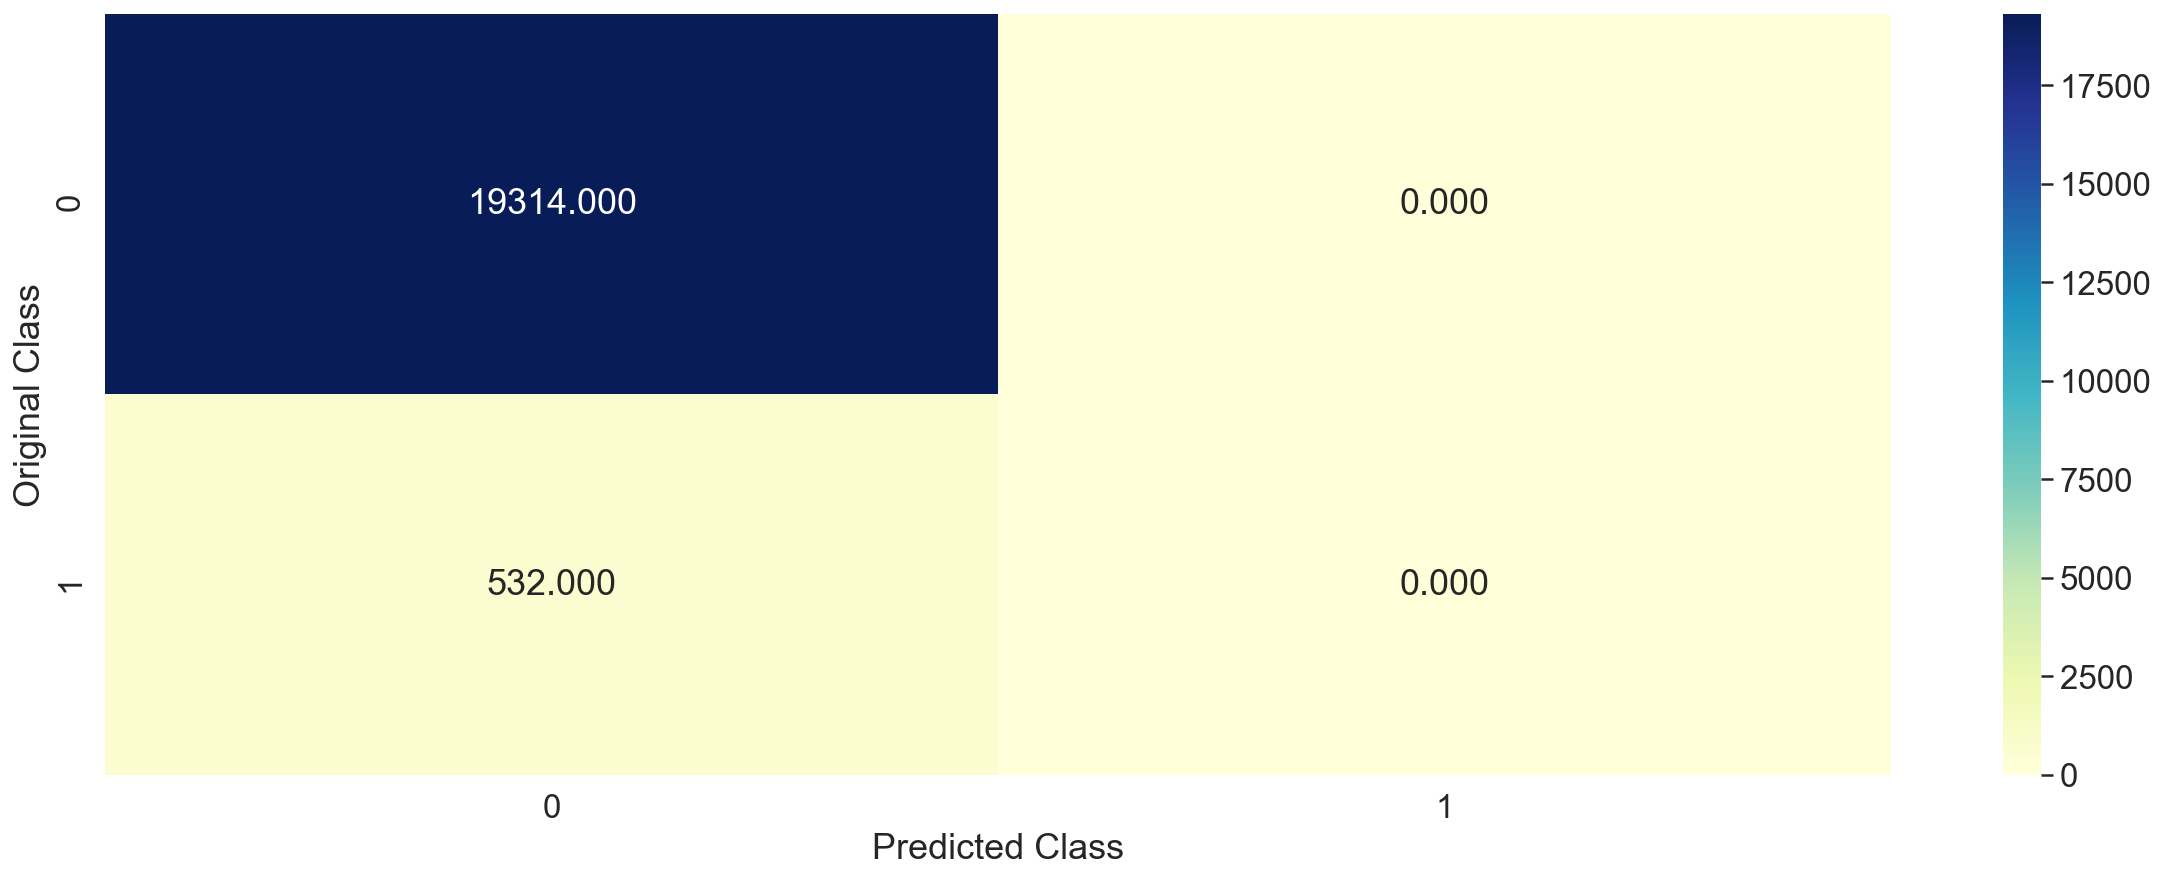

-------------------- Precision matrix (Columm Sum=1) --------------------


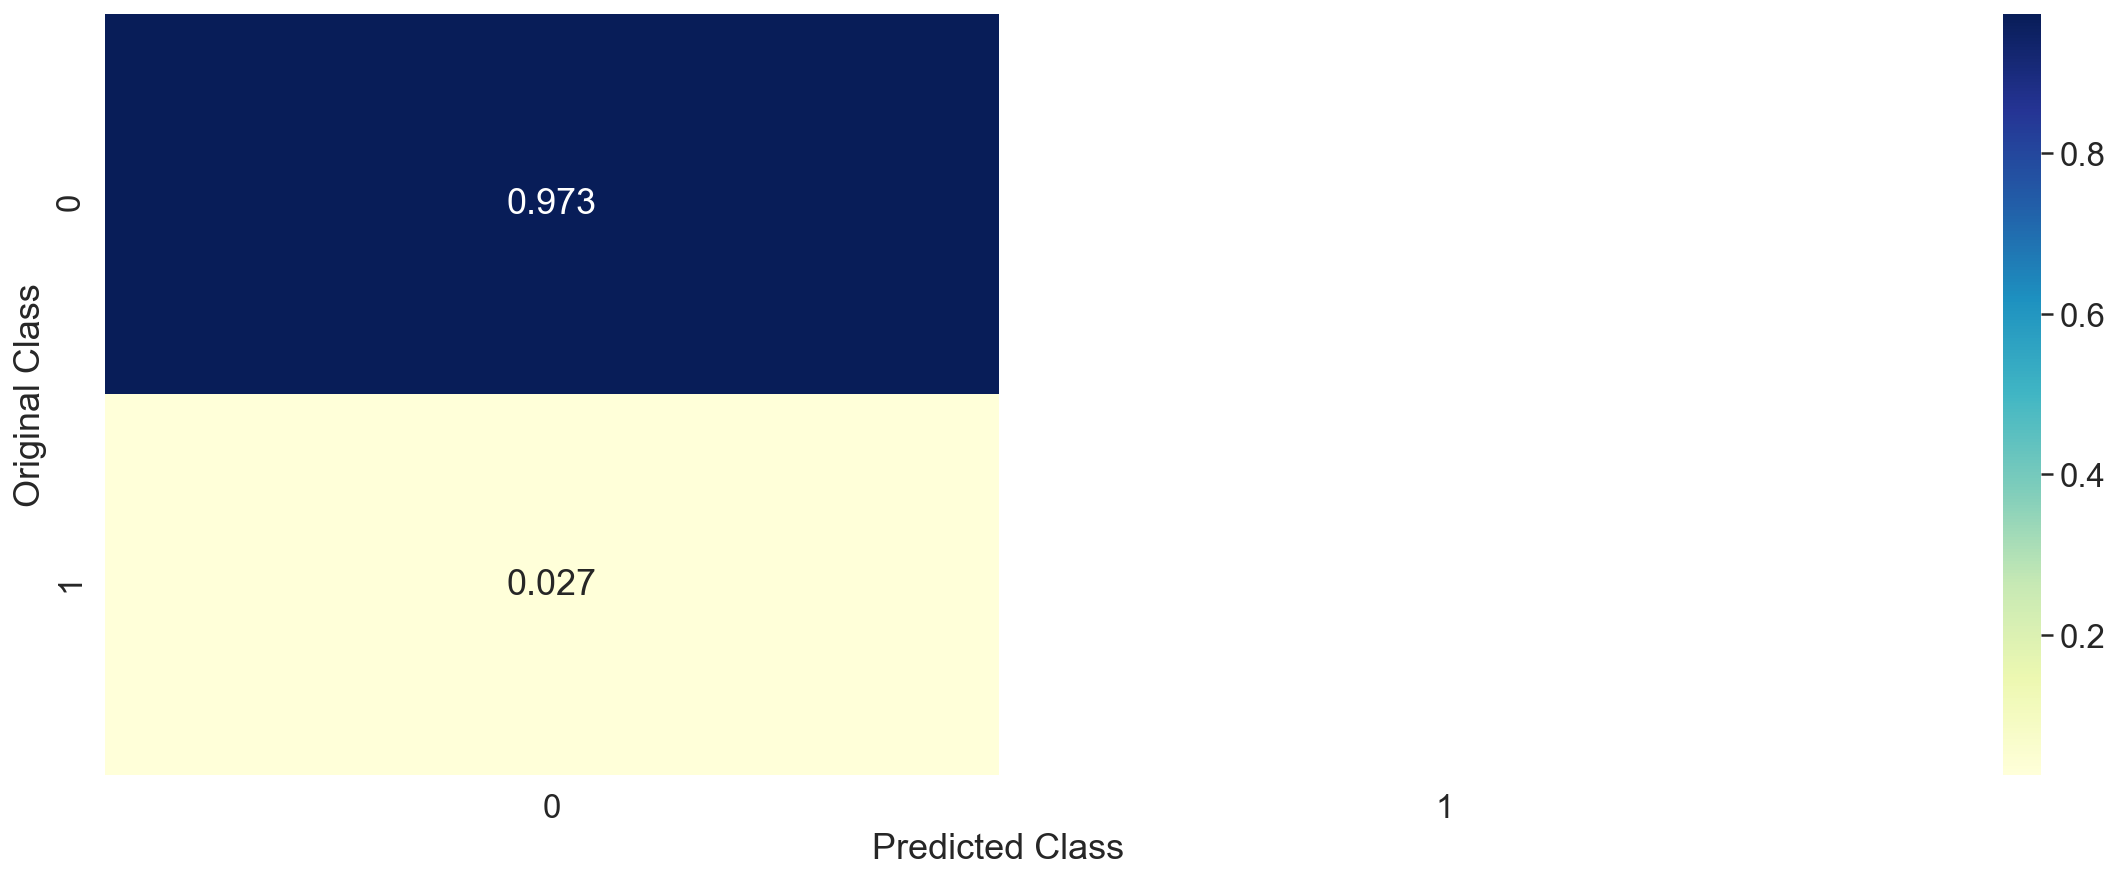

-------------------- Recall matrix (Row sum=1) --------------------


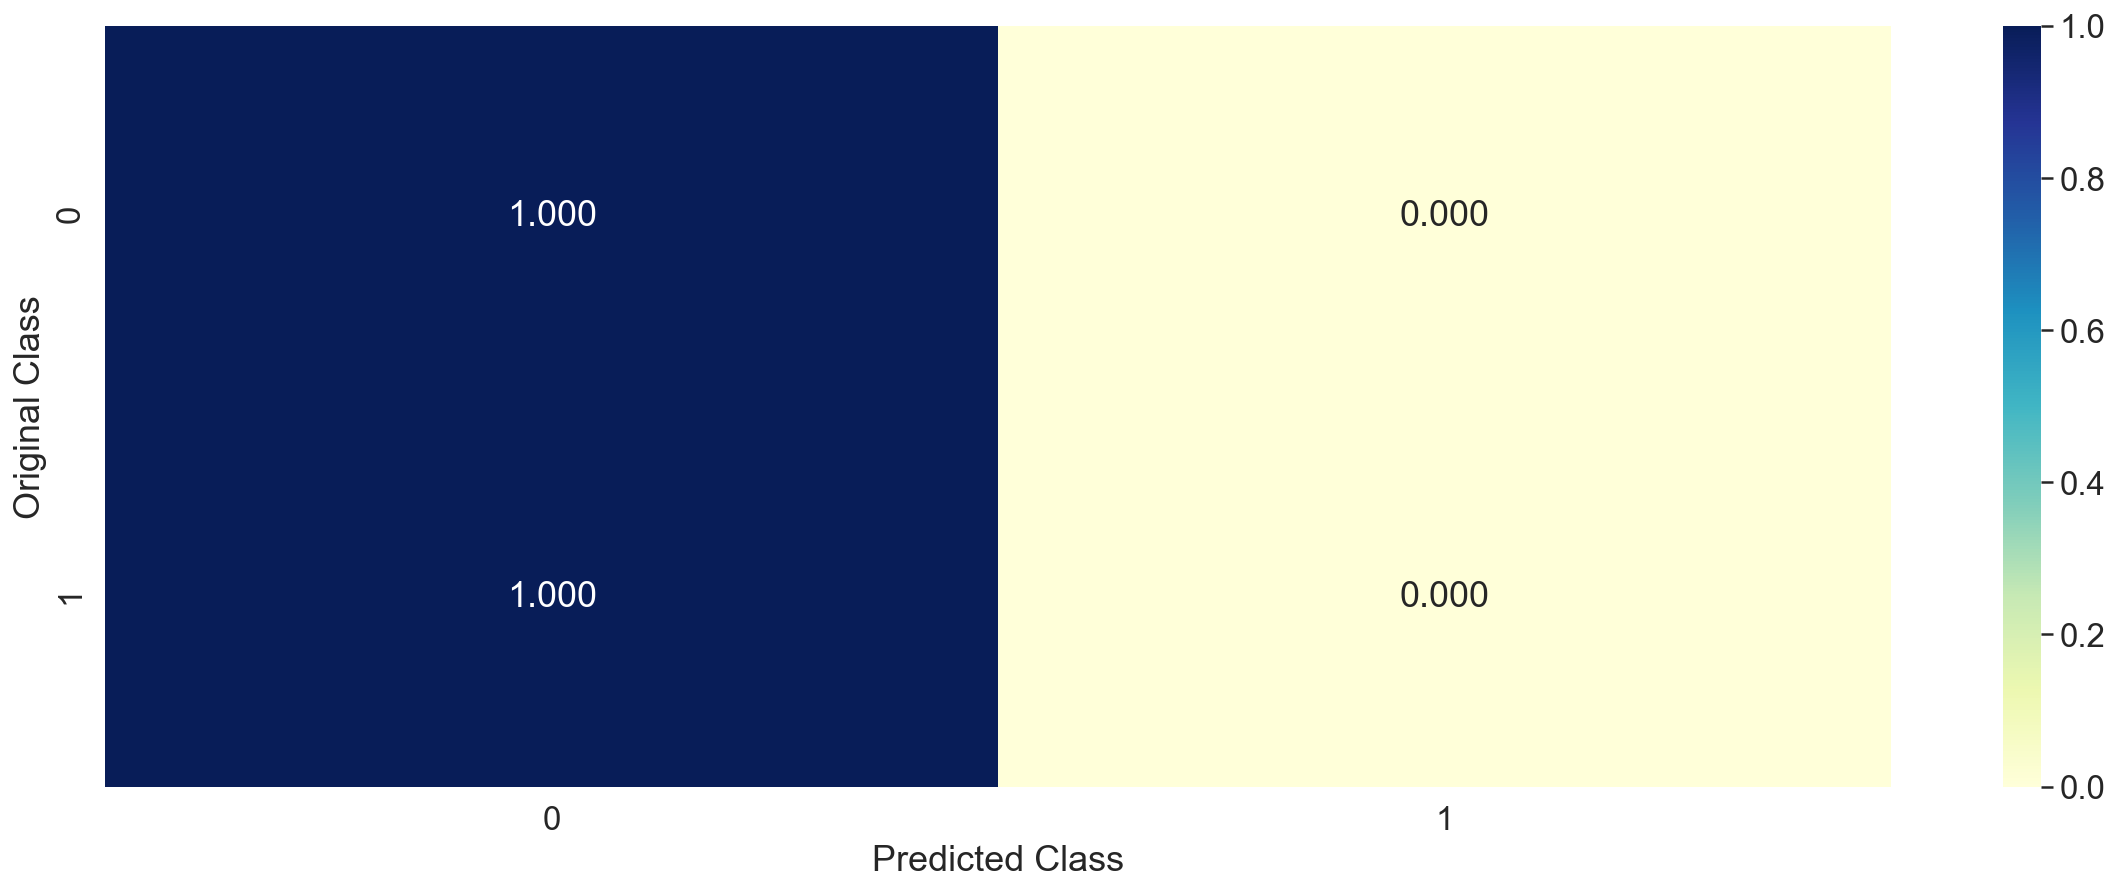

array([[19314,     0],
       [  532,     0]], dtype=int64)

In [262]:
predict_y = model.predict_proba(x_train_hstack)
print("train log loss:", log_loss(y_train, predict_y, labels=model.classes_, eps=1e-15))
predict_y = model.predict_proba(x_test_hstack)
print("test log loss:", log_loss(y_test, predict_y,labels=model.classes_, eps=1e-15))
predict_y = model.predict_proba(x_cv_hstack)
print("cv log loss:", log_loss(y_cv, predict_y,labels=model.classes_, eps=1e-15))



print(" "*100)
print("."*40,"Class Report","."*40)
print(" "*100)
print("-"*20,"Train Data","-"*30)
print( classification_report(y_train, model.predict(x_train_hstack)))
print("-"*20,"Test Data","-"*20)
print( classification_report(y_test, model.predict(x_test_hstack)))
print("-"*20,"CV Data","-"*20)
print( classification_report(y_cv, model.predict(x_cv_hstack)))


print('_train_'*10)
plot_confusion_matrix(y_train, model.predict(x_train_hstack))
confusion_matrix(y_train, model.predict(x_train_hstack))


print('_test_'*10)
plot_confusion_matrix(y_test,  model.predict(x_test_hstack))
confusion_matrix(y_test,  model.predict(x_test_hstack))

print('_cv_'*10)
plot_confusion_matrix(y_cv, model.predict(x_cv_hstack))
confusion_matrix(y_cv, model.predict(x_cv_hstack))


# MLPClassifier

## MLP - Hyperparameter  Tunning

In [265]:
from sklearn.neural_network import MLPClassifier

import optuna

from sklearn.model_selection import cross_val_score



# def objective(trial):
#     momentum = trial.suggest_float('momentum', 0.0, 1.0)
#     learning_rate_init = trial.suggest_float('learning_rate_init',
#                                              1e-5, 1e-3, log=True)
#     clf = MLPClassifier(hidden_layer_sizes=(100, 50), momentum=momentum,
#                         learning_rate_init=learning_rate_init,
#                         solver='sgd', random_state=0)
#     clf.fit(X_train, y_train)

#     return clf.score(X_test, y_test)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=3)

def objective(trial):
   
    
    momentum = trial.suggest_float('momentum', 0.0, 1.0)
    
    learning_rate_init = trial.suggest_float('learning_rate_init',
                                             1e-5, 1e-3, log=True)
    solver = trial.suggest_categorical('solver',['lbfgs', 'sgd', 'adam'])
    activation = trial.suggest_categorical('activation',['identity', 'logistic', 'tanh','relu'])
    
    rf =  MLPClassifier(hidden_layer_sizes=(300, 150,50), momentum=momentum,
                        learning_rate_init=learning_rate_init,
                        solver=solver,
                        activation=activation,random_state=0)

    score = cross_val_score(rf, x_train_hstack, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)


[I 2022-03-22 00:29:04,026] A new study created in memory with name: no-name-b9abf497-209a-44d4-b0ec-17f7cb5d74b9
[I 2022-03-22 00:46:44,386] Trial 0 finished with value: 0.9787105514431985 and parameters: {'momentum': 0.7158102124244375, 'learning_rate_init': 0.0008573106133828049, 'solver': 'adam', 'activation': 'tanh'}. Best is trial 0 with value: 0.9787105514431985.
[I 2022-03-22 00:49:53,545] Trial 1 finished with value: 0.977765739067547 and parameters: {'momentum': 0.4160258143886558, 'learning_rate_init': 4.637736829462249e-05, 'solver': 'lbfgs', 'activation': 'identity'}. Best is trial 0 with value: 0.9787105514431985.
[I 2022-03-22 01:06:48,787] Trial 2 finished with value: 0.9775893836505051 and parameters: {'momentum': 0.1599680663045383, 'learning_rate_init': 6.918067102609519e-05, 'solver': 'adam', 'activation': 'logistic'}. Best is trial 0 with value: 0.9787105514431985.
[I 2022-03-22 01:11:27,653] Trial 3 finished with value: 0.9802978073265343 and parameters: {'momentu

In [266]:
# 3 trials
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.9802978073265343
Best hyperparameters: {'momentum': 0.4093353166774497, 'learning_rate_init': 0.0005637517112995401, 'solver': 'lbfgs', 'activation': 'relu'}


## MLP AUC LogLoss and Classification Report

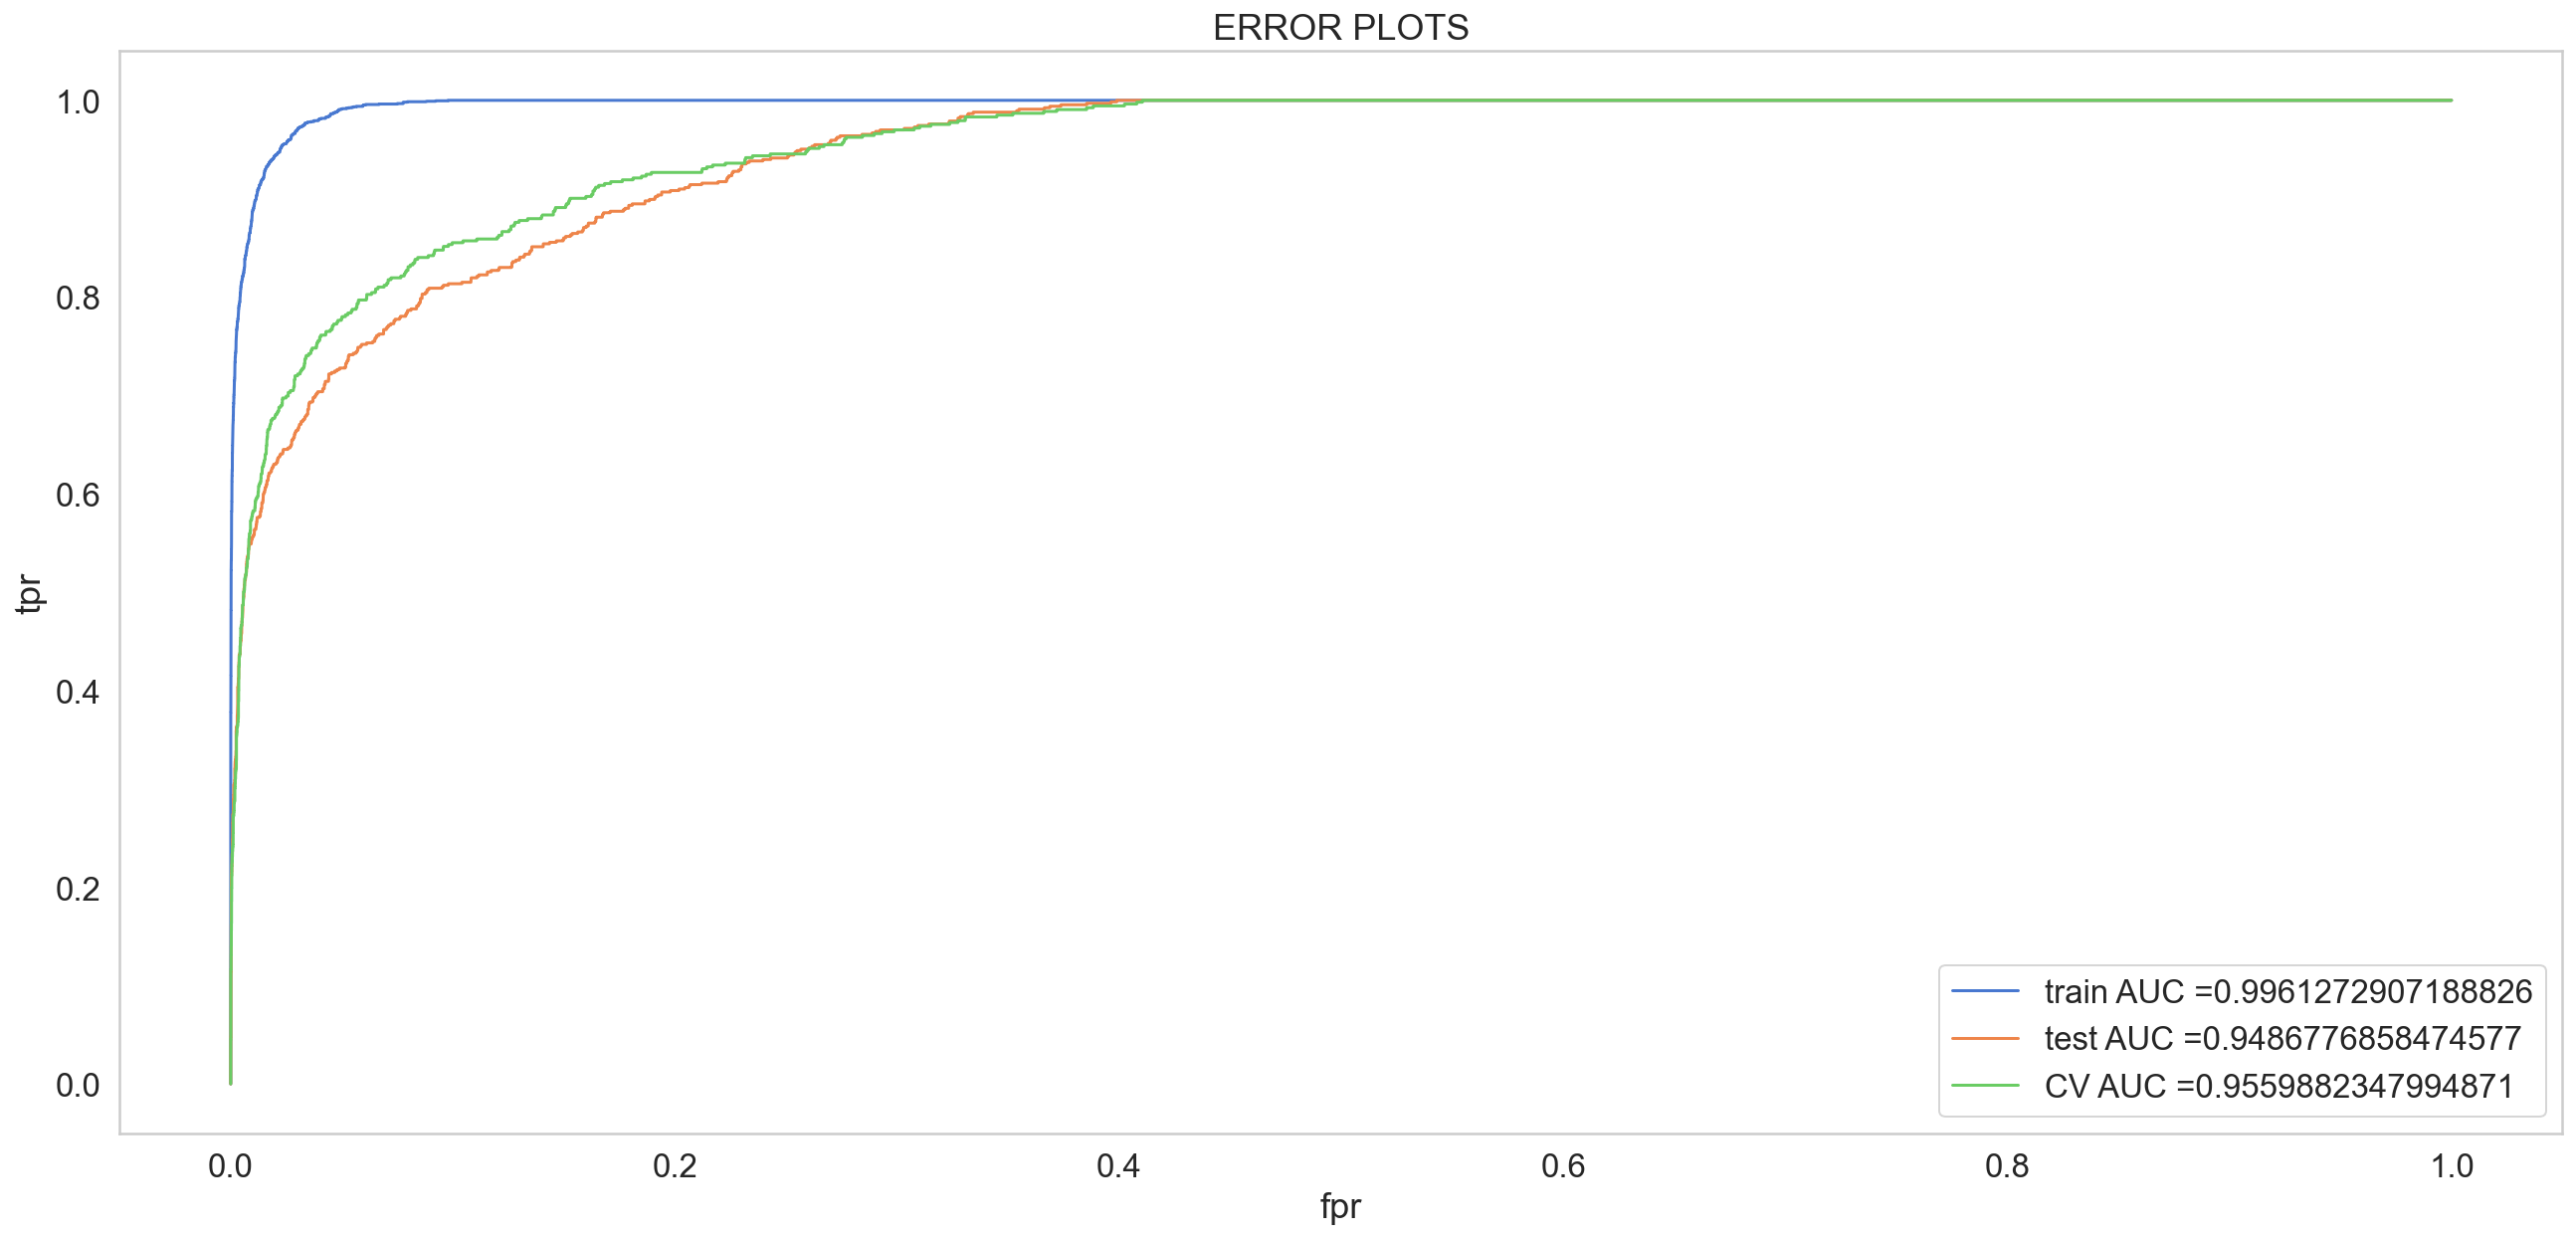

train log loss: 0.13714102633131023
test log loss: 0.11095831830651
cv log loss: 0.12286193480605721
                                                                                                    
........................................ Class Report ........................................
                                                                                                    
-------------------- Train Data ------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     77256
           1       0.90      0.75      0.82      2126

    accuracy                           0.99     79382
   macro avg       0.94      0.87      0.91     79382
weighted avg       0.99      0.99      0.99     79382

-------------------- Test Data --------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     24142
           1       0.70      0.50      0.59       6

In [269]:
model = MLPClassifier(hidden_layer_sizes=(300, 150,50),
                      momentum= 0.4093353166774497,
                      learning_rate_init=0.0005637517112995401,
                      solver='lbfgs',
                      activation='relu',
                      random_state=1)
model.fit(x_train_hstack, y_train)
y_train_pred = model.predict_proba(x_train_hstack)    
y_test_pred = model.predict_proba(x_test_hstack)
y_cv_pred = model.predict_proba(x_cv_hstack)


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train.astype('int'),y_train_pred[:,1] )

test_fpr, test_tpr, te_thresholds = roc_curve(y_test.astype('int'),y_test_pred[:,1] )

cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv.astype('int'),y_cv_pred[:,1] )


plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))



plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()


predict_y = model.predict_proba(x_train_hstack)
print("train log loss:", log_loss(y_train.astype('int'), predict_y, labels=model.classes_, eps=1e-15))
predict_y = model.predict_proba(x_test_hstack)
print("test log loss:", log_loss(y_test.astype('int'), predict_y,labels=model.classes_, eps=1e-15))
predict_y = model.predict_proba(x_cv_hstack)
print("cv log loss:", log_loss(y_cv.astype('int'), predict_y,labels=model.classes_, eps=1e-15))



print(" "*100)
print("."*40,"Class Report","."*40)
print(" "*100)
print("-"*20,"Train Data","-"*30)
print( classification_report(y_train, model.predict(x_train_hstack)))
print("-"*20,"Test Data","-"*20)
print( classification_report(y_test, model.predict(x_test_hstack)))
print("-"*20,"CV Data","-"*20)
print( classification_report(y_cv, model.predict(x_cv_hstack)))

# XGBCLASSIFIER

## XGB - Hyperparameter Tunning

In [149]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score


def objective(trial):
   
    
    #n_estimators = trial.suggest_int("n_estimators", 200,5000)    
    max_depth = trial.suggest_int("max_depth", 2, 55, log=True)  
    min_child_weight = trial.suggest_int("min_child_weight", 2, 10)
    eta = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    gamma = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    grow_policy = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide",])
    sample_type = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
    normalize_type = trial.suggest_categorical("normalize_type", ["tree", "forest"])
    rate_drop = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
    skip_drop = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    eval_metric = trial.suggest_categorical("eval_metric", ["logloss", "auc"])
    
    rf =  xgb.XGBClassifier(
                            max_depth=max_depth,
                           gamma=gamma,
                           grow_policy=grow_policy,
                           sample_type=sample_type,
                           eval_metric=eval_metric)

    score = cross_val_score(rf, x_train_hstack, y_train, n_jobs=-1, cv=20)
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2022-03-11 13:37:33,147] A new study created in memory with name: no-name-fcde7dd0-26ad-4a3c-be43-ab0586862452


KeyboardInterrupt: ignored

In [ ]:
# 3 trials
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.9910811076954061
Best hyperparameters: {'max_depth': 16, 'min_child_weight': 3, 'eta': 3.9991155066390645e-08, 'gamma': 6.596131564270215e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00042263159393227687, 'skip_drop': 2.1548855201761578e-05, 'eval_metric': 'auc'}


In [1]:
#Trial 0 finished with value: 0.9917991766162573 and parameters: {'max_depth': 41, 'min_child_weight': 3, 'eta': 0.027705169657251977, 'gamma': 0.2257431270789662, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.392113423372014, 'skip_drop': 3.585444655395307e-07, 'eval_metric': 'auc'}. Best is trial 0 with value: 0.9917991766162573.
#Trial 69 finished with value: 0.9918243750527547 and parameters: {'max_depth': 35, 'min_child_weight': 7, 'eta': 0.1147070598828235, 'gamma': 3.5798043161140585e-06, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.5408870850508847, 'skip_drop': 1.2931058805660557e-06, 'eval_metric': 'auc'}. Best is trial 69 with value: 0.9918243750527547.

## XGB - AUC and Confusion Matrix

[20:18:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_master/src/learner.cc:572: 
Parameters: { "normalize_type", "rate_drop", "sample_type", "skip_drop" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




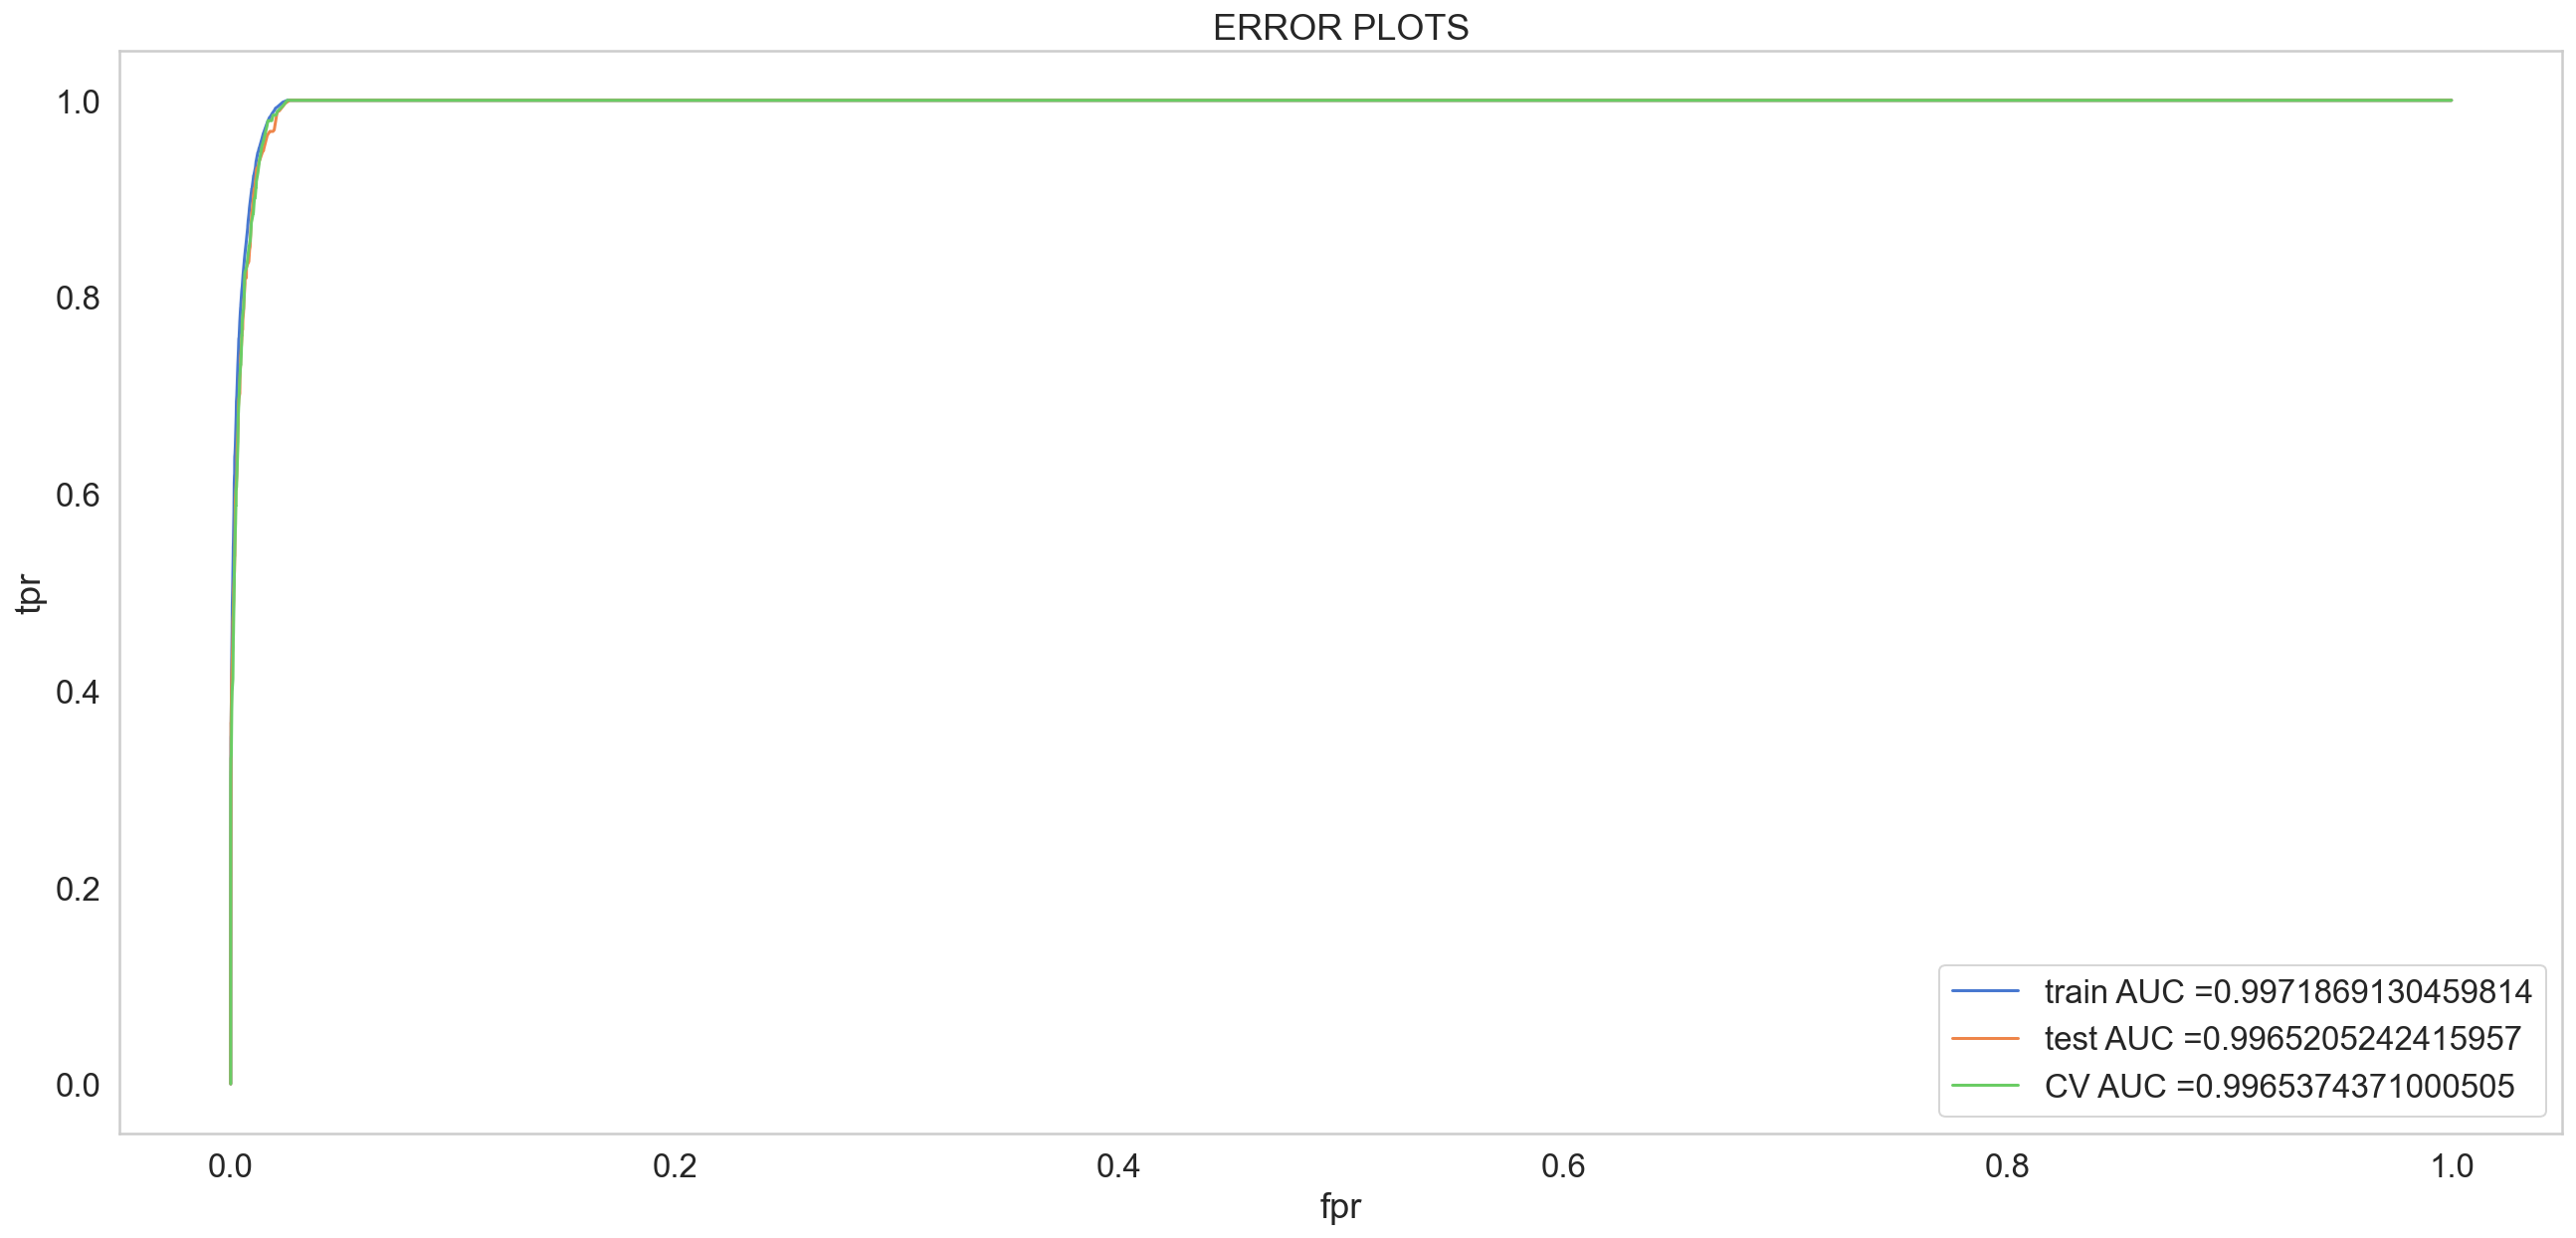

_train__train__train__train__train__train__train__train__train__train_
-------------------- Confusion matrix --------------------


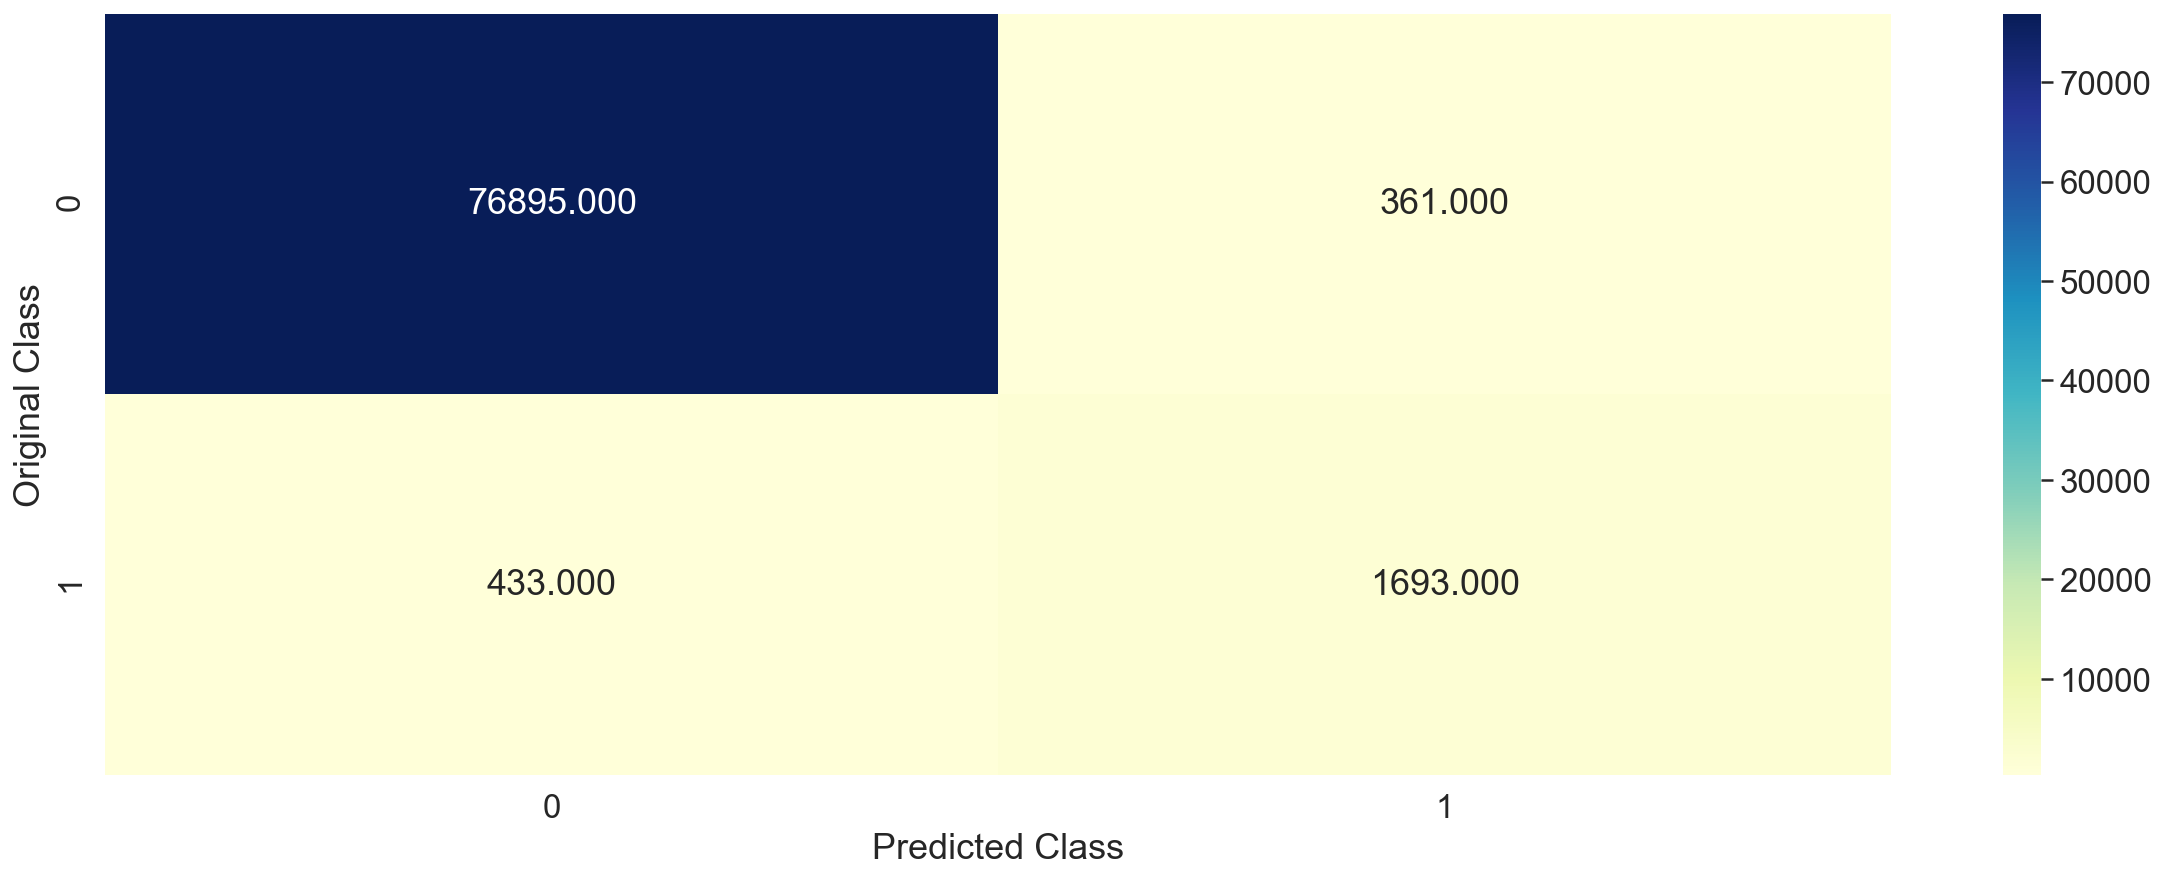

-------------------- Precision matrix (Columm Sum=1) --------------------


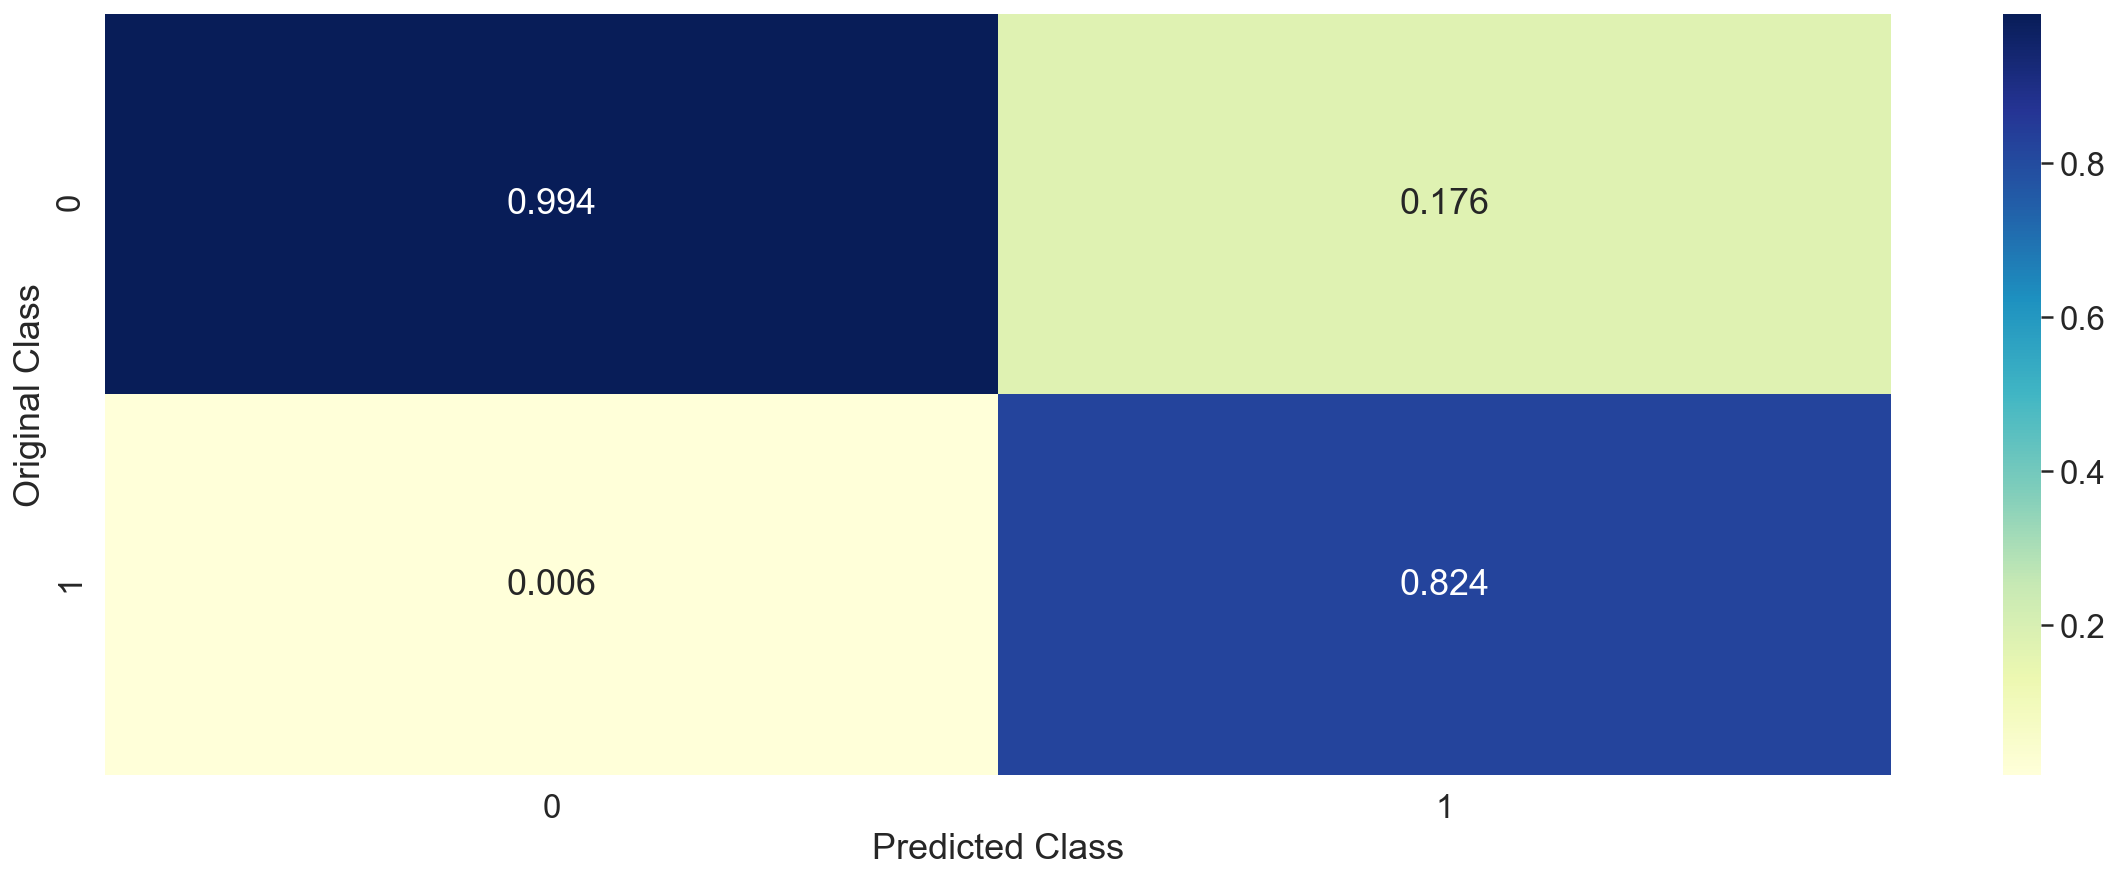

-------------------- Recall matrix (Row sum=1) --------------------


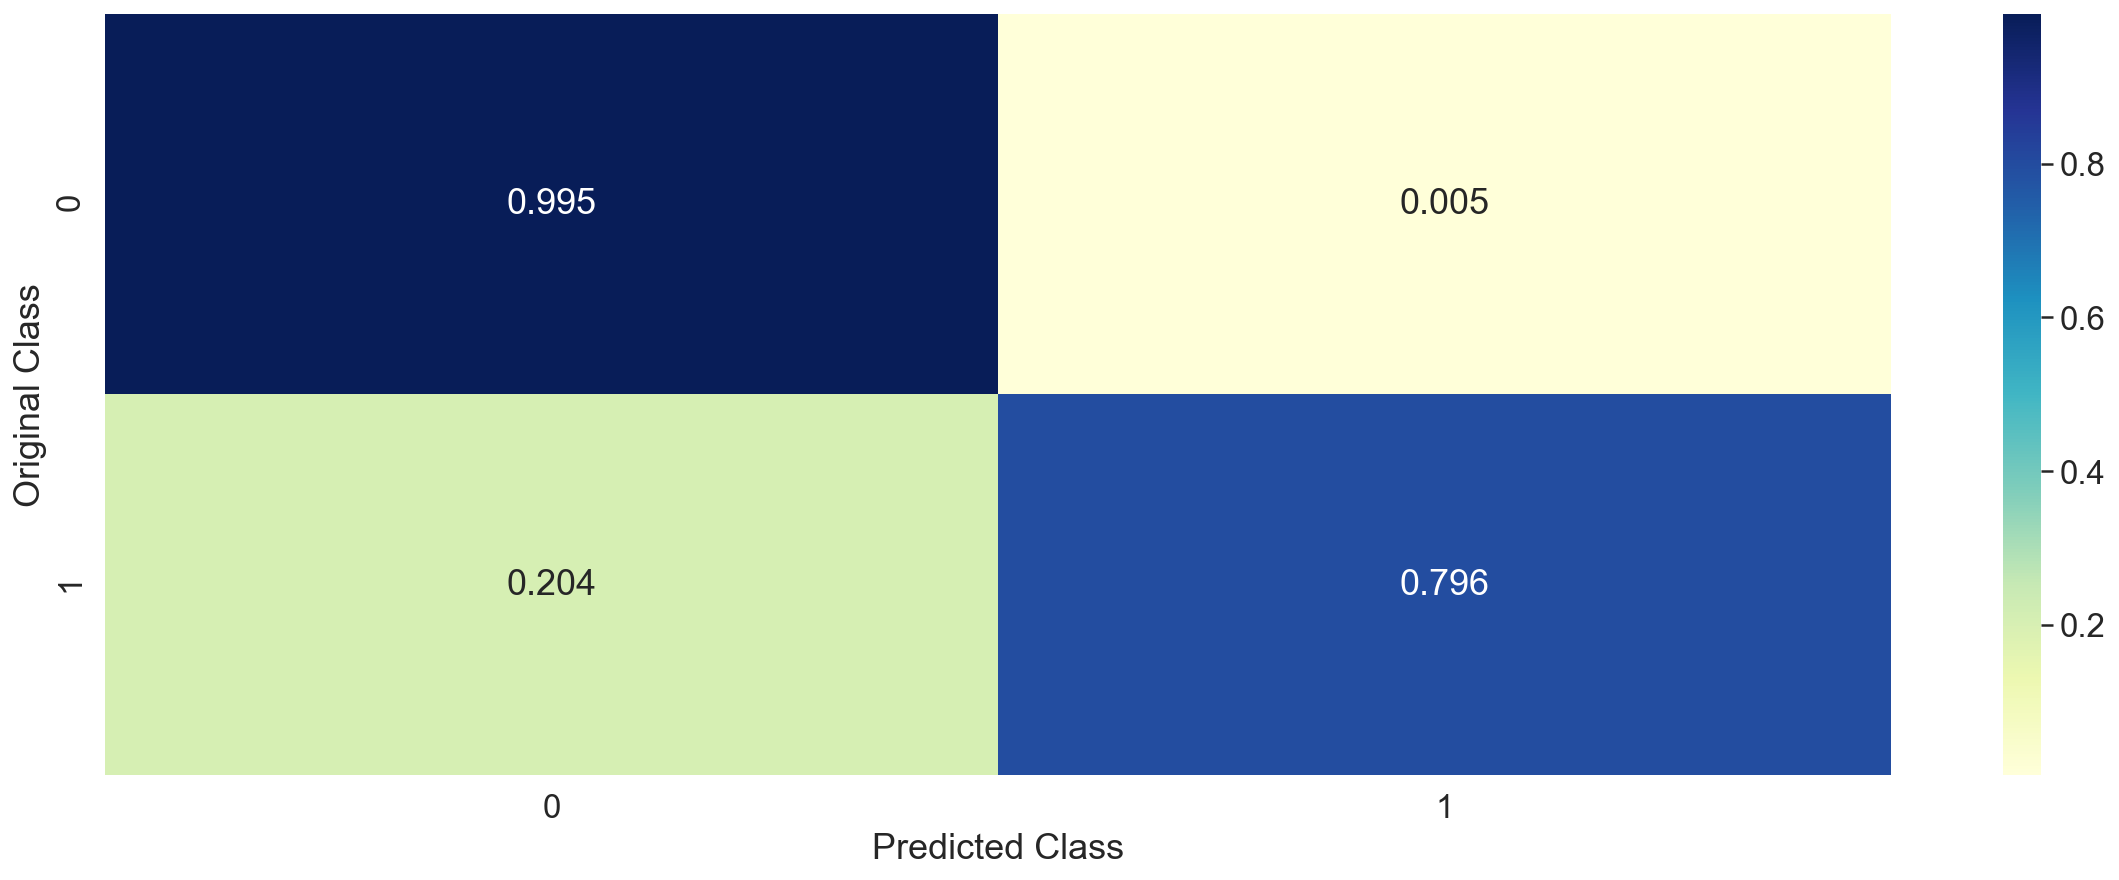

_test__test__test__test__test__test__test__test__test__test_
-------------------- Confusion matrix --------------------


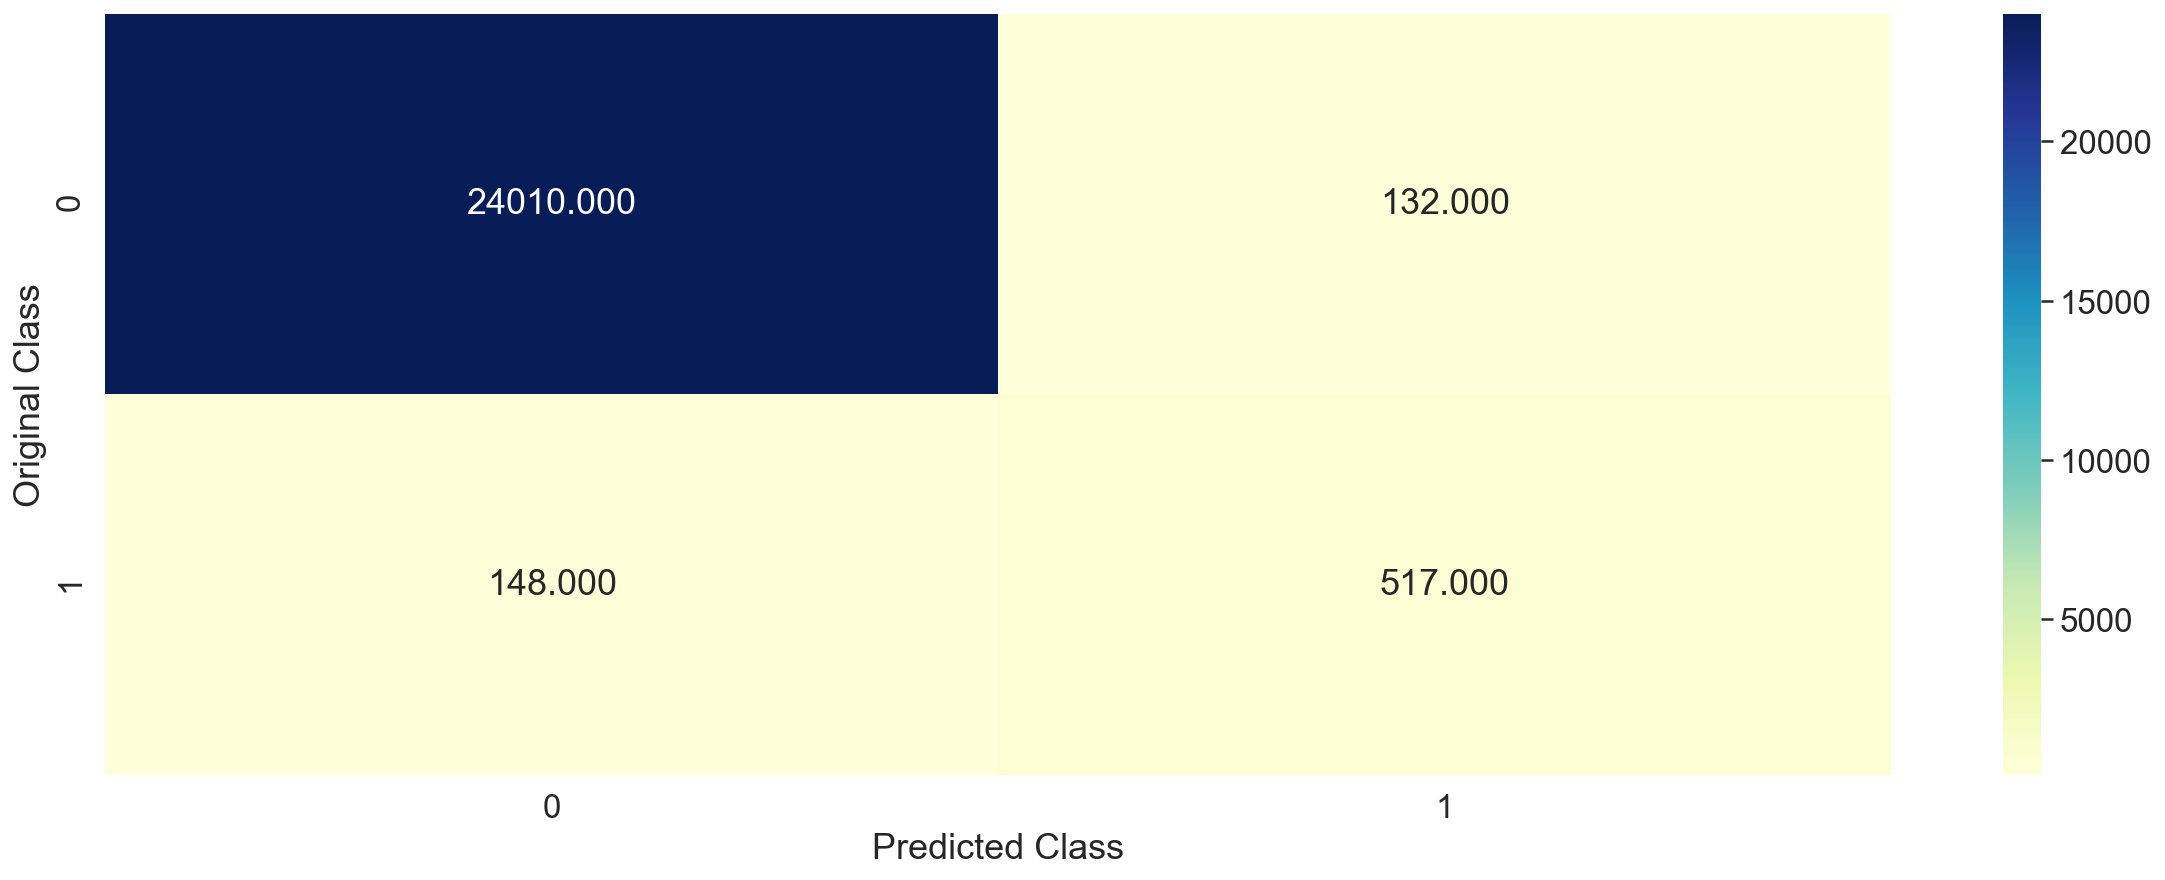

-------------------- Precision matrix (Columm Sum=1) --------------------


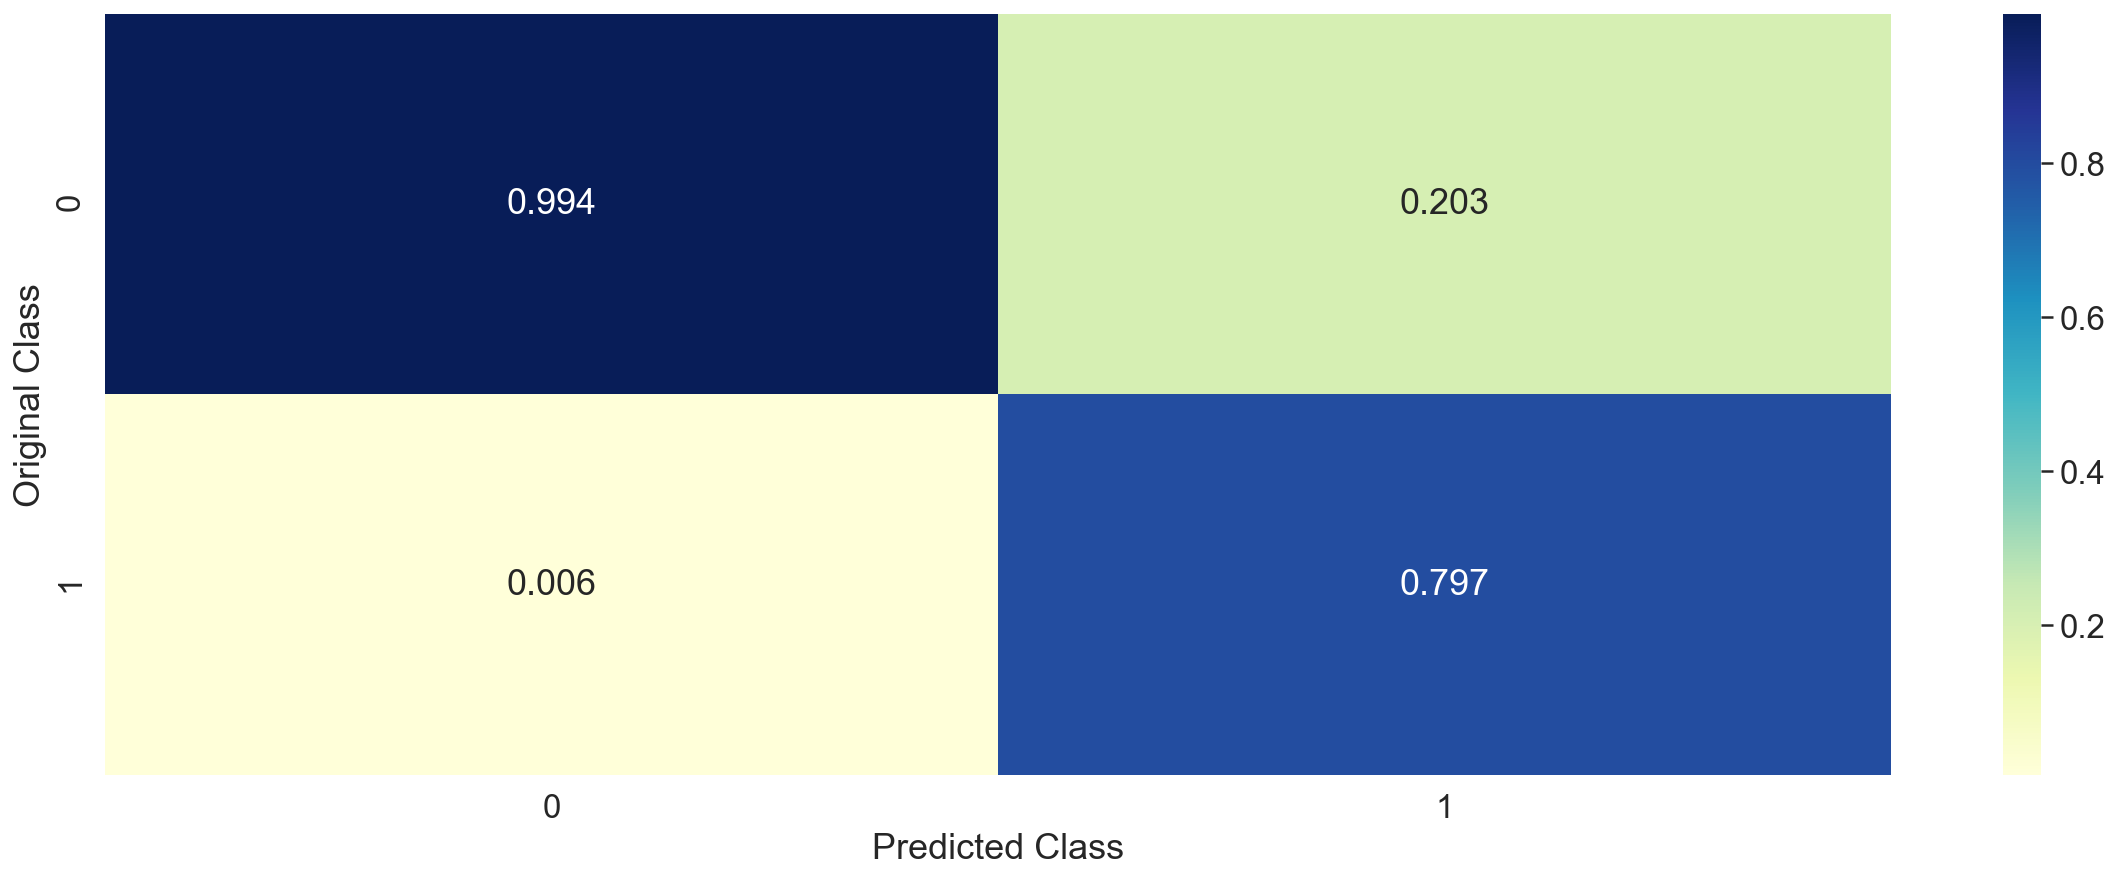

-------------------- Recall matrix (Row sum=1) --------------------


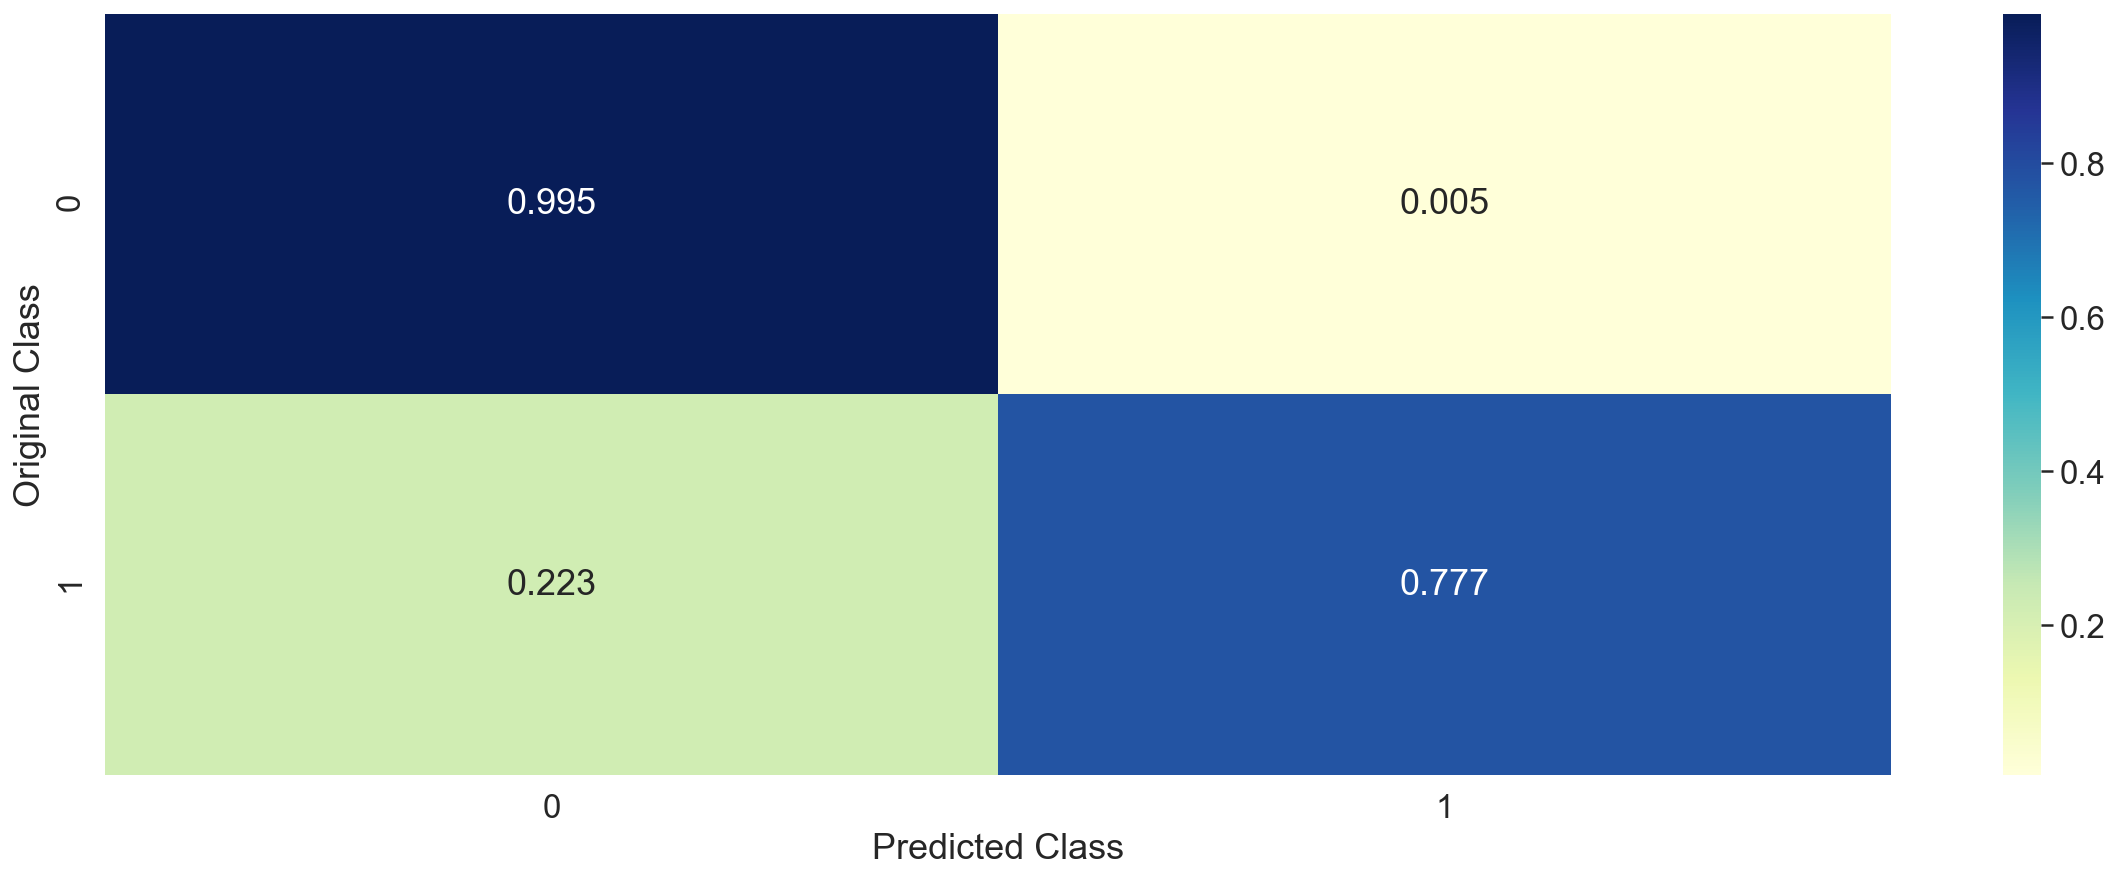

_cv__cv__cv__cv__cv__cv__cv__cv__cv__cv_
-------------------- Confusion matrix --------------------


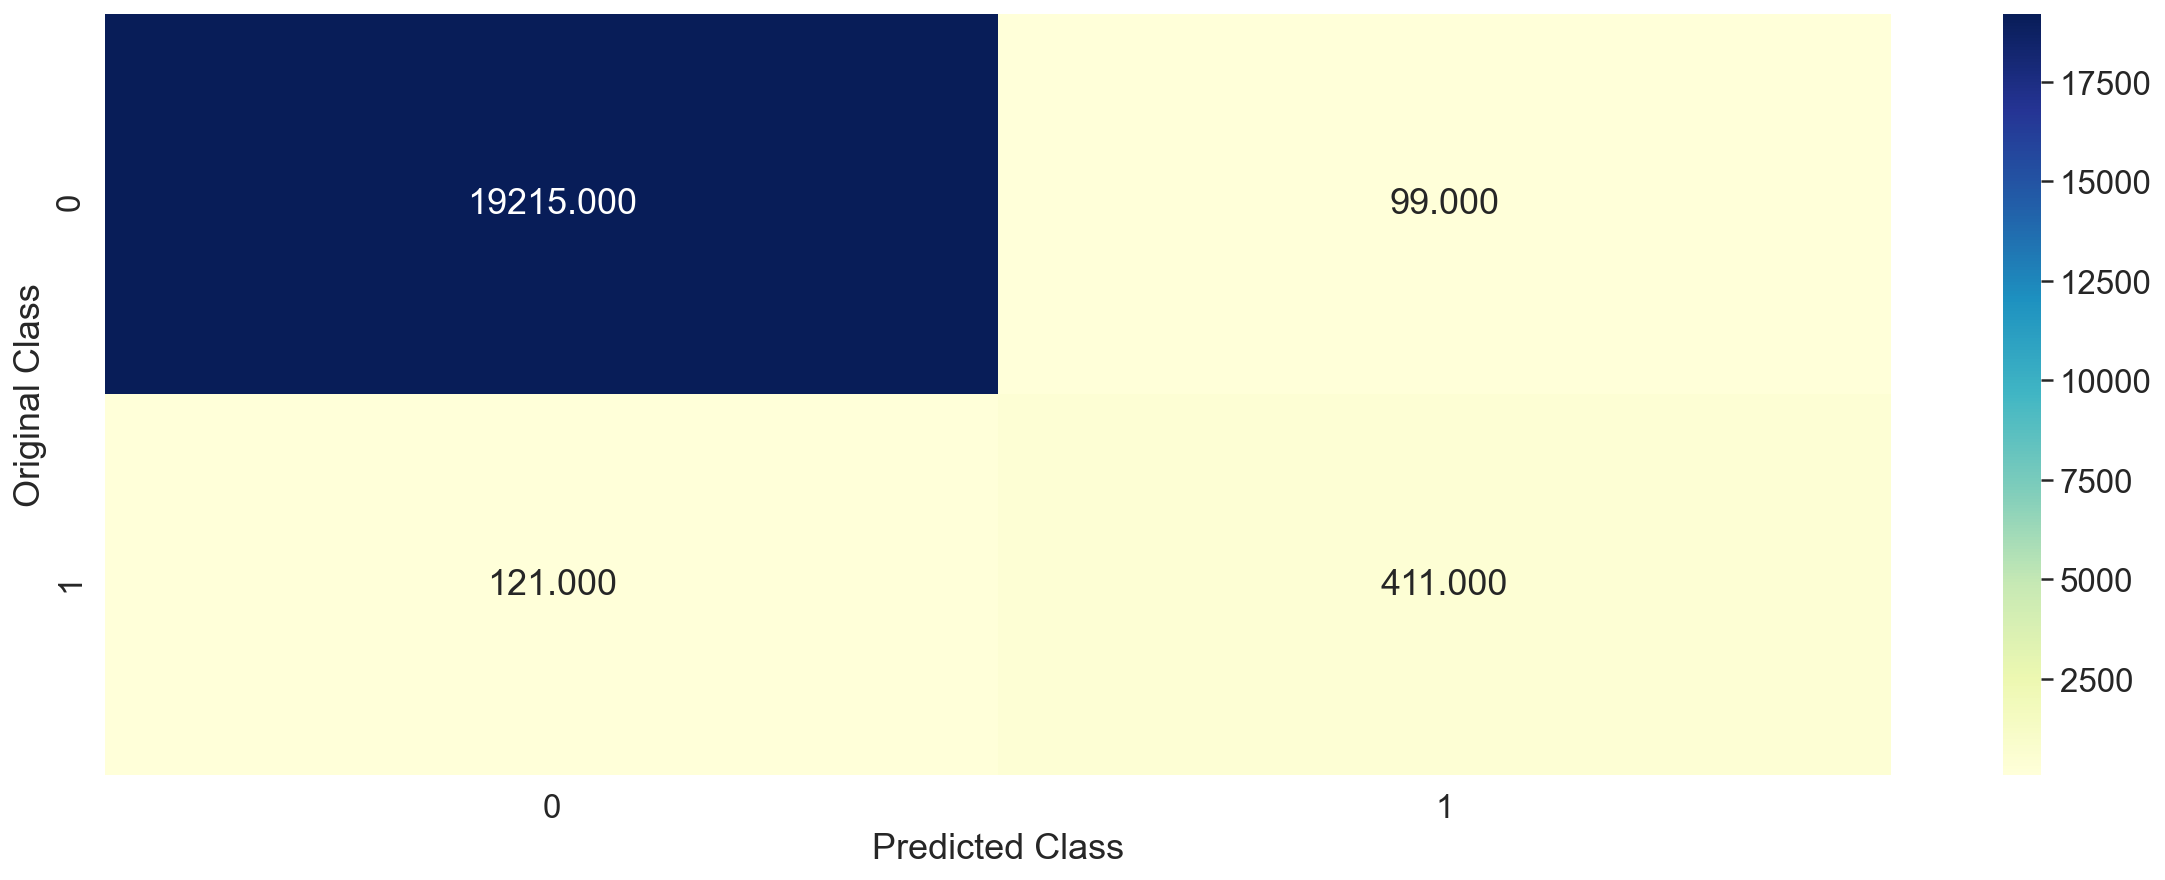

-------------------- Precision matrix (Columm Sum=1) --------------------


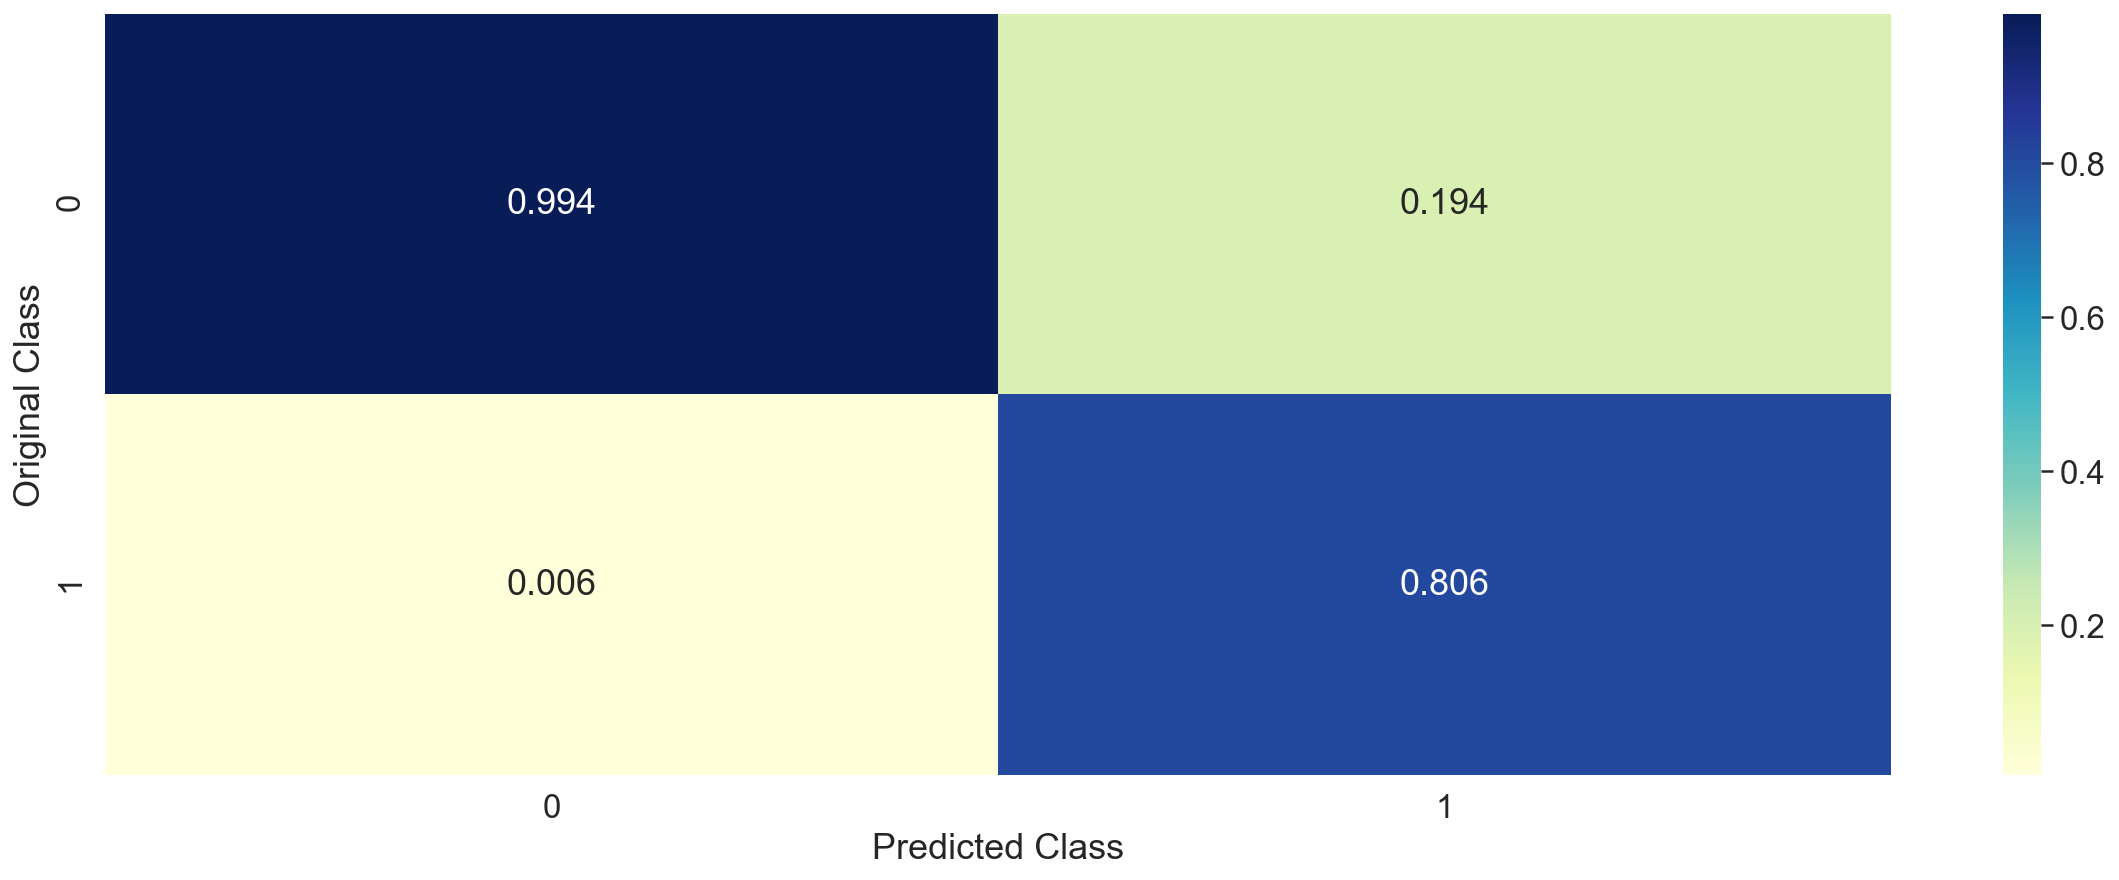

-------------------- Recall matrix (Row sum=1) --------------------


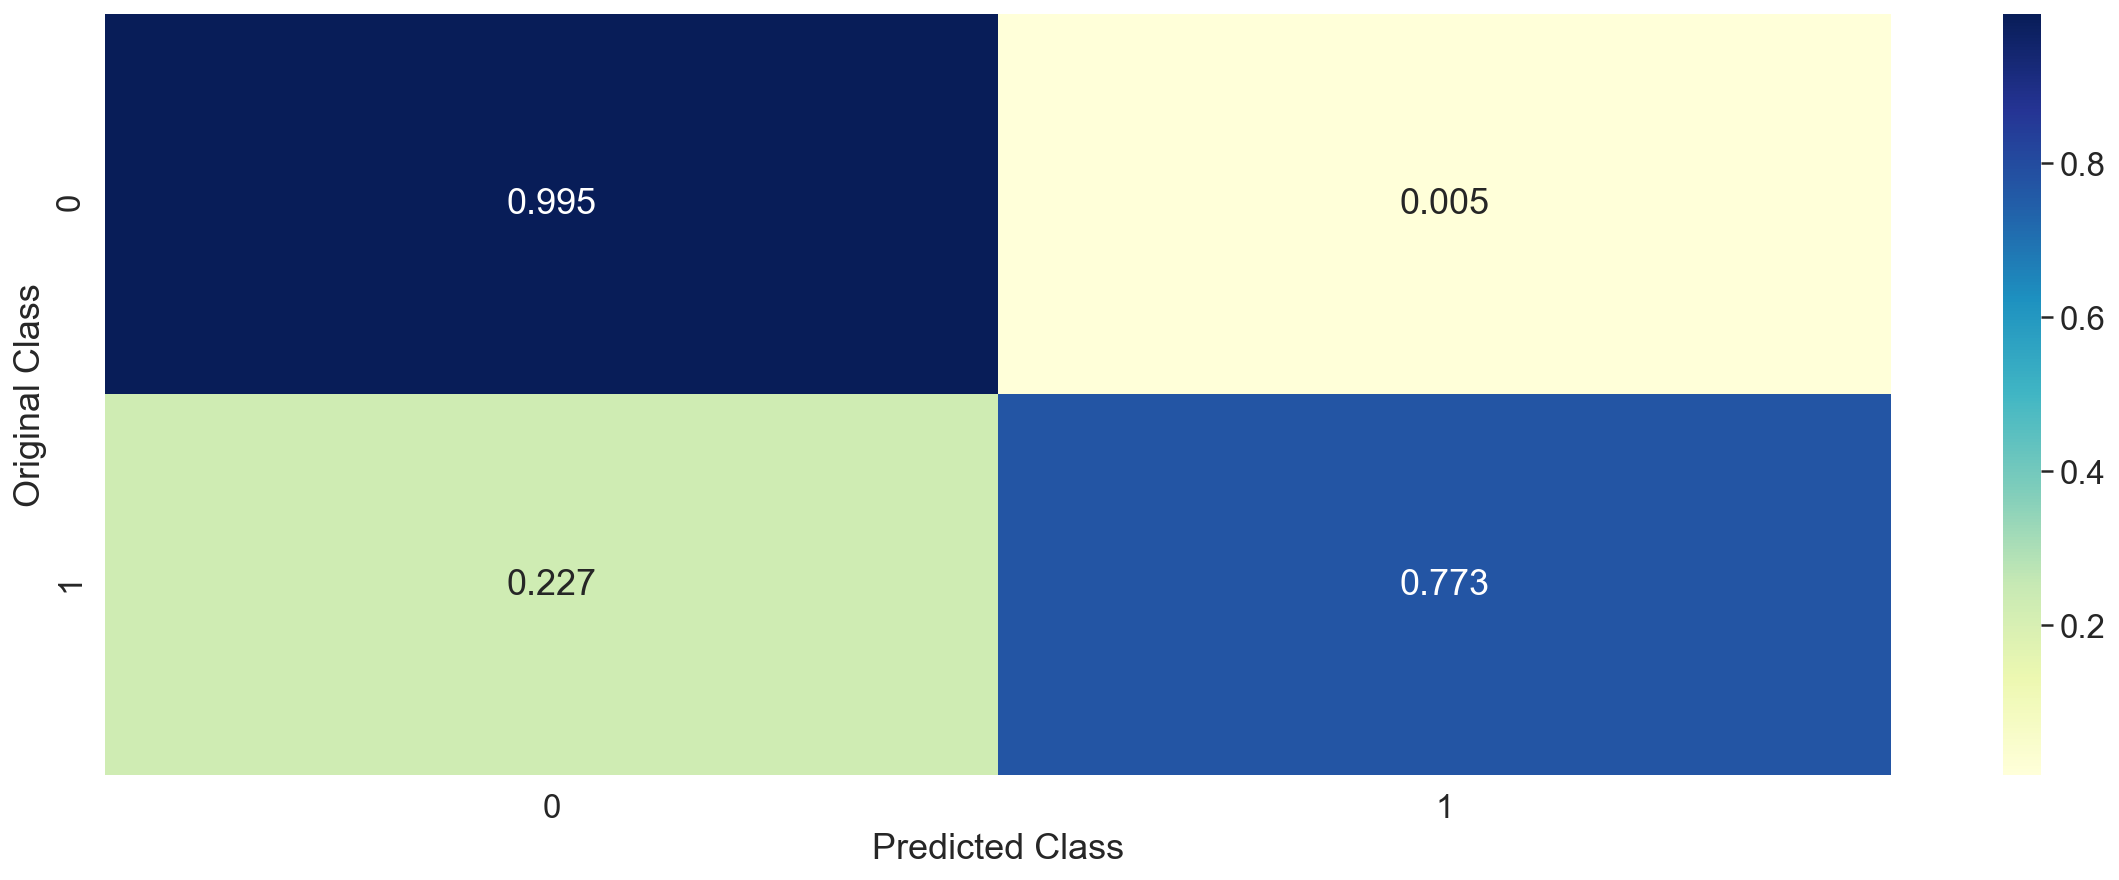

array([[19215,    99],
       [  121,   411]], dtype=int64)

In [204]:
from sklearn.metrics import roc_curve, auc


import xgboost as xgb
import matplotlib.pyplot as plt
model = xgb.XGBClassifier(max_depth=36,
                          min_child_weight=8,
                          eta=0.0023695415426639743,
                          gamma=0.25894750481549217,
                          grow_policy='depthwise',
                          sample_type ='uniform', 
                          normalize_type='forest',                          
                          rate_drop =8.516917973765619e-05,
                          skip_drop = 5.650997820517849e-06,
                          eval_metric = 'auc',
                          random_state=0, 
                          n_jobs=-1)
model.fit(x_train_hstack, y_train)

y_train_pred = model.predict_proba(x_train_hstack)    
y_test_pred = model.predict_proba(x_test_hstack)
y_cv_pred = model.predict_proba(x_cv_hstack)


train_fpr, train_tpr, tr_thresholds = roc_curve(y_train.astype(int),y_train_pred[:,1])

test_fpr, test_tpr, te_thresholds = roc_curve(y_test.astype(int),y_test_pred[:,1])

cv_fpr, cv_tpr, cv_thresholds = roc_curve(y_cv.astype(int),y_cv_pred[:,1])



plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))



plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

print('_train_'*10)
plot_confusion_matrix(y_train, model.predict(x_train_hstack))
confusion_matrix(y_train, model.predict(x_train_hstack))


print('_test_'*10)
plot_confusion_matrix(y_test,  model.predict(x_test_hstack))
confusion_matrix(y_test,  model.predict(x_test_hstack))

print('_cv_'*10)
plot_confusion_matrix(y_cv, model.predict(x_cv_hstack))
confusion_matrix(y_cv, model.predict(x_cv_hstack))


In [ ]:
# 3 trials
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.9918495734892521
Best hyperparameters: {'max_depth': 36, 'min_child_weight': 8, 'eta': 0.0023695415426639743, 'gamma': 0.25894750481549217, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 8.516917973765619e-05, 'skip_drop': 5.650997820517849e-06, 'eval_metric': 'auc'}


## XGB - LogLoss and Classification Report

train log loss: 0.017453972300465324
test log loss: 0.02090879986467069
cv log loss: 0.02108367085277292
                                                                                                    
........................................ Class Report ........................................
                                                                                                    
-------------------- Train Data ------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     77256
           1       0.87      0.84      0.85      2126

    accuracy                           0.99     79382
   macro avg       0.93      0.92      0.93     79382
weighted avg       0.99      0.99      0.99     79382

-------------------- Test Data --------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     24142
           1       0.83      0.81      0.82    

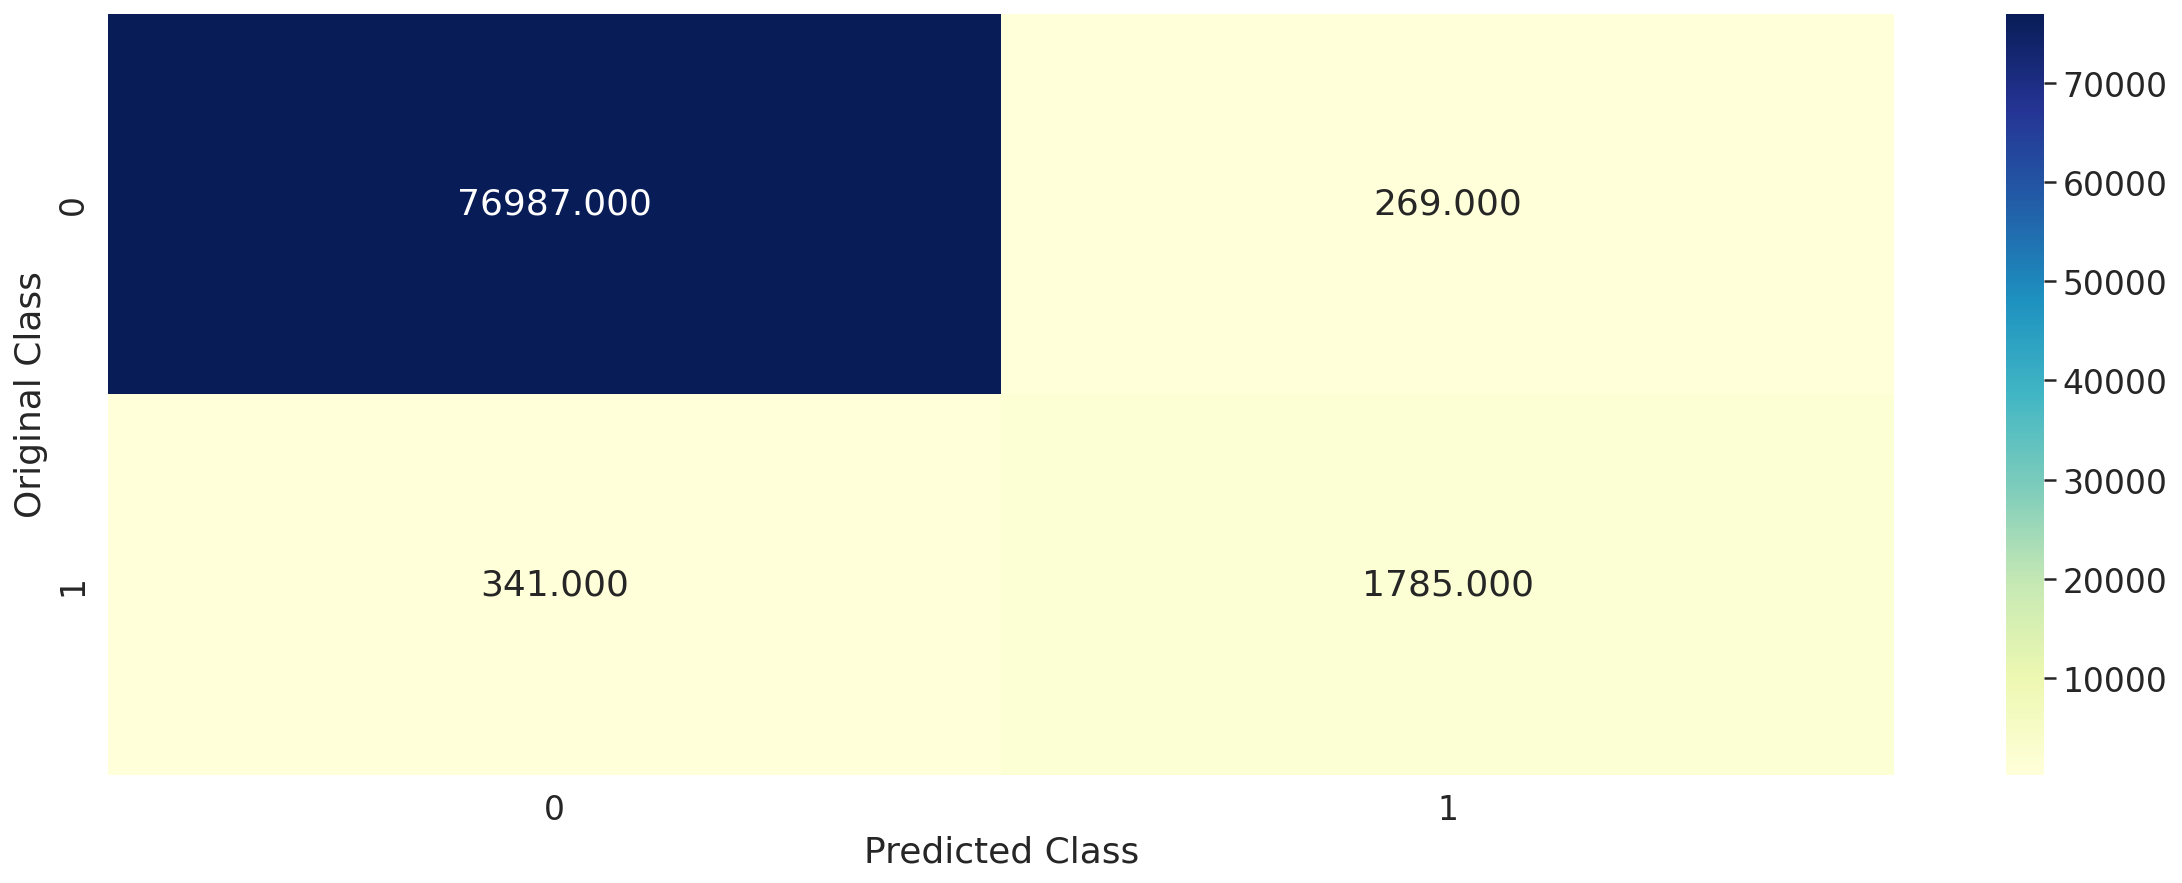

-------------------- Precision matrix (Columm Sum=1) --------------------


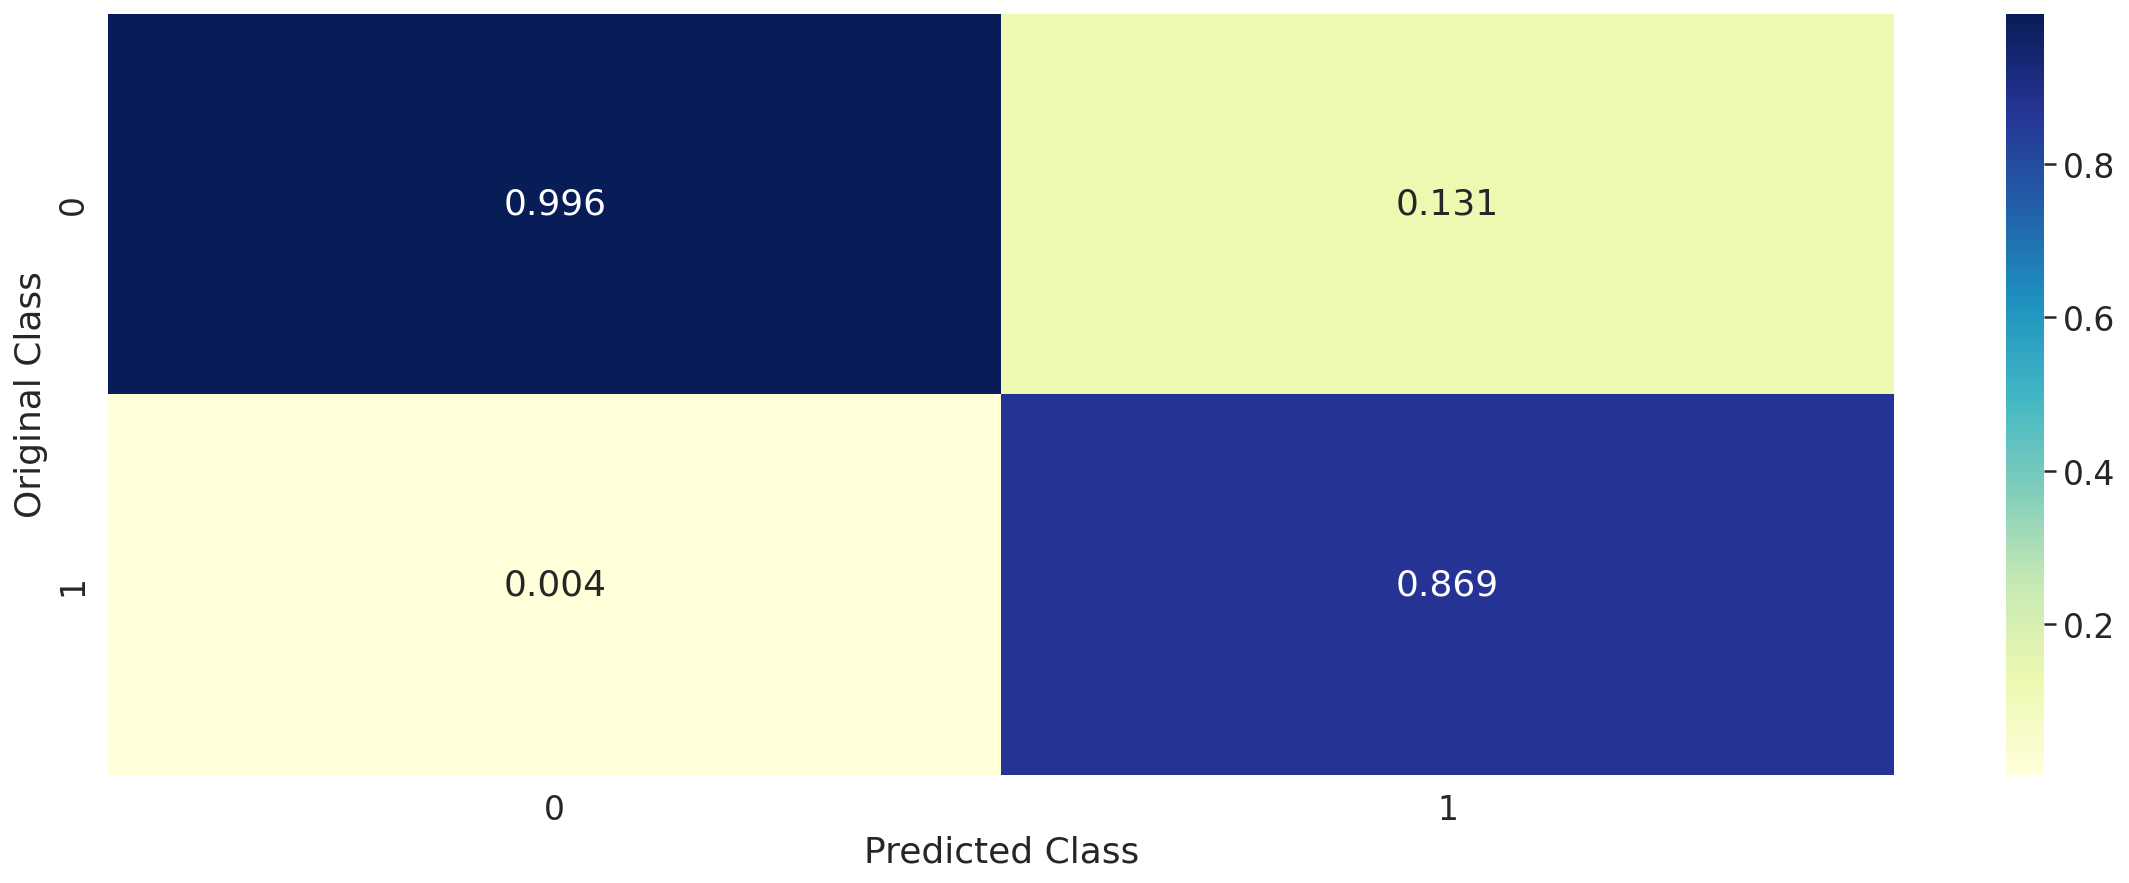

-------------------- Recall matrix (Row sum=1) --------------------


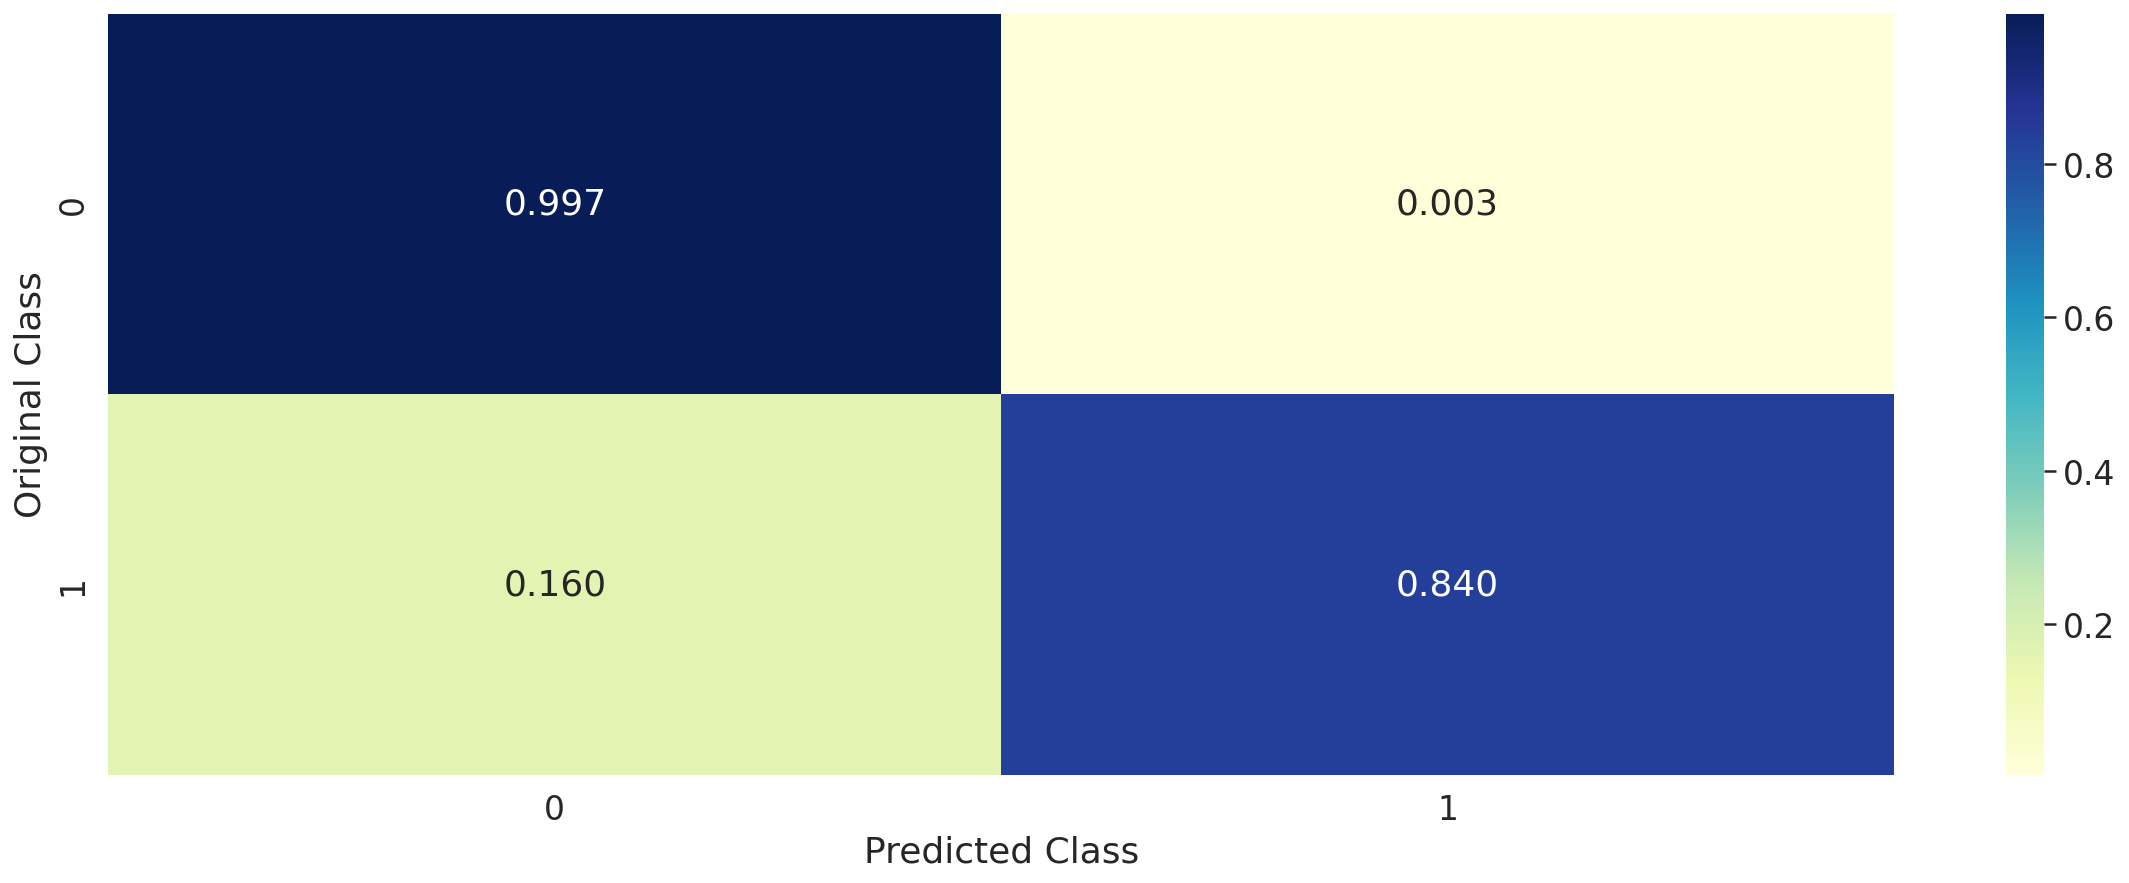

_test__test__test__test__test__test__test__test__test__test_
-------------------- Confusion matrix --------------------


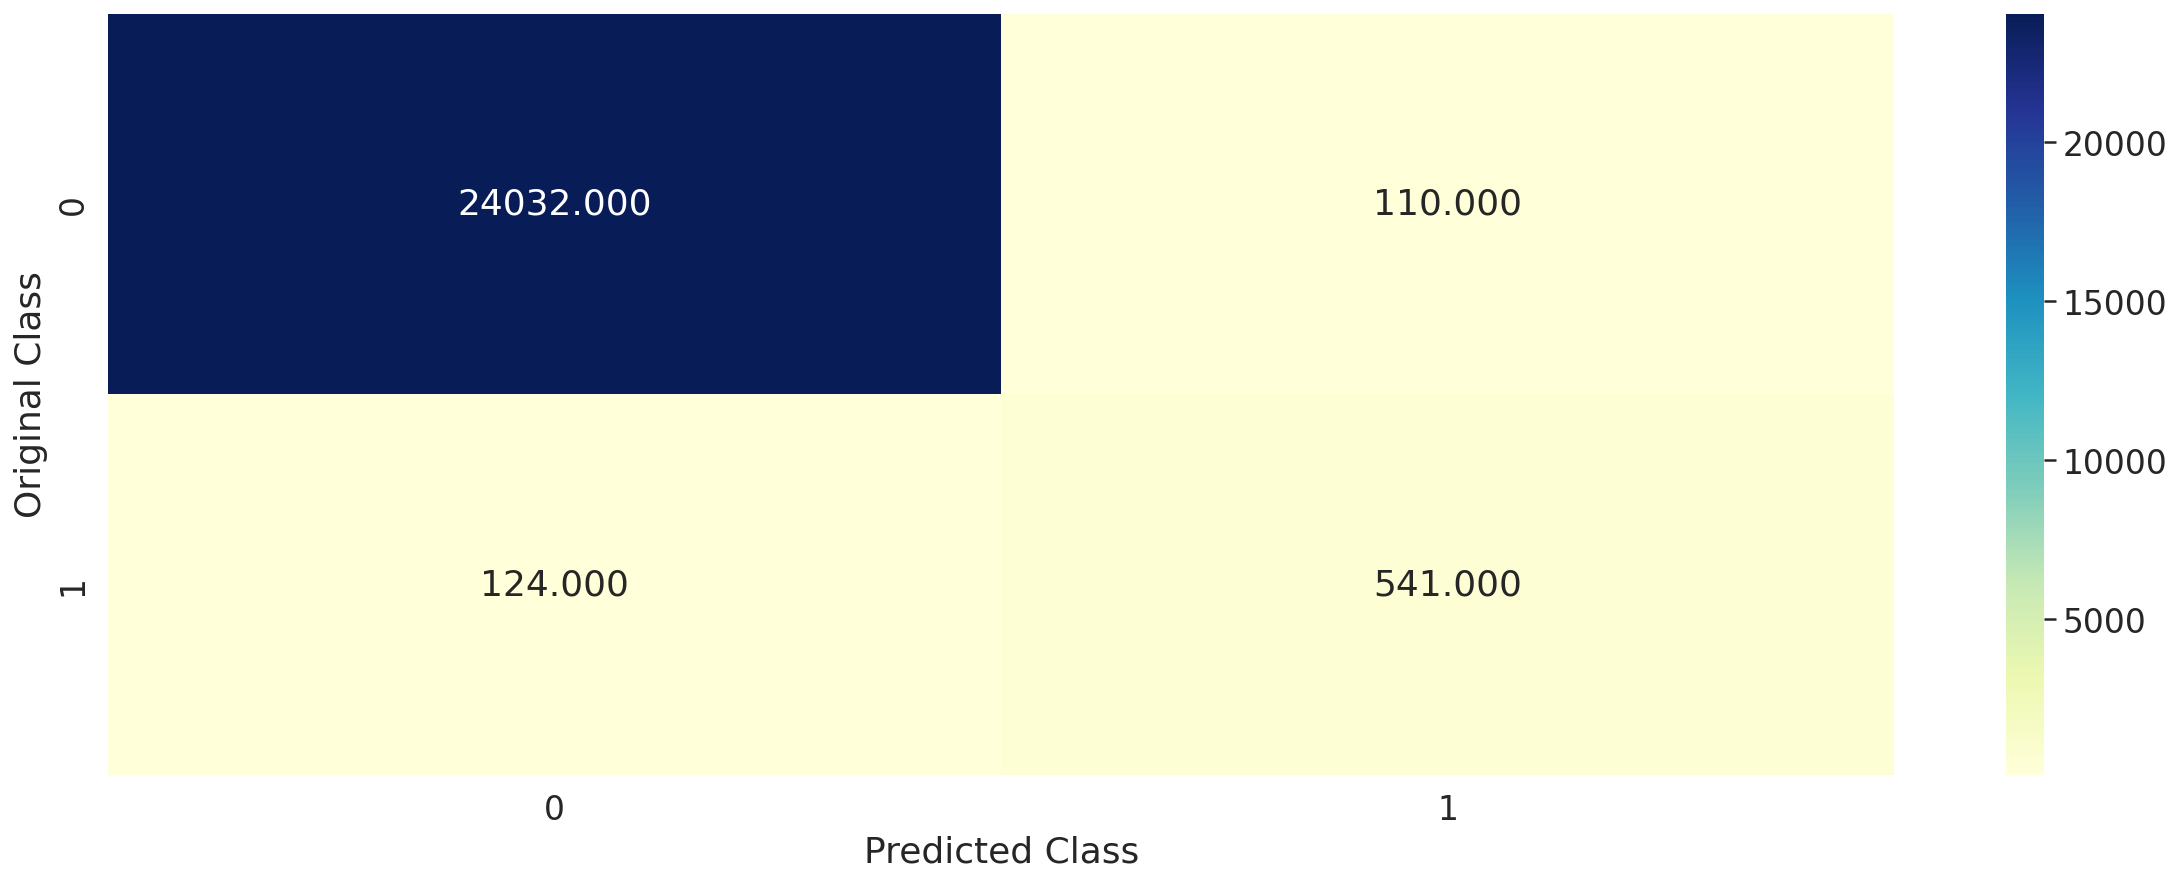

-------------------- Precision matrix (Columm Sum=1) --------------------


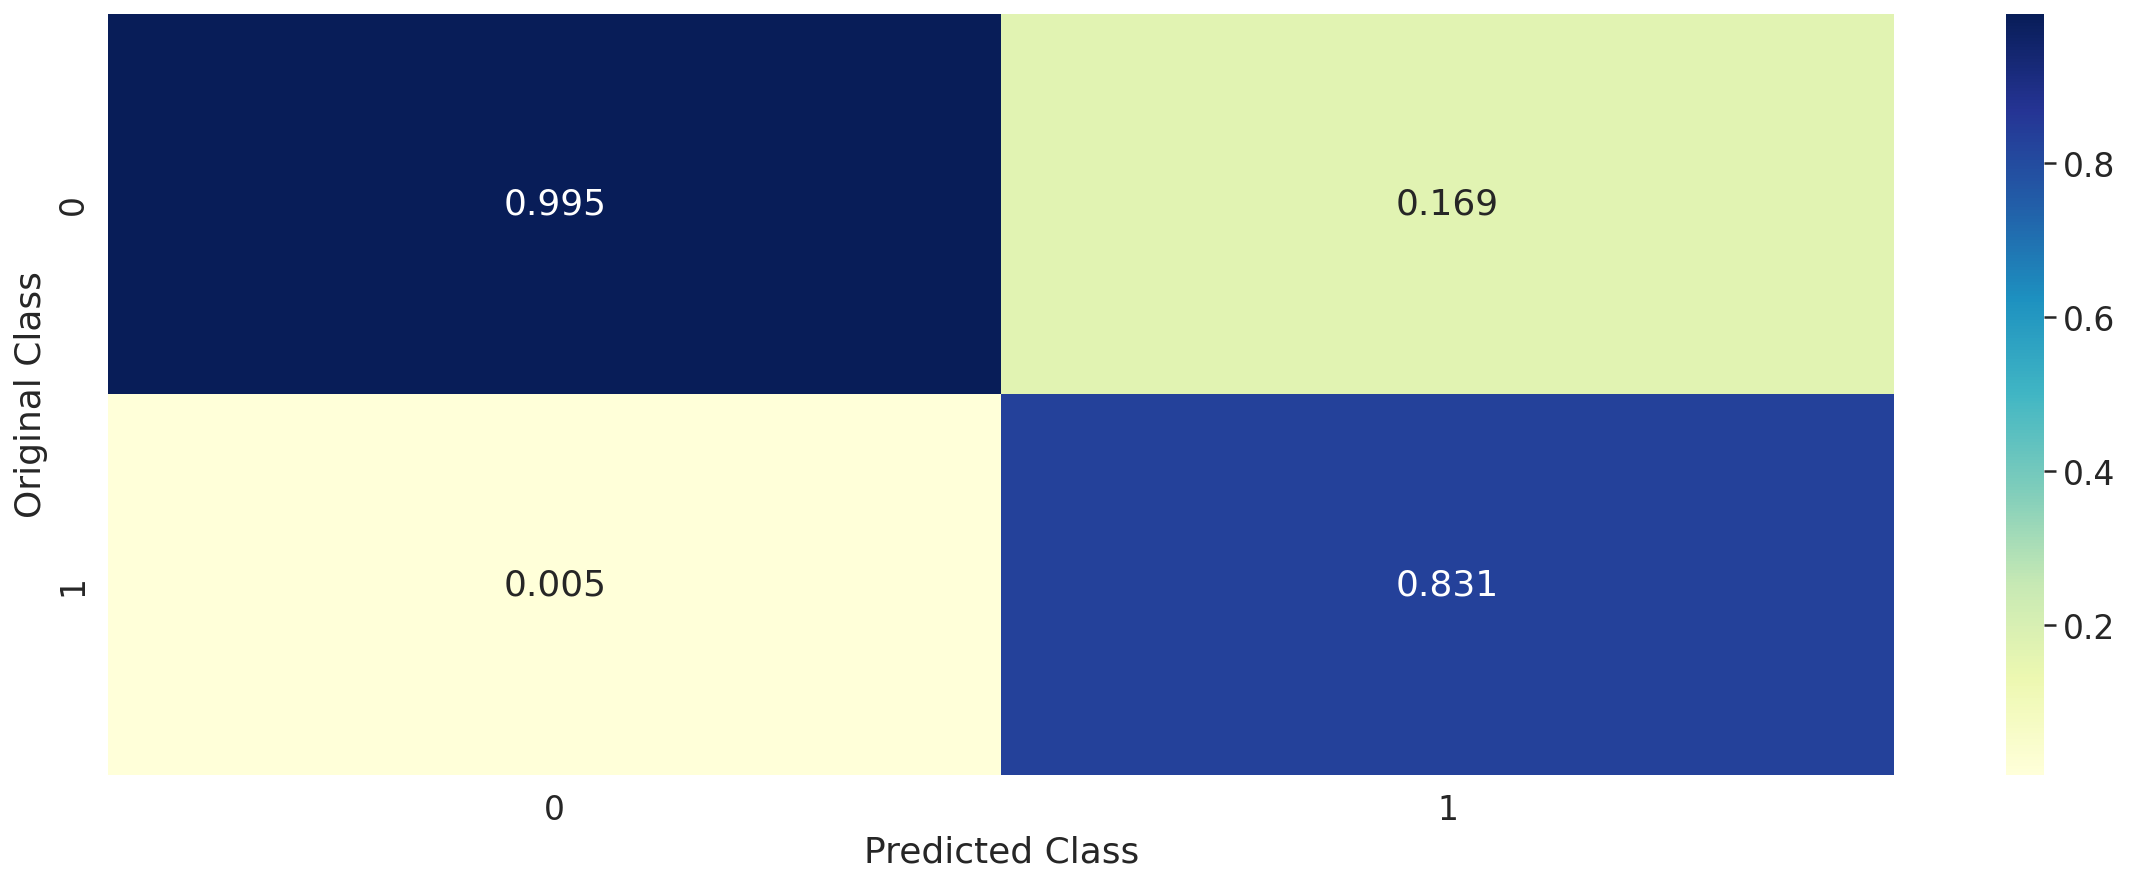

-------------------- Recall matrix (Row sum=1) --------------------


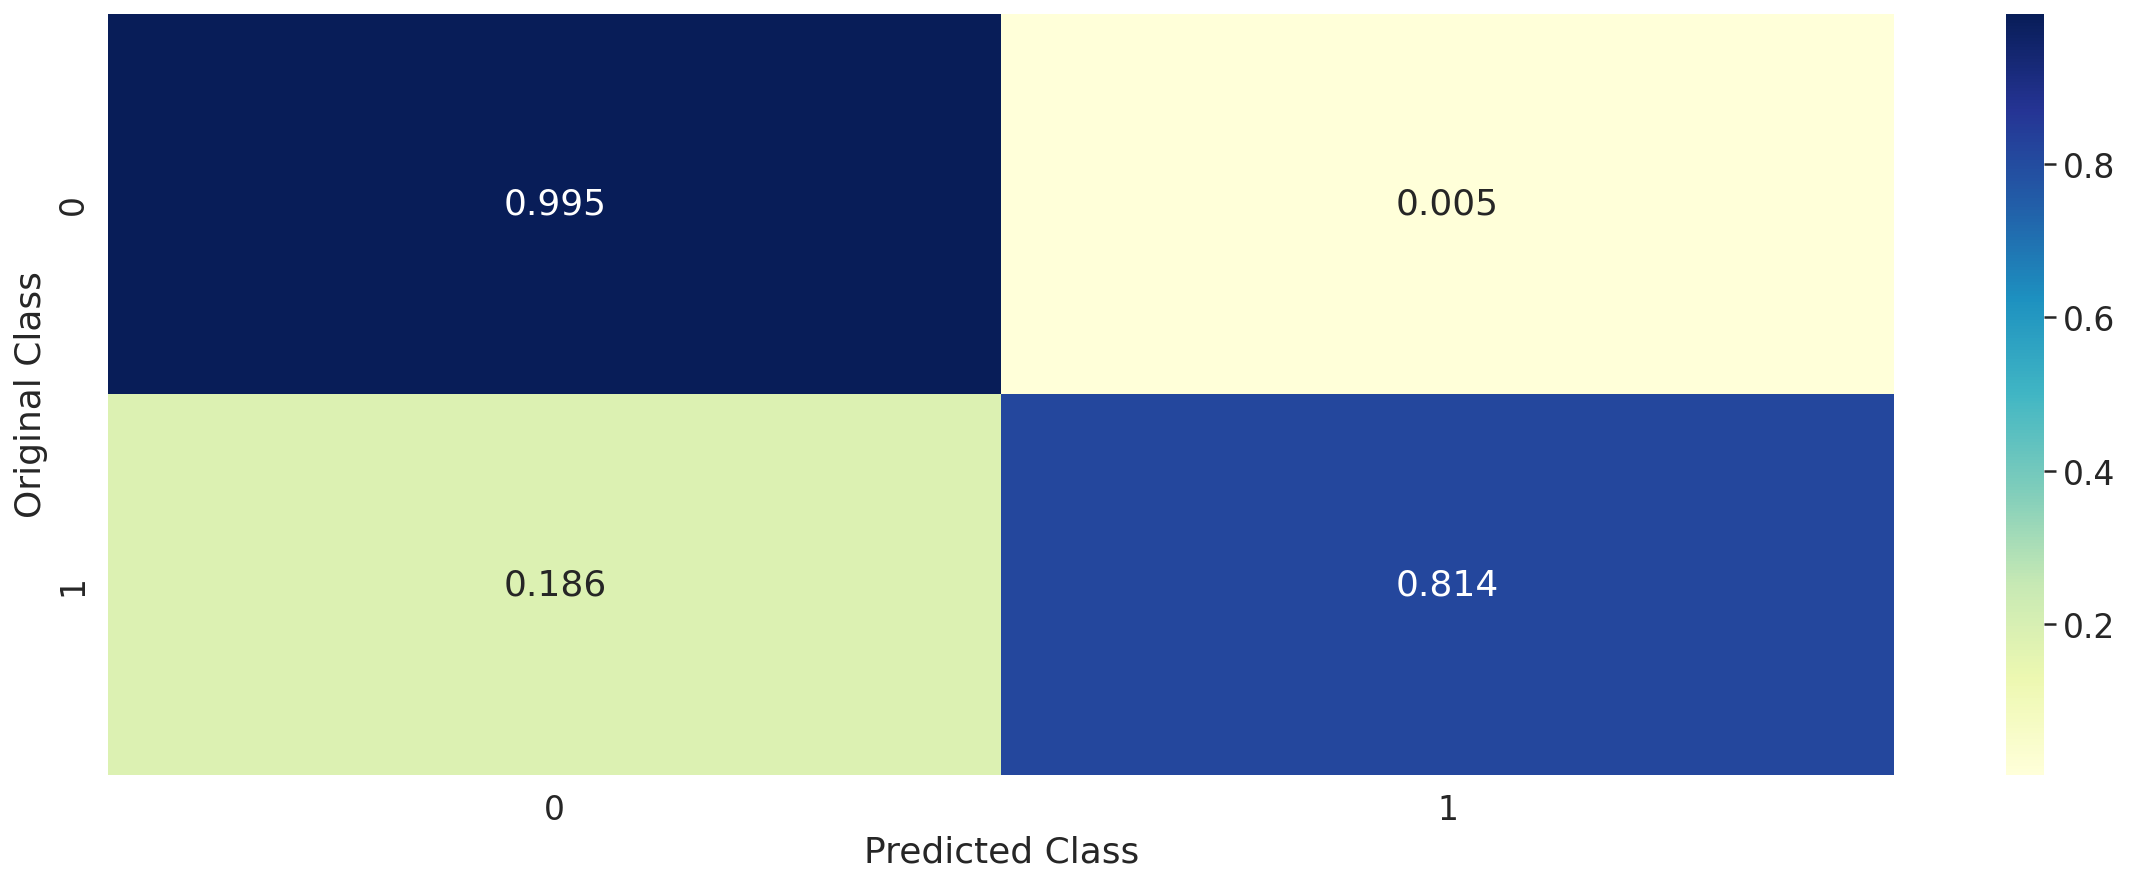

_cv__cv__cv__cv__cv__cv__cv__cv__cv__cv_
-------------------- Confusion matrix --------------------


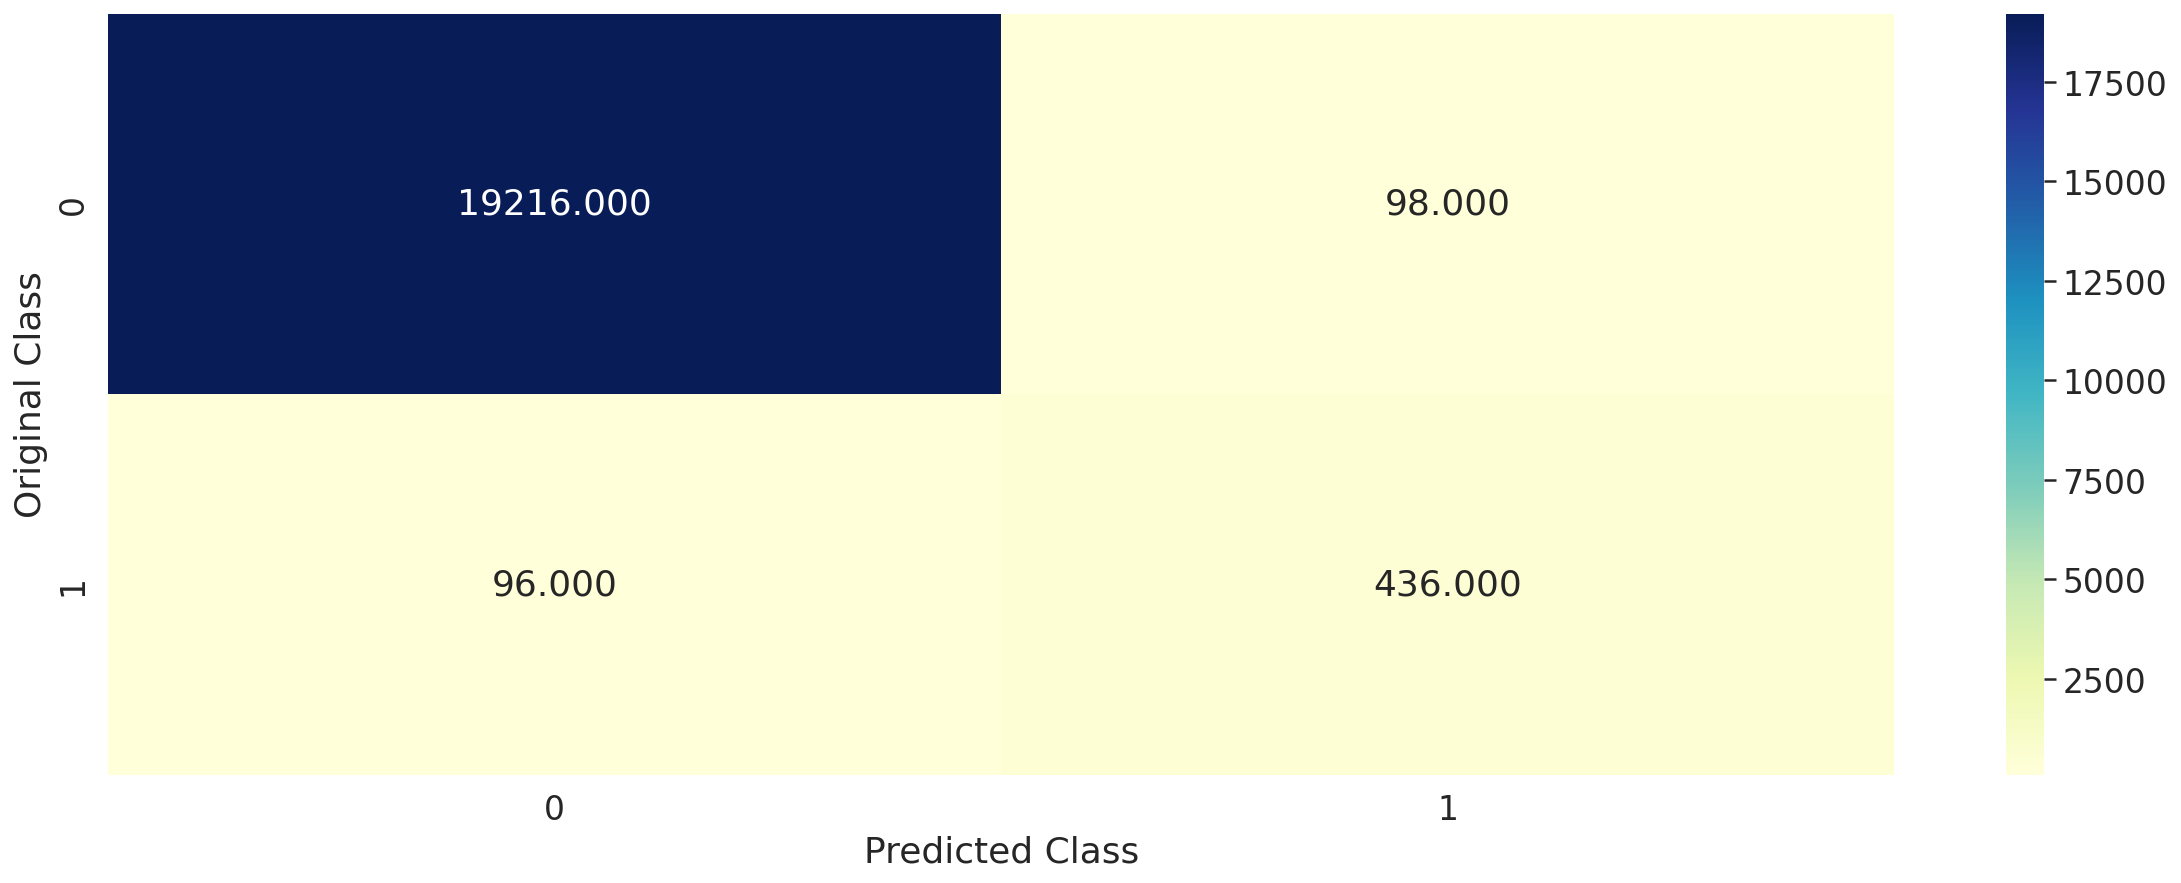

-------------------- Precision matrix (Columm Sum=1) --------------------


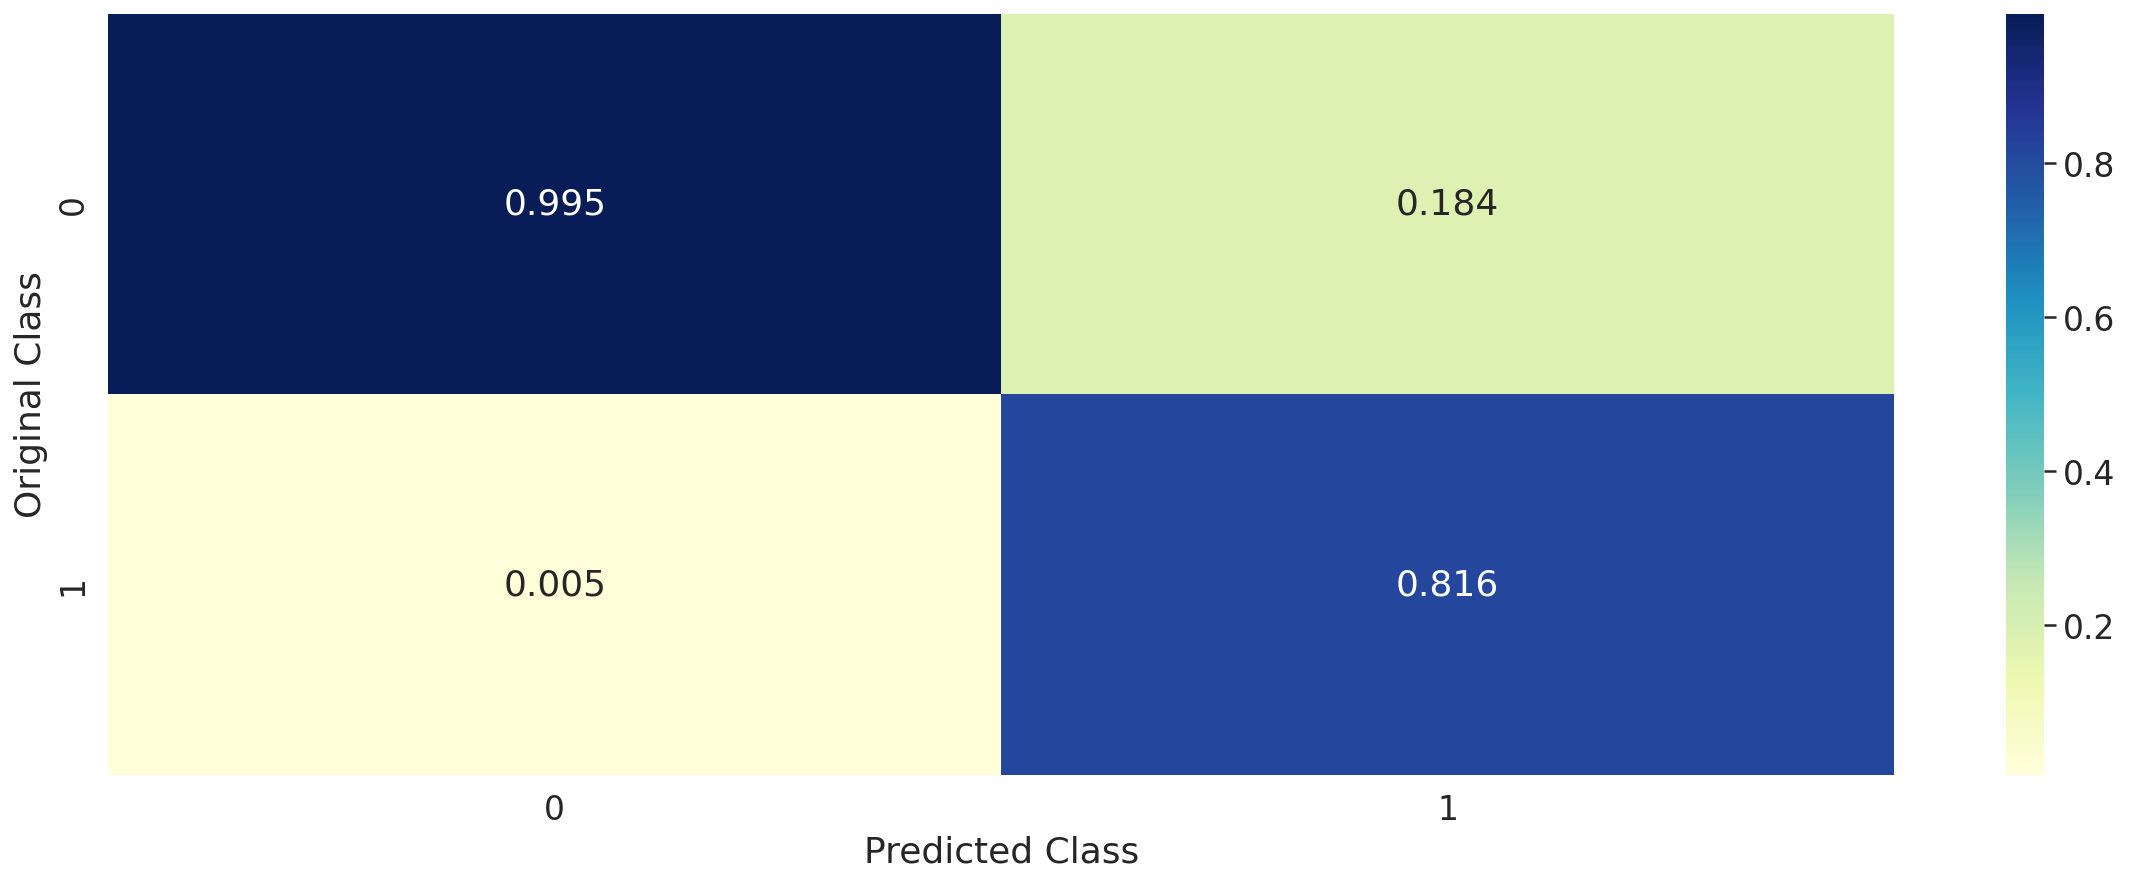

-------------------- Recall matrix (Row sum=1) --------------------


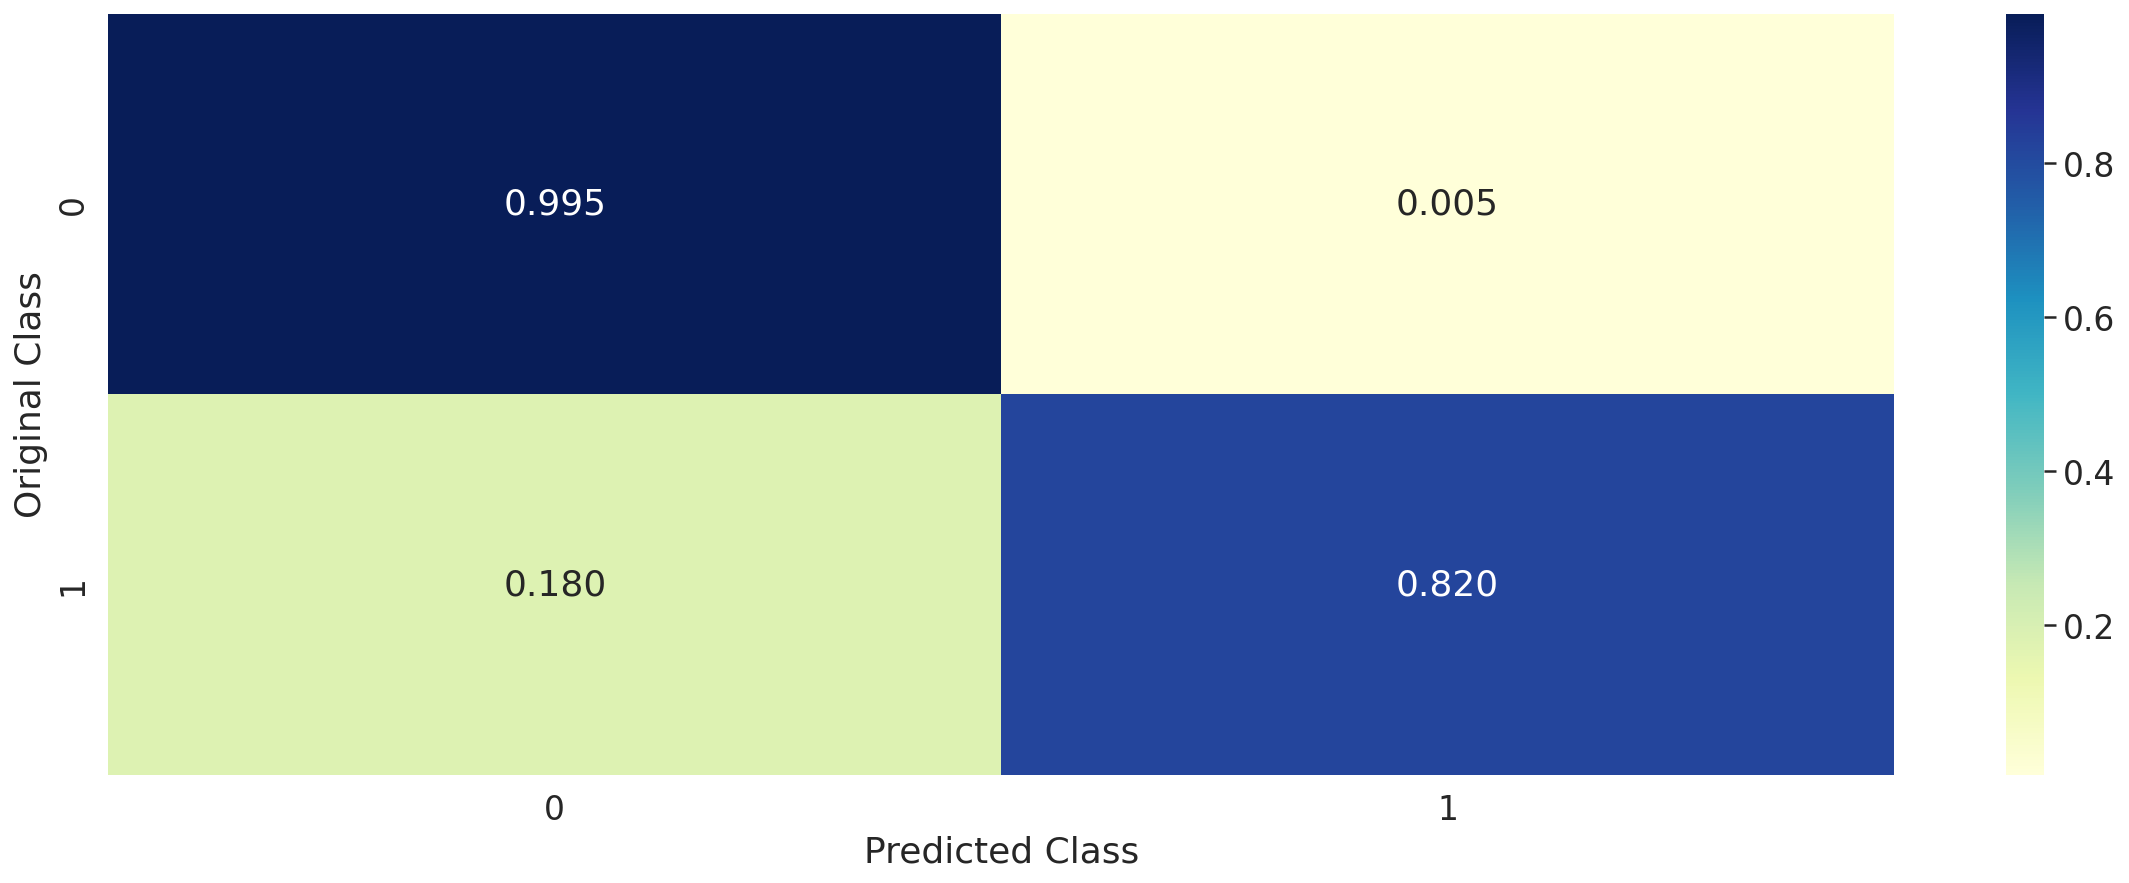

array([[19216,    98],
       [   96,   436]])

In [80]:
from sklearn.metrics import roc_curve, auc, classification_report
import xgboost as xgb
model = xgb.XGBClassifier(max_depth=36,
                          min_child_weight=8,
                          eta=0.0023695415426639743,
                          gamma=0.25894750481549217,
                          grow_policy='depthwise',
                          sample_type ='uniform', 
                          normalize_type='forest',                          
                          rate_drop =8.516917973765619e-05,
                          skip_drop = 5.650997820517849e-06,
                          eval_metric = 'auc',
                          random_state=0, 
                          n_jobs=-1)
model.fit(x_train_hstack, y_train)

predict_y = model.predict_proba(x_train_hstack)
print("train log loss:", log_loss(y_train, predict_y, labels=model.classes_, eps=1e-15))
predict_y = model.predict_proba(x_test_hstack)
print("test log loss:", log_loss(y_test, predict_y,labels=model.classes_, eps=1e-15))
predict_y = model.predict_proba(x_cv_hstack)
print("cv log loss:", log_loss(y_cv, predict_y,labels=model.classes_, eps=1e-15))



print(" "*100)
print("."*40,"Class Report","."*40)
print(" "*100)
print("-"*20,"Train Data","-"*30)
print( classification_report(y_train, model.predict(x_train_hstack)))
print("-"*20,"Test Data","-"*20)
print( classification_report(y_test, model.predict(x_test_hstack)))
print("-"*20,"CV Data","-"*20)
print( classification_report(y_cv, model.predict(x_cv_hstack)))


print('_train_'*10)
plot_confusion_matrix(y_train, model.predict(x_train_hstack))
confusion_matrix(y_train, model.predict(x_train_hstack))


print('_test_'*10)
plot_confusion_matrix(y_test,  model.predict(x_test_hstack))
confusion_matrix(y_test,  model.predict(x_test_hstack))

print('_cv_'*10)
plot_confusion_matrix(y_cv, model.predict(x_cv_hstack))
confusion_matrix(y_cv, model.predict(x_cv_hstack))


# Conclusion

In [2]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Algo", "Train F1", "Test F1", "CV F1"])
  
# Add rows
myTable.add_row(["Random_model", "0.36", "0.35", "0.36"])
myTable.add_row(["Navie", "0.61", "0.61", "0.59"])
myTable.add_row(["K-nn", "", "A", "90.23 %"])
myTable.add_row(["LR", "0.75", "0.72", "0.72"])
myTable.add_row(["svm", "0.66", "0.65", "0.65"])
myTable.add_row(["CART", "0.89", "0.89", "0.88"])
myTable.add_row(["RF", "0.87", "0.84", "0.85"])
myTable.add_row(["ada", "0.49", "0.49", "0.49"])
myTable.add_row(["MLP", "0.91", "0.79", "0.79"])
myTable.add_row(["xgb", "0.93", "0.91", "0.91"])
  
print(myTable)

+--------------+----------+---------+---------+
|     Algo     | Train F1 | Test F1 |  CV F1  |
+--------------+----------+---------+---------+
| Random_model |   0.36   |   0.35  |   0.36  |
|    Navie     |   0.61   |   0.61  |   0.59  |
|     K-nn     |          |    A    | 90.23 % |
|      LR      |   0.75   |   0.72  |   0.72  |
|     svm      |   0.66   |   0.65  |   0.65  |
|     CART     |   0.89   |   0.89  |   0.88  |
|      RF      |   0.87   |   0.84  |   0.85  |
|     ada      |   0.49   |   0.49  |   0.49  |
|     MLP      |   0.91   |   0.79  |   0.79  |
|     xgb      |   0.93   |   0.91  |   0.91  |
+--------------+----------+---------+---------+


# second model for denial reasons

In [81]:
# create a primary model with all the data

#encoding 

y_true = df[['Denial_Ind']].values
x = df[['Primary_Carrier_ID',
             'Place_Of_Service', 
             'Department', 
             'Procedure_ID', 
             'Procedure_Group',
             'Primary_Carrier_Group', 
             'Modifier',
             'Paying_Carrier_Type',
             'Is_Facility',
             'Amount',
             'dx_grp']]

In [82]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(x['Primary_Carrier_ID'].values)

x_Primary_Carrier_ID = vectorizer.transform(x['Primary_Carrier_ID'].astype('category'))


print('x_Primary_Carrier_ID', x_Primary_Carrier_ID.shape)


vectorizer = CountVectorizer()
vectorizer.fit(x['Place_Of_Service'].values)

x_Place_Of_Service = vectorizer.transform(x['Place_Of_Service'].astype('category'))


print(' '*50)
print('x_Place_Of_Service', x_Place_Of_Service.shape)


vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(x['Department'].values)
x_Department = vectorizer.transform(x['Department'].astype('category'))

print(' '*50)
print('x_train_Department', x_train_Department.shape)


vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(x['Procedure_ID'].values)

x_Procedure_ID = vectorizer.transform(x['Procedure_ID'].astype('category'))

print(' '*50)
print('x_train_Procedure_ID', x_train_Procedure_ID.shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(x['Procedure_Group'].values)

x_Procedure_Group = vectorizer.transform(x['Procedure_Group'].astype('category'))

print(' '*50)
print('x_Procedure_Group', x_Procedure_Group.shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(x['Modifier'].values)

x_Modifier= vectorizer.transform(x['Modifier'].astype('category'))


print(' '*50)
print('x_Modifier', x_Modifier.shape)

#https://stackoverflow.com/questions/43945180/why-does-countvectorizer-throw-an-empty-vocabulary-error-for-a-bigram-when-the
vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
vectorizer = vectorizer.fit(x['dx_grp'].values)

x_dx_grp= vectorizer.transform(x['dx_grp'].astype('category'))

print(' '*50)
print('x_dx_grp', x_dx_grp.shape)


vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
vectorizer = vectorizer.fit(x['Is_Facility'].values)

x_Is_Facility= vectorizer.transform(x['Is_Facility'].astype('category'))


print(' '*50)
print('x_Is_Facility', x_Is_Facility.shape)


vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(x['Primary_Carrier_Group'].values)

x_Primary_Carrier_Group= vectorizer.transform(x['Primary_Carrier_Group'].astype('category'))

print(' '*50)
print('x_train_Primary_Carrier_Group', x_train_Primary_Carrier_Group.shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(x['Paying_Carrier_Type'].values)

x_Paying_Carrier_Type= vectorizer.transform(x['Paying_Carrier_Type'].astype('category'))


print(' '*50)
print('x_Paying_Carrier_Type', x_Paying_Carrier_Type.shape)


# Numarical columns

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalizer = Normalizer()

vectorizer = MinMaxScaler()
vectorizer = vectorizer.fit(x['Amount'].values.reshape(-1,1))

x_Amount = vectorizer.transform(x['Amount'].values.reshape(-1,1))


print(' '*50)
print('x_Amount', x_Amount.shape)


x_Primary_Carrier_ID (124035, 808)
                                                  
x_Place_Of_Service (124035, 4)
                                                  
x_train_Department (79382, 19)
                                                  
x_train_Procedure_ID (79382, 410)
                                                  
x_Procedure_Group (124035, 25)
                                                  
x_Modifier (124035, 33)
                                                  
x_dx_grp (124035, 33)
                                                  
x_Is_Facility (124035, 2)
                                                  
x_train_Primary_Carrier_Group (79382, 95)
                                                  
x_Paying_Carrier_Type (124035, 15)
                                                  
x_Amount (124035, 1)


In [83]:
from scipy.sparse import hstack

x__hstack = hstack((x_Primary_Carrier_ID,
                         x_Place_Of_Service ,
                         x_Department ,
                         x_Procedure_ID ,
                         x_Procedure_Group ,
                         x_Modifier ,
                         x_dx_grp  ,
                         x_Is_Facility ,
                         x_Primary_Carrier_Group ,
                         x_Paying_Carrier_Type  ,
                         x_Amount
                         )).tocsr()

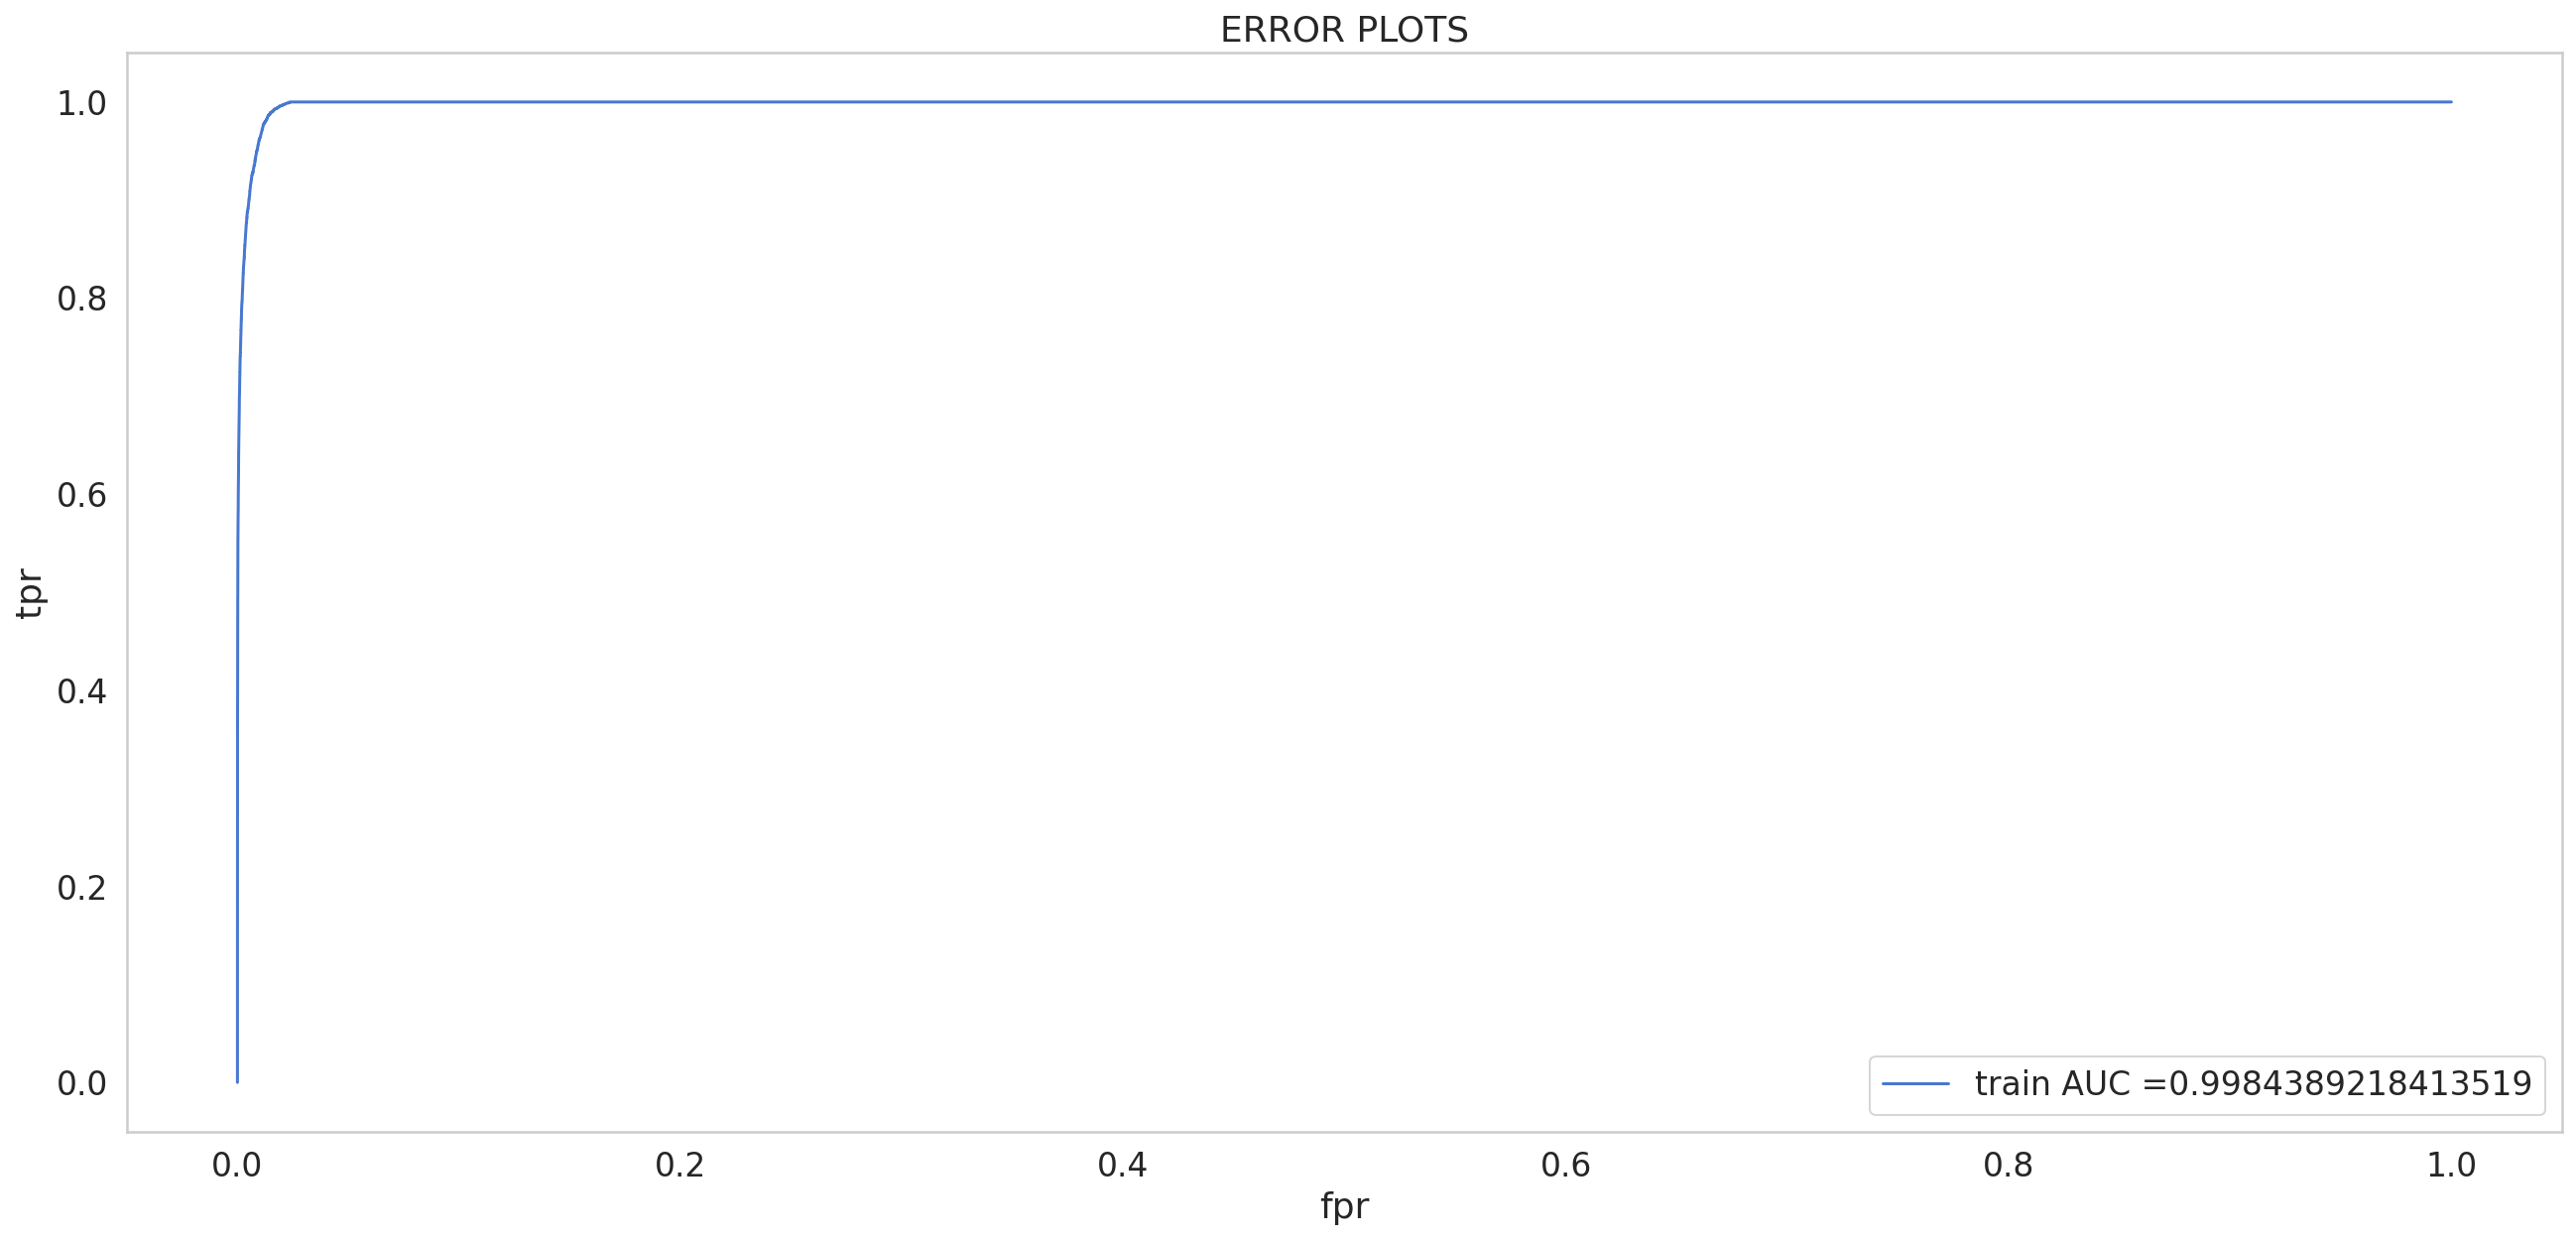

In [84]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
model = xgb.XGBClassifier(max_depth=36,
                          min_child_weight=8,
                          eta=0.0023695415426639743,
                          gamma=0.25894750481549217,
                          grow_policy='depthwise',
                          sample_type ='uniform', 
                          normalize_type='forest',                          
                          rate_drop =8.516917973765619e-05,
                          skip_drop = 5.650997820517849e-06,
                          eval_metric = 'auc',
                          random_state=0, 
                          n_jobs=-1)
model.fit(x__hstack, y_true)

y_train_pred = model.predict_proba(x__hstack)    



train_fpr, train_tpr, tr_thresholds = roc_curve(y_true.astype(int),y_train_pred[:,1])



plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))




plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [85]:
predict_y = model.predict_proba(x__hstack)
print("train log loss:", log_loss(y_true, predict_y, labels=model.classes_, eps=1e-15))



print(" "*100)
print("."*40,"Class Report","."*40)
print(" "*100)
print("-"*20,"Train Data","-"*30)
print( classification_report(y_true, model.predict(x__hstack)))

# print('_train_'*10)
# plot_confusion_matrix(y_true, model.predict(x__hstack))
# confusion_matrix(y_true, model.predict(x__hstack))


train log loss: 0.016631970624181255
                                                                                                    
........................................ Class Report ........................................
                                                                                                    
-------------------- Train Data ------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    120712
           1       0.88      0.85      0.86      3323

    accuracy                           0.99    124035
   macro avg       0.94      0.92      0.93    124035
weighted avg       0.99      0.99      0.99    124035



In [86]:
y_train_pred[:,1]

array([5.87607465e-05, 5.42401503e-05, 1.08745204e-04, ...,
       5.61141278e-05, 7.42330432e-01, 3.39949220e-01], dtype=float32)

In [87]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df['Denial_Group'])
df['Denial_Group_endcoded']= le.transform(df['Denial_Group'])
df['Denial_Group_endcoded']

112       5
114       5
115       5
116       5
117       5
         ..
163342    2
163343    6
163351    5
163356    4
163358    6
Name: Denial_Group_endcoded, Length: 124035, dtype: int64

In [88]:
y_true = df[['Denial_Group_endcoded']].values
df['pred_y'] = model.predict(x__hstack)
x = df[['Primary_Carrier_ID',
             'Place_Of_Service', 
             'Department', 
             'Procedure_ID', 
             'Procedure_Group',
             'Primary_Carrier_Group', 
             'Modifier',
             'Paying_Carrier_Type',
             'Is_Facility',
             'Amount',
             'dx_grp','pred_y']]

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(x, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [89]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(train_df['Primary_Carrier_ID'].values)

x_train_Primary_Carrier_ID = vectorizer.transform(train_df['Primary_Carrier_ID'].astype('category'))
x_test_Primary_Carrier_ID = vectorizer.transform(test_df['Primary_Carrier_ID'].astype('category'))
x_cv_Primary_Carrier_ID = vectorizer.transform(cv_df['Primary_Carrier_ID'].astype('category'))

print('x_train_Primary_Carrier_ID', x_train_Primary_Carrier_ID.shape)
print('x_test_Primary_Carrier_ID', x_test_Primary_Carrier_ID.shape)
print('x_cv_Primary_Carrier_ID', x_cv_Primary_Carrier_ID.shape)

vectorizer = CountVectorizer()
vectorizer.fit(train_df['Place_Of_Service'].values)

x_train_Place_Of_Service = vectorizer.transform(train_df['Place_Of_Service'].astype('category'))
x_test_Place_Of_Service = vectorizer.transform(test_df['Place_Of_Service'].astype('category'))
x_cv_Place_Of_Service = vectorizer.transform(cv_df['Place_Of_Service'].astype('category'))

print(' '*50)
print('x_train_Place_Of_Service', x_train_Place_Of_Service.shape)
print('x_test_Place_Of_Service', x_test_Place_Of_Service.shape)
print('x_cv_Place_Of_Service', x_cv_Place_Of_Service.shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(train_df['Department'].values)
x_train_Department = vectorizer.transform(train_df['Department'].astype('category'))
x_test_Department = vectorizer.transform(test_df['Department'].astype('category'))
x_cv_Department = vectorizer.transform(cv_df['Department'].astype('category'))

print(' '*50)
print('x_train_Department', x_train_Department.shape)
print('x_test_Department', x_test_Department.shape)
print('x_cv_Department', x_cv_Department.shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(train_df['Procedure_ID'].values)

x_train_Procedure_ID = vectorizer.transform(train_df['Procedure_ID'].astype('category'))
x_test_Procedure_ID = vectorizer.transform(test_df['Procedure_ID'].astype('category'))
x_cv_Procedure_ID = vectorizer.transform(cv_df['Procedure_ID'].astype('category'))

print(' '*50)
print('x_train_Procedure_ID', x_train_Procedure_ID.shape)
print('x_test_Procedure_ID', x_test_Procedure_ID.shape)
print('x_cv_Procedure_ID ', x_cv_Procedure_ID .shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(train_df['Procedure_Group'].values)

x_train_Procedure_Group = vectorizer.transform(train_df['Procedure_Group'].astype('category'))
x_test_Procedure_Group = vectorizer.transform(test_df['Procedure_Group'].astype('category'))
x_cv_Procedure_Group = vectorizer.transform(cv_df['Procedure_Group'].astype('category'))

print(' '*50)
print('x_train_Procedure_Group', x_train_Procedure_Group.shape)
print('x_test_Procedure_Group', x_test_Procedure_Group.shape)
print('x_cv_Procedure_Group ', x_cv_Procedure_Group .shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(train_df['Modifier'].values)

x_train_Modifier= vectorizer.transform(train_df['Modifier'].astype('category'))
x_test_Modifier = vectorizer.transform(test_df['Modifier'].astype('category'))
x_cv_Modifier = vectorizer.transform(cv_df['Modifier'].astype('category'))

print(' '*50)
print('x_train_Modifier', x_train_Modifier.shape)
print('x_test_Modifier', x_test_Modifier.shape)
print('x_cv_Modifier ', x_cv_Modifier .shape)
#https://stackoverflow.com/questions/43945180/why-does-countvectorizer-throw-an-empty-vocabulary-error-for-a-bigram-when-the
vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
vectorizer = vectorizer.fit(train_df['dx_grp'].values)

x_train_dx_grp= vectorizer.transform(train_df['dx_grp'].astype('category'))
x_test_dx_grp = vectorizer.transform(test_df['dx_grp'].astype('category'))
x_cv_dx_grp = vectorizer.transform(cv_df['dx_grp'].astype('category'))

print(' '*50)
print('x_train_dx_grp', x_train_dx_grp.shape)
print('x_test_dx_grp', x_test_dx_grp.shape)
print('x_cv_dx_grp ', x_cv_dx_grp .shape)


vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
vectorizer = vectorizer.fit(train_df['Is_Facility'].values)

x_train_Is_Facility= vectorizer.transform(train_df['Is_Facility'].astype('category'))
x_test_Is_Facility = vectorizer.transform(test_df['Is_Facility'].astype('category'))
x_cv_Is_Facility = vectorizer.transform(cv_df['Is_Facility'].astype('category'))

print(' '*50)
print('x_train_Is_Facility', x_train_Is_Facility.shape)
print('x_test_Is_Facility', x_test_Is_Facility.shape)
print('x_cv_Is_Facility ', x_cv_Is_Facility .shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(train_df['Primary_Carrier_Group'].values)

x_train_Primary_Carrier_Group= vectorizer.transform(train_df['Primary_Carrier_Group'].astype('category'))
x_test_Primary_Carrier_Group = vectorizer.transform(test_df['Primary_Carrier_Group'].astype('category'))
x_cv_Primary_Carrier_Groupy = vectorizer.transform(cv_df['Primary_Carrier_Group'].astype('category'))

print(' '*50)
print('x_train_Primary_Carrier_Group', x_train_Primary_Carrier_Group.shape)
print('x_test_Primary_Carrier_Group', x_test_Primary_Carrier_Group.shape)
print('x_cv_Primary_Carrier_Groupy ', x_cv_Primary_Carrier_Groupy .shape)

vectorizer = CountVectorizer()
vectorizer = vectorizer.fit(train_df['Paying_Carrier_Type'].values)

x_train_Paying_Carrier_Type= vectorizer.transform(train_df['Paying_Carrier_Type'].astype('category'))
x_test_Paying_Carrier_Type = vectorizer.transform(test_df['Paying_Carrier_Type'].astype('category'))
x_cv_Paying_Carrier_Type= vectorizer.transform(cv_df['Paying_Carrier_Type'].astype('category'))

print(' '*50)
print('x_train_Paying_Carrier_Type', x_train_Paying_Carrier_Type.shape)
print('x_test_Paying_Carrier_Type', x_test_Paying_Carrier_Type.shape)
print('x_cv_Paying_Carrier_Type ', x_cv_Paying_Carrier_Type .shape)


# Numarical columns

from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalizer = Normalizer()

vectorizer = MinMaxScaler()
vectorizer = vectorizer.fit(train_df['Amount'].values.reshape(-1,1))

x_train_Amount = vectorizer.transform(train_df['Amount'].values.reshape(-1,1))
x_test_Amount = vectorizer.transform(test_df['Amount'].values.reshape(-1,1))
x_cv_Amount = vectorizer.transform(cv_df['Amount'].values.reshape(-1,1))

print(' '*50)
print('x_train_Amount', x_train_Amount.shape)
print('x_test_Amount', x_test_Amount.shape)
print('x_cv_Amount ', x_cv_Amount.shape)


vectorizer = MinMaxScaler()
vectorizer = vectorizer.fit(train_df['pred_y'].values.reshape(-1,1))

x_train_pred_y = vectorizer.transform(train_df['pred_y'].values.reshape(-1,1))
x_test_pred_y = vectorizer.transform(test_df['pred_y'].values.reshape(-1,1))
x_cv_pred_y = vectorizer.transform(cv_df['pred_y'].values.reshape(-1,1))

print(' '*50)
print('x_train_pred_y', x_train_pred_y.shape)
print('x_test_pred_y', x_test_pred_y.shape)
print('x_cv_pred_y ', x_cv_pred_y.shape)

x_train_Primary_Carrier_ID (79382, 724)
x_test_Primary_Carrier_ID (24807, 724)
x_cv_Primary_Carrier_ID (19846, 724)
                                                  
x_train_Place_Of_Service (79382, 4)
x_test_Place_Of_Service (24807, 4)
x_cv_Place_Of_Service (19846, 4)
                                                  
x_train_Department (79382, 19)
x_test_Department (24807, 19)
x_cv_Department (19846, 19)
                                                  
x_train_Procedure_ID (79382, 403)
x_test_Procedure_ID (24807, 403)
x_cv_Procedure_ID  (19846, 403)
                                                  
x_train_Procedure_Group (79382, 24)
x_test_Procedure_Group (24807, 24)
x_cv_Procedure_Group  (19846, 24)
                                                  
x_train_Modifier (79382, 31)
x_test_Modifier (24807, 31)
x_cv_Modifier  (19846, 31)
                                                  
x_train_dx_grp (79382, 33)
x_test_dx_grp (24807, 33)
x_cv_dx_grp  (19846, 33)
                   

In [90]:
from scipy.sparse import hstack

x_train_hstack = hstack((x_train_Primary_Carrier_ID,
                         x_train_Place_Of_Service ,
                         x_train_Department ,
                         x_train_Procedure_ID ,
                         x_train_Procedure_Group ,
                         x_train_Modifier ,
                         x_train_dx_grp  ,
                         x_train_Is_Facility ,
                         x_train_Primary_Carrier_Group ,
                         x_train_Paying_Carrier_Type  ,
                         x_train_Amount,
                         x_train_pred_y
                         )).tocsr()

x_test_hstack = hstack((x_test_Primary_Carrier_ID ,
                        x_test_Place_Of_Service ,
                        x_test_Department ,
                        x_test_Procedure_ID ,
                        x_test_Procedure_Group ,
                        x_test_Modifier ,
                        x_test_dx_grp ,
                        x_test_Is_Facility  ,
                        x_test_Primary_Carrier_Group ,
                        x_test_Paying_Carrier_Type  ,
                        x_test_Amount,
                        x_test_pred_y
                        )).tocsr()


x_cv_hstack = hstack((x_cv_Primary_Carrier_ID ,
                        x_cv_Place_Of_Service ,
                        x_cv_Department ,
                        x_cv_Procedure_ID  ,
                        x_cv_Procedure_Group,
                        x_cv_Modifier ,
                        x_cv_dx_grp  ,
                        x_cv_Is_Facility  ,
                        x_cv_Primary_Carrier_Groupy  ,
                        x_cv_Paying_Carrier_Type  ,
                        x_cv_Amount ,
                        x_cv_pred_y
                        )).tocsr()



print(x_train_hstack.shape)
print(x_test_hstack.shape)
print(x_cv_hstack.shape)

(79382, 1354)
(24807, 1354)
(19846, 1354)


In [91]:
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score


def objective(trial):
   
    
    #n_estimators = trial.suggest_int("n_estimators", 200,5000)    
    max_depth = trial.suggest_int("max_depth", 2, 55, log=True)  
    min_child_weight = trial.suggest_int("min_child_weight", 2, 10)
    eta = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    gamma = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    grow_policy = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide",])
    sample_type = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
    normalize_type = trial.suggest_categorical("normalize_type", ["tree", "forest"])
    rate_drop = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
    skip_drop = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    eval_metric = trial.suggest_categorical("eval_metric", ["logloss", "auc"])
    
    rf =  xgb.XGBClassifier(
                            max_depth=max_depth,
                           gamma=gamma,
                           grow_policy=grow_policy,
                           sample_type=sample_type,
                           eval_metric=eval_metric)

    score = cross_val_score(rf, x_train_hstack, y_train, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2022-03-11 18:37:32,284] A new study created in memory with name: no-name-80254104-88a0-4f7a-a5b5-c8572a149ff5
[I 2022-03-11 18:38:17,873] Trial 0 finished with value: 0.986747623339031 and parameters: {'max_depth': 12, 'min_child_weight': 2, 'eta': 1.8857476176016963e-07, 'gamma': 0.01281183375200289, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.00015168685785828885, 'skip_drop': 0.004280337251614293, 'eval_metric': 'logloss'}. Best is trial 0 with value: 0.986747623339031.
[I 2022-03-11 18:39:12,844] Trial 1 finished with value: 0.9864956730865408 and parameters: {'max_depth': 17, 'min_child_weight': 7, 'eta': 0.06285131724821559, 'gamma': 0.0015547107581576807, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.1116561415474585e-07, 'skip_drop': 6.246653105067764e-05, 'eval_metric': 'auc'}. Best is trial 0 with value: 0.986747623339031.
[I 2022-03-11 18:40:06,884] Trial 2 finished wi

In [92]:
# 3 trials
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.9873774868301405
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 4, 'eta': 1.2302655766617576e-07, 'gamma': 0.445515133290193, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.046417921938847514, 'skip_drop': 0.0014233499056117635, 'eval_metric': 'auc'}


In [96]:
from sklearn.metrics import roc_curve, auc, classification_report
model_d = xgb.XGBClassifier(max_depth=5,
                          min_child_weight=4,
                          eta=1.2302655766617576e-07,
                          gamma=0.445515133290193,
                          grow_policy='depthwise',
                          sample_type ='weighted', 
                          normalize_type='tree',                          
                          rate_drop =0.046417921938847514,
                          skip_drop = 0.0014233499056117635,
                          eval_metric = 'auc',
                          random_state=0, 
                          n_jobs=-1)
model_d.fit(x_train_hstack, y_train)

predict_y = model_d.predict_proba(x_train_hstack)
print("train log loss:", log_loss(y_train, predict_y, labels=model_d.classes_, eps=1e-15))
predict_y = model_d.predict_proba(x_test_hstack)
print("test log loss:", log_loss(y_test, predict_y,labels=model_d.classes_, eps=1e-15))
predict_y = model_d.predict_proba(x_cv_hstack)
print("cv log loss:", log_loss(y_cv, predict_y,labels=model_d.classes_, eps=1e-15))



print(" "*100)
print("."*40,"Class Report","."*40)
print(" "*100)
print("-"*20,"Train Data","-"*30)
print( classification_report(y_train, model_d.predict(x_train_hstack)))
print("-"*20,"Test Data","-"*20)
print( classification_report(y_test, model_d.predict(x_test_hstack)))
print("-"*20,"CV Data","-"*20)
print( classification_report(y_cv, model_d.predict(x_cv_hstack)))


train log loss: 0.03393279904783451
test log loss: 0.04040719121949468
cv log loss: 0.03666410304086113
                                                                                                    
........................................ Class Report ........................................
                                                                                                    
-------------------- Train Data ------------------------------
              precision    recall  f1-score   support

           0       0.63      0.53      0.58       168
           1       0.87      0.95      0.91       277
           2       0.68      0.65      0.66       500
           3       0.64      0.62      0.63       699
           4       0.70      0.63      0.66       154
           5       1.00      1.00      1.00     77257
           6       0.77      0.73      0.75       327

    accuracy                           0.99     79382
   macro avg       0.75      0.73      0.74     

In [97]:
print( classification_report(y_train, model_d.predict(x_train_hstack)))

              precision    recall  f1-score   support

           0       0.63      0.53      0.58       168
           1       0.87      0.95      0.91       277
           2       0.68      0.65      0.66       500
           3       0.64      0.62      0.63       699
           4       0.70      0.63      0.66       154
           5       1.00      1.00      1.00     77257
           6       0.77      0.73      0.75       327

    accuracy                           0.99     79382
   macro avg       0.75      0.73      0.74     79382
weighted avg       0.99      0.99      0.99     79382

